In [44]:
import pandas as pd

final_dataset = pd.read_csv('np2.csv')
print(final_dataset)
test_dataset = pd.read_csv('r1_test.csv')

        Store  Container_404  Bad_Subs  Nil_Pick
0       53223             63        27        82
1       24612             33        47       115
2       40717             69         5        61
3       77993             74        20       171
4       99213             27        28         1
...       ...            ...       ...       ...
119971  26396             36        25        17
119972  59132             75        19        32
119973  94912              4        16       186
119974  85080             57        28        23
119975  60365             19        28       136

[119976 rows x 4 columns]


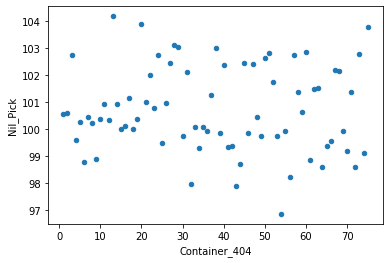

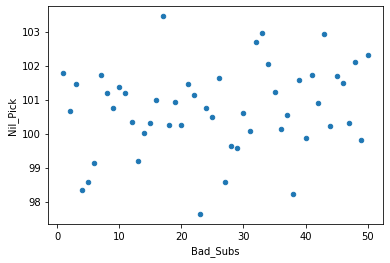

In [45]:
import matplotlib.pyplot as plt

plot_df = final_dataset[['Nil_Pick', 'Container_404']]
rounded_temp = plot_df['Container_404'].round(0)  # nearest integer
plot_df = plot_df.groupby(rounded_temp).mean()
plot_df.plot.scatter(x='Container_404', y='Nil_Pick')
plt.show()

plot_df = final_dataset[['Nil_Pick', 'Bad_Subs']]
rounded_temp = plot_df['Bad_Subs'].round(0)  # nearest integer
plot_df = plot_df.groupby(rounded_temp).mean()
plot_df.plot.scatter(x='Bad_Subs', y='Nil_Pick')
plt.show()

In [46]:
def split_train_eval(final_dataset):
    final_dataset = final_dataset.sample(frac=1)
    eval_size = len(final_dataset) // 10
    eval_set = final_dataset.iloc[:eval_size]
    train_set = final_dataset.iloc[eval_size:]
    return train_set, eval_set

def add_int_features(dataset_row, feature_dict, has_labels):
    int_vals = ['Store','Container_404','Bad_Subs']
    if has_labels:
        int_vals.append('Nil_Pick')
    for feature_name in int_vals:
        list_val = tf.train.Int64List(value=[dataset_row[feature_name]])
        feature_dict[feature_name] = tf.train.Feature(int64_list=list_val)

def create_example(dataset_row, has_labels):
    feature_dict = {}
    add_int_features(dataset_row, feature_dict, True)
    features_obj = tf.train.Features(feature=feature_dict)
    return tf.train.Example(features=features_obj)

In [47]:
import tensorflow as tf

# Write serialized Example objects to a TFRecords file
def write_tfrecords(dataset, has_labels, tfrecords_file):
    writer = tf.compat.v1.python_io.TFRecordWriter(tfrecords_file)
    for i in range(len(dataset)):
        example = create_example(dataset.iloc[i], has_labels)
        writer.write(example.SerializeToString())
    writer.close()



# train_set is the training DataFrame
write_tfrecords(split_train_eval(final_dataset)[0], True, 'train_nil_pick.tfrecords')

# eval_set is the evaluation DataFrame
write_tfrecords(split_train_eval(final_dataset)[1], True, 'eval_nil_pick.tfrecords')

# test_set is the test DataFrame
write_tfrecords(test_dataset, False, 'test_nil_pick.tfrecords')

In [48]:
import tensorflow as tf

# Create the spec used when parsing the Example object
def create_example_spec(has_labels):
    example_spec = {}
    int_vals = ['Store','Container_404','Bad_Subs']
    if has_labels:
        int_vals.append('Nil_Pick')
    for feature_name in int_vals:
        example_spec[feature_name] = tf.compat.v1.FixedLenFeature((), tf.int64)
    return example_spec

example_spec = create_example_spec(True)

# Helper function to convert serialized Example objects into features
def parse_features(ser_ex, example_spec, has_labels):
    parsed_features = tf.compat.v1.parse_single_example(ser_ex, example_spec)
    features = {k: parsed_features[k] for k in parsed_features if k != 'Nil_Pick'}
    if not has_labels:
        return features
    label = parsed_features['Nil_Pick']
    return features,label

def get_train_data():
    train_file = 'train_nil_pick.tfrecords'
    train_dataset = tf.data.TFRecordDataset(train_file)
    print(train_dataset)
    parse_fn = lambda ser_ex: parse_features(ser_ex, example_spec, True)
    train_dataset = train_dataset.map(parse_fn)
    train_dataset = train_dataset.shuffle(10000)
    train_dataset = train_dataset.batch(100)
    print(train_dataset)
    return train_dataset

print(get_train_data())

def get_eval_data():
    eval_file = 'eval_nil_pick.tfrecords'
    eval_dataset = tf.data.TFRecordDataset(eval_file)
    parse_fn = lambda ser_ex: parse_features(ser_ex, example_spec, True)
    eval_dataset = eval_dataset.map(parse_fn)
    eval_dataset = eval_dataset.shuffle(10000)
    eval_dataset = eval_dataset.batch(20)
    return eval_dataset

def get_test_data():
    eval_file = 'test_nil_pick.tfrecords'
    eval_dataset = tf.data.TFRecordDataset(eval_file)
    parse_fn = lambda ser_ex: parse_features(ser_ex, example_spec, True)
    eval_dataset = eval_dataset.map(parse_fn)
    eval_dataset = eval_dataset.shuffle(10000)
    eval_dataset = eval_dataset.batch(20)
    return eval_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>


In [49]:
import tensorflow as tf

def add_numeric_columns(feature_columns):
    numeric_features = ['Store','Container_404','Bad_Subs']
    for feature_name in numeric_features:
        feature_col = tf.feature_column.numeric_column(feature_name, shape=())
        feature_columns.append(feature_col)

def create_feature_columns():
    feature_columns = []
    add_numeric_columns(feature_columns)
    return feature_columns


In [50]:
class SubsModel(object):
  def __init__(self, hidden_layers):
    self.hidden_layers = hidden_layers
  

  def run_regression_predict(self, ckpt_dir, data_file):
    regression_model = self.create_regression_model(ckpt_dir)
    predictions = regression_model.predict(input_fn=get_test_data)
    print("Predictions ",predictions)
    pred_list = []
    for pred_dict in predictions:
        pred_list.append(pred_dict['predictions'][0])
    print(pred_list)
    return pred_list

  def run_regression_eval(self, ckpt_dir):
    regression_model = self.create_regression_model(ckpt_dir)
    return regression_model.evaluate(input_fn=get_eval_data)

  def run_regression_training(self, ckpt_dir, batch_size=1, num_training_steps=None):
    regression_model = self.create_regression_model(ckpt_dir)
    regression_model.train(input_fn=get_train_data, steps=num_training_steps)

  def create_regression_model(self, ckpt_dir):
    config = tf.estimator.RunConfig(log_step_count_steps=10000)
    regression_model = tf.estimator.Estimator(
      self.regression_fn,
      config=config,
      model_dir=ckpt_dir)
    return regression_model

  def regression_fn(self, features, labels, mode, params):
    feature_columns = create_feature_columns()
    inputs = tf.compat.v1.feature_column.input_layer(features, feature_columns)
    batch_predictions = self.model_layers(inputs) 
    predictions = tf.squeeze(batch_predictions)
    if labels is not None:
        loss = tf.compat.v1.losses.absolute_difference(labels, predictions)
        
    if mode == tf.estimator.ModeKeys.TRAIN:
        global_step = tf.compat.v1.train.get_or_create_global_step()
        adam = tf.compat.v1.train.AdamOptimizer()
        train_op = adam.minimize(
        loss, global_step=global_step)
        return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss=loss)
    if mode == tf.estimator.ModeKeys.PREDICT:
        prediction_info = {
          'predictions': batch_predictions
        }
    return tf.estimator.EstimatorSpec(mode, predictions=prediction_info)

  def model_layers(self, inputs):
    layer = inputs
    for num_nodes in self.hidden_layers:
        print("Layer ",layer)
        layer = tf.compat.v1.layers.dense(layer, num_nodes,
        activation=tf.nn.relu)
    batch_predictions = tf.compat.v1.layers.dense(layer, 1)
    return batch_predictions

In [51]:
subs_model = SubsModel([300,100])
count = 1000
for i in range(count):
    subs_model.run_regression_training(ckpt_dir="/tmp/test_nil_pick_10", num_training_steps=500)
subs_model.run_regression_eval(ckpt_dir="/tmp/test_nil_pick_10")
#subs_model.run_regression_predict(ckpt_dir="/tmp/test_nil_pick_1", data_file="train_nil_pick.tfrecords")
print("Done")

INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:loss = 1890.7312, step = 0


INFO:tensorflow:loss = 1890.7312, step = 0


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1080...


INFO:tensorflow:Saving checkpoints for 1080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1080...


INFO:tensorflow:Loss for final step: 55.393116.


INFO:tensorflow:Loss for final step: 55.393116.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1080...


INFO:tensorflow:Saving checkpoints for 1080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1080...


INFO:tensorflow:loss = 55.892418, step = 1080


INFO:tensorflow:loss = 55.892418, step = 1080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2160...


INFO:tensorflow:Saving checkpoints for 2160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 2160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 2160...


INFO:tensorflow:Loss for final step: 57.22114.


INFO:tensorflow:Loss for final step: 57.22114.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-2160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-2160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2160...


INFO:tensorflow:Saving checkpoints for 2160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 2160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 2160...


INFO:tensorflow:loss = 53.889297, step = 2160


INFO:tensorflow:loss = 53.889297, step = 2160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3240...


INFO:tensorflow:Saving checkpoints for 3240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3240...


INFO:tensorflow:Loss for final step: 60.145756.


INFO:tensorflow:Loss for final step: 60.145756.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-3240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-3240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 3240...


INFO:tensorflow:Saving checkpoints for 3240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 3240...


INFO:tensorflow:loss = 53.940845, step = 3240


INFO:tensorflow:loss = 53.940845, step = 3240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 4320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 4320...


INFO:tensorflow:Saving checkpoints for 4320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 4320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 4320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 4320...


INFO:tensorflow:Loss for final step: 57.89462.


INFO:tensorflow:Loss for final step: 57.89462.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-4320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-4320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 4320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 4320...


INFO:tensorflow:Saving checkpoints for 4320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 4320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 4320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 4320...


INFO:tensorflow:loss = 55.78668, step = 4320


INFO:tensorflow:loss = 55.78668, step = 4320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5400...


INFO:tensorflow:Saving checkpoints for 5400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5400...


INFO:tensorflow:Loss for final step: 60.38605.


INFO:tensorflow:Loss for final step: 60.38605.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-5400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-5400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5400...


INFO:tensorflow:Saving checkpoints for 5400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5400...


INFO:tensorflow:loss = 50.9405, step = 5400


INFO:tensorflow:loss = 50.9405, step = 5400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6480...


INFO:tensorflow:Saving checkpoints for 6480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6480...


INFO:tensorflow:Loss for final step: 58.102352.


INFO:tensorflow:Loss for final step: 58.102352.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-6480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-6480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 6480...


INFO:tensorflow:Saving checkpoints for 6480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 6480...


INFO:tensorflow:loss = 58.36307, step = 6480


INFO:tensorflow:loss = 58.36307, step = 6480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 7560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 7560...


INFO:tensorflow:Saving checkpoints for 7560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 7560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 7560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 7560...


INFO:tensorflow:Loss for final step: 56.72453.


INFO:tensorflow:Loss for final step: 56.72453.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-7560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-7560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 7560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 7560...


INFO:tensorflow:Saving checkpoints for 7560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 7560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 7560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 7560...


INFO:tensorflow:loss = 55.91438, step = 7560


INFO:tensorflow:loss = 55.91438, step = 7560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 8640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 8640...


INFO:tensorflow:Saving checkpoints for 8640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 8640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 8640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 8640...


INFO:tensorflow:Loss for final step: 48.224144.


INFO:tensorflow:Loss for final step: 48.224144.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-8640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-8640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 8640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 8640...


INFO:tensorflow:Saving checkpoints for 8640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 8640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 8640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 8640...


INFO:tensorflow:loss = 61.594902, step = 8640


INFO:tensorflow:loss = 61.594902, step = 8640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9720...


INFO:tensorflow:Saving checkpoints for 9720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9720...


INFO:tensorflow:Loss for final step: 45.499268.


INFO:tensorflow:Loss for final step: 45.499268.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-9720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-9720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 9720...


INFO:tensorflow:Saving checkpoints for 9720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 9720...


INFO:tensorflow:loss = 55.04039, step = 9720


INFO:tensorflow:loss = 55.04039, step = 9720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 10800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 10800...


INFO:tensorflow:Saving checkpoints for 10800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 10800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 10800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 10800...


INFO:tensorflow:Loss for final step: 58.746872.


INFO:tensorflow:Loss for final step: 58.746872.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-10800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-10800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 10800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 10800...


INFO:tensorflow:Saving checkpoints for 10800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 10800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 10800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 10800...


INFO:tensorflow:loss = 53.4937, step = 10800


INFO:tensorflow:loss = 53.4937, step = 10800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 11880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 11880...


INFO:tensorflow:Saving checkpoints for 11880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 11880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 11880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 11880...


INFO:tensorflow:Loss for final step: 58.30868.


INFO:tensorflow:Loss for final step: 58.30868.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-11880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-11880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 11880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 11880...


INFO:tensorflow:Saving checkpoints for 11880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 11880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 11880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 11880...


INFO:tensorflow:loss = 49.813038, step = 11880


INFO:tensorflow:loss = 49.813038, step = 11880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12960...


INFO:tensorflow:Saving checkpoints for 12960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12960...


INFO:tensorflow:Loss for final step: 55.356056.


INFO:tensorflow:Loss for final step: 55.356056.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-12960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-12960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 12960...


INFO:tensorflow:Saving checkpoints for 12960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 12960...


INFO:tensorflow:loss = 51.922855, step = 12960


INFO:tensorflow:loss = 51.922855, step = 12960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 14040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 14040...


INFO:tensorflow:Saving checkpoints for 14040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 14040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 14040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 14040...


INFO:tensorflow:Loss for final step: 55.71844.


INFO:tensorflow:Loss for final step: 55.71844.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-14040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-14040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 14040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 14040...


INFO:tensorflow:Saving checkpoints for 14040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 14040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 14040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 14040...


INFO:tensorflow:loss = 57.61379, step = 14040


INFO:tensorflow:loss = 57.61379, step = 14040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15120...


INFO:tensorflow:Saving checkpoints for 15120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 15120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15120...


INFO:tensorflow:Loss for final step: 54.704597.


INFO:tensorflow:Loss for final step: 54.704597.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-15120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-15120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15120...


INFO:tensorflow:Saving checkpoints for 15120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 15120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15120...


INFO:tensorflow:loss = 55.848267, step = 15120


INFO:tensorflow:loss = 55.848267, step = 15120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 16200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 16200...


INFO:tensorflow:Saving checkpoints for 16200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 16200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 16200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 16200...


INFO:tensorflow:Loss for final step: 52.607113.


INFO:tensorflow:Loss for final step: 52.607113.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-16200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-16200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 16200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 16200...


INFO:tensorflow:Saving checkpoints for 16200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 16200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 16200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 16200...


INFO:tensorflow:loss = 56.2587, step = 16200


INFO:tensorflow:loss = 56.2587, step = 16200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 17280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 17280...


INFO:tensorflow:Saving checkpoints for 17280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 17280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 17280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 17280...


INFO:tensorflow:Loss for final step: 50.61646.


INFO:tensorflow:Loss for final step: 50.61646.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-17280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-17280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 17280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 17280...


INFO:tensorflow:Saving checkpoints for 17280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 17280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 17280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 17280...


INFO:tensorflow:loss = 61.09288, step = 17280


INFO:tensorflow:loss = 61.09288, step = 17280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18360...


INFO:tensorflow:Saving checkpoints for 18360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 18360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18360...


INFO:tensorflow:Loss for final step: 52.91464.


INFO:tensorflow:Loss for final step: 52.91464.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-18360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-18360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18360...


INFO:tensorflow:Saving checkpoints for 18360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 18360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18360...


INFO:tensorflow:loss = 49.793457, step = 18360


INFO:tensorflow:loss = 49.793457, step = 18360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 19440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 19440...


INFO:tensorflow:Saving checkpoints for 19440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 19440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 19440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 19440...


INFO:tensorflow:Loss for final step: 55.60689.


INFO:tensorflow:Loss for final step: 55.60689.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-19440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-19440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 19440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 19440...


INFO:tensorflow:Saving checkpoints for 19440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 19440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 19440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 19440...


INFO:tensorflow:loss = 56.434086, step = 19440


INFO:tensorflow:loss = 56.434086, step = 19440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 20520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 20520...


INFO:tensorflow:Saving checkpoints for 20520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 20520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 20520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 20520...


INFO:tensorflow:Loss for final step: 46.046124.


INFO:tensorflow:Loss for final step: 46.046124.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-20520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-20520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 20520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 20520...


INFO:tensorflow:Saving checkpoints for 20520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 20520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 20520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 20520...


INFO:tensorflow:loss = 54.288055, step = 20520


INFO:tensorflow:loss = 54.288055, step = 20520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21600...


INFO:tensorflow:Saving checkpoints for 21600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 21600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21600...


INFO:tensorflow:Loss for final step: 54.209614.


INFO:tensorflow:Loss for final step: 54.209614.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-21600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-21600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21600...


INFO:tensorflow:Saving checkpoints for 21600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 21600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21600...


INFO:tensorflow:loss = 55.534496, step = 21600


INFO:tensorflow:loss = 55.534496, step = 21600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 22680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 22680...


INFO:tensorflow:Saving checkpoints for 22680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 22680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 22680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 22680...


INFO:tensorflow:Loss for final step: 50.66988.


INFO:tensorflow:Loss for final step: 50.66988.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-22680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-22680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 22680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 22680...


INFO:tensorflow:Saving checkpoints for 22680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 22680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 22680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 22680...


INFO:tensorflow:loss = 49.850903, step = 22680


INFO:tensorflow:loss = 49.850903, step = 22680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 23760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 23760...


INFO:tensorflow:Saving checkpoints for 23760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 23760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 23760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 23760...


INFO:tensorflow:Loss for final step: 55.987038.


INFO:tensorflow:Loss for final step: 55.987038.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-23760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-23760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 23760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 23760...


INFO:tensorflow:Saving checkpoints for 23760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 23760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 23760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 23760...


INFO:tensorflow:loss = 55.250683, step = 23760


INFO:tensorflow:loss = 55.250683, step = 23760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24840...


INFO:tensorflow:Saving checkpoints for 24840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 24840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24840...


INFO:tensorflow:Loss for final step: 55.100307.


INFO:tensorflow:Loss for final step: 55.100307.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-24840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-24840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24840...


INFO:tensorflow:Saving checkpoints for 24840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 24840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24840...


INFO:tensorflow:loss = 51.871494, step = 24840


INFO:tensorflow:loss = 51.871494, step = 24840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 25920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 25920...


INFO:tensorflow:Saving checkpoints for 25920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 25920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 25920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 25920...


INFO:tensorflow:Loss for final step: 55.726044.


INFO:tensorflow:Loss for final step: 55.726044.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-25920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-25920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 25920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 25920...


INFO:tensorflow:Saving checkpoints for 25920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 25920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 25920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 25920...


INFO:tensorflow:loss = 56.11759, step = 25920


INFO:tensorflow:loss = 56.11759, step = 25920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27000...


INFO:tensorflow:Saving checkpoints for 27000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 27000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27000...


INFO:tensorflow:Loss for final step: 61.942863.


INFO:tensorflow:Loss for final step: 61.942863.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-27000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-27000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27000...


INFO:tensorflow:Saving checkpoints for 27000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 27000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27000...


INFO:tensorflow:loss = 50.124283, step = 27000


INFO:tensorflow:loss = 50.124283, step = 27000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 28080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 28080...


INFO:tensorflow:Saving checkpoints for 28080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 28080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 28080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 28080...


INFO:tensorflow:Loss for final step: 53.71336.


INFO:tensorflow:Loss for final step: 53.71336.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-28080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-28080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 28080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 28080...


INFO:tensorflow:Saving checkpoints for 28080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 28080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 28080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 28080...


INFO:tensorflow:loss = 56.323, step = 28080


INFO:tensorflow:loss = 56.323, step = 28080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 29160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 29160...


INFO:tensorflow:Saving checkpoints for 29160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 29160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 29160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 29160...


INFO:tensorflow:Loss for final step: 52.1134.


INFO:tensorflow:Loss for final step: 52.1134.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-29160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-29160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 29160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 29160...


INFO:tensorflow:Saving checkpoints for 29160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 29160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 29160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 29160...


INFO:tensorflow:loss = 55.218975, step = 29160


INFO:tensorflow:loss = 55.218975, step = 29160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 30240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 30240...


INFO:tensorflow:Saving checkpoints for 30240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 30240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 30240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 30240...


INFO:tensorflow:Loss for final step: 49.427345.


INFO:tensorflow:Loss for final step: 49.427345.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-30240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-30240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 30240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 30240...


INFO:tensorflow:Saving checkpoints for 30240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 30240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 30240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 30240...


INFO:tensorflow:loss = 50.566483, step = 30240


INFO:tensorflow:loss = 50.566483, step = 30240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 31320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 31320...


INFO:tensorflow:Saving checkpoints for 31320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 31320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 31320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 31320...


INFO:tensorflow:Loss for final step: 52.30979.


INFO:tensorflow:Loss for final step: 52.30979.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-31320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-31320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 31320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 31320...


INFO:tensorflow:Saving checkpoints for 31320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 31320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 31320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 31320...


INFO:tensorflow:loss = 50.53964, step = 31320


INFO:tensorflow:loss = 50.53964, step = 31320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 32400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 32400...


INFO:tensorflow:Saving checkpoints for 32400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 32400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 32400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 32400...


INFO:tensorflow:Loss for final step: 47.028053.


INFO:tensorflow:Loss for final step: 47.028053.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-32400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-32400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 32400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 32400...


INFO:tensorflow:Saving checkpoints for 32400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 32400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 32400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 32400...


INFO:tensorflow:loss = 56.158493, step = 32400


INFO:tensorflow:loss = 56.158493, step = 32400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 33480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 33480...


INFO:tensorflow:Saving checkpoints for 33480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 33480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 33480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 33480...


INFO:tensorflow:Loss for final step: 55.22409.


INFO:tensorflow:Loss for final step: 55.22409.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-33480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-33480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 33480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 33480...


INFO:tensorflow:Saving checkpoints for 33480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 33480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 33480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 33480...


INFO:tensorflow:loss = 55.36593, step = 33480


INFO:tensorflow:loss = 55.36593, step = 33480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 34560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 34560...


INFO:tensorflow:Saving checkpoints for 34560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 34560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 34560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 34560...


INFO:tensorflow:Loss for final step: 53.140484.


INFO:tensorflow:Loss for final step: 53.140484.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-34560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-34560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 34560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 34560...


INFO:tensorflow:Saving checkpoints for 34560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 34560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 34560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 34560...


INFO:tensorflow:loss = 49.03362, step = 34560


INFO:tensorflow:loss = 49.03362, step = 34560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 35640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 35640...


INFO:tensorflow:Saving checkpoints for 35640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 35640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 35640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 35640...


INFO:tensorflow:Loss for final step: 51.77602.


INFO:tensorflow:Loss for final step: 51.77602.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-35640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-35640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 35640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 35640...


INFO:tensorflow:Saving checkpoints for 35640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 35640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 35640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 35640...


INFO:tensorflow:loss = 56.010307, step = 35640


INFO:tensorflow:loss = 56.010307, step = 35640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 36720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 36720...


INFO:tensorflow:Saving checkpoints for 36720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 36720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 36720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 36720...


INFO:tensorflow:Loss for final step: 46.914623.


INFO:tensorflow:Loss for final step: 46.914623.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-36720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-36720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 36720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 36720...


INFO:tensorflow:Saving checkpoints for 36720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 36720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 36720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 36720...


INFO:tensorflow:loss = 51.94559, step = 36720


INFO:tensorflow:loss = 51.94559, step = 36720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 37800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 37800...


INFO:tensorflow:Saving checkpoints for 37800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 37800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 37800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 37800...


INFO:tensorflow:Loss for final step: 51.04405.


INFO:tensorflow:Loss for final step: 51.04405.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-37800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-37800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 37800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 37800...


INFO:tensorflow:Saving checkpoints for 37800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 37800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 37800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 37800...


INFO:tensorflow:loss = 53.012325, step = 37800


INFO:tensorflow:loss = 53.012325, step = 37800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 38880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 38880...


INFO:tensorflow:Saving checkpoints for 38880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 38880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 38880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 38880...


INFO:tensorflow:Loss for final step: 53.36925.


INFO:tensorflow:Loss for final step: 53.36925.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-38880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-38880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 38880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 38880...


INFO:tensorflow:Saving checkpoints for 38880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 38880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 38880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 38880...


INFO:tensorflow:loss = 52.123573, step = 38880


INFO:tensorflow:loss = 52.123573, step = 38880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 39960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 39960...


INFO:tensorflow:Saving checkpoints for 39960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 39960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 39960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 39960...


INFO:tensorflow:Loss for final step: 50.693462.


INFO:tensorflow:Loss for final step: 50.693462.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-39960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-39960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 39960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 39960...


INFO:tensorflow:Saving checkpoints for 39960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 39960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 39960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 39960...


INFO:tensorflow:loss = 55.162285, step = 39960


INFO:tensorflow:loss = 55.162285, step = 39960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 41040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 41040...


INFO:tensorflow:Saving checkpoints for 41040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 41040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 41040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 41040...


INFO:tensorflow:Loss for final step: 53.12724.


INFO:tensorflow:Loss for final step: 53.12724.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-41040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-41040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 41040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 41040...


INFO:tensorflow:Saving checkpoints for 41040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 41040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 41040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 41040...


INFO:tensorflow:loss = 54.983574, step = 41040


INFO:tensorflow:loss = 54.983574, step = 41040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 42120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 42120...


INFO:tensorflow:Saving checkpoints for 42120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 42120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 42120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 42120...


INFO:tensorflow:Loss for final step: 55.362995.


INFO:tensorflow:Loss for final step: 55.362995.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-42120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-42120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 42120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 42120...


INFO:tensorflow:Saving checkpoints for 42120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 42120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 42120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 42120...


INFO:tensorflow:loss = 60.626846, step = 42120


INFO:tensorflow:loss = 60.626846, step = 42120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 43200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 43200...


INFO:tensorflow:Saving checkpoints for 43200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 43200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 43200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 43200...


INFO:tensorflow:Loss for final step: 55.450493.


INFO:tensorflow:Loss for final step: 55.450493.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-43200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-43200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 43200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 43200...


INFO:tensorflow:Saving checkpoints for 43200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 43200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 43200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 43200...


INFO:tensorflow:loss = 52.800865, step = 43200


INFO:tensorflow:loss = 52.800865, step = 43200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 44280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 44280...


INFO:tensorflow:Saving checkpoints for 44280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 44280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 44280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 44280...


INFO:tensorflow:Loss for final step: 58.17342.


INFO:tensorflow:Loss for final step: 58.17342.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-44280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-44280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 44280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 44280...


INFO:tensorflow:Saving checkpoints for 44280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 44280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 44280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 44280...


INFO:tensorflow:loss = 54.515533, step = 44280


INFO:tensorflow:loss = 54.515533, step = 44280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 45360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 45360...


INFO:tensorflow:Saving checkpoints for 45360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 45360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 45360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 45360...


INFO:tensorflow:Loss for final step: 50.997967.


INFO:tensorflow:Loss for final step: 50.997967.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-45360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-45360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 45360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 45360...


INFO:tensorflow:Saving checkpoints for 45360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 45360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 45360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 45360...


INFO:tensorflow:loss = 52.94561, step = 45360


INFO:tensorflow:loss = 52.94561, step = 45360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 46440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 46440...


INFO:tensorflow:Saving checkpoints for 46440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 46440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 46440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 46440...


INFO:tensorflow:Loss for final step: 45.383854.


INFO:tensorflow:Loss for final step: 45.383854.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-46440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-46440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 46440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 46440...


INFO:tensorflow:Saving checkpoints for 46440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 46440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 46440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 46440...


INFO:tensorflow:loss = 57.150948, step = 46440


INFO:tensorflow:loss = 57.150948, step = 46440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 47520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 47520...


INFO:tensorflow:Saving checkpoints for 47520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 47520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 47520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 47520...


INFO:tensorflow:Loss for final step: 51.765244.


INFO:tensorflow:Loss for final step: 51.765244.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-47520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-47520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 47520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 47520...


INFO:tensorflow:Saving checkpoints for 47520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 47520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 47520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 47520...


INFO:tensorflow:loss = 50.718346, step = 47520


INFO:tensorflow:loss = 50.718346, step = 47520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 48600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 48600...


INFO:tensorflow:Saving checkpoints for 48600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 48600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 48600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 48600...


INFO:tensorflow:Loss for final step: 45.642197.


INFO:tensorflow:Loss for final step: 45.642197.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-48600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-48600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 48600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 48600...


INFO:tensorflow:Saving checkpoints for 48600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 48600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 48600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 48600...


INFO:tensorflow:loss = 49.817017, step = 48600


INFO:tensorflow:loss = 49.817017, step = 48600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 49680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 49680...


INFO:tensorflow:Saving checkpoints for 49680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 49680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 49680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 49680...


INFO:tensorflow:Loss for final step: 55.77172.


INFO:tensorflow:Loss for final step: 55.77172.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-49680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-49680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 49680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 49680...


INFO:tensorflow:Saving checkpoints for 49680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 49680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 49680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 49680...


INFO:tensorflow:loss = 54.55602, step = 49680


INFO:tensorflow:loss = 54.55602, step = 49680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 50760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 50760...


INFO:tensorflow:Saving checkpoints for 50760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 50760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 50760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 50760...


INFO:tensorflow:Loss for final step: 48.918694.


INFO:tensorflow:Loss for final step: 48.918694.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-50760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-50760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 50760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 50760...


INFO:tensorflow:Saving checkpoints for 50760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 50760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 50760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 50760...


INFO:tensorflow:loss = 50.640556, step = 50760


INFO:tensorflow:loss = 50.640556, step = 50760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 51840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 51840...


INFO:tensorflow:Saving checkpoints for 51840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 51840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 51840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 51840...


INFO:tensorflow:Loss for final step: 51.332134.


INFO:tensorflow:Loss for final step: 51.332134.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-51840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-51840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 51840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 51840...


INFO:tensorflow:Saving checkpoints for 51840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 51840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 51840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 51840...


INFO:tensorflow:loss = 54.977, step = 51840


INFO:tensorflow:loss = 54.977, step = 51840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 52920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 52920...


INFO:tensorflow:Saving checkpoints for 52920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 52920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 52920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 52920...


INFO:tensorflow:Loss for final step: 51.54797.


INFO:tensorflow:Loss for final step: 51.54797.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-52920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-52920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 52920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 52920...


INFO:tensorflow:Saving checkpoints for 52920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 52920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 52920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 52920...


INFO:tensorflow:loss = 52.715473, step = 52920


INFO:tensorflow:loss = 52.715473, step = 52920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 54000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 54000...


INFO:tensorflow:Saving checkpoints for 54000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 54000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 54000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 54000...


INFO:tensorflow:Loss for final step: 50.89693.


INFO:tensorflow:Loss for final step: 50.89693.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-54000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-54000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 54000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 54000...


INFO:tensorflow:Saving checkpoints for 54000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 54000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 54000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 54000...


INFO:tensorflow:loss = 52.01678, step = 54000


INFO:tensorflow:loss = 52.01678, step = 54000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 55080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 55080...


INFO:tensorflow:Saving checkpoints for 55080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 55080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 55080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 55080...


INFO:tensorflow:Loss for final step: 51.91473.


INFO:tensorflow:Loss for final step: 51.91473.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-55080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-55080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 55080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 55080...


INFO:tensorflow:Saving checkpoints for 55080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 55080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 55080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 55080...


INFO:tensorflow:loss = 45.341496, step = 55080


INFO:tensorflow:loss = 45.341496, step = 55080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 56160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 56160...


INFO:tensorflow:Saving checkpoints for 56160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 56160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 56160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 56160...


INFO:tensorflow:Loss for final step: 51.720337.


INFO:tensorflow:Loss for final step: 51.720337.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-56160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-56160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 56160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 56160...


INFO:tensorflow:Saving checkpoints for 56160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 56160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 56160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 56160...


INFO:tensorflow:loss = 56.2484, step = 56160


INFO:tensorflow:loss = 56.2484, step = 56160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 57240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 57240...


INFO:tensorflow:Saving checkpoints for 57240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 57240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 57240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 57240...


INFO:tensorflow:Loss for final step: 51.78829.


INFO:tensorflow:Loss for final step: 51.78829.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-57240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-57240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 57240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 57240...


INFO:tensorflow:Saving checkpoints for 57240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 57240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 57240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 57240...


INFO:tensorflow:loss = 55.139767, step = 57240


INFO:tensorflow:loss = 55.139767, step = 57240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 58320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 58320...


INFO:tensorflow:Saving checkpoints for 58320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 58320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 58320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 58320...


INFO:tensorflow:Loss for final step: 50.367508.


INFO:tensorflow:Loss for final step: 50.367508.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-58320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-58320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 58320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 58320...


INFO:tensorflow:Saving checkpoints for 58320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 58320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 58320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 58320...


INFO:tensorflow:loss = 48.95584, step = 58320


INFO:tensorflow:loss = 48.95584, step = 58320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 59400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 59400...


INFO:tensorflow:Saving checkpoints for 59400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 59400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 59400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 59400...


INFO:tensorflow:Loss for final step: 55.058155.


INFO:tensorflow:Loss for final step: 55.058155.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-59400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-59400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 59400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 59400...


INFO:tensorflow:Saving checkpoints for 59400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 59400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 59400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 59400...


INFO:tensorflow:loss = 53.002308, step = 59400


INFO:tensorflow:loss = 53.002308, step = 59400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 60480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 60480...


INFO:tensorflow:Saving checkpoints for 60480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 60480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 60480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 60480...


INFO:tensorflow:Loss for final step: 53.24529.


INFO:tensorflow:Loss for final step: 53.24529.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-60480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-60480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 60480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 60480...


INFO:tensorflow:Saving checkpoints for 60480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 60480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 60480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 60480...


INFO:tensorflow:loss = 52.86018, step = 60480


INFO:tensorflow:loss = 52.86018, step = 60480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 61560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 61560...


INFO:tensorflow:Saving checkpoints for 61560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 61560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 61560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 61560...


INFO:tensorflow:Loss for final step: 51.927437.


INFO:tensorflow:Loss for final step: 51.927437.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-61560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-61560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 61560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 61560...


INFO:tensorflow:Saving checkpoints for 61560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 61560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 61560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 61560...


INFO:tensorflow:loss = 50.74407, step = 61560


INFO:tensorflow:loss = 50.74407, step = 61560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 62640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 62640...


INFO:tensorflow:Saving checkpoints for 62640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 62640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 62640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 62640...


INFO:tensorflow:Loss for final step: 49.49083.


INFO:tensorflow:Loss for final step: 49.49083.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-62640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-62640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 62640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 62640...


INFO:tensorflow:Saving checkpoints for 62640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 62640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 62640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 62640...


INFO:tensorflow:loss = 53.489212, step = 62640


INFO:tensorflow:loss = 53.489212, step = 62640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 63720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 63720...


INFO:tensorflow:Saving checkpoints for 63720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 63720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 63720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 63720...


INFO:tensorflow:Loss for final step: 57.078053.


INFO:tensorflow:Loss for final step: 57.078053.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-63720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-63720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 63720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 63720...


INFO:tensorflow:Saving checkpoints for 63720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 63720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 63720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 63720...


INFO:tensorflow:loss = 54.69523, step = 63720


INFO:tensorflow:loss = 54.69523, step = 63720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 64800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 64800...


INFO:tensorflow:Saving checkpoints for 64800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 64800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 64800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 64800...


INFO:tensorflow:Loss for final step: 48.348526.


INFO:tensorflow:Loss for final step: 48.348526.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-64800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-64800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 64800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 64800...


INFO:tensorflow:Saving checkpoints for 64800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 64800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 64800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 64800...


INFO:tensorflow:loss = 50.166138, step = 64800


INFO:tensorflow:loss = 50.166138, step = 64800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 65880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 65880...


INFO:tensorflow:Saving checkpoints for 65880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 65880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 65880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 65880...


INFO:tensorflow:Loss for final step: 49.50305.


INFO:tensorflow:Loss for final step: 49.50305.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-65880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-65880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 65880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 65880...


INFO:tensorflow:Saving checkpoints for 65880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 65880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 65880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 65880...


INFO:tensorflow:loss = 56.758663, step = 65880


INFO:tensorflow:loss = 56.758663, step = 65880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 66960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 66960...


INFO:tensorflow:Saving checkpoints for 66960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 66960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 66960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 66960...


INFO:tensorflow:Loss for final step: 55.422394.


INFO:tensorflow:Loss for final step: 55.422394.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-66960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-66960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 66960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 66960...


INFO:tensorflow:Saving checkpoints for 66960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 66960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 66960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 66960...


INFO:tensorflow:loss = 52.566097, step = 66960


INFO:tensorflow:loss = 52.566097, step = 66960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 68040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 68040...


INFO:tensorflow:Saving checkpoints for 68040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 68040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 68040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 68040...


INFO:tensorflow:Loss for final step: 49.577564.


INFO:tensorflow:Loss for final step: 49.577564.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-68040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-68040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 68040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 68040...


INFO:tensorflow:Saving checkpoints for 68040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 68040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 68040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 68040...


INFO:tensorflow:loss = 50.9519, step = 68040


INFO:tensorflow:loss = 50.9519, step = 68040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 69120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 69120...


INFO:tensorflow:Saving checkpoints for 69120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 69120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 69120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 69120...


INFO:tensorflow:Loss for final step: 49.22903.


INFO:tensorflow:Loss for final step: 49.22903.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-69120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-69120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 69120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 69120...


INFO:tensorflow:Saving checkpoints for 69120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 69120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 69120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 69120...


INFO:tensorflow:loss = 54.824608, step = 69120


INFO:tensorflow:loss = 54.824608, step = 69120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 70200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 70200...


INFO:tensorflow:Saving checkpoints for 70200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 70200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 70200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 70200...


INFO:tensorflow:Loss for final step: 52.54866.


INFO:tensorflow:Loss for final step: 52.54866.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-70200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-70200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 70200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 70200...


INFO:tensorflow:Saving checkpoints for 70200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 70200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 70200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 70200...


INFO:tensorflow:loss = 54.055683, step = 70200


INFO:tensorflow:loss = 54.055683, step = 70200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 71280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 71280...


INFO:tensorflow:Saving checkpoints for 71280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 71280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 71280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 71280...


INFO:tensorflow:Loss for final step: 50.412712.


INFO:tensorflow:Loss for final step: 50.412712.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-71280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-71280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 71280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 71280...


INFO:tensorflow:Saving checkpoints for 71280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 71280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 71280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 71280...


INFO:tensorflow:loss = 51.528687, step = 71280


INFO:tensorflow:loss = 51.528687, step = 71280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 72360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 72360...


INFO:tensorflow:Saving checkpoints for 72360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 72360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 72360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 72360...


INFO:tensorflow:Loss for final step: 56.22359.


INFO:tensorflow:Loss for final step: 56.22359.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-72360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-72360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 72360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 72360...


INFO:tensorflow:Saving checkpoints for 72360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 72360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 72360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 72360...


INFO:tensorflow:loss = 58.558697, step = 72360


INFO:tensorflow:loss = 58.558697, step = 72360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 73440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 73440...


INFO:tensorflow:Saving checkpoints for 73440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 73440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 73440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 73440...


INFO:tensorflow:Loss for final step: 47.88401.


INFO:tensorflow:Loss for final step: 47.88401.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-73440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-73440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 73440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 73440...


INFO:tensorflow:Saving checkpoints for 73440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 73440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 73440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 73440...


INFO:tensorflow:loss = 54.802612, step = 73440


INFO:tensorflow:loss = 54.802612, step = 73440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 74520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 74520...


INFO:tensorflow:Saving checkpoints for 74520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 74520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 74520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 74520...


INFO:tensorflow:Loss for final step: 51.4061.


INFO:tensorflow:Loss for final step: 51.4061.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-74520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-74520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 74520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 74520...


INFO:tensorflow:Saving checkpoints for 74520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 74520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 74520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 74520...


INFO:tensorflow:loss = 50.984966, step = 74520


INFO:tensorflow:loss = 50.984966, step = 74520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 75600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 75600...


INFO:tensorflow:Saving checkpoints for 75600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 75600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 75600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 75600...


INFO:tensorflow:Loss for final step: 51.271812.


INFO:tensorflow:Loss for final step: 51.271812.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-75600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-75600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 75600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 75600...


INFO:tensorflow:Saving checkpoints for 75600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 75600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 75600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 75600...


INFO:tensorflow:loss = 50.623573, step = 75600


INFO:tensorflow:loss = 50.623573, step = 75600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 76680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 76680...


INFO:tensorflow:Saving checkpoints for 76680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 76680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 76680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 76680...


INFO:tensorflow:Loss for final step: 48.09721.


INFO:tensorflow:Loss for final step: 48.09721.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-76680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-76680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 76680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 76680...


INFO:tensorflow:Saving checkpoints for 76680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 76680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 76680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 76680...


INFO:tensorflow:loss = 50.098995, step = 76680


INFO:tensorflow:loss = 50.098995, step = 76680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 77760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 77760...


INFO:tensorflow:Saving checkpoints for 77760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 77760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 77760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 77760...


INFO:tensorflow:Loss for final step: 51.653877.


INFO:tensorflow:Loss for final step: 51.653877.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-77760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-77760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 77760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 77760...


INFO:tensorflow:Saving checkpoints for 77760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 77760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 77760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 77760...


INFO:tensorflow:loss = 54.040436, step = 77760


INFO:tensorflow:loss = 54.040436, step = 77760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 78840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 78840...


INFO:tensorflow:Saving checkpoints for 78840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 78840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 78840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 78840...


INFO:tensorflow:Loss for final step: 49.74019.


INFO:tensorflow:Loss for final step: 49.74019.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-78840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-78840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 78840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 78840...


INFO:tensorflow:Saving checkpoints for 78840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 78840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 78840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 78840...


INFO:tensorflow:loss = 53.098476, step = 78840


INFO:tensorflow:loss = 53.098476, step = 78840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 79920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 79920...


INFO:tensorflow:Saving checkpoints for 79920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 79920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 79920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 79920...


INFO:tensorflow:Loss for final step: 51.56438.


INFO:tensorflow:Loss for final step: 51.56438.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-79920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-79920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 79920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 79920...


INFO:tensorflow:Saving checkpoints for 79920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 79920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 79920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 79920...


INFO:tensorflow:loss = 52.501034, step = 79920


INFO:tensorflow:loss = 52.501034, step = 79920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 81000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 81000...


INFO:tensorflow:Saving checkpoints for 81000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 81000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 81000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 81000...


INFO:tensorflow:Loss for final step: 52.34382.


INFO:tensorflow:Loss for final step: 52.34382.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-81000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-81000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 81000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 81000...


INFO:tensorflow:Saving checkpoints for 81000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 81000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 81000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 81000...


INFO:tensorflow:loss = 52.178326, step = 81000


INFO:tensorflow:loss = 52.178326, step = 81000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 82080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 82080...


INFO:tensorflow:Saving checkpoints for 82080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 82080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 82080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 82080...


INFO:tensorflow:Loss for final step: 50.77312.


INFO:tensorflow:Loss for final step: 50.77312.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-82080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-82080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 82080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 82080...


INFO:tensorflow:Saving checkpoints for 82080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 82080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 82080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 82080...


INFO:tensorflow:loss = 45.21195, step = 82080


INFO:tensorflow:loss = 45.21195, step = 82080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 83160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 83160...


INFO:tensorflow:Saving checkpoints for 83160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 83160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 83160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 83160...


INFO:tensorflow:Loss for final step: 53.168278.


INFO:tensorflow:Loss for final step: 53.168278.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-83160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-83160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 83160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 83160...


INFO:tensorflow:Saving checkpoints for 83160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 83160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 83160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 83160...


INFO:tensorflow:loss = 49.35594, step = 83160


INFO:tensorflow:loss = 49.35594, step = 83160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 84240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 84240...


INFO:tensorflow:Saving checkpoints for 84240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 84240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 84240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 84240...


INFO:tensorflow:Loss for final step: 48.534935.


INFO:tensorflow:Loss for final step: 48.534935.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-84240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-84240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 84240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 84240...


INFO:tensorflow:Saving checkpoints for 84240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 84240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 84240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 84240...


INFO:tensorflow:loss = 50.809994, step = 84240


INFO:tensorflow:loss = 50.809994, step = 84240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 85320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 85320...


INFO:tensorflow:Saving checkpoints for 85320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 85320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 85320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 85320...


INFO:tensorflow:Loss for final step: 47.275383.


INFO:tensorflow:Loss for final step: 47.275383.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-85320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-85320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 85320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 85320...


INFO:tensorflow:Saving checkpoints for 85320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 85320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 85320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 85320...


INFO:tensorflow:loss = 52.058563, step = 85320


INFO:tensorflow:loss = 52.058563, step = 85320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 86400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 86400...


INFO:tensorflow:Saving checkpoints for 86400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 86400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 86400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 86400...


INFO:tensorflow:Loss for final step: 50.97987.


INFO:tensorflow:Loss for final step: 50.97987.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-86400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-86400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 86400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 86400...


INFO:tensorflow:Saving checkpoints for 86400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 86400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 86400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 86400...


INFO:tensorflow:loss = 49.51079, step = 86400


INFO:tensorflow:loss = 49.51079, step = 86400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 87480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 87480...


INFO:tensorflow:Saving checkpoints for 87480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 87480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 87480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 87480...


INFO:tensorflow:Loss for final step: 49.31105.


INFO:tensorflow:Loss for final step: 49.31105.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-87480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-87480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 87480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 87480...


INFO:tensorflow:Saving checkpoints for 87480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 87480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 87480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 87480...


INFO:tensorflow:loss = 51.860718, step = 87480


INFO:tensorflow:loss = 51.860718, step = 87480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 88560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 88560...


INFO:tensorflow:Saving checkpoints for 88560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 88560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 88560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 88560...


INFO:tensorflow:Loss for final step: 46.97802.


INFO:tensorflow:Loss for final step: 46.97802.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-88560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-88560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 88560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 88560...


INFO:tensorflow:Saving checkpoints for 88560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 88560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 88560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 88560...


INFO:tensorflow:loss = 41.559486, step = 88560


INFO:tensorflow:loss = 41.559486, step = 88560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 89640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 89640...


INFO:tensorflow:Saving checkpoints for 89640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 89640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 89640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 89640...


INFO:tensorflow:Loss for final step: 52.285347.


INFO:tensorflow:Loss for final step: 52.285347.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-89640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-89640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 89640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 89640...


INFO:tensorflow:Saving checkpoints for 89640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 89640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 89640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 89640...


INFO:tensorflow:loss = 46.21206, step = 89640


INFO:tensorflow:loss = 46.21206, step = 89640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 90720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 90720...


INFO:tensorflow:Saving checkpoints for 90720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 90720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 90720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 90720...


INFO:tensorflow:Loss for final step: 53.10779.


INFO:tensorflow:Loss for final step: 53.10779.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-90720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-90720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 90720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 90720...


INFO:tensorflow:Saving checkpoints for 90720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 90720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 90720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 90720...


INFO:tensorflow:loss = 49.911835, step = 90720


INFO:tensorflow:loss = 49.911835, step = 90720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 91800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 91800...


INFO:tensorflow:Saving checkpoints for 91800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 91800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 91800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 91800...


INFO:tensorflow:Loss for final step: 54.17855.


INFO:tensorflow:Loss for final step: 54.17855.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-91800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-91800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 91800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 91800...


INFO:tensorflow:Saving checkpoints for 91800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 91800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 91800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 91800...


INFO:tensorflow:loss = 51.534874, step = 91800


INFO:tensorflow:loss = 51.534874, step = 91800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 92880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 92880...


INFO:tensorflow:Saving checkpoints for 92880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 92880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 92880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 92880...


INFO:tensorflow:Loss for final step: 47.83937.


INFO:tensorflow:Loss for final step: 47.83937.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-92880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-92880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 92880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 92880...


INFO:tensorflow:Saving checkpoints for 92880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 92880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 92880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 92880...


INFO:tensorflow:loss = 52.638775, step = 92880


INFO:tensorflow:loss = 52.638775, step = 92880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 93960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 93960...


INFO:tensorflow:Saving checkpoints for 93960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 93960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 93960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 93960...


INFO:tensorflow:Loss for final step: 52.020958.


INFO:tensorflow:Loss for final step: 52.020958.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-93960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-93960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 93960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 93960...


INFO:tensorflow:Saving checkpoints for 93960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 93960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 93960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 93960...


INFO:tensorflow:loss = 47.608482, step = 93960


INFO:tensorflow:loss = 47.608482, step = 93960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 95040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 95040...


INFO:tensorflow:Saving checkpoints for 95040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 95040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 95040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 95040...


INFO:tensorflow:Loss for final step: 55.082935.


INFO:tensorflow:Loss for final step: 55.082935.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-95040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-95040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 95040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 95040...


INFO:tensorflow:Saving checkpoints for 95040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 95040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 95040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 95040...


INFO:tensorflow:loss = 51.57522, step = 95040


INFO:tensorflow:loss = 51.57522, step = 95040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 96120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 96120...


INFO:tensorflow:Saving checkpoints for 96120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 96120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 96120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 96120...


INFO:tensorflow:Loss for final step: 49.745613.


INFO:tensorflow:Loss for final step: 49.745613.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-96120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-96120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 96120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 96120...


INFO:tensorflow:Saving checkpoints for 96120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 96120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 96120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 96120...


INFO:tensorflow:loss = 53.434345, step = 96120


INFO:tensorflow:loss = 53.434345, step = 96120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 97200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 97200...


INFO:tensorflow:Saving checkpoints for 97200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 97200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 97200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 97200...


INFO:tensorflow:Loss for final step: 57.396152.


INFO:tensorflow:Loss for final step: 57.396152.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-97200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-97200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 97200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 97200...


INFO:tensorflow:Saving checkpoints for 97200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 97200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 97200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 97200...


INFO:tensorflow:loss = 53.0332, step = 97200


INFO:tensorflow:loss = 53.0332, step = 97200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 98280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 98280...


INFO:tensorflow:Saving checkpoints for 98280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 98280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 98280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 98280...


INFO:tensorflow:Loss for final step: 50.666454.


INFO:tensorflow:Loss for final step: 50.666454.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-98280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-98280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 98280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 98280...


INFO:tensorflow:Saving checkpoints for 98280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 98280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 98280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 98280...


INFO:tensorflow:loss = 48.65322, step = 98280


INFO:tensorflow:loss = 48.65322, step = 98280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 99360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 99360...


INFO:tensorflow:Saving checkpoints for 99360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 99360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 99360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 99360...


INFO:tensorflow:Loss for final step: 47.227467.


INFO:tensorflow:Loss for final step: 47.227467.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-99360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-99360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 99360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 99360...


INFO:tensorflow:Saving checkpoints for 99360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 99360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 99360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 99360...


INFO:tensorflow:loss = 53.004433, step = 99360


INFO:tensorflow:loss = 53.004433, step = 99360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 100440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 100440...


INFO:tensorflow:Saving checkpoints for 100440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 100440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 100440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 100440...


INFO:tensorflow:Loss for final step: 52.946777.


INFO:tensorflow:Loss for final step: 52.946777.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-100440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-100440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 100440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 100440...


INFO:tensorflow:Saving checkpoints for 100440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 100440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 100440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 100440...


INFO:tensorflow:loss = 50.92923, step = 100440


INFO:tensorflow:loss = 50.92923, step = 100440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 101520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 101520...


INFO:tensorflow:Saving checkpoints for 101520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 101520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 101520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 101520...


INFO:tensorflow:Loss for final step: 50.824326.


INFO:tensorflow:Loss for final step: 50.824326.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-101520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-101520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 101520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 101520...


INFO:tensorflow:Saving checkpoints for 101520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 101520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 101520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 101520...


INFO:tensorflow:loss = 47.828568, step = 101520


INFO:tensorflow:loss = 47.828568, step = 101520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 102600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 102600...


INFO:tensorflow:Saving checkpoints for 102600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 102600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 102600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 102600...


INFO:tensorflow:Loss for final step: 45.734837.


INFO:tensorflow:Loss for final step: 45.734837.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-102600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-102600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 102600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 102600...


INFO:tensorflow:Saving checkpoints for 102600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 102600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 102600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 102600...


INFO:tensorflow:loss = 51.53783, step = 102600


INFO:tensorflow:loss = 51.53783, step = 102600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 103680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 103680...


INFO:tensorflow:Saving checkpoints for 103680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 103680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 103680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 103680...


INFO:tensorflow:Loss for final step: 49.92154.


INFO:tensorflow:Loss for final step: 49.92154.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-103680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-103680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 103680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 103680...


INFO:tensorflow:Saving checkpoints for 103680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 103680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 103680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 103680...


INFO:tensorflow:loss = 54.8241, step = 103680


INFO:tensorflow:loss = 54.8241, step = 103680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 104760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 104760...


INFO:tensorflow:Saving checkpoints for 104760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 104760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 104760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 104760...


INFO:tensorflow:Loss for final step: 57.113533.


INFO:tensorflow:Loss for final step: 57.113533.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-104760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-104760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 104760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 104760...


INFO:tensorflow:Saving checkpoints for 104760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 104760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 104760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 104760...


INFO:tensorflow:loss = 50.68079, step = 104760


INFO:tensorflow:loss = 50.68079, step = 104760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 105840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 105840...


INFO:tensorflow:Saving checkpoints for 105840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 105840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 105840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 105840...


INFO:tensorflow:Loss for final step: 46.680134.


INFO:tensorflow:Loss for final step: 46.680134.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-105840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-105840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 105840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 105840...


INFO:tensorflow:Saving checkpoints for 105840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 105840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 105840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 105840...


INFO:tensorflow:loss = 50.27479, step = 105840


INFO:tensorflow:loss = 50.27479, step = 105840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 106920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 106920...


INFO:tensorflow:Saving checkpoints for 106920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 106920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 106920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 106920...


INFO:tensorflow:Loss for final step: 48.61141.


INFO:tensorflow:Loss for final step: 48.61141.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-106920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-106920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 106920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 106920...


INFO:tensorflow:Saving checkpoints for 106920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 106920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 106920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 106920...


INFO:tensorflow:loss = 55.847496, step = 106920


INFO:tensorflow:loss = 55.847496, step = 106920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 108000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 108000...


INFO:tensorflow:Saving checkpoints for 108000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 108000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 108000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 108000...


INFO:tensorflow:Loss for final step: 51.14257.


INFO:tensorflow:Loss for final step: 51.14257.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-108000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-108000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 108000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 108000...


INFO:tensorflow:Saving checkpoints for 108000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 108000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 108000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 108000...


INFO:tensorflow:loss = 48.523785, step = 108000


INFO:tensorflow:loss = 48.523785, step = 108000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 109080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 109080...


INFO:tensorflow:Saving checkpoints for 109080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 109080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 109080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 109080...


INFO:tensorflow:Loss for final step: 52.843742.


INFO:tensorflow:Loss for final step: 52.843742.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-109080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-109080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 109080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 109080...


INFO:tensorflow:Saving checkpoints for 109080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 109080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 109080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 109080...


INFO:tensorflow:loss = 46.279995, step = 109080


INFO:tensorflow:loss = 46.279995, step = 109080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 110160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 110160...


INFO:tensorflow:Saving checkpoints for 110160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 110160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 110160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 110160...


INFO:tensorflow:Loss for final step: 50.492664.


INFO:tensorflow:Loss for final step: 50.492664.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-110160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-110160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 110160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 110160...


INFO:tensorflow:Saving checkpoints for 110160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 110160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 110160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 110160...


INFO:tensorflow:loss = 53.5829, step = 110160


INFO:tensorflow:loss = 53.5829, step = 110160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 111240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 111240...


INFO:tensorflow:Saving checkpoints for 111240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 111240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 111240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 111240...


INFO:tensorflow:Loss for final step: 47.655273.


INFO:tensorflow:Loss for final step: 47.655273.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-111240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-111240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 111240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 111240...


INFO:tensorflow:Saving checkpoints for 111240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 111240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 111240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 111240...


INFO:tensorflow:loss = 52.33817, step = 111240


INFO:tensorflow:loss = 52.33817, step = 111240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 112320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 112320...


INFO:tensorflow:Saving checkpoints for 112320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 112320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 112320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 112320...


INFO:tensorflow:Loss for final step: 52.70215.


INFO:tensorflow:Loss for final step: 52.70215.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-112320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-112320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 112320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 112320...


INFO:tensorflow:Saving checkpoints for 112320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 112320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 112320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 112320...


INFO:tensorflow:loss = 55.12932, step = 112320


INFO:tensorflow:loss = 55.12932, step = 112320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 113400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 113400...


INFO:tensorflow:Saving checkpoints for 113400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 113400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 113400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 113400...


INFO:tensorflow:Loss for final step: 50.095886.


INFO:tensorflow:Loss for final step: 50.095886.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-113400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-113400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 113400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 113400...


INFO:tensorflow:Saving checkpoints for 113400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 113400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 113400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 113400...


INFO:tensorflow:loss = 50.992355, step = 113400


INFO:tensorflow:loss = 50.992355, step = 113400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 114480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 114480...


INFO:tensorflow:Saving checkpoints for 114480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 114480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 114480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 114480...


INFO:tensorflow:Loss for final step: 49.551167.


INFO:tensorflow:Loss for final step: 49.551167.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-114480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-114480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 114480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 114480...


INFO:tensorflow:Saving checkpoints for 114480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 114480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 114480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 114480...


INFO:tensorflow:loss = 50.834766, step = 114480


INFO:tensorflow:loss = 50.834766, step = 114480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 115560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 115560...


INFO:tensorflow:Saving checkpoints for 115560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 115560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 115560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 115560...


INFO:tensorflow:Loss for final step: 52.209007.


INFO:tensorflow:Loss for final step: 52.209007.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-115560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-115560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 115560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 115560...


INFO:tensorflow:Saving checkpoints for 115560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 115560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 115560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 115560...


INFO:tensorflow:loss = 49.952305, step = 115560


INFO:tensorflow:loss = 49.952305, step = 115560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 116640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 116640...


INFO:tensorflow:Saving checkpoints for 116640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 116640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 116640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 116640...


INFO:tensorflow:Loss for final step: 55.31875.


INFO:tensorflow:Loss for final step: 55.31875.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-116640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-116640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 116640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 116640...


INFO:tensorflow:Saving checkpoints for 116640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 116640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 116640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 116640...


INFO:tensorflow:loss = 47.882275, step = 116640


INFO:tensorflow:loss = 47.882275, step = 116640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 117720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 117720...


INFO:tensorflow:Saving checkpoints for 117720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 117720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 117720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 117720...


INFO:tensorflow:Loss for final step: 48.98562.


INFO:tensorflow:Loss for final step: 48.98562.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-117720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-117720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 117720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 117720...


INFO:tensorflow:Saving checkpoints for 117720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 117720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 117720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 117720...


INFO:tensorflow:loss = 51.43867, step = 117720


INFO:tensorflow:loss = 51.43867, step = 117720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 118800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 118800...


INFO:tensorflow:Saving checkpoints for 118800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 118800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 118800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 118800...


INFO:tensorflow:Loss for final step: 54.70095.


INFO:tensorflow:Loss for final step: 54.70095.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-118800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-118800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 118800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 118800...


INFO:tensorflow:Saving checkpoints for 118800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 118800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 118800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 118800...


INFO:tensorflow:loss = 53.327404, step = 118800


INFO:tensorflow:loss = 53.327404, step = 118800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 119880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 119880...


INFO:tensorflow:Saving checkpoints for 119880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 119880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 119880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 119880...


INFO:tensorflow:Loss for final step: 46.93767.


INFO:tensorflow:Loss for final step: 46.93767.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-119880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-119880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 119880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 119880...


INFO:tensorflow:Saving checkpoints for 119880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 119880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 119880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 119880...


INFO:tensorflow:loss = 49.806133, step = 119880


INFO:tensorflow:loss = 49.806133, step = 119880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 120960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 120960...


INFO:tensorflow:Saving checkpoints for 120960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 120960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 120960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 120960...


INFO:tensorflow:Loss for final step: 51.589386.


INFO:tensorflow:Loss for final step: 51.589386.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-120960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-120960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 120960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 120960...


INFO:tensorflow:Saving checkpoints for 120960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 120960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 120960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 120960...


INFO:tensorflow:loss = 52.9093, step = 120960


INFO:tensorflow:loss = 52.9093, step = 120960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 122040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 122040...


INFO:tensorflow:Saving checkpoints for 122040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 122040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 122040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 122040...


INFO:tensorflow:Loss for final step: 46.946644.


INFO:tensorflow:Loss for final step: 46.946644.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-122040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-122040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 122040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 122040...


INFO:tensorflow:Saving checkpoints for 122040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 122040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 122040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 122040...


INFO:tensorflow:loss = 51.934048, step = 122040


INFO:tensorflow:loss = 51.934048, step = 122040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 123120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 123120...


INFO:tensorflow:Saving checkpoints for 123120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 123120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 123120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 123120...


INFO:tensorflow:Loss for final step: 50.315617.


INFO:tensorflow:Loss for final step: 50.315617.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-123120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-123120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 123120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 123120...


INFO:tensorflow:Saving checkpoints for 123120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 123120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 123120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 123120...


INFO:tensorflow:loss = 50.075428, step = 123120


INFO:tensorflow:loss = 50.075428, step = 123120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 124200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 124200...


INFO:tensorflow:Saving checkpoints for 124200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 124200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 124200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 124200...


INFO:tensorflow:Loss for final step: 46.74126.


INFO:tensorflow:Loss for final step: 46.74126.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-124200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-124200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 124200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 124200...


INFO:tensorflow:Saving checkpoints for 124200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 124200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 124200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 124200...


INFO:tensorflow:loss = 48.841675, step = 124200


INFO:tensorflow:loss = 48.841675, step = 124200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 125280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 125280...


INFO:tensorflow:Saving checkpoints for 125280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 125280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 125280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 125280...


INFO:tensorflow:Loss for final step: 52.013485.


INFO:tensorflow:Loss for final step: 52.013485.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-125280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-125280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 125280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 125280...


INFO:tensorflow:Saving checkpoints for 125280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 125280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 125280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 125280...


INFO:tensorflow:loss = 59.94, step = 125280


INFO:tensorflow:loss = 59.94, step = 125280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 126360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 126360...


INFO:tensorflow:Saving checkpoints for 126360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 126360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 126360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 126360...


INFO:tensorflow:Loss for final step: 47.43574.


INFO:tensorflow:Loss for final step: 47.43574.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-126360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-126360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 126360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 126360...


INFO:tensorflow:Saving checkpoints for 126360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 126360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 126360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 126360...


INFO:tensorflow:loss = 58.352764, step = 126360


INFO:tensorflow:loss = 58.352764, step = 126360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 127440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 127440...


INFO:tensorflow:Saving checkpoints for 127440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 127440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 127440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 127440...


INFO:tensorflow:Loss for final step: 52.663773.


INFO:tensorflow:Loss for final step: 52.663773.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-127440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-127440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 127440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 127440...


INFO:tensorflow:Saving checkpoints for 127440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 127440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 127440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 127440...


INFO:tensorflow:loss = 53.61249, step = 127440


INFO:tensorflow:loss = 53.61249, step = 127440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 128520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 128520...


INFO:tensorflow:Saving checkpoints for 128520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 128520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 128520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 128520...


INFO:tensorflow:Loss for final step: 49.7226.


INFO:tensorflow:Loss for final step: 49.7226.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-128520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-128520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 128520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 128520...


INFO:tensorflow:Saving checkpoints for 128520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 128520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 128520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 128520...


INFO:tensorflow:loss = 48.287304, step = 128520


INFO:tensorflow:loss = 48.287304, step = 128520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 129600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 129600...


INFO:tensorflow:Saving checkpoints for 129600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 129600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 129600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 129600...


INFO:tensorflow:Loss for final step: 46.104244.


INFO:tensorflow:Loss for final step: 46.104244.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-129600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-129600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 129600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 129600...


INFO:tensorflow:Saving checkpoints for 129600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 129600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 129600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 129600...


INFO:tensorflow:loss = 49.838223, step = 129600


INFO:tensorflow:loss = 49.838223, step = 129600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 130680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 130680...


INFO:tensorflow:Saving checkpoints for 130680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 130680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 130680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 130680...


INFO:tensorflow:Loss for final step: 48.771427.


INFO:tensorflow:Loss for final step: 48.771427.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-130680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-130680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 130680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 130680...


INFO:tensorflow:Saving checkpoints for 130680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 130680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 130680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 130680...


INFO:tensorflow:loss = 45.71099, step = 130680


INFO:tensorflow:loss = 45.71099, step = 130680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 131760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 131760...


INFO:tensorflow:Saving checkpoints for 131760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 131760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 131760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 131760...


INFO:tensorflow:Loss for final step: 51.82341.


INFO:tensorflow:Loss for final step: 51.82341.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-131760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-131760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 131760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 131760...


INFO:tensorflow:Saving checkpoints for 131760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 131760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 131760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 131760...


INFO:tensorflow:loss = 54.095142, step = 131760


INFO:tensorflow:loss = 54.095142, step = 131760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 132840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 132840...


INFO:tensorflow:Saving checkpoints for 132840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 132840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 132840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 132840...


INFO:tensorflow:Loss for final step: 48.256805.


INFO:tensorflow:Loss for final step: 48.256805.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-132840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-132840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 132840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 132840...


INFO:tensorflow:Saving checkpoints for 132840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 132840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 132840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 132840...


INFO:tensorflow:loss = 50.49262, step = 132840


INFO:tensorflow:loss = 50.49262, step = 132840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 133920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 133920...


INFO:tensorflow:Saving checkpoints for 133920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 133920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 133920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 133920...


INFO:tensorflow:Loss for final step: 55.427944.


INFO:tensorflow:Loss for final step: 55.427944.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-133920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-133920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 133920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 133920...


INFO:tensorflow:Saving checkpoints for 133920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 133920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 133920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 133920...


INFO:tensorflow:loss = 54.44458, step = 133920


INFO:tensorflow:loss = 54.44458, step = 133920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 135000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 135000...


INFO:tensorflow:Saving checkpoints for 135000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 135000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 135000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 135000...


INFO:tensorflow:Loss for final step: 51.655144.


INFO:tensorflow:Loss for final step: 51.655144.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-135000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-135000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 135000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 135000...


INFO:tensorflow:Saving checkpoints for 135000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 135000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 135000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 135000...


INFO:tensorflow:loss = 48.907658, step = 135000


INFO:tensorflow:loss = 48.907658, step = 135000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 136080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 136080...


INFO:tensorflow:Saving checkpoints for 136080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 136080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 136080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 136080...


INFO:tensorflow:Loss for final step: 53.858376.


INFO:tensorflow:Loss for final step: 53.858376.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-136080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-136080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 136080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 136080...


INFO:tensorflow:Saving checkpoints for 136080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 136080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 136080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 136080...


INFO:tensorflow:loss = 49.916817, step = 136080


INFO:tensorflow:loss = 49.916817, step = 136080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 137160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 137160...


INFO:tensorflow:Saving checkpoints for 137160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 137160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 137160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 137160...


INFO:tensorflow:Loss for final step: 53.063908.


INFO:tensorflow:Loss for final step: 53.063908.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-137160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-137160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 137160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 137160...


INFO:tensorflow:Saving checkpoints for 137160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 137160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 137160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 137160...


INFO:tensorflow:loss = 54.064346, step = 137160


INFO:tensorflow:loss = 54.064346, step = 137160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 138240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 138240...


INFO:tensorflow:Saving checkpoints for 138240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 138240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 138240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 138240...


INFO:tensorflow:Loss for final step: 51.756504.


INFO:tensorflow:Loss for final step: 51.756504.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-138240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-138240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 138240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 138240...


INFO:tensorflow:Saving checkpoints for 138240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 138240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 138240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 138240...


INFO:tensorflow:loss = 48.272133, step = 138240


INFO:tensorflow:loss = 48.272133, step = 138240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 139320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 139320...


INFO:tensorflow:Saving checkpoints for 139320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 139320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 139320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 139320...


INFO:tensorflow:Loss for final step: 50.461582.


INFO:tensorflow:Loss for final step: 50.461582.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-139320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-139320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 139320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 139320...


INFO:tensorflow:Saving checkpoints for 139320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 139320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 139320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 139320...


INFO:tensorflow:loss = 51.04217, step = 139320


INFO:tensorflow:loss = 51.04217, step = 139320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 140400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 140400...


INFO:tensorflow:Saving checkpoints for 140400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 140400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 140400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 140400...


INFO:tensorflow:Loss for final step: 55.67693.


INFO:tensorflow:Loss for final step: 55.67693.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-140400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-140400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 140400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 140400...


INFO:tensorflow:Saving checkpoints for 140400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 140400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 140400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 140400...


INFO:tensorflow:loss = 45.78781, step = 140400


INFO:tensorflow:loss = 45.78781, step = 140400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 141480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 141480...


INFO:tensorflow:Saving checkpoints for 141480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 141480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 141480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 141480...


INFO:tensorflow:Loss for final step: 44.447094.


INFO:tensorflow:Loss for final step: 44.447094.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-141480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-141480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 141480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 141480...


INFO:tensorflow:Saving checkpoints for 141480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 141480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 141480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 141480...


INFO:tensorflow:loss = 47.864384, step = 141480


INFO:tensorflow:loss = 47.864384, step = 141480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 142560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 142560...


INFO:tensorflow:Saving checkpoints for 142560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 142560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 142560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 142560...


INFO:tensorflow:Loss for final step: 51.373047.


INFO:tensorflow:Loss for final step: 51.373047.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-142560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-142560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 142560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 142560...


INFO:tensorflow:Saving checkpoints for 142560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 142560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 142560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 142560...


INFO:tensorflow:loss = 46.68954, step = 142560


INFO:tensorflow:loss = 46.68954, step = 142560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 143640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 143640...


INFO:tensorflow:Saving checkpoints for 143640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 143640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 143640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 143640...


INFO:tensorflow:Loss for final step: 49.298557.


INFO:tensorflow:Loss for final step: 49.298557.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-143640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-143640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 143640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 143640...


INFO:tensorflow:Saving checkpoints for 143640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 143640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 143640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 143640...


INFO:tensorflow:loss = 53.382294, step = 143640


INFO:tensorflow:loss = 53.382294, step = 143640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 144720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 144720...


INFO:tensorflow:Saving checkpoints for 144720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 144720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 144720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 144720...


INFO:tensorflow:Loss for final step: 49.59841.


INFO:tensorflow:Loss for final step: 49.59841.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-144720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-144720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 144720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 144720...


INFO:tensorflow:Saving checkpoints for 144720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 144720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 144720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 144720...


INFO:tensorflow:loss = 51.756058, step = 144720


INFO:tensorflow:loss = 51.756058, step = 144720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 145800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 145800...


INFO:tensorflow:Saving checkpoints for 145800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 145800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 145800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 145800...


INFO:tensorflow:Loss for final step: 54.091022.


INFO:tensorflow:Loss for final step: 54.091022.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-145800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-145800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 145800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 145800...


INFO:tensorflow:Saving checkpoints for 145800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 145800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 145800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 145800...


INFO:tensorflow:loss = 51.07623, step = 145800


INFO:tensorflow:loss = 51.07623, step = 145800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 146880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 146880...


INFO:tensorflow:Saving checkpoints for 146880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 146880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 146880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 146880...


INFO:tensorflow:Loss for final step: 47.7667.


INFO:tensorflow:Loss for final step: 47.7667.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-146880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-146880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 146880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 146880...


INFO:tensorflow:Saving checkpoints for 146880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 146880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 146880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 146880...


INFO:tensorflow:loss = 58.0515, step = 146880


INFO:tensorflow:loss = 58.0515, step = 146880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 147960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 147960...


INFO:tensorflow:Saving checkpoints for 147960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 147960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 147960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 147960...


INFO:tensorflow:Loss for final step: 45.485058.


INFO:tensorflow:Loss for final step: 45.485058.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-147960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-147960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 147960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 147960...


INFO:tensorflow:Saving checkpoints for 147960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 147960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 147960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 147960...


INFO:tensorflow:loss = 49.853554, step = 147960


INFO:tensorflow:loss = 49.853554, step = 147960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 149040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 149040...


INFO:tensorflow:Saving checkpoints for 149040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 149040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 149040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 149040...


INFO:tensorflow:Loss for final step: 51.746315.


INFO:tensorflow:Loss for final step: 51.746315.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-149040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-149040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 149040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 149040...


INFO:tensorflow:Saving checkpoints for 149040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 149040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 149040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 149040...


INFO:tensorflow:loss = 44.677494, step = 149040


INFO:tensorflow:loss = 44.677494, step = 149040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 150120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 150120...


INFO:tensorflow:Saving checkpoints for 150120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 150120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 150120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 150120...


INFO:tensorflow:Loss for final step: 56.74124.


INFO:tensorflow:Loss for final step: 56.74124.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-150120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-150120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 150120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 150120...


INFO:tensorflow:Saving checkpoints for 150120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 150120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 150120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 150120...


INFO:tensorflow:loss = 50.82546, step = 150120


INFO:tensorflow:loss = 50.82546, step = 150120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 151200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 151200...


INFO:tensorflow:Saving checkpoints for 151200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 151200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 151200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 151200...


INFO:tensorflow:Loss for final step: 50.690567.


INFO:tensorflow:Loss for final step: 50.690567.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-151200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-151200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 151200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 151200...


INFO:tensorflow:Saving checkpoints for 151200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 151200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 151200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 151200...


INFO:tensorflow:loss = 53.41977, step = 151200


INFO:tensorflow:loss = 53.41977, step = 151200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 152280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 152280...


INFO:tensorflow:Saving checkpoints for 152280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 152280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 152280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 152280...


INFO:tensorflow:Loss for final step: 47.298183.


INFO:tensorflow:Loss for final step: 47.298183.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-152280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-152280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 152280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 152280...


INFO:tensorflow:Saving checkpoints for 152280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 152280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 152280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 152280...


INFO:tensorflow:loss = 50.699287, step = 152280


INFO:tensorflow:loss = 50.699287, step = 152280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 153360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 153360...


INFO:tensorflow:Saving checkpoints for 153360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 153360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 153360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 153360...


INFO:tensorflow:Loss for final step: 51.436928.


INFO:tensorflow:Loss for final step: 51.436928.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-153360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-153360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 153360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 153360...


INFO:tensorflow:Saving checkpoints for 153360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 153360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 153360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 153360...


INFO:tensorflow:loss = 45.716972, step = 153360


INFO:tensorflow:loss = 45.716972, step = 153360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 154440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 154440...


INFO:tensorflow:Saving checkpoints for 154440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 154440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 154440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 154440...


INFO:tensorflow:Loss for final step: 48.892048.


INFO:tensorflow:Loss for final step: 48.892048.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-154440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-154440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 154440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 154440...


INFO:tensorflow:Saving checkpoints for 154440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 154440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 154440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 154440...


INFO:tensorflow:loss = 52.57007, step = 154440


INFO:tensorflow:loss = 52.57007, step = 154440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 155520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 155520...


INFO:tensorflow:Saving checkpoints for 155520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 155520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 155520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 155520...


INFO:tensorflow:Loss for final step: 51.293633.


INFO:tensorflow:Loss for final step: 51.293633.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-155520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-155520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 155520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 155520...


INFO:tensorflow:Saving checkpoints for 155520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 155520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 155520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 155520...


INFO:tensorflow:loss = 49.747616, step = 155520


INFO:tensorflow:loss = 49.747616, step = 155520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 156600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 156600...


INFO:tensorflow:Saving checkpoints for 156600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 156600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 156600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 156600...


INFO:tensorflow:Loss for final step: 46.35786.


INFO:tensorflow:Loss for final step: 46.35786.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-156600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-156600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 156600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 156600...


INFO:tensorflow:Saving checkpoints for 156600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 156600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 156600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 156600...


INFO:tensorflow:loss = 48.982227, step = 156600


INFO:tensorflow:loss = 48.982227, step = 156600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 157680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 157680...


INFO:tensorflow:Saving checkpoints for 157680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 157680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 157680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 157680...


INFO:tensorflow:Loss for final step: 46.312786.


INFO:tensorflow:Loss for final step: 46.312786.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-157680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-157680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 157680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 157680...


INFO:tensorflow:Saving checkpoints for 157680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 157680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 157680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 157680...


INFO:tensorflow:loss = 52.06213, step = 157680


INFO:tensorflow:loss = 52.06213, step = 157680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 158760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 158760...


INFO:tensorflow:Saving checkpoints for 158760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 158760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 158760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 158760...


INFO:tensorflow:Loss for final step: 53.574863.


INFO:tensorflow:Loss for final step: 53.574863.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-158760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-158760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 158760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 158760...


INFO:tensorflow:Saving checkpoints for 158760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 158760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 158760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 158760...


INFO:tensorflow:loss = 51.854767, step = 158760


INFO:tensorflow:loss = 51.854767, step = 158760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 159840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 159840...


INFO:tensorflow:Saving checkpoints for 159840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 159840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 159840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 159840...


INFO:tensorflow:Loss for final step: 54.997013.


INFO:tensorflow:Loss for final step: 54.997013.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-159840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-159840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 159840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 159840...


INFO:tensorflow:Saving checkpoints for 159840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 159840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 159840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 159840...


INFO:tensorflow:loss = 48.251877, step = 159840


INFO:tensorflow:loss = 48.251877, step = 159840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 160920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 160920...


INFO:tensorflow:Saving checkpoints for 160920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 160920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 160920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 160920...


INFO:tensorflow:Loss for final step: 52.127285.


INFO:tensorflow:Loss for final step: 52.127285.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-160920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-160920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 160920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 160920...


INFO:tensorflow:Saving checkpoints for 160920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 160920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 160920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 160920...


INFO:tensorflow:loss = 49.036495, step = 160920


INFO:tensorflow:loss = 49.036495, step = 160920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 162000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 162000...


INFO:tensorflow:Saving checkpoints for 162000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 162000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 162000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 162000...


INFO:tensorflow:Loss for final step: 52.53928.


INFO:tensorflow:Loss for final step: 52.53928.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-162000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-162000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 162000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 162000...


INFO:tensorflow:Saving checkpoints for 162000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 162000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 162000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 162000...


INFO:tensorflow:loss = 49.74538, step = 162000


INFO:tensorflow:loss = 49.74538, step = 162000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 163080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 163080...


INFO:tensorflow:Saving checkpoints for 163080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 163080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 163080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 163080...


INFO:tensorflow:Loss for final step: 51.242775.


INFO:tensorflow:Loss for final step: 51.242775.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-163080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-163080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 163080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 163080...


INFO:tensorflow:Saving checkpoints for 163080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 163080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 163080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 163080...


INFO:tensorflow:loss = 54.161324, step = 163080


INFO:tensorflow:loss = 54.161324, step = 163080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 164160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 164160...


INFO:tensorflow:Saving checkpoints for 164160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 164160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 164160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 164160...


INFO:tensorflow:Loss for final step: 52.076977.


INFO:tensorflow:Loss for final step: 52.076977.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-164160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-164160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 164160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 164160...


INFO:tensorflow:Saving checkpoints for 164160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 164160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 164160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 164160...


INFO:tensorflow:loss = 49.296158, step = 164160


INFO:tensorflow:loss = 49.296158, step = 164160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 165240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 165240...


INFO:tensorflow:Saving checkpoints for 165240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 165240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 165240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 165240...


INFO:tensorflow:Loss for final step: 48.642864.


INFO:tensorflow:Loss for final step: 48.642864.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-165240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-165240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 165240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 165240...


INFO:tensorflow:Saving checkpoints for 165240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 165240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 165240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 165240...


INFO:tensorflow:loss = 55.11663, step = 165240


INFO:tensorflow:loss = 55.11663, step = 165240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 166320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 166320...


INFO:tensorflow:Saving checkpoints for 166320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 166320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 166320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 166320...


INFO:tensorflow:Loss for final step: 51.267162.


INFO:tensorflow:Loss for final step: 51.267162.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-166320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-166320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 166320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 166320...


INFO:tensorflow:Saving checkpoints for 166320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 166320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 166320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 166320...


INFO:tensorflow:loss = 49.06311, step = 166320


INFO:tensorflow:loss = 49.06311, step = 166320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 167400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 167400...


INFO:tensorflow:Saving checkpoints for 167400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 167400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 167400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 167400...


INFO:tensorflow:Loss for final step: 52.566326.


INFO:tensorflow:Loss for final step: 52.566326.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-167400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-167400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 167400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 167400...


INFO:tensorflow:Saving checkpoints for 167400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 167400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 167400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 167400...


INFO:tensorflow:loss = 52.651768, step = 167400


INFO:tensorflow:loss = 52.651768, step = 167400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 168480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 168480...


INFO:tensorflow:Saving checkpoints for 168480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 168480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 168480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 168480...


INFO:tensorflow:Loss for final step: 47.8039.


INFO:tensorflow:Loss for final step: 47.8039.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-168480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-168480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 168480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 168480...


INFO:tensorflow:Saving checkpoints for 168480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 168480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 168480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 168480...


INFO:tensorflow:loss = 54.016357, step = 168480


INFO:tensorflow:loss = 54.016357, step = 168480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 169560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 169560...


INFO:tensorflow:Saving checkpoints for 169560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 169560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 169560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 169560...


INFO:tensorflow:Loss for final step: 52.14216.


INFO:tensorflow:Loss for final step: 52.14216.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-169560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-169560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 169560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 169560...


INFO:tensorflow:Saving checkpoints for 169560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 169560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 169560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 169560...


INFO:tensorflow:loss = 49.085228, step = 169560


INFO:tensorflow:loss = 49.085228, step = 169560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 170640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 170640...


INFO:tensorflow:Saving checkpoints for 170640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 170640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 170640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 170640...


INFO:tensorflow:Loss for final step: 48.319267.


INFO:tensorflow:Loss for final step: 48.319267.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-170640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-170640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 170640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 170640...


INFO:tensorflow:Saving checkpoints for 170640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 170640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 170640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 170640...


INFO:tensorflow:loss = 49.52649, step = 170640


INFO:tensorflow:loss = 49.52649, step = 170640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 171720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 171720...


INFO:tensorflow:Saving checkpoints for 171720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 171720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 171720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 171720...


INFO:tensorflow:Loss for final step: 47.271446.


INFO:tensorflow:Loss for final step: 47.271446.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-171720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-171720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 171720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 171720...


INFO:tensorflow:Saving checkpoints for 171720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 171720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 171720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 171720...


INFO:tensorflow:loss = 46.029728, step = 171720


INFO:tensorflow:loss = 46.029728, step = 171720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 172800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 172800...


INFO:tensorflow:Saving checkpoints for 172800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 172800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 172800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 172800...


INFO:tensorflow:Loss for final step: 49.343426.


INFO:tensorflow:Loss for final step: 49.343426.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-172800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-172800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 172800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 172800...


INFO:tensorflow:Saving checkpoints for 172800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 172800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 172800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 172800...


INFO:tensorflow:loss = 48.67878, step = 172800


INFO:tensorflow:loss = 48.67878, step = 172800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 173880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 173880...


INFO:tensorflow:Saving checkpoints for 173880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 173880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 173880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 173880...


INFO:tensorflow:Loss for final step: 50.513794.


INFO:tensorflow:Loss for final step: 50.513794.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-173880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-173880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 173880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 173880...


INFO:tensorflow:Saving checkpoints for 173880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 173880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 173880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 173880...


INFO:tensorflow:loss = 52.15, step = 173880


INFO:tensorflow:loss = 52.15, step = 173880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 174960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 174960...


INFO:tensorflow:Saving checkpoints for 174960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 174960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 174960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 174960...


INFO:tensorflow:Loss for final step: 51.31415.


INFO:tensorflow:Loss for final step: 51.31415.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-174960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-174960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 174960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 174960...


INFO:tensorflow:Saving checkpoints for 174960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 174960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 174960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 174960...


INFO:tensorflow:loss = 49.95, step = 174960


INFO:tensorflow:loss = 49.95, step = 174960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 176040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 176040...


INFO:tensorflow:Saving checkpoints for 176040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 176040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 176040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 176040...


INFO:tensorflow:Loss for final step: 51.173283.


INFO:tensorflow:Loss for final step: 51.173283.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-176040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-176040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 176040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 176040...


INFO:tensorflow:Saving checkpoints for 176040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 176040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 176040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 176040...


INFO:tensorflow:loss = 49.44371, step = 176040


INFO:tensorflow:loss = 49.44371, step = 176040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 177120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 177120...


INFO:tensorflow:Saving checkpoints for 177120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 177120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 177120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 177120...


INFO:tensorflow:Loss for final step: 47.822067.


INFO:tensorflow:Loss for final step: 47.822067.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-177120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-177120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 177120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 177120...


INFO:tensorflow:Saving checkpoints for 177120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 177120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 177120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 177120...


INFO:tensorflow:loss = 49.23, step = 177120


INFO:tensorflow:loss = 49.23, step = 177120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 178200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 178200...


INFO:tensorflow:Saving checkpoints for 178200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 178200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 178200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 178200...


INFO:tensorflow:Loss for final step: 49.47561.


INFO:tensorflow:Loss for final step: 49.47561.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-178200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-178200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 178200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 178200...


INFO:tensorflow:Saving checkpoints for 178200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 178200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 178200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 178200...


INFO:tensorflow:loss = 46.701992, step = 178200


INFO:tensorflow:loss = 46.701992, step = 178200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 179280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 179280...


INFO:tensorflow:Saving checkpoints for 179280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 179280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 179280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 179280...


INFO:tensorflow:Loss for final step: 49.901764.


INFO:tensorflow:Loss for final step: 49.901764.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-179280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-179280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 179280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 179280...


INFO:tensorflow:Saving checkpoints for 179280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 179280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 179280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 179280...


INFO:tensorflow:loss = 52.030636, step = 179280


INFO:tensorflow:loss = 52.030636, step = 179280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 180360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 180360...


INFO:tensorflow:Saving checkpoints for 180360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 180360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 180360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 180360...


INFO:tensorflow:Loss for final step: 48.844177.


INFO:tensorflow:Loss for final step: 48.844177.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-180360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-180360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 180360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 180360...


INFO:tensorflow:Saving checkpoints for 180360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 180360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 180360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 180360...


INFO:tensorflow:loss = 57.147472, step = 180360


INFO:tensorflow:loss = 57.147472, step = 180360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 181440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 181440...


INFO:tensorflow:Saving checkpoints for 181440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 181440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 181440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 181440...


INFO:tensorflow:Loss for final step: 55.84173.


INFO:tensorflow:Loss for final step: 55.84173.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-181440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-181440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 181440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 181440...


INFO:tensorflow:Saving checkpoints for 181440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 181440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 181440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 181440...


INFO:tensorflow:loss = 55.6247, step = 181440


INFO:tensorflow:loss = 55.6247, step = 181440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 182520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 182520...


INFO:tensorflow:Saving checkpoints for 182520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 182520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 182520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 182520...


INFO:tensorflow:Loss for final step: 49.766987.


INFO:tensorflow:Loss for final step: 49.766987.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-182520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-182520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 182520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 182520...


INFO:tensorflow:Saving checkpoints for 182520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 182520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 182520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 182520...


INFO:tensorflow:loss = 55.831387, step = 182520


INFO:tensorflow:loss = 55.831387, step = 182520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 183600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 183600...


INFO:tensorflow:Saving checkpoints for 183600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 183600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 183600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 183600...


INFO:tensorflow:Loss for final step: 51.394386.


INFO:tensorflow:Loss for final step: 51.394386.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-183600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-183600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 183600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 183600...


INFO:tensorflow:Saving checkpoints for 183600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 183600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 183600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 183600...


INFO:tensorflow:loss = 53.027275, step = 183600


INFO:tensorflow:loss = 53.027275, step = 183600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 184680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 184680...


INFO:tensorflow:Saving checkpoints for 184680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 184680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 184680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 184680...


INFO:tensorflow:Loss for final step: 56.54539.


INFO:tensorflow:Loss for final step: 56.54539.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-184680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-184680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 184680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 184680...


INFO:tensorflow:Saving checkpoints for 184680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 184680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 184680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 184680...


INFO:tensorflow:loss = 46.80094, step = 184680


INFO:tensorflow:loss = 46.80094, step = 184680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 185760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 185760...


INFO:tensorflow:Saving checkpoints for 185760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 185760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 185760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 185760...


INFO:tensorflow:Loss for final step: 52.194504.


INFO:tensorflow:Loss for final step: 52.194504.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-185760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-185760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 185760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 185760...


INFO:tensorflow:Saving checkpoints for 185760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 185760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 185760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 185760...


INFO:tensorflow:loss = 49.369995, step = 185760


INFO:tensorflow:loss = 49.369995, step = 185760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 186840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 186840...


INFO:tensorflow:Saving checkpoints for 186840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 186840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 186840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 186840...


INFO:tensorflow:Loss for final step: 52.284477.


INFO:tensorflow:Loss for final step: 52.284477.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-186840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-186840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 186840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 186840...


INFO:tensorflow:Saving checkpoints for 186840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 186840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 186840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 186840...


INFO:tensorflow:loss = 45.399994, step = 186840


INFO:tensorflow:loss = 45.399994, step = 186840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 187920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 187920...


INFO:tensorflow:Saving checkpoints for 187920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 187920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 187920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 187920...


INFO:tensorflow:Loss for final step: 47.603653.


INFO:tensorflow:Loss for final step: 47.603653.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-187920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-187920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 187920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 187920...


INFO:tensorflow:Saving checkpoints for 187920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 187920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 187920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 187920...


INFO:tensorflow:loss = 46.736385, step = 187920


INFO:tensorflow:loss = 46.736385, step = 187920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 189000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 189000...


INFO:tensorflow:Saving checkpoints for 189000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 189000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 189000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 189000...


INFO:tensorflow:Loss for final step: 49.955532.


INFO:tensorflow:Loss for final step: 49.955532.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-189000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-189000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 189000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 189000...


INFO:tensorflow:Saving checkpoints for 189000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 189000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 189000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 189000...


INFO:tensorflow:loss = 55.62034, step = 189000


INFO:tensorflow:loss = 55.62034, step = 189000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 190080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 190080...


INFO:tensorflow:Saving checkpoints for 190080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 190080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 190080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 190080...


INFO:tensorflow:Loss for final step: 48.814186.


INFO:tensorflow:Loss for final step: 48.814186.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-190080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-190080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 190080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 190080...


INFO:tensorflow:Saving checkpoints for 190080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 190080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 190080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 190080...


INFO:tensorflow:loss = 48.94312, step = 190080


INFO:tensorflow:loss = 48.94312, step = 190080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 191160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 191160...


INFO:tensorflow:Saving checkpoints for 191160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 191160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 191160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 191160...


INFO:tensorflow:Loss for final step: 43.641575.


INFO:tensorflow:Loss for final step: 43.641575.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-191160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-191160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 191160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 191160...


INFO:tensorflow:Saving checkpoints for 191160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 191160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 191160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 191160...


INFO:tensorflow:loss = 45.57943, step = 191160


INFO:tensorflow:loss = 45.57943, step = 191160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 192240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 192240...


INFO:tensorflow:Saving checkpoints for 192240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 192240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 192240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 192240...


INFO:tensorflow:Loss for final step: 45.475388.


INFO:tensorflow:Loss for final step: 45.475388.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-192240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-192240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 192240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 192240...


INFO:tensorflow:Saving checkpoints for 192240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 192240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 192240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 192240...


INFO:tensorflow:loss = 50.331486, step = 192240


INFO:tensorflow:loss = 50.331486, step = 192240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 193320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 193320...


INFO:tensorflow:Saving checkpoints for 193320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 193320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 193320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 193320...


INFO:tensorflow:Loss for final step: 55.044224.


INFO:tensorflow:Loss for final step: 55.044224.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-193320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-193320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 193320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 193320...


INFO:tensorflow:Saving checkpoints for 193320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 193320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 193320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 193320...


INFO:tensorflow:loss = 51.783607, step = 193320


INFO:tensorflow:loss = 51.783607, step = 193320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 194400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 194400...


INFO:tensorflow:Saving checkpoints for 194400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 194400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 194400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 194400...


INFO:tensorflow:Loss for final step: 51.027855.


INFO:tensorflow:Loss for final step: 51.027855.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-194400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-194400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 194400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 194400...


INFO:tensorflow:Saving checkpoints for 194400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 194400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 194400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 194400...


INFO:tensorflow:loss = 53.76255, step = 194400


INFO:tensorflow:loss = 53.76255, step = 194400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 195480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 195480...


INFO:tensorflow:Saving checkpoints for 195480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 195480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 195480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 195480...


INFO:tensorflow:Loss for final step: 51.400883.


INFO:tensorflow:Loss for final step: 51.400883.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-195480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-195480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 195480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 195480...


INFO:tensorflow:Saving checkpoints for 195480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 195480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 195480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 195480...


INFO:tensorflow:loss = 51.088623, step = 195480


INFO:tensorflow:loss = 51.088623, step = 195480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 196560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 196560...


INFO:tensorflow:Saving checkpoints for 196560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 196560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 196560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 196560...


INFO:tensorflow:Loss for final step: 49.776882.


INFO:tensorflow:Loss for final step: 49.776882.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-196560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-196560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 196560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 196560...


INFO:tensorflow:Saving checkpoints for 196560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 196560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 196560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 196560...


INFO:tensorflow:loss = 54.65272, step = 196560


INFO:tensorflow:loss = 54.65272, step = 196560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 197640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 197640...


INFO:tensorflow:Saving checkpoints for 197640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 197640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 197640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 197640...


INFO:tensorflow:Loss for final step: 49.242924.


INFO:tensorflow:Loss for final step: 49.242924.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-197640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-197640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 197640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 197640...


INFO:tensorflow:Saving checkpoints for 197640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 197640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 197640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 197640...


INFO:tensorflow:loss = 51.51423, step = 197640


INFO:tensorflow:loss = 51.51423, step = 197640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 198720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 198720...


INFO:tensorflow:Saving checkpoints for 198720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 198720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 198720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 198720...


INFO:tensorflow:Loss for final step: 44.870422.


INFO:tensorflow:Loss for final step: 44.870422.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-198720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-198720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 198720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 198720...


INFO:tensorflow:Saving checkpoints for 198720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 198720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 198720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 198720...


INFO:tensorflow:loss = 50.12263, step = 198720


INFO:tensorflow:loss = 50.12263, step = 198720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 199800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 199800...


INFO:tensorflow:Saving checkpoints for 199800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 199800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 199800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 199800...


INFO:tensorflow:Loss for final step: 48.27562.


INFO:tensorflow:Loss for final step: 48.27562.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-199800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-199800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 199800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 199800...


INFO:tensorflow:Saving checkpoints for 199800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 199800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 199800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 199800...


INFO:tensorflow:loss = 45.45584, step = 199800


INFO:tensorflow:loss = 45.45584, step = 199800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200880...


INFO:tensorflow:Saving checkpoints for 200880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 200880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200880...


INFO:tensorflow:Loss for final step: 47.79306.


INFO:tensorflow:Loss for final step: 47.79306.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-200880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-200880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200880...


INFO:tensorflow:Saving checkpoints for 200880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 200880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200880...


INFO:tensorflow:loss = 54.778667, step = 200880


INFO:tensorflow:loss = 54.778667, step = 200880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 201960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 201960...


INFO:tensorflow:Saving checkpoints for 201960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 201960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 201960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 201960...


INFO:tensorflow:Loss for final step: 57.833126.


INFO:tensorflow:Loss for final step: 57.833126.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-201960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-201960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 201960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 201960...


INFO:tensorflow:Saving checkpoints for 201960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 201960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 201960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 201960...


INFO:tensorflow:loss = 49.719357, step = 201960


INFO:tensorflow:loss = 49.719357, step = 201960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 203040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 203040...


INFO:tensorflow:Saving checkpoints for 203040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 203040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 203040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 203040...


INFO:tensorflow:Loss for final step: 47.488865.


INFO:tensorflow:Loss for final step: 47.488865.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-203040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-203040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 203040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 203040...


INFO:tensorflow:Saving checkpoints for 203040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 203040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 203040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 203040...


INFO:tensorflow:loss = 51.97836, step = 203040


INFO:tensorflow:loss = 51.97836, step = 203040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 204120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 204120...


INFO:tensorflow:Saving checkpoints for 204120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 204120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 204120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 204120...


INFO:tensorflow:Loss for final step: 49.140976.


INFO:tensorflow:Loss for final step: 49.140976.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-204120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-204120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 204120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 204120...


INFO:tensorflow:Saving checkpoints for 204120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 204120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 204120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 204120...


INFO:tensorflow:loss = 49.490948, step = 204120


INFO:tensorflow:loss = 49.490948, step = 204120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 205200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 205200...


INFO:tensorflow:Saving checkpoints for 205200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 205200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 205200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 205200...


INFO:tensorflow:Loss for final step: 49.741383.


INFO:tensorflow:Loss for final step: 49.741383.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-205200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-205200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 205200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 205200...


INFO:tensorflow:Saving checkpoints for 205200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 205200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 205200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 205200...


INFO:tensorflow:loss = 55.31228, step = 205200


INFO:tensorflow:loss = 55.31228, step = 205200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 206280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 206280...


INFO:tensorflow:Saving checkpoints for 206280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 206280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 206280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 206280...


INFO:tensorflow:Loss for final step: 52.375477.


INFO:tensorflow:Loss for final step: 52.375477.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-206280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-206280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 206280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 206280...


INFO:tensorflow:Saving checkpoints for 206280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 206280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 206280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 206280...


INFO:tensorflow:loss = 48.31752, step = 206280


INFO:tensorflow:loss = 48.31752, step = 206280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 207360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 207360...


INFO:tensorflow:Saving checkpoints for 207360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 207360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 207360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 207360...


INFO:tensorflow:Loss for final step: 51.910786.


INFO:tensorflow:Loss for final step: 51.910786.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-207360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-207360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 207360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 207360...


INFO:tensorflow:Saving checkpoints for 207360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 207360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 207360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 207360...


INFO:tensorflow:loss = 47.092266, step = 207360


INFO:tensorflow:loss = 47.092266, step = 207360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 208440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 208440...


INFO:tensorflow:Saving checkpoints for 208440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 208440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 208440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 208440...


INFO:tensorflow:Loss for final step: 51.66499.


INFO:tensorflow:Loss for final step: 51.66499.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-208440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-208440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 208440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 208440...


INFO:tensorflow:Saving checkpoints for 208440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 208440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 208440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 208440...


INFO:tensorflow:loss = 51.840744, step = 208440


INFO:tensorflow:loss = 51.840744, step = 208440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 209520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 209520...


INFO:tensorflow:Saving checkpoints for 209520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 209520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 209520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 209520...


INFO:tensorflow:Loss for final step: 44.421135.


INFO:tensorflow:Loss for final step: 44.421135.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-209520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-209520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 209520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 209520...


INFO:tensorflow:Saving checkpoints for 209520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 209520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 209520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 209520...


INFO:tensorflow:loss = 54.614254, step = 209520


INFO:tensorflow:loss = 54.614254, step = 209520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 210600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 210600...


INFO:tensorflow:Saving checkpoints for 210600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 210600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 210600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 210600...


INFO:tensorflow:Loss for final step: 48.222095.


INFO:tensorflow:Loss for final step: 48.222095.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-210600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-210600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 210600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 210600...


INFO:tensorflow:Saving checkpoints for 210600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 210600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 210600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 210600...


INFO:tensorflow:loss = 51.57, step = 210600


INFO:tensorflow:loss = 51.57, step = 210600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 211680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 211680...


INFO:tensorflow:Saving checkpoints for 211680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 211680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 211680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 211680...


INFO:tensorflow:Loss for final step: 56.353806.


INFO:tensorflow:Loss for final step: 56.353806.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-211680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-211680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 211680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 211680...


INFO:tensorflow:Saving checkpoints for 211680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 211680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 211680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 211680...


INFO:tensorflow:loss = 50.656105, step = 211680


INFO:tensorflow:loss = 50.656105, step = 211680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 212760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 212760...


INFO:tensorflow:Saving checkpoints for 212760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 212760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 212760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 212760...


INFO:tensorflow:Loss for final step: 55.970924.


INFO:tensorflow:Loss for final step: 55.970924.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-212760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-212760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 212760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 212760...


INFO:tensorflow:Saving checkpoints for 212760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 212760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 212760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 212760...


INFO:tensorflow:loss = 54.195038, step = 212760


INFO:tensorflow:loss = 54.195038, step = 212760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 213840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 213840...


INFO:tensorflow:Saving checkpoints for 213840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 213840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 213840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 213840...


INFO:tensorflow:Loss for final step: 45.508907.


INFO:tensorflow:Loss for final step: 45.508907.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-213840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-213840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 213840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 213840...


INFO:tensorflow:Saving checkpoints for 213840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 213840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 213840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 213840...


INFO:tensorflow:loss = 52.82, step = 213840


INFO:tensorflow:loss = 52.82, step = 213840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 214920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 214920...


INFO:tensorflow:Saving checkpoints for 214920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 214920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 214920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 214920...


INFO:tensorflow:Loss for final step: 46.01598.


INFO:tensorflow:Loss for final step: 46.01598.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-214920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-214920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 214920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 214920...


INFO:tensorflow:Saving checkpoints for 214920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 214920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 214920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 214920...


INFO:tensorflow:loss = 50.71884, step = 214920


INFO:tensorflow:loss = 50.71884, step = 214920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 216000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 216000...


INFO:tensorflow:Saving checkpoints for 216000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 216000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 216000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 216000...


INFO:tensorflow:Loss for final step: 53.427517.


INFO:tensorflow:Loss for final step: 53.427517.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-216000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-216000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 216000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 216000...


INFO:tensorflow:Saving checkpoints for 216000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 216000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 216000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 216000...


INFO:tensorflow:loss = 47.740005, step = 216000


INFO:tensorflow:loss = 47.740005, step = 216000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 217080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 217080...


INFO:tensorflow:Saving checkpoints for 217080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 217080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 217080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 217080...


INFO:tensorflow:Loss for final step: 47.00165.


INFO:tensorflow:Loss for final step: 47.00165.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-217080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-217080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 217080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 217080...


INFO:tensorflow:Saving checkpoints for 217080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 217080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 217080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 217080...


INFO:tensorflow:loss = 51.185123, step = 217080


INFO:tensorflow:loss = 51.185123, step = 217080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 218160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 218160...


INFO:tensorflow:Saving checkpoints for 218160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 218160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 218160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 218160...


INFO:tensorflow:Loss for final step: 47.315826.


INFO:tensorflow:Loss for final step: 47.315826.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-218160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-218160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 218160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 218160...


INFO:tensorflow:Saving checkpoints for 218160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 218160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 218160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 218160...


INFO:tensorflow:loss = 49.848495, step = 218160


INFO:tensorflow:loss = 49.848495, step = 218160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 219240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 219240...


INFO:tensorflow:Saving checkpoints for 219240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 219240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 219240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 219240...


INFO:tensorflow:Loss for final step: 48.02362.


INFO:tensorflow:Loss for final step: 48.02362.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-219240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-219240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 219240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 219240...


INFO:tensorflow:Saving checkpoints for 219240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 219240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 219240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 219240...


INFO:tensorflow:loss = 48.344814, step = 219240


INFO:tensorflow:loss = 48.344814, step = 219240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 220320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 220320...


INFO:tensorflow:Saving checkpoints for 220320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 220320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 220320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 220320...


INFO:tensorflow:Loss for final step: 55.788208.


INFO:tensorflow:Loss for final step: 55.788208.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-220320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-220320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 220320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 220320...


INFO:tensorflow:Saving checkpoints for 220320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 220320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 220320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 220320...


INFO:tensorflow:loss = 50.27297, step = 220320


INFO:tensorflow:loss = 50.27297, step = 220320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 221400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 221400...


INFO:tensorflow:Saving checkpoints for 221400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 221400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 221400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 221400...


INFO:tensorflow:Loss for final step: 54.841705.


INFO:tensorflow:Loss for final step: 54.841705.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-221400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-221400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 221400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 221400...


INFO:tensorflow:Saving checkpoints for 221400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 221400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 221400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 221400...


INFO:tensorflow:loss = 55.107803, step = 221400


INFO:tensorflow:loss = 55.107803, step = 221400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 222480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 222480...


INFO:tensorflow:Saving checkpoints for 222480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 222480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 222480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 222480...


INFO:tensorflow:Loss for final step: 51.559097.


INFO:tensorflow:Loss for final step: 51.559097.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-222480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-222480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 222480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 222480...


INFO:tensorflow:Saving checkpoints for 222480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 222480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 222480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 222480...


INFO:tensorflow:loss = 52.61143, step = 222480


INFO:tensorflow:loss = 52.61143, step = 222480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 223560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 223560...


INFO:tensorflow:Saving checkpoints for 223560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 223560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 223560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 223560...


INFO:tensorflow:Loss for final step: 46.308105.


INFO:tensorflow:Loss for final step: 46.308105.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-223560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-223560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 223560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 223560...


INFO:tensorflow:Saving checkpoints for 223560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 223560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 223560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 223560...


INFO:tensorflow:loss = 50.12132, step = 223560


INFO:tensorflow:loss = 50.12132, step = 223560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 224640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 224640...


INFO:tensorflow:Saving checkpoints for 224640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 224640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 224640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 224640...


INFO:tensorflow:Loss for final step: 48.02815.


INFO:tensorflow:Loss for final step: 48.02815.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-224640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-224640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 224640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 224640...


INFO:tensorflow:Saving checkpoints for 224640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 224640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 224640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 224640...


INFO:tensorflow:loss = 50.028698, step = 224640


INFO:tensorflow:loss = 50.028698, step = 224640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 225720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 225720...


INFO:tensorflow:Saving checkpoints for 225720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 225720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 225720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 225720...


INFO:tensorflow:Loss for final step: 52.6395.


INFO:tensorflow:Loss for final step: 52.6395.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-225720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-225720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 225720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 225720...


INFO:tensorflow:Saving checkpoints for 225720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 225720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 225720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 225720...


INFO:tensorflow:loss = 57.062233, step = 225720


INFO:tensorflow:loss = 57.062233, step = 225720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 226800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 226800...


INFO:tensorflow:Saving checkpoints for 226800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 226800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 226800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 226800...


INFO:tensorflow:Loss for final step: 55.109535.


INFO:tensorflow:Loss for final step: 55.109535.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-226800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-226800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 226800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 226800...


INFO:tensorflow:Saving checkpoints for 226800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 226800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 226800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 226800...


INFO:tensorflow:loss = 49.521244, step = 226800


INFO:tensorflow:loss = 49.521244, step = 226800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 227880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 227880...


INFO:tensorflow:Saving checkpoints for 227880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 227880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 227880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 227880...


INFO:tensorflow:Loss for final step: 50.138035.


INFO:tensorflow:Loss for final step: 50.138035.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-227880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-227880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 227880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 227880...


INFO:tensorflow:Saving checkpoints for 227880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 227880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 227880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 227880...


INFO:tensorflow:loss = 54.71514, step = 227880


INFO:tensorflow:loss = 54.71514, step = 227880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 228960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 228960...


INFO:tensorflow:Saving checkpoints for 228960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 228960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 228960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 228960...


INFO:tensorflow:Loss for final step: 48.3739.


INFO:tensorflow:Loss for final step: 48.3739.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-228960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-228960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 228960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 228960...


INFO:tensorflow:Saving checkpoints for 228960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 228960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 228960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 228960...


INFO:tensorflow:loss = 51.7062, step = 228960


INFO:tensorflow:loss = 51.7062, step = 228960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 230040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 230040...


INFO:tensorflow:Saving checkpoints for 230040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 230040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 230040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 230040...


INFO:tensorflow:Loss for final step: 48.23464.


INFO:tensorflow:Loss for final step: 48.23464.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-230040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-230040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 230040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 230040...


INFO:tensorflow:Saving checkpoints for 230040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 230040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 230040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 230040...


INFO:tensorflow:loss = 53.500362, step = 230040


INFO:tensorflow:loss = 53.500362, step = 230040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 231120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 231120...


INFO:tensorflow:Saving checkpoints for 231120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 231120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 231120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 231120...


INFO:tensorflow:Loss for final step: 50.0232.


INFO:tensorflow:Loss for final step: 50.0232.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-231120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-231120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 231120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 231120...


INFO:tensorflow:Saving checkpoints for 231120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 231120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 231120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 231120...


INFO:tensorflow:loss = 52.342564, step = 231120


INFO:tensorflow:loss = 52.342564, step = 231120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 232200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 232200...


INFO:tensorflow:Saving checkpoints for 232200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 232200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 232200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 232200...


INFO:tensorflow:Loss for final step: 46.77234.


INFO:tensorflow:Loss for final step: 46.77234.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-232200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-232200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 232200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 232200...


INFO:tensorflow:Saving checkpoints for 232200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 232200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 232200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 232200...


INFO:tensorflow:loss = 54.471848, step = 232200


INFO:tensorflow:loss = 54.471848, step = 232200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 233280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 233280...


INFO:tensorflow:Saving checkpoints for 233280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 233280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 233280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 233280...


INFO:tensorflow:Loss for final step: 53.90364.


INFO:tensorflow:Loss for final step: 53.90364.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-233280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-233280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 233280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 233280...


INFO:tensorflow:Saving checkpoints for 233280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 233280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 233280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 233280...


INFO:tensorflow:loss = 53.82591, step = 233280


INFO:tensorflow:loss = 53.82591, step = 233280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 234360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 234360...


INFO:tensorflow:Saving checkpoints for 234360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 234360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 234360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 234360...


INFO:tensorflow:Loss for final step: 51.592865.


INFO:tensorflow:Loss for final step: 51.592865.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-234360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-234360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 234360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 234360...


INFO:tensorflow:Saving checkpoints for 234360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 234360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 234360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 234360...


INFO:tensorflow:loss = 43.03, step = 234360


INFO:tensorflow:loss = 43.03, step = 234360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 235440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 235440...


INFO:tensorflow:Saving checkpoints for 235440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 235440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 235440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 235440...


INFO:tensorflow:Loss for final step: 50.48567.


INFO:tensorflow:Loss for final step: 50.48567.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-235440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-235440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 235440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 235440...


INFO:tensorflow:Saving checkpoints for 235440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 235440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 235440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 235440...


INFO:tensorflow:loss = 49.025005, step = 235440


INFO:tensorflow:loss = 49.025005, step = 235440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 236520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 236520...


INFO:tensorflow:Saving checkpoints for 236520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 236520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 236520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 236520...


INFO:tensorflow:Loss for final step: 52.63429.


INFO:tensorflow:Loss for final step: 52.63429.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-236520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-236520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 236520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 236520...


INFO:tensorflow:Saving checkpoints for 236520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 236520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 236520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 236520...


INFO:tensorflow:loss = 50.185806, step = 236520


INFO:tensorflow:loss = 50.185806, step = 236520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 237600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 237600...


INFO:tensorflow:Saving checkpoints for 237600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 237600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 237600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 237600...


INFO:tensorflow:Loss for final step: 45.347275.


INFO:tensorflow:Loss for final step: 45.347275.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-237600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-237600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 237600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 237600...


INFO:tensorflow:Saving checkpoints for 237600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 237600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 237600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 237600...


INFO:tensorflow:loss = 56.592342, step = 237600


INFO:tensorflow:loss = 56.592342, step = 237600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 238680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 238680...


INFO:tensorflow:Saving checkpoints for 238680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 238680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 238680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 238680...


INFO:tensorflow:Loss for final step: 48.43706.


INFO:tensorflow:Loss for final step: 48.43706.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-238680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-238680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 238680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 238680...


INFO:tensorflow:Saving checkpoints for 238680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 238680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 238680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 238680...


INFO:tensorflow:loss = 54.558895, step = 238680


INFO:tensorflow:loss = 54.558895, step = 238680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 239760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 239760...


INFO:tensorflow:Saving checkpoints for 239760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 239760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 239760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 239760...


INFO:tensorflow:Loss for final step: 51.76961.


INFO:tensorflow:Loss for final step: 51.76961.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-239760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-239760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 239760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 239760...


INFO:tensorflow:Saving checkpoints for 239760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 239760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 239760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 239760...


INFO:tensorflow:loss = 50.906925, step = 239760


INFO:tensorflow:loss = 50.906925, step = 239760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 240840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 240840...


INFO:tensorflow:Saving checkpoints for 240840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 240840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 240840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 240840...


INFO:tensorflow:Loss for final step: 48.246193.


INFO:tensorflow:Loss for final step: 48.246193.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-240840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-240840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 240840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 240840...


INFO:tensorflow:Saving checkpoints for 240840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 240840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 240840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 240840...


INFO:tensorflow:loss = 49.781544, step = 240840


INFO:tensorflow:loss = 49.781544, step = 240840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 241920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 241920...


INFO:tensorflow:Saving checkpoints for 241920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 241920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 241920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 241920...


INFO:tensorflow:Loss for final step: 52.80114.


INFO:tensorflow:Loss for final step: 52.80114.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-241920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-241920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 241920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 241920...


INFO:tensorflow:Saving checkpoints for 241920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 241920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 241920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 241920...


INFO:tensorflow:loss = 48.761513, step = 241920


INFO:tensorflow:loss = 48.761513, step = 241920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 243000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 243000...


INFO:tensorflow:Saving checkpoints for 243000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 243000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 243000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 243000...


INFO:tensorflow:Loss for final step: 51.65095.


INFO:tensorflow:Loss for final step: 51.65095.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-243000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-243000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 243000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 243000...


INFO:tensorflow:Saving checkpoints for 243000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 243000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 243000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 243000...


INFO:tensorflow:loss = 54.064693, step = 243000


INFO:tensorflow:loss = 54.064693, step = 243000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 244080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 244080...


INFO:tensorflow:Saving checkpoints for 244080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 244080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 244080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 244080...


INFO:tensorflow:Loss for final step: 53.939014.


INFO:tensorflow:Loss for final step: 53.939014.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-244080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-244080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 244080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 244080...


INFO:tensorflow:Saving checkpoints for 244080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 244080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 244080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 244080...


INFO:tensorflow:loss = 48.727707, step = 244080


INFO:tensorflow:loss = 48.727707, step = 244080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 245160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 245160...


INFO:tensorflow:Saving checkpoints for 245160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 245160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 245160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 245160...


INFO:tensorflow:Loss for final step: 43.088955.


INFO:tensorflow:Loss for final step: 43.088955.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-245160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-245160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 245160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 245160...


INFO:tensorflow:Saving checkpoints for 245160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 245160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 245160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 245160...


INFO:tensorflow:loss = 51.58039, step = 245160


INFO:tensorflow:loss = 51.58039, step = 245160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 246240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 246240...


INFO:tensorflow:Saving checkpoints for 246240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 246240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 246240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 246240...


INFO:tensorflow:Loss for final step: 49.811775.


INFO:tensorflow:Loss for final step: 49.811775.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-246240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-246240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 246240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 246240...


INFO:tensorflow:Saving checkpoints for 246240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 246240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 246240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 246240...


INFO:tensorflow:loss = 51.448273, step = 246240


INFO:tensorflow:loss = 51.448273, step = 246240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 247320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 247320...


INFO:tensorflow:Saving checkpoints for 247320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 247320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 247320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 247320...


INFO:tensorflow:Loss for final step: 54.589428.


INFO:tensorflow:Loss for final step: 54.589428.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-247320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-247320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 247320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 247320...


INFO:tensorflow:Saving checkpoints for 247320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 247320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 247320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 247320...


INFO:tensorflow:loss = 51.845535, step = 247320


INFO:tensorflow:loss = 51.845535, step = 247320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 248400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 248400...


INFO:tensorflow:Saving checkpoints for 248400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 248400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 248400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 248400...


INFO:tensorflow:Loss for final step: 44.654606.


INFO:tensorflow:Loss for final step: 44.654606.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-248400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-248400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 248400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 248400...


INFO:tensorflow:Saving checkpoints for 248400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 248400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 248400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 248400...


INFO:tensorflow:loss = 47.54609, step = 248400


INFO:tensorflow:loss = 47.54609, step = 248400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 249480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 249480...


INFO:tensorflow:Saving checkpoints for 249480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 249480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 249480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 249480...


INFO:tensorflow:Loss for final step: 46.817978.


INFO:tensorflow:Loss for final step: 46.817978.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-249480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-249480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 249480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 249480...


INFO:tensorflow:Saving checkpoints for 249480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 249480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 249480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 249480...


INFO:tensorflow:loss = 49.663544, step = 249480


INFO:tensorflow:loss = 49.663544, step = 249480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 250560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 250560...


INFO:tensorflow:Saving checkpoints for 250560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 250560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 250560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 250560...


INFO:tensorflow:Loss for final step: 46.64006.


INFO:tensorflow:Loss for final step: 46.64006.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-250560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-250560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 250560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 250560...


INFO:tensorflow:Saving checkpoints for 250560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 250560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 250560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 250560...


INFO:tensorflow:loss = 50.256466, step = 250560


INFO:tensorflow:loss = 50.256466, step = 250560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 251640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 251640...


INFO:tensorflow:Saving checkpoints for 251640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 251640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 251640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 251640...


INFO:tensorflow:Loss for final step: 46.879517.


INFO:tensorflow:Loss for final step: 46.879517.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-251640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-251640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 251640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 251640...


INFO:tensorflow:Saving checkpoints for 251640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 251640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 251640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 251640...


INFO:tensorflow:loss = 46.693592, step = 251640


INFO:tensorflow:loss = 46.693592, step = 251640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 252720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 252720...


INFO:tensorflow:Saving checkpoints for 252720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 252720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 252720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 252720...


INFO:tensorflow:Loss for final step: 44.9341.


INFO:tensorflow:Loss for final step: 44.9341.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-252720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-252720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 252720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 252720...


INFO:tensorflow:Saving checkpoints for 252720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 252720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 252720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 252720...


INFO:tensorflow:loss = 47.335747, step = 252720


INFO:tensorflow:loss = 47.335747, step = 252720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 253800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 253800...


INFO:tensorflow:Saving checkpoints for 253800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 253800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 253800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 253800...


INFO:tensorflow:Loss for final step: 56.775658.


INFO:tensorflow:Loss for final step: 56.775658.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-253800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-253800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 253800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 253800...


INFO:tensorflow:Saving checkpoints for 253800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 253800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 253800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 253800...


INFO:tensorflow:loss = 51.129227, step = 253800


INFO:tensorflow:loss = 51.129227, step = 253800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 254880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 254880...


INFO:tensorflow:Saving checkpoints for 254880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 254880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 254880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 254880...


INFO:tensorflow:Loss for final step: 50.191998.


INFO:tensorflow:Loss for final step: 50.191998.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-254880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-254880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 254880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 254880...


INFO:tensorflow:Saving checkpoints for 254880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 254880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 254880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 254880...


INFO:tensorflow:loss = 50.548397, step = 254880


INFO:tensorflow:loss = 50.548397, step = 254880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 255960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 255960...


INFO:tensorflow:Saving checkpoints for 255960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 255960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 255960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 255960...


INFO:tensorflow:Loss for final step: 52.015675.


INFO:tensorflow:Loss for final step: 52.015675.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-255960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-255960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 255960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 255960...


INFO:tensorflow:Saving checkpoints for 255960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 255960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 255960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 255960...


INFO:tensorflow:loss = 50.618073, step = 255960


INFO:tensorflow:loss = 50.618073, step = 255960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 257040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 257040...


INFO:tensorflow:Saving checkpoints for 257040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 257040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 257040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 257040...


INFO:tensorflow:Loss for final step: 48.728523.


INFO:tensorflow:Loss for final step: 48.728523.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-257040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-257040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 257040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 257040...


INFO:tensorflow:Saving checkpoints for 257040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 257040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 257040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 257040...


INFO:tensorflow:loss = 52.177597, step = 257040


INFO:tensorflow:loss = 52.177597, step = 257040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 258120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 258120...


INFO:tensorflow:Saving checkpoints for 258120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 258120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 258120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 258120...


INFO:tensorflow:Loss for final step: 48.588017.


INFO:tensorflow:Loss for final step: 48.588017.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-258120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-258120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 258120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 258120...


INFO:tensorflow:Saving checkpoints for 258120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 258120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 258120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 258120...


INFO:tensorflow:loss = 52.2851, step = 258120


INFO:tensorflow:loss = 52.2851, step = 258120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 259200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 259200...


INFO:tensorflow:Saving checkpoints for 259200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 259200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 259200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 259200...


INFO:tensorflow:Loss for final step: 46.107616.


INFO:tensorflow:Loss for final step: 46.107616.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-259200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-259200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 259200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 259200...


INFO:tensorflow:Saving checkpoints for 259200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 259200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 259200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 259200...


INFO:tensorflow:loss = 47.16, step = 259200


INFO:tensorflow:loss = 47.16, step = 259200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 260280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 260280...


INFO:tensorflow:Saving checkpoints for 260280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 260280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 260280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 260280...


INFO:tensorflow:Loss for final step: 48.782658.


INFO:tensorflow:Loss for final step: 48.782658.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-260280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-260280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 260280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 260280...


INFO:tensorflow:Saving checkpoints for 260280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 260280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 260280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 260280...


INFO:tensorflow:loss = 55.00708, step = 260280


INFO:tensorflow:loss = 55.00708, step = 260280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 261360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 261360...


INFO:tensorflow:Saving checkpoints for 261360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 261360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 261360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 261360...


INFO:tensorflow:Loss for final step: 50.597977.


INFO:tensorflow:Loss for final step: 50.597977.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-261360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-261360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 261360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 261360...


INFO:tensorflow:Saving checkpoints for 261360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 261360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 261360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 261360...


INFO:tensorflow:loss = 48.79, step = 261360


INFO:tensorflow:loss = 48.79, step = 261360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 262440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 262440...


INFO:tensorflow:Saving checkpoints for 262440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 262440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 262440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 262440...


INFO:tensorflow:Loss for final step: 50.874084.


INFO:tensorflow:Loss for final step: 50.874084.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-262440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-262440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 262440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 262440...


INFO:tensorflow:Saving checkpoints for 262440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 262440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 262440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 262440...


INFO:tensorflow:loss = 49.652557, step = 262440


INFO:tensorflow:loss = 49.652557, step = 262440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 263520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 263520...


INFO:tensorflow:Saving checkpoints for 263520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 263520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 263520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 263520...


INFO:tensorflow:Loss for final step: 47.3587.


INFO:tensorflow:Loss for final step: 47.3587.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-263520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-263520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 263520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 263520...


INFO:tensorflow:Saving checkpoints for 263520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 263520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 263520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 263520...


INFO:tensorflow:loss = 47.03314, step = 263520


INFO:tensorflow:loss = 47.03314, step = 263520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 264600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 264600...


INFO:tensorflow:Saving checkpoints for 264600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 264600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 264600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 264600...


INFO:tensorflow:Loss for final step: 51.69912.


INFO:tensorflow:Loss for final step: 51.69912.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-264600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-264600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 264600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 264600...


INFO:tensorflow:Saving checkpoints for 264600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 264600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 264600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 264600...


INFO:tensorflow:loss = 49.19484, step = 264600


INFO:tensorflow:loss = 49.19484, step = 264600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 265680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 265680...


INFO:tensorflow:Saving checkpoints for 265680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 265680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 265680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 265680...


INFO:tensorflow:Loss for final step: 48.08842.


INFO:tensorflow:Loss for final step: 48.08842.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-265680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-265680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 265680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 265680...


INFO:tensorflow:Saving checkpoints for 265680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 265680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 265680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 265680...


INFO:tensorflow:loss = 51.054928, step = 265680


INFO:tensorflow:loss = 51.054928, step = 265680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 266760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 266760...


INFO:tensorflow:Saving checkpoints for 266760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 266760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 266760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 266760...


INFO:tensorflow:Loss for final step: 54.43717.


INFO:tensorflow:Loss for final step: 54.43717.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-266760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-266760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 266760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 266760...


INFO:tensorflow:Saving checkpoints for 266760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 266760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 266760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 266760...


INFO:tensorflow:loss = 46.199604, step = 266760


INFO:tensorflow:loss = 46.199604, step = 266760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 267840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 267840...


INFO:tensorflow:Saving checkpoints for 267840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 267840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 267840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 267840...


INFO:tensorflow:Loss for final step: 47.74796.


INFO:tensorflow:Loss for final step: 47.74796.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-267840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-267840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 267840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 267840...


INFO:tensorflow:Saving checkpoints for 267840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 267840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 267840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 267840...


INFO:tensorflow:loss = 45.430836, step = 267840


INFO:tensorflow:loss = 45.430836, step = 267840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 268920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 268920...


INFO:tensorflow:Saving checkpoints for 268920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 268920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 268920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 268920...


INFO:tensorflow:Loss for final step: 49.964973.


INFO:tensorflow:Loss for final step: 49.964973.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-268920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-268920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 268920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 268920...


INFO:tensorflow:Saving checkpoints for 268920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 268920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 268920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 268920...


INFO:tensorflow:loss = 48.6046, step = 268920


INFO:tensorflow:loss = 48.6046, step = 268920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 270000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 270000...


INFO:tensorflow:Saving checkpoints for 270000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 270000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 270000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 270000...


INFO:tensorflow:Loss for final step: 50.11678.


INFO:tensorflow:Loss for final step: 50.11678.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-270000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-270000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 270000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 270000...


INFO:tensorflow:Saving checkpoints for 270000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 270000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 270000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 270000...


INFO:tensorflow:loss = 49.77064, step = 270000


INFO:tensorflow:loss = 49.77064, step = 270000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 271080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 271080...


INFO:tensorflow:Saving checkpoints for 271080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 271080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 271080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 271080...


INFO:tensorflow:Loss for final step: 48.251457.


INFO:tensorflow:Loss for final step: 48.251457.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-271080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-271080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 271080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 271080...


INFO:tensorflow:Saving checkpoints for 271080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 271080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 271080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 271080...


INFO:tensorflow:loss = 49.33573, step = 271080


INFO:tensorflow:loss = 49.33573, step = 271080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 272160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 272160...


INFO:tensorflow:Saving checkpoints for 272160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 272160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 272160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 272160...


INFO:tensorflow:Loss for final step: 48.60311.


INFO:tensorflow:Loss for final step: 48.60311.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-272160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-272160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 272160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 272160...


INFO:tensorflow:Saving checkpoints for 272160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 272160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 272160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 272160...


INFO:tensorflow:loss = 47.61174, step = 272160


INFO:tensorflow:loss = 47.61174, step = 272160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 273240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 273240...


INFO:tensorflow:Saving checkpoints for 273240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 273240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 273240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 273240...


INFO:tensorflow:Loss for final step: 55.106297.


INFO:tensorflow:Loss for final step: 55.106297.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-273240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-273240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 273240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 273240...


INFO:tensorflow:Saving checkpoints for 273240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 273240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 273240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 273240...


INFO:tensorflow:loss = 46.31056, step = 273240


INFO:tensorflow:loss = 46.31056, step = 273240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 274320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 274320...


INFO:tensorflow:Saving checkpoints for 274320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 274320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 274320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 274320...


INFO:tensorflow:Loss for final step: 44.977425.


INFO:tensorflow:Loss for final step: 44.977425.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-274320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-274320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 274320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 274320...


INFO:tensorflow:Saving checkpoints for 274320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 274320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 274320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 274320...


INFO:tensorflow:loss = 53.327145, step = 274320


INFO:tensorflow:loss = 53.327145, step = 274320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 275400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 275400...


INFO:tensorflow:Saving checkpoints for 275400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 275400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 275400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 275400...


INFO:tensorflow:Loss for final step: 49.19073.


INFO:tensorflow:Loss for final step: 49.19073.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-275400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-275400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 275400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 275400...


INFO:tensorflow:Saving checkpoints for 275400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 275400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 275400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 275400...


INFO:tensorflow:loss = 45.910545, step = 275400


INFO:tensorflow:loss = 45.910545, step = 275400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 276480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 276480...


INFO:tensorflow:Saving checkpoints for 276480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 276480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 276480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 276480...


INFO:tensorflow:Loss for final step: 52.133133.


INFO:tensorflow:Loss for final step: 52.133133.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-276480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-276480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 276480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 276480...


INFO:tensorflow:Saving checkpoints for 276480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 276480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 276480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 276480...


INFO:tensorflow:loss = 50.85748, step = 276480


INFO:tensorflow:loss = 50.85748, step = 276480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 277560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 277560...


INFO:tensorflow:Saving checkpoints for 277560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 277560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 277560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 277560...


INFO:tensorflow:Loss for final step: 45.928883.


INFO:tensorflow:Loss for final step: 45.928883.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-277560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-277560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 277560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 277560...


INFO:tensorflow:Saving checkpoints for 277560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 277560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 277560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 277560...


INFO:tensorflow:loss = 48.668476, step = 277560


INFO:tensorflow:loss = 48.668476, step = 277560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 278640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 278640...


INFO:tensorflow:Saving checkpoints for 278640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 278640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 278640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 278640...


INFO:tensorflow:Loss for final step: 45.202496.


INFO:tensorflow:Loss for final step: 45.202496.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-278640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-278640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 278640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 278640...


INFO:tensorflow:Saving checkpoints for 278640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 278640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 278640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 278640...


INFO:tensorflow:loss = 49.5906, step = 278640


INFO:tensorflow:loss = 49.5906, step = 278640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 279720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 279720...


INFO:tensorflow:Saving checkpoints for 279720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 279720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 279720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 279720...


INFO:tensorflow:Loss for final step: 54.20109.


INFO:tensorflow:Loss for final step: 54.20109.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-279720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-279720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 279720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 279720...


INFO:tensorflow:Saving checkpoints for 279720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 279720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 279720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 279720...


INFO:tensorflow:loss = 53.891396, step = 279720


INFO:tensorflow:loss = 53.891396, step = 279720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 280800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 280800...


INFO:tensorflow:Saving checkpoints for 280800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 280800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 280800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 280800...


INFO:tensorflow:Loss for final step: 53.163662.


INFO:tensorflow:Loss for final step: 53.163662.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-280800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-280800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 280800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 280800...


INFO:tensorflow:Saving checkpoints for 280800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 280800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 280800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 280800...


INFO:tensorflow:loss = 49.757984, step = 280800


INFO:tensorflow:loss = 49.757984, step = 280800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 281880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 281880...


INFO:tensorflow:Saving checkpoints for 281880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 281880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 281880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 281880...


INFO:tensorflow:Loss for final step: 50.606827.


INFO:tensorflow:Loss for final step: 50.606827.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-281880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-281880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 281880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 281880...


INFO:tensorflow:Saving checkpoints for 281880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 281880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 281880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 281880...


INFO:tensorflow:loss = 51.055614, step = 281880


INFO:tensorflow:loss = 51.055614, step = 281880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 282960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 282960...


INFO:tensorflow:Saving checkpoints for 282960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 282960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 282960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 282960...


INFO:tensorflow:Loss for final step: 48.749588.


INFO:tensorflow:Loss for final step: 48.749588.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-282960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-282960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 282960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 282960...


INFO:tensorflow:Saving checkpoints for 282960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 282960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 282960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 282960...


INFO:tensorflow:loss = 49.469315, step = 282960


INFO:tensorflow:loss = 49.469315, step = 282960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 284040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 284040...


INFO:tensorflow:Saving checkpoints for 284040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 284040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 284040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 284040...


INFO:tensorflow:Loss for final step: 52.30076.


INFO:tensorflow:Loss for final step: 52.30076.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-284040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-284040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 284040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 284040...


INFO:tensorflow:Saving checkpoints for 284040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 284040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 284040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 284040...


INFO:tensorflow:loss = 49.884594, step = 284040


INFO:tensorflow:loss = 49.884594, step = 284040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 285120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 285120...


INFO:tensorflow:Saving checkpoints for 285120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 285120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 285120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 285120...


INFO:tensorflow:Loss for final step: 46.44511.


INFO:tensorflow:Loss for final step: 46.44511.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-285120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-285120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 285120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 285120...


INFO:tensorflow:Saving checkpoints for 285120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 285120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 285120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 285120...


INFO:tensorflow:loss = 49.91605, step = 285120


INFO:tensorflow:loss = 49.91605, step = 285120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 286200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 286200...


INFO:tensorflow:Saving checkpoints for 286200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 286200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 286200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 286200...


INFO:tensorflow:Loss for final step: 48.953564.


INFO:tensorflow:Loss for final step: 48.953564.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-286200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-286200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 286200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 286200...


INFO:tensorflow:Saving checkpoints for 286200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 286200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 286200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 286200...


INFO:tensorflow:loss = 46.916504, step = 286200


INFO:tensorflow:loss = 46.916504, step = 286200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 287280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 287280...


INFO:tensorflow:Saving checkpoints for 287280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 287280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 287280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 287280...


INFO:tensorflow:Loss for final step: 50.10857.


INFO:tensorflow:Loss for final step: 50.10857.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-287280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-287280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 287280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 287280...


INFO:tensorflow:Saving checkpoints for 287280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 287280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 287280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 287280...


INFO:tensorflow:loss = 54.120625, step = 287280


INFO:tensorflow:loss = 54.120625, step = 287280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 288360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 288360...


INFO:tensorflow:Saving checkpoints for 288360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 288360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 288360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 288360...


INFO:tensorflow:Loss for final step: 43.424328.


INFO:tensorflow:Loss for final step: 43.424328.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-288360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-288360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 288360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 288360...


INFO:tensorflow:Saving checkpoints for 288360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 288360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 288360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 288360...


INFO:tensorflow:loss = 44.116207, step = 288360


INFO:tensorflow:loss = 44.116207, step = 288360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 289440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 289440...


INFO:tensorflow:Saving checkpoints for 289440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 289440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 289440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 289440...


INFO:tensorflow:Loss for final step: 48.425148.


INFO:tensorflow:Loss for final step: 48.425148.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-289440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-289440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 289440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 289440...


INFO:tensorflow:Saving checkpoints for 289440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 289440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 289440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 289440...


INFO:tensorflow:loss = 54.796368, step = 289440


INFO:tensorflow:loss = 54.796368, step = 289440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 290520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 290520...


INFO:tensorflow:Saving checkpoints for 290520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 290520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 290520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 290520...


INFO:tensorflow:Loss for final step: 54.08284.


INFO:tensorflow:Loss for final step: 54.08284.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-290520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-290520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 290520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 290520...


INFO:tensorflow:Saving checkpoints for 290520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 290520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 290520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 290520...


INFO:tensorflow:loss = 45.796677, step = 290520


INFO:tensorflow:loss = 45.796677, step = 290520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 291600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 291600...


INFO:tensorflow:Saving checkpoints for 291600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 291600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 291600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 291600...


INFO:tensorflow:Loss for final step: 45.393665.


INFO:tensorflow:Loss for final step: 45.393665.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-291600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-291600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 291600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 291600...


INFO:tensorflow:Saving checkpoints for 291600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 291600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 291600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 291600...


INFO:tensorflow:loss = 53.38871, step = 291600


INFO:tensorflow:loss = 53.38871, step = 291600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 292680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 292680...


INFO:tensorflow:Saving checkpoints for 292680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 292680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 292680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 292680...


INFO:tensorflow:Loss for final step: 51.778965.


INFO:tensorflow:Loss for final step: 51.778965.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-292680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-292680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 292680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 292680...


INFO:tensorflow:Saving checkpoints for 292680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 292680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 292680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 292680...


INFO:tensorflow:loss = 48.253365, step = 292680


INFO:tensorflow:loss = 48.253365, step = 292680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 293760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 293760...


INFO:tensorflow:Saving checkpoints for 293760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 293760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 293760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 293760...


INFO:tensorflow:Loss for final step: 52.43759.


INFO:tensorflow:Loss for final step: 52.43759.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-293760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-293760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 293760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 293760...


INFO:tensorflow:Saving checkpoints for 293760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 293760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 293760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 293760...


INFO:tensorflow:loss = 55.311954, step = 293760


INFO:tensorflow:loss = 55.311954, step = 293760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 294840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 294840...


INFO:tensorflow:Saving checkpoints for 294840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 294840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 294840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 294840...


INFO:tensorflow:Loss for final step: 56.606853.


INFO:tensorflow:Loss for final step: 56.606853.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-294840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-294840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 294840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 294840...


INFO:tensorflow:Saving checkpoints for 294840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 294840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 294840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 294840...


INFO:tensorflow:loss = 53.78638, step = 294840


INFO:tensorflow:loss = 53.78638, step = 294840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 295920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 295920...


INFO:tensorflow:Saving checkpoints for 295920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 295920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 295920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 295920...


INFO:tensorflow:Loss for final step: 52.53031.


INFO:tensorflow:Loss for final step: 52.53031.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-295920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-295920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 295920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 295920...


INFO:tensorflow:Saving checkpoints for 295920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 295920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 295920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 295920...


INFO:tensorflow:loss = 54.938873, step = 295920


INFO:tensorflow:loss = 54.938873, step = 295920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 297000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 297000...


INFO:tensorflow:Saving checkpoints for 297000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 297000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 297000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 297000...


INFO:tensorflow:Loss for final step: 50.422256.


INFO:tensorflow:Loss for final step: 50.422256.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-297000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-297000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 297000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 297000...


INFO:tensorflow:Saving checkpoints for 297000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 297000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 297000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 297000...


INFO:tensorflow:loss = 47.148243, step = 297000


INFO:tensorflow:loss = 47.148243, step = 297000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 298080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 298080...


INFO:tensorflow:Saving checkpoints for 298080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 298080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 298080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 298080...


INFO:tensorflow:Loss for final step: 55.013424.


INFO:tensorflow:Loss for final step: 55.013424.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-298080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-298080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 298080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 298080...


INFO:tensorflow:Saving checkpoints for 298080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 298080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 298080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 298080...


INFO:tensorflow:loss = 53.288883, step = 298080


INFO:tensorflow:loss = 53.288883, step = 298080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 299160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 299160...


INFO:tensorflow:Saving checkpoints for 299160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 299160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 299160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 299160...


INFO:tensorflow:Loss for final step: 49.86661.


INFO:tensorflow:Loss for final step: 49.86661.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-299160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-299160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 299160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 299160...


INFO:tensorflow:Saving checkpoints for 299160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 299160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 299160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 299160...


INFO:tensorflow:loss = 51.85517, step = 299160


INFO:tensorflow:loss = 51.85517, step = 299160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300240...


INFO:tensorflow:Saving checkpoints for 300240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 300240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300240...


INFO:tensorflow:Loss for final step: 45.122078.


INFO:tensorflow:Loss for final step: 45.122078.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-300240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-300240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300240...


INFO:tensorflow:Saving checkpoints for 300240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 300240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300240...


INFO:tensorflow:loss = 47.570004, step = 300240


INFO:tensorflow:loss = 47.570004, step = 300240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 301320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 301320...


INFO:tensorflow:Saving checkpoints for 301320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 301320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 301320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 301320...


INFO:tensorflow:Loss for final step: 51.264606.


INFO:tensorflow:Loss for final step: 51.264606.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-301320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-301320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 301320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 301320...


INFO:tensorflow:Saving checkpoints for 301320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 301320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 301320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 301320...


INFO:tensorflow:loss = 57.173904, step = 301320


INFO:tensorflow:loss = 57.173904, step = 301320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 302400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 302400...


INFO:tensorflow:Saving checkpoints for 302400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 302400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 302400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 302400...


INFO:tensorflow:Loss for final step: 47.857086.


INFO:tensorflow:Loss for final step: 47.857086.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-302400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-302400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 302400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 302400...


INFO:tensorflow:Saving checkpoints for 302400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 302400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 302400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 302400...


INFO:tensorflow:loss = 51.327606, step = 302400


INFO:tensorflow:loss = 51.327606, step = 302400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 303480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 303480...


INFO:tensorflow:Saving checkpoints for 303480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 303480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 303480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 303480...


INFO:tensorflow:Loss for final step: 53.112293.


INFO:tensorflow:Loss for final step: 53.112293.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-303480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-303480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 303480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 303480...


INFO:tensorflow:Saving checkpoints for 303480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 303480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 303480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 303480...


INFO:tensorflow:loss = 48.704903, step = 303480


INFO:tensorflow:loss = 48.704903, step = 303480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 304560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 304560...


INFO:tensorflow:Saving checkpoints for 304560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 304560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 304560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 304560...


INFO:tensorflow:Loss for final step: 50.21796.


INFO:tensorflow:Loss for final step: 50.21796.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-304560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-304560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 304560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 304560...


INFO:tensorflow:Saving checkpoints for 304560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 304560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 304560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 304560...


INFO:tensorflow:loss = 53.68248, step = 304560


INFO:tensorflow:loss = 53.68248, step = 304560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 305640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 305640...


INFO:tensorflow:Saving checkpoints for 305640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 305640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 305640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 305640...


INFO:tensorflow:Loss for final step: 53.024033.


INFO:tensorflow:Loss for final step: 53.024033.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-305640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-305640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 305640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 305640...


INFO:tensorflow:Saving checkpoints for 305640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 305640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 305640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 305640...


INFO:tensorflow:loss = 53.606373, step = 305640


INFO:tensorflow:loss = 53.606373, step = 305640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 306720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 306720...


INFO:tensorflow:Saving checkpoints for 306720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 306720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 306720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 306720...


INFO:tensorflow:Loss for final step: 47.180523.


INFO:tensorflow:Loss for final step: 47.180523.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-306720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-306720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 306720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 306720...


INFO:tensorflow:Saving checkpoints for 306720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 306720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 306720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 306720...


INFO:tensorflow:loss = 49.653008, step = 306720


INFO:tensorflow:loss = 49.653008, step = 306720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 307800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 307800...


INFO:tensorflow:Saving checkpoints for 307800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 307800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 307800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 307800...


INFO:tensorflow:Loss for final step: 54.542263.


INFO:tensorflow:Loss for final step: 54.542263.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-307800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-307800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 307800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 307800...


INFO:tensorflow:Saving checkpoints for 307800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 307800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 307800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 307800...


INFO:tensorflow:loss = 48.807274, step = 307800


INFO:tensorflow:loss = 48.807274, step = 307800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 308880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 308880...


INFO:tensorflow:Saving checkpoints for 308880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 308880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 308880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 308880...


INFO:tensorflow:Loss for final step: 44.220356.


INFO:tensorflow:Loss for final step: 44.220356.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-308880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-308880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 308880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 308880...


INFO:tensorflow:Saving checkpoints for 308880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 308880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 308880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 308880...


INFO:tensorflow:loss = 48.22843, step = 308880


INFO:tensorflow:loss = 48.22843, step = 308880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 309960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 309960...


INFO:tensorflow:Saving checkpoints for 309960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 309960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 309960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 309960...


INFO:tensorflow:Loss for final step: 48.841797.


INFO:tensorflow:Loss for final step: 48.841797.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-309960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-309960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 309960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 309960...


INFO:tensorflow:Saving checkpoints for 309960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 309960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 309960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 309960...


INFO:tensorflow:loss = 53.752827, step = 309960


INFO:tensorflow:loss = 53.752827, step = 309960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 311040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 311040...


INFO:tensorflow:Saving checkpoints for 311040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 311040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 311040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 311040...


INFO:tensorflow:Loss for final step: 51.222256.


INFO:tensorflow:Loss for final step: 51.222256.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-311040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-311040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 311040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 311040...


INFO:tensorflow:Saving checkpoints for 311040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 311040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 311040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 311040...


INFO:tensorflow:loss = 48.007545, step = 311040


INFO:tensorflow:loss = 48.007545, step = 311040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 312120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 312120...


INFO:tensorflow:Saving checkpoints for 312120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 312120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 312120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 312120...


INFO:tensorflow:Loss for final step: 52.667103.


INFO:tensorflow:Loss for final step: 52.667103.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-312120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-312120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 312120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 312120...


INFO:tensorflow:Saving checkpoints for 312120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 312120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 312120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 312120...


INFO:tensorflow:loss = 46.197544, step = 312120


INFO:tensorflow:loss = 46.197544, step = 312120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 313200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 313200...


INFO:tensorflow:Saving checkpoints for 313200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 313200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 313200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 313200...


INFO:tensorflow:Loss for final step: 48.86045.


INFO:tensorflow:Loss for final step: 48.86045.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-313200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-313200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 313200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 313200...


INFO:tensorflow:Saving checkpoints for 313200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 313200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 313200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 313200...


INFO:tensorflow:loss = 55.404327, step = 313200


INFO:tensorflow:loss = 55.404327, step = 313200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 314280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 314280...


INFO:tensorflow:Saving checkpoints for 314280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 314280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 314280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 314280...


INFO:tensorflow:Loss for final step: 54.663322.


INFO:tensorflow:Loss for final step: 54.663322.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-314280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-314280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 314280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 314280...


INFO:tensorflow:Saving checkpoints for 314280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 314280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 314280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 314280...


INFO:tensorflow:loss = 53.736122, step = 314280


INFO:tensorflow:loss = 53.736122, step = 314280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 315360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 315360...


INFO:tensorflow:Saving checkpoints for 315360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 315360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 315360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 315360...


INFO:tensorflow:Loss for final step: 50.36956.


INFO:tensorflow:Loss for final step: 50.36956.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-315360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-315360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 315360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 315360...


INFO:tensorflow:Saving checkpoints for 315360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 315360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 315360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 315360...


INFO:tensorflow:loss = 47.94147, step = 315360


INFO:tensorflow:loss = 47.94147, step = 315360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 316440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 316440...


INFO:tensorflow:Saving checkpoints for 316440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 316440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 316440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 316440...


INFO:tensorflow:Loss for final step: 54.001545.


INFO:tensorflow:Loss for final step: 54.001545.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-316440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-316440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 316440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 316440...


INFO:tensorflow:Saving checkpoints for 316440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 316440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 316440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 316440...


INFO:tensorflow:loss = 50.853138, step = 316440


INFO:tensorflow:loss = 50.853138, step = 316440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 317520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 317520...


INFO:tensorflow:Saving checkpoints for 317520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 317520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 317520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 317520...


INFO:tensorflow:Loss for final step: 50.826164.


INFO:tensorflow:Loss for final step: 50.826164.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-317520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-317520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 317520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 317520...


INFO:tensorflow:Saving checkpoints for 317520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 317520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 317520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 317520...


INFO:tensorflow:loss = 51.653393, step = 317520


INFO:tensorflow:loss = 51.653393, step = 317520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 318600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 318600...


INFO:tensorflow:Saving checkpoints for 318600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 318600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 318600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 318600...


INFO:tensorflow:Loss for final step: 52.34664.


INFO:tensorflow:Loss for final step: 52.34664.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-318600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-318600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 318600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 318600...


INFO:tensorflow:Saving checkpoints for 318600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 318600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 318600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 318600...


INFO:tensorflow:loss = 49.877472, step = 318600


INFO:tensorflow:loss = 49.877472, step = 318600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 319680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 319680...


INFO:tensorflow:Saving checkpoints for 319680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 319680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 319680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 319680...


INFO:tensorflow:Loss for final step: 51.59024.


INFO:tensorflow:Loss for final step: 51.59024.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-319680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-319680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 319680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 319680...


INFO:tensorflow:Saving checkpoints for 319680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 319680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 319680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 319680...


INFO:tensorflow:loss = 45.03788, step = 319680


INFO:tensorflow:loss = 45.03788, step = 319680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 320760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 320760...


INFO:tensorflow:Saving checkpoints for 320760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 320760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 320760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 320760...


INFO:tensorflow:Loss for final step: 52.458157.


INFO:tensorflow:Loss for final step: 52.458157.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-320760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-320760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 320760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 320760...


INFO:tensorflow:Saving checkpoints for 320760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 320760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 320760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 320760...


INFO:tensorflow:loss = 45.05216, step = 320760


INFO:tensorflow:loss = 45.05216, step = 320760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 321840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 321840...


INFO:tensorflow:Saving checkpoints for 321840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 321840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 321840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 321840...


INFO:tensorflow:Loss for final step: 47.402565.


INFO:tensorflow:Loss for final step: 47.402565.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-321840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-321840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 321840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 321840...


INFO:tensorflow:Saving checkpoints for 321840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 321840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 321840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 321840...


INFO:tensorflow:loss = 52.957962, step = 321840


INFO:tensorflow:loss = 52.957962, step = 321840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 322920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 322920...


INFO:tensorflow:Saving checkpoints for 322920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 322920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 322920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 322920...


INFO:tensorflow:Loss for final step: 49.196693.


INFO:tensorflow:Loss for final step: 49.196693.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-322920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-322920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 322920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 322920...


INFO:tensorflow:Saving checkpoints for 322920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 322920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 322920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 322920...


INFO:tensorflow:loss = 53.064465, step = 322920


INFO:tensorflow:loss = 53.064465, step = 322920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 324000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 324000...


INFO:tensorflow:Saving checkpoints for 324000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 324000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 324000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 324000...


INFO:tensorflow:Loss for final step: 48.026524.


INFO:tensorflow:Loss for final step: 48.026524.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-324000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-324000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 324000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 324000...


INFO:tensorflow:Saving checkpoints for 324000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 324000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 324000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 324000...


INFO:tensorflow:loss = 51.637432, step = 324000


INFO:tensorflow:loss = 51.637432, step = 324000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 325080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 325080...


INFO:tensorflow:Saving checkpoints for 325080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 325080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 325080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 325080...


INFO:tensorflow:Loss for final step: 50.65004.


INFO:tensorflow:Loss for final step: 50.65004.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-325080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-325080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 325080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 325080...


INFO:tensorflow:Saving checkpoints for 325080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 325080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 325080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 325080...


INFO:tensorflow:loss = 47.12876, step = 325080


INFO:tensorflow:loss = 47.12876, step = 325080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 326160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 326160...


INFO:tensorflow:Saving checkpoints for 326160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 326160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 326160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 326160...


INFO:tensorflow:Loss for final step: 50.31721.


INFO:tensorflow:Loss for final step: 50.31721.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-326160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-326160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 326160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 326160...


INFO:tensorflow:Saving checkpoints for 326160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 326160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 326160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 326160...


INFO:tensorflow:loss = 56.352753, step = 326160


INFO:tensorflow:loss = 56.352753, step = 326160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 327240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 327240...


INFO:tensorflow:Saving checkpoints for 327240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 327240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 327240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 327240...


INFO:tensorflow:Loss for final step: 46.022.


INFO:tensorflow:Loss for final step: 46.022.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-327240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-327240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 327240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 327240...


INFO:tensorflow:Saving checkpoints for 327240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 327240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 327240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 327240...


INFO:tensorflow:loss = 49.55577, step = 327240


INFO:tensorflow:loss = 49.55577, step = 327240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 328320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 328320...


INFO:tensorflow:Saving checkpoints for 328320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 328320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 328320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 328320...


INFO:tensorflow:Loss for final step: 52.410614.


INFO:tensorflow:Loss for final step: 52.410614.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-328320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-328320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 328320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 328320...


INFO:tensorflow:Saving checkpoints for 328320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 328320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 328320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 328320...


INFO:tensorflow:loss = 46.686455, step = 328320


INFO:tensorflow:loss = 46.686455, step = 328320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 329400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 329400...


INFO:tensorflow:Saving checkpoints for 329400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 329400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 329400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 329400...


INFO:tensorflow:Loss for final step: 49.91385.


INFO:tensorflow:Loss for final step: 49.91385.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-329400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-329400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 329400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 329400...


INFO:tensorflow:Saving checkpoints for 329400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 329400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 329400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 329400...


INFO:tensorflow:loss = 50.833973, step = 329400


INFO:tensorflow:loss = 50.833973, step = 329400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 330480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 330480...


INFO:tensorflow:Saving checkpoints for 330480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 330480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 330480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 330480...


INFO:tensorflow:Loss for final step: 54.274147.


INFO:tensorflow:Loss for final step: 54.274147.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-330480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-330480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 330480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 330480...


INFO:tensorflow:Saving checkpoints for 330480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 330480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 330480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 330480...


INFO:tensorflow:loss = 45.36, step = 330480


INFO:tensorflow:loss = 45.36, step = 330480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 331560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 331560...


INFO:tensorflow:Saving checkpoints for 331560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 331560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 331560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 331560...


INFO:tensorflow:Loss for final step: 49.148838.


INFO:tensorflow:Loss for final step: 49.148838.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-331560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-331560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 331560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 331560...


INFO:tensorflow:Saving checkpoints for 331560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 331560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 331560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 331560...


INFO:tensorflow:loss = 48.51998, step = 331560


INFO:tensorflow:loss = 48.51998, step = 331560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 332640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 332640...


INFO:tensorflow:Saving checkpoints for 332640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 332640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 332640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 332640...


INFO:tensorflow:Loss for final step: 53.60753.


INFO:tensorflow:Loss for final step: 53.60753.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-332640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-332640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 332640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 332640...


INFO:tensorflow:Saving checkpoints for 332640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 332640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 332640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 332640...


INFO:tensorflow:loss = 46.407223, step = 332640


INFO:tensorflow:loss = 46.407223, step = 332640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 333720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 333720...


INFO:tensorflow:Saving checkpoints for 333720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 333720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 333720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 333720...


INFO:tensorflow:Loss for final step: 50.95777.


INFO:tensorflow:Loss for final step: 50.95777.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-333720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-333720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 333720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 333720...


INFO:tensorflow:Saving checkpoints for 333720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 333720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 333720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 333720...


INFO:tensorflow:loss = 45.519997, step = 333720


INFO:tensorflow:loss = 45.519997, step = 333720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 334800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 334800...


INFO:tensorflow:Saving checkpoints for 334800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 334800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 334800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 334800...


INFO:tensorflow:Loss for final step: 53.234207.


INFO:tensorflow:Loss for final step: 53.234207.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-334800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-334800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 334800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 334800...


INFO:tensorflow:Saving checkpoints for 334800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 334800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 334800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 334800...


INFO:tensorflow:loss = 53.333805, step = 334800


INFO:tensorflow:loss = 53.333805, step = 334800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 335880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 335880...


INFO:tensorflow:Saving checkpoints for 335880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 335880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 335880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 335880...


INFO:tensorflow:Loss for final step: 50.85207.


INFO:tensorflow:Loss for final step: 50.85207.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-335880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-335880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 335880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 335880...


INFO:tensorflow:Saving checkpoints for 335880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 335880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 335880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 335880...


INFO:tensorflow:loss = 52.796112, step = 335880


INFO:tensorflow:loss = 52.796112, step = 335880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 336960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 336960...


INFO:tensorflow:Saving checkpoints for 336960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 336960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 336960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 336960...


INFO:tensorflow:Loss for final step: 47.27185.


INFO:tensorflow:Loss for final step: 47.27185.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-336960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-336960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 336960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 336960...


INFO:tensorflow:Saving checkpoints for 336960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 336960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 336960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 336960...


INFO:tensorflow:loss = 49.959824, step = 336960


INFO:tensorflow:loss = 49.959824, step = 336960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 338040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 338040...


INFO:tensorflow:Saving checkpoints for 338040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 338040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 338040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 338040...


INFO:tensorflow:Loss for final step: 53.246532.


INFO:tensorflow:Loss for final step: 53.246532.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-338040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-338040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 338040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 338040...


INFO:tensorflow:Saving checkpoints for 338040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 338040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 338040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 338040...


INFO:tensorflow:loss = 51.59035, step = 338040


INFO:tensorflow:loss = 51.59035, step = 338040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 339120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 339120...


INFO:tensorflow:Saving checkpoints for 339120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 339120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 339120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 339120...


INFO:tensorflow:Loss for final step: 47.073204.


INFO:tensorflow:Loss for final step: 47.073204.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-339120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-339120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 339120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 339120...


INFO:tensorflow:Saving checkpoints for 339120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 339120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 339120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 339120...


INFO:tensorflow:loss = 53.525963, step = 339120


INFO:tensorflow:loss = 53.525963, step = 339120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 340200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 340200...


INFO:tensorflow:Saving checkpoints for 340200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 340200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 340200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 340200...


INFO:tensorflow:Loss for final step: 48.018085.


INFO:tensorflow:Loss for final step: 48.018085.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-340200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-340200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 340200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 340200...


INFO:tensorflow:Saving checkpoints for 340200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 340200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 340200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 340200...


INFO:tensorflow:loss = 50.31911, step = 340200


INFO:tensorflow:loss = 50.31911, step = 340200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 341280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 341280...


INFO:tensorflow:Saving checkpoints for 341280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 341280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 341280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 341280...


INFO:tensorflow:Loss for final step: 49.900303.


INFO:tensorflow:Loss for final step: 49.900303.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-341280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-341280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 341280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 341280...


INFO:tensorflow:Saving checkpoints for 341280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 341280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 341280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 341280...


INFO:tensorflow:loss = 45.255383, step = 341280


INFO:tensorflow:loss = 45.255383, step = 341280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 342360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 342360...


INFO:tensorflow:Saving checkpoints for 342360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 342360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 342360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 342360...


INFO:tensorflow:Loss for final step: 47.971004.


INFO:tensorflow:Loss for final step: 47.971004.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-342360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-342360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 342360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 342360...


INFO:tensorflow:Saving checkpoints for 342360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 342360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 342360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 342360...


INFO:tensorflow:loss = 50.611538, step = 342360


INFO:tensorflow:loss = 50.611538, step = 342360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 343440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 343440...


INFO:tensorflow:Saving checkpoints for 343440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 343440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 343440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 343440...


INFO:tensorflow:Loss for final step: 55.06009.


INFO:tensorflow:Loss for final step: 55.06009.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-343440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-343440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 343440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 343440...


INFO:tensorflow:Saving checkpoints for 343440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 343440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 343440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 343440...


INFO:tensorflow:loss = 50.02084, step = 343440


INFO:tensorflow:loss = 50.02084, step = 343440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 344520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 344520...


INFO:tensorflow:Saving checkpoints for 344520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 344520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 344520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 344520...


INFO:tensorflow:Loss for final step: 48.007397.


INFO:tensorflow:Loss for final step: 48.007397.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-344520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-344520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 344520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 344520...


INFO:tensorflow:Saving checkpoints for 344520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 344520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 344520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 344520...


INFO:tensorflow:loss = 53.102005, step = 344520


INFO:tensorflow:loss = 53.102005, step = 344520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 345600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 345600...


INFO:tensorflow:Saving checkpoints for 345600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 345600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 345600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 345600...


INFO:tensorflow:Loss for final step: 54.3515.


INFO:tensorflow:Loss for final step: 54.3515.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-345600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-345600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 345600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 345600...


INFO:tensorflow:Saving checkpoints for 345600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 345600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 345600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 345600...


INFO:tensorflow:loss = 57.151913, step = 345600


INFO:tensorflow:loss = 57.151913, step = 345600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 346680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 346680...


INFO:tensorflow:Saving checkpoints for 346680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 346680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 346680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 346680...


INFO:tensorflow:Loss for final step: 50.4107.


INFO:tensorflow:Loss for final step: 50.4107.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-346680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-346680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 346680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 346680...


INFO:tensorflow:Saving checkpoints for 346680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 346680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 346680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 346680...


INFO:tensorflow:loss = 49.666492, step = 346680


INFO:tensorflow:loss = 49.666492, step = 346680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 347760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 347760...


INFO:tensorflow:Saving checkpoints for 347760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 347760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 347760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 347760...


INFO:tensorflow:Loss for final step: 53.615486.


INFO:tensorflow:Loss for final step: 53.615486.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-347760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-347760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 347760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 347760...


INFO:tensorflow:Saving checkpoints for 347760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 347760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 347760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 347760...


INFO:tensorflow:loss = 49.987324, step = 347760


INFO:tensorflow:loss = 49.987324, step = 347760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 348840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 348840...


INFO:tensorflow:Saving checkpoints for 348840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 348840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 348840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 348840...


INFO:tensorflow:Loss for final step: 53.422523.


INFO:tensorflow:Loss for final step: 53.422523.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-348840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-348840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 348840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 348840...


INFO:tensorflow:Saving checkpoints for 348840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 348840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 348840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 348840...


INFO:tensorflow:loss = 49.226795, step = 348840


INFO:tensorflow:loss = 49.226795, step = 348840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 349920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 349920...


INFO:tensorflow:Saving checkpoints for 349920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 349920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 349920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 349920...


INFO:tensorflow:Loss for final step: 40.95541.


INFO:tensorflow:Loss for final step: 40.95541.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-349920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-349920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 349920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 349920...


INFO:tensorflow:Saving checkpoints for 349920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 349920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 349920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 349920...


INFO:tensorflow:loss = 48.470848, step = 349920


INFO:tensorflow:loss = 48.470848, step = 349920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 351000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 351000...


INFO:tensorflow:Saving checkpoints for 351000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 351000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 351000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 351000...


INFO:tensorflow:Loss for final step: 54.81002.


INFO:tensorflow:Loss for final step: 54.81002.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-351000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-351000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 351000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 351000...


INFO:tensorflow:Saving checkpoints for 351000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 351000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 351000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 351000...


INFO:tensorflow:loss = 45.957466, step = 351000


INFO:tensorflow:loss = 45.957466, step = 351000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 352080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 352080...


INFO:tensorflow:Saving checkpoints for 352080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 352080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 352080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 352080...


INFO:tensorflow:Loss for final step: 44.96788.


INFO:tensorflow:Loss for final step: 44.96788.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-352080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-352080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 352080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 352080...


INFO:tensorflow:Saving checkpoints for 352080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 352080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 352080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 352080...


INFO:tensorflow:loss = 52.311424, step = 352080


INFO:tensorflow:loss = 52.311424, step = 352080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 353160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 353160...


INFO:tensorflow:Saving checkpoints for 353160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 353160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 353160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 353160...


INFO:tensorflow:Loss for final step: 51.04923.


INFO:tensorflow:Loss for final step: 51.04923.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-353160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-353160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 353160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 353160...


INFO:tensorflow:Saving checkpoints for 353160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 353160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 353160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 353160...


INFO:tensorflow:loss = 48.44073, step = 353160


INFO:tensorflow:loss = 48.44073, step = 353160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 354240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 354240...


INFO:tensorflow:Saving checkpoints for 354240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 354240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 354240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 354240...


INFO:tensorflow:Loss for final step: 51.145027.


INFO:tensorflow:Loss for final step: 51.145027.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-354240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-354240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 354240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 354240...


INFO:tensorflow:Saving checkpoints for 354240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 354240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 354240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 354240...


INFO:tensorflow:loss = 47.2, step = 354240


INFO:tensorflow:loss = 47.2, step = 354240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 355320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 355320...


INFO:tensorflow:Saving checkpoints for 355320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 355320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 355320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 355320...


INFO:tensorflow:Loss for final step: 51.446865.


INFO:tensorflow:Loss for final step: 51.446865.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-355320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-355320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 355320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 355320...


INFO:tensorflow:Saving checkpoints for 355320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 355320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 355320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 355320...


INFO:tensorflow:loss = 53.441124, step = 355320


INFO:tensorflow:loss = 53.441124, step = 355320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 356400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 356400...


INFO:tensorflow:Saving checkpoints for 356400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 356400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 356400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 356400...


INFO:tensorflow:Loss for final step: 51.003117.


INFO:tensorflow:Loss for final step: 51.003117.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-356400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-356400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 356400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 356400...


INFO:tensorflow:Saving checkpoints for 356400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 356400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 356400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 356400...


INFO:tensorflow:loss = 47.1, step = 356400


INFO:tensorflow:loss = 47.1, step = 356400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 357480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 357480...


INFO:tensorflow:Saving checkpoints for 357480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 357480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 357480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 357480...


INFO:tensorflow:Loss for final step: 50.06715.


INFO:tensorflow:Loss for final step: 50.06715.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-357480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-357480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 357480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 357480...


INFO:tensorflow:Saving checkpoints for 357480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 357480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 357480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 357480...


INFO:tensorflow:loss = 54.70572, step = 357480


INFO:tensorflow:loss = 54.70572, step = 357480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 358560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 358560...


INFO:tensorflow:Saving checkpoints for 358560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 358560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 358560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 358560...


INFO:tensorflow:Loss for final step: 46.740124.


INFO:tensorflow:Loss for final step: 46.740124.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-358560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-358560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 358560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 358560...


INFO:tensorflow:Saving checkpoints for 358560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 358560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 358560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 358560...


INFO:tensorflow:loss = 52.33, step = 358560


INFO:tensorflow:loss = 52.33, step = 358560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 359640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 359640...


INFO:tensorflow:Saving checkpoints for 359640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 359640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 359640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 359640...


INFO:tensorflow:Loss for final step: 51.924526.


INFO:tensorflow:Loss for final step: 51.924526.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-359640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-359640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 359640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 359640...


INFO:tensorflow:Saving checkpoints for 359640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 359640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 359640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 359640...


INFO:tensorflow:loss = 46.65993, step = 359640


INFO:tensorflow:loss = 46.65993, step = 359640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 360720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 360720...


INFO:tensorflow:Saving checkpoints for 360720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 360720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 360720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 360720...


INFO:tensorflow:Loss for final step: 46.03955.


INFO:tensorflow:Loss for final step: 46.03955.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-360720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-360720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 360720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 360720...


INFO:tensorflow:Saving checkpoints for 360720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 360720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 360720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 360720...


INFO:tensorflow:loss = 50.965786, step = 360720


INFO:tensorflow:loss = 50.965786, step = 360720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 361800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 361800...


INFO:tensorflow:Saving checkpoints for 361800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 361800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 361800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 361800...


INFO:tensorflow:Loss for final step: 54.673508.


INFO:tensorflow:Loss for final step: 54.673508.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-361800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-361800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 361800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 361800...


INFO:tensorflow:Saving checkpoints for 361800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 361800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 361800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 361800...


INFO:tensorflow:loss = 47.35011, step = 361800


INFO:tensorflow:loss = 47.35011, step = 361800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 362880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 362880...


INFO:tensorflow:Saving checkpoints for 362880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 362880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 362880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 362880...


INFO:tensorflow:Loss for final step: 50.842545.


INFO:tensorflow:Loss for final step: 50.842545.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-362880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-362880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 362880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 362880...


INFO:tensorflow:Saving checkpoints for 362880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 362880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 362880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 362880...


INFO:tensorflow:loss = 47.359604, step = 362880


INFO:tensorflow:loss = 47.359604, step = 362880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 363960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 363960...


INFO:tensorflow:Saving checkpoints for 363960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 363960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 363960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 363960...


INFO:tensorflow:Loss for final step: 49.595398.


INFO:tensorflow:Loss for final step: 49.595398.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-363960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-363960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 363960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 363960...


INFO:tensorflow:Saving checkpoints for 363960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 363960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 363960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 363960...


INFO:tensorflow:loss = 46.806652, step = 363960


INFO:tensorflow:loss = 46.806652, step = 363960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 365040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 365040...


INFO:tensorflow:Saving checkpoints for 365040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 365040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 365040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 365040...


INFO:tensorflow:Loss for final step: 53.2098.


INFO:tensorflow:Loss for final step: 53.2098.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-365040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-365040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 365040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 365040...


INFO:tensorflow:Saving checkpoints for 365040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 365040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 365040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 365040...


INFO:tensorflow:loss = 49.41323, step = 365040


INFO:tensorflow:loss = 49.41323, step = 365040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 366120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 366120...


INFO:tensorflow:Saving checkpoints for 366120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 366120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 366120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 366120...


INFO:tensorflow:Loss for final step: 55.210587.


INFO:tensorflow:Loss for final step: 55.210587.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-366120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-366120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 366120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 366120...


INFO:tensorflow:Saving checkpoints for 366120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 366120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 366120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 366120...


INFO:tensorflow:loss = 56.83168, step = 366120


INFO:tensorflow:loss = 56.83168, step = 366120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 367200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 367200...


INFO:tensorflow:Saving checkpoints for 367200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 367200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 367200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 367200...


INFO:tensorflow:Loss for final step: 50.182106.


INFO:tensorflow:Loss for final step: 50.182106.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-367200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-367200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 367200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 367200...


INFO:tensorflow:Saving checkpoints for 367200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 367200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 367200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 367200...


INFO:tensorflow:loss = 45.51332, step = 367200


INFO:tensorflow:loss = 45.51332, step = 367200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 368280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 368280...


INFO:tensorflow:Saving checkpoints for 368280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 368280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 368280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 368280...


INFO:tensorflow:Loss for final step: 51.42203.


INFO:tensorflow:Loss for final step: 51.42203.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-368280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-368280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 368280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 368280...


INFO:tensorflow:Saving checkpoints for 368280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 368280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 368280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 368280...


INFO:tensorflow:loss = 53.325104, step = 368280


INFO:tensorflow:loss = 53.325104, step = 368280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 369360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 369360...


INFO:tensorflow:Saving checkpoints for 369360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 369360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 369360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 369360...


INFO:tensorflow:Loss for final step: 47.36024.


INFO:tensorflow:Loss for final step: 47.36024.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-369360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-369360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 369360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 369360...


INFO:tensorflow:Saving checkpoints for 369360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 369360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 369360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 369360...


INFO:tensorflow:loss = 48.39471, step = 369360


INFO:tensorflow:loss = 48.39471, step = 369360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 370440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 370440...


INFO:tensorflow:Saving checkpoints for 370440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 370440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 370440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 370440...


INFO:tensorflow:Loss for final step: 49.21057.


INFO:tensorflow:Loss for final step: 49.21057.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-370440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-370440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 370440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 370440...


INFO:tensorflow:Saving checkpoints for 370440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 370440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 370440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 370440...


INFO:tensorflow:loss = 50.524303, step = 370440


INFO:tensorflow:loss = 50.524303, step = 370440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 371520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 371520...


INFO:tensorflow:Saving checkpoints for 371520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 371520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 371520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 371520...


INFO:tensorflow:Loss for final step: 43.362846.


INFO:tensorflow:Loss for final step: 43.362846.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-371520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-371520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 371520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 371520...


INFO:tensorflow:Saving checkpoints for 371520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 371520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 371520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 371520...


INFO:tensorflow:loss = 51.65, step = 371520


INFO:tensorflow:loss = 51.65, step = 371520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 372600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 372600...


INFO:tensorflow:Saving checkpoints for 372600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 372600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 372600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 372600...


INFO:tensorflow:Loss for final step: 48.020416.


INFO:tensorflow:Loss for final step: 48.020416.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-372600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-372600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 372600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 372600...


INFO:tensorflow:Saving checkpoints for 372600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 372600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 372600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 372600...


INFO:tensorflow:loss = 51.437157, step = 372600


INFO:tensorflow:loss = 51.437157, step = 372600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 373680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 373680...


INFO:tensorflow:Saving checkpoints for 373680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 373680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 373680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 373680...


INFO:tensorflow:Loss for final step: 53.11671.


INFO:tensorflow:Loss for final step: 53.11671.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-373680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-373680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 373680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 373680...


INFO:tensorflow:Saving checkpoints for 373680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 373680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 373680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 373680...


INFO:tensorflow:loss = 43.611347, step = 373680


INFO:tensorflow:loss = 43.611347, step = 373680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 374760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 374760...


INFO:tensorflow:Saving checkpoints for 374760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 374760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 374760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 374760...


INFO:tensorflow:Loss for final step: 47.291286.


INFO:tensorflow:Loss for final step: 47.291286.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-374760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-374760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 374760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 374760...


INFO:tensorflow:Saving checkpoints for 374760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 374760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 374760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 374760...


INFO:tensorflow:loss = 52.526524, step = 374760


INFO:tensorflow:loss = 52.526524, step = 374760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 375840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 375840...


INFO:tensorflow:Saving checkpoints for 375840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 375840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 375840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 375840...


INFO:tensorflow:Loss for final step: 49.050823.


INFO:tensorflow:Loss for final step: 49.050823.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-375840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-375840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 375840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 375840...


INFO:tensorflow:Saving checkpoints for 375840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 375840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 375840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 375840...


INFO:tensorflow:loss = 50.666294, step = 375840


INFO:tensorflow:loss = 50.666294, step = 375840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 376920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 376920...


INFO:tensorflow:Saving checkpoints for 376920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 376920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 376920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 376920...


INFO:tensorflow:Loss for final step: 48.059334.


INFO:tensorflow:Loss for final step: 48.059334.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-376920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-376920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 376920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 376920...


INFO:tensorflow:Saving checkpoints for 376920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 376920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 376920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 376920...


INFO:tensorflow:loss = 50.31043, step = 376920


INFO:tensorflow:loss = 50.31043, step = 376920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 378000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 378000...


INFO:tensorflow:Saving checkpoints for 378000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 378000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 378000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 378000...


INFO:tensorflow:Loss for final step: 52.54526.


INFO:tensorflow:Loss for final step: 52.54526.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-378000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-378000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 378000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 378000...


INFO:tensorflow:Saving checkpoints for 378000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 378000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 378000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 378000...


INFO:tensorflow:loss = 56.663624, step = 378000


INFO:tensorflow:loss = 56.663624, step = 378000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 379080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 379080...


INFO:tensorflow:Saving checkpoints for 379080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 379080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 379080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 379080...


INFO:tensorflow:Loss for final step: 48.25367.


INFO:tensorflow:Loss for final step: 48.25367.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-379080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-379080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 379080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 379080...


INFO:tensorflow:Saving checkpoints for 379080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 379080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 379080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 379080...


INFO:tensorflow:loss = 50.369965, step = 379080


INFO:tensorflow:loss = 50.369965, step = 379080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 380160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 380160...


INFO:tensorflow:Saving checkpoints for 380160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 380160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 380160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 380160...


INFO:tensorflow:Loss for final step: 53.07664.


INFO:tensorflow:Loss for final step: 53.07664.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-380160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-380160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 380160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 380160...


INFO:tensorflow:Saving checkpoints for 380160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 380160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 380160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 380160...


INFO:tensorflow:loss = 52.921043, step = 380160


INFO:tensorflow:loss = 52.921043, step = 380160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 381240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 381240...


INFO:tensorflow:Saving checkpoints for 381240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 381240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 381240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 381240...


INFO:tensorflow:Loss for final step: 48.025475.


INFO:tensorflow:Loss for final step: 48.025475.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-381240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-381240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 381240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 381240...


INFO:tensorflow:Saving checkpoints for 381240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 381240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 381240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 381240...


INFO:tensorflow:loss = 44.83428, step = 381240


INFO:tensorflow:loss = 44.83428, step = 381240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 382320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 382320...


INFO:tensorflow:Saving checkpoints for 382320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 382320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 382320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 382320...


INFO:tensorflow:Loss for final step: 52.810524.


INFO:tensorflow:Loss for final step: 52.810524.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-382320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-382320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 382320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 382320...


INFO:tensorflow:Saving checkpoints for 382320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 382320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 382320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 382320...


INFO:tensorflow:loss = 48.6253, step = 382320


INFO:tensorflow:loss = 48.6253, step = 382320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 383400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 383400...


INFO:tensorflow:Saving checkpoints for 383400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 383400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 383400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 383400...


INFO:tensorflow:Loss for final step: 46.018524.


INFO:tensorflow:Loss for final step: 46.018524.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-383400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-383400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 383400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 383400...


INFO:tensorflow:Saving checkpoints for 383400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 383400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 383400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 383400...


INFO:tensorflow:loss = 50.992607, step = 383400


INFO:tensorflow:loss = 50.992607, step = 383400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 384480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 384480...


INFO:tensorflow:Saving checkpoints for 384480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 384480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 384480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 384480...


INFO:tensorflow:Loss for final step: 51.33434.


INFO:tensorflow:Loss for final step: 51.33434.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-384480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-384480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 384480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 384480...


INFO:tensorflow:Saving checkpoints for 384480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 384480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 384480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 384480...


INFO:tensorflow:loss = 50.836483, step = 384480


INFO:tensorflow:loss = 50.836483, step = 384480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 385560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 385560...


INFO:tensorflow:Saving checkpoints for 385560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 385560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 385560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 385560...


INFO:tensorflow:Loss for final step: 56.79606.


INFO:tensorflow:Loss for final step: 56.79606.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-385560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-385560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 385560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 385560...


INFO:tensorflow:Saving checkpoints for 385560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 385560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 385560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 385560...


INFO:tensorflow:loss = 47.70917, step = 385560


INFO:tensorflow:loss = 47.70917, step = 385560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 386640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 386640...


INFO:tensorflow:Saving checkpoints for 386640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 386640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 386640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 386640...


INFO:tensorflow:Loss for final step: 51.599495.


INFO:tensorflow:Loss for final step: 51.599495.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-386640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-386640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 386640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 386640...


INFO:tensorflow:Saving checkpoints for 386640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 386640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 386640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 386640...


INFO:tensorflow:loss = 49.01242, step = 386640


INFO:tensorflow:loss = 49.01242, step = 386640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 387720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 387720...


INFO:tensorflow:Saving checkpoints for 387720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 387720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 387720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 387720...


INFO:tensorflow:Loss for final step: 49.29934.


INFO:tensorflow:Loss for final step: 49.29934.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-387720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-387720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 387720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 387720...


INFO:tensorflow:Saving checkpoints for 387720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 387720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 387720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 387720...


INFO:tensorflow:loss = 47.335175, step = 387720


INFO:tensorflow:loss = 47.335175, step = 387720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 388800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 388800...


INFO:tensorflow:Saving checkpoints for 388800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 388800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 388800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 388800...


INFO:tensorflow:Loss for final step: 50.473118.


INFO:tensorflow:Loss for final step: 50.473118.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-388800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-388800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 388800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 388800...


INFO:tensorflow:Saving checkpoints for 388800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 388800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 388800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 388800...


INFO:tensorflow:loss = 52.403126, step = 388800


INFO:tensorflow:loss = 52.403126, step = 388800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 389880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 389880...


INFO:tensorflow:Saving checkpoints for 389880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 389880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 389880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 389880...


INFO:tensorflow:Loss for final step: 48.71568.


INFO:tensorflow:Loss for final step: 48.71568.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-389880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-389880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 389880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 389880...


INFO:tensorflow:Saving checkpoints for 389880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 389880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 389880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 389880...


INFO:tensorflow:loss = 50.45, step = 389880


INFO:tensorflow:loss = 50.45, step = 389880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 390960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 390960...


INFO:tensorflow:Saving checkpoints for 390960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 390960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 390960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 390960...


INFO:tensorflow:Loss for final step: 43.812813.


INFO:tensorflow:Loss for final step: 43.812813.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-390960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-390960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 390960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 390960...


INFO:tensorflow:Saving checkpoints for 390960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 390960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 390960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 390960...


INFO:tensorflow:loss = 53.382477, step = 390960


INFO:tensorflow:loss = 53.382477, step = 390960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 392040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 392040...


INFO:tensorflow:Saving checkpoints for 392040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 392040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 392040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 392040...


INFO:tensorflow:Loss for final step: 49.84113.


INFO:tensorflow:Loss for final step: 49.84113.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-392040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-392040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 392040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 392040...


INFO:tensorflow:Saving checkpoints for 392040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 392040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 392040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 392040...


INFO:tensorflow:loss = 47.389996, step = 392040


INFO:tensorflow:loss = 47.389996, step = 392040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 393120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 393120...


INFO:tensorflow:Saving checkpoints for 393120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 393120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 393120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 393120...


INFO:tensorflow:Loss for final step: 48.79584.


INFO:tensorflow:Loss for final step: 48.79584.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-393120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-393120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 393120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 393120...


INFO:tensorflow:Saving checkpoints for 393120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 393120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 393120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 393120...


INFO:tensorflow:loss = 47.967564, step = 393120


INFO:tensorflow:loss = 47.967564, step = 393120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 394200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 394200...


INFO:tensorflow:Saving checkpoints for 394200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 394200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 394200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 394200...


INFO:tensorflow:Loss for final step: 46.03424.


INFO:tensorflow:Loss for final step: 46.03424.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-394200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-394200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 394200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 394200...


INFO:tensorflow:Saving checkpoints for 394200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 394200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 394200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 394200...


INFO:tensorflow:loss = 52.57499, step = 394200


INFO:tensorflow:loss = 52.57499, step = 394200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 395280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 395280...


INFO:tensorflow:Saving checkpoints for 395280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 395280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 395280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 395280...


INFO:tensorflow:Loss for final step: 47.028767.


INFO:tensorflow:Loss for final step: 47.028767.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-395280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-395280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 395280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 395280...


INFO:tensorflow:Saving checkpoints for 395280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 395280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 395280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 395280...


INFO:tensorflow:loss = 48.465065, step = 395280


INFO:tensorflow:loss = 48.465065, step = 395280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 396360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 396360...


INFO:tensorflow:Saving checkpoints for 396360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 396360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 396360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 396360...


INFO:tensorflow:Loss for final step: 51.104244.


INFO:tensorflow:Loss for final step: 51.104244.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-396360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-396360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 396360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 396360...


INFO:tensorflow:Saving checkpoints for 396360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 396360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 396360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 396360...


INFO:tensorflow:loss = 54.129356, step = 396360


INFO:tensorflow:loss = 54.129356, step = 396360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 397440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 397440...


INFO:tensorflow:Saving checkpoints for 397440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 397440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 397440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 397440...


INFO:tensorflow:Loss for final step: 52.149193.


INFO:tensorflow:Loss for final step: 52.149193.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-397440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-397440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 397440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 397440...


INFO:tensorflow:Saving checkpoints for 397440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 397440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 397440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 397440...


INFO:tensorflow:loss = 48.58508, step = 397440


INFO:tensorflow:loss = 48.58508, step = 397440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 398520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 398520...


INFO:tensorflow:Saving checkpoints for 398520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 398520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 398520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 398520...


INFO:tensorflow:Loss for final step: 56.391563.


INFO:tensorflow:Loss for final step: 56.391563.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-398520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-398520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 398520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 398520...


INFO:tensorflow:Saving checkpoints for 398520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 398520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 398520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 398520...


INFO:tensorflow:loss = 48.096123, step = 398520


INFO:tensorflow:loss = 48.096123, step = 398520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 399600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 399600...


INFO:tensorflow:Saving checkpoints for 399600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 399600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 399600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 399600...


INFO:tensorflow:Loss for final step: 45.960682.


INFO:tensorflow:Loss for final step: 45.960682.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-399600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-399600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 399600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 399600...


INFO:tensorflow:Saving checkpoints for 399600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 399600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 399600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 399600...


INFO:tensorflow:loss = 49.853592, step = 399600


INFO:tensorflow:loss = 49.853592, step = 399600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 400680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 400680...


INFO:tensorflow:Saving checkpoints for 400680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 400680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 400680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 400680...


INFO:tensorflow:Loss for final step: 48.344086.


INFO:tensorflow:Loss for final step: 48.344086.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-400680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-400680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 400680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 400680...


INFO:tensorflow:Saving checkpoints for 400680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 400680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 400680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 400680...


INFO:tensorflow:loss = 54.305103, step = 400680


INFO:tensorflow:loss = 54.305103, step = 400680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 401760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 401760...


INFO:tensorflow:Saving checkpoints for 401760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 401760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 401760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 401760...


INFO:tensorflow:Loss for final step: 48.53953.


INFO:tensorflow:Loss for final step: 48.53953.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-401760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-401760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 401760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 401760...


INFO:tensorflow:Saving checkpoints for 401760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 401760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 401760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 401760...


INFO:tensorflow:loss = 55.160034, step = 401760


INFO:tensorflow:loss = 55.160034, step = 401760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 402840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 402840...


INFO:tensorflow:Saving checkpoints for 402840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 402840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 402840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 402840...


INFO:tensorflow:Loss for final step: 57.1798.


INFO:tensorflow:Loss for final step: 57.1798.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-402840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-402840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 402840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 402840...


INFO:tensorflow:Saving checkpoints for 402840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 402840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 402840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 402840...


INFO:tensorflow:loss = 51.63065, step = 402840


INFO:tensorflow:loss = 51.63065, step = 402840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 403920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 403920...


INFO:tensorflow:Saving checkpoints for 403920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 403920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 403920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 403920...


INFO:tensorflow:Loss for final step: 52.310318.


INFO:tensorflow:Loss for final step: 52.310318.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-403920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-403920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 403920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 403920...


INFO:tensorflow:Saving checkpoints for 403920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 403920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 403920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 403920...


INFO:tensorflow:loss = 49.94249, step = 403920


INFO:tensorflow:loss = 49.94249, step = 403920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 405000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 405000...


INFO:tensorflow:Saving checkpoints for 405000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 405000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 405000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 405000...


INFO:tensorflow:Loss for final step: 45.950424.


INFO:tensorflow:Loss for final step: 45.950424.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-405000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-405000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 405000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 405000...


INFO:tensorflow:Saving checkpoints for 405000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 405000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 405000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 405000...


INFO:tensorflow:loss = 50.519897, step = 405000


INFO:tensorflow:loss = 50.519897, step = 405000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 406080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 406080...


INFO:tensorflow:Saving checkpoints for 406080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 406080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 406080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 406080...


INFO:tensorflow:Loss for final step: 53.210102.


INFO:tensorflow:Loss for final step: 53.210102.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-406080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-406080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 406080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 406080...


INFO:tensorflow:Saving checkpoints for 406080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 406080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 406080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 406080...


INFO:tensorflow:loss = 45.57423, step = 406080


INFO:tensorflow:loss = 45.57423, step = 406080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 407160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 407160...


INFO:tensorflow:Saving checkpoints for 407160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 407160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 407160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 407160...


INFO:tensorflow:Loss for final step: 44.954548.


INFO:tensorflow:Loss for final step: 44.954548.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-407160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-407160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 407160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 407160...


INFO:tensorflow:Saving checkpoints for 407160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 407160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 407160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 407160...


INFO:tensorflow:loss = 52.713646, step = 407160


INFO:tensorflow:loss = 52.713646, step = 407160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 408240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 408240...


INFO:tensorflow:Saving checkpoints for 408240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 408240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 408240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 408240...


INFO:tensorflow:Loss for final step: 49.95839.


INFO:tensorflow:Loss for final step: 49.95839.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-408240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-408240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 408240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 408240...


INFO:tensorflow:Saving checkpoints for 408240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 408240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 408240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 408240...


INFO:tensorflow:loss = 54.181747, step = 408240


INFO:tensorflow:loss = 54.181747, step = 408240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 409320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 409320...


INFO:tensorflow:Saving checkpoints for 409320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 409320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 409320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 409320...


INFO:tensorflow:Loss for final step: 50.474857.


INFO:tensorflow:Loss for final step: 50.474857.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-409320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-409320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 409320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 409320...


INFO:tensorflow:Saving checkpoints for 409320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 409320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 409320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 409320...


INFO:tensorflow:loss = 52.196026, step = 409320


INFO:tensorflow:loss = 52.196026, step = 409320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 410400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 410400...


INFO:tensorflow:Saving checkpoints for 410400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 410400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 410400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 410400...


INFO:tensorflow:Loss for final step: 46.19922.


INFO:tensorflow:Loss for final step: 46.19922.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-410400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-410400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 410400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 410400...


INFO:tensorflow:Saving checkpoints for 410400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 410400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 410400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 410400...


INFO:tensorflow:loss = 45.219257, step = 410400


INFO:tensorflow:loss = 45.219257, step = 410400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 411480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 411480...


INFO:tensorflow:Saving checkpoints for 411480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 411480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 411480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 411480...


INFO:tensorflow:Loss for final step: 51.47115.


INFO:tensorflow:Loss for final step: 51.47115.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-411480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-411480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 411480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 411480...


INFO:tensorflow:Saving checkpoints for 411480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 411480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 411480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 411480...


INFO:tensorflow:loss = 51.09, step = 411480


INFO:tensorflow:loss = 51.09, step = 411480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 412560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 412560...


INFO:tensorflow:Saving checkpoints for 412560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 412560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 412560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 412560...


INFO:tensorflow:Loss for final step: 50.999714.


INFO:tensorflow:Loss for final step: 50.999714.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-412560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-412560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 412560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 412560...


INFO:tensorflow:Saving checkpoints for 412560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 412560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 412560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 412560...


INFO:tensorflow:loss = 50.969643, step = 412560


INFO:tensorflow:loss = 50.969643, step = 412560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 413640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 413640...


INFO:tensorflow:Saving checkpoints for 413640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 413640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 413640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 413640...


INFO:tensorflow:Loss for final step: 49.194477.


INFO:tensorflow:Loss for final step: 49.194477.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-413640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-413640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 413640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 413640...


INFO:tensorflow:Saving checkpoints for 413640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 413640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 413640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 413640...


INFO:tensorflow:loss = 47.95, step = 413640


INFO:tensorflow:loss = 47.95, step = 413640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 414720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 414720...


INFO:tensorflow:Saving checkpoints for 414720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 414720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 414720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 414720...


INFO:tensorflow:Loss for final step: 50.748814.


INFO:tensorflow:Loss for final step: 50.748814.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-414720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-414720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 414720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 414720...


INFO:tensorflow:Saving checkpoints for 414720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 414720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 414720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 414720...


INFO:tensorflow:loss = 50.90541, step = 414720


INFO:tensorflow:loss = 50.90541, step = 414720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 415800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 415800...


INFO:tensorflow:Saving checkpoints for 415800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 415800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 415800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 415800...


INFO:tensorflow:Loss for final step: 51.82059.


INFO:tensorflow:Loss for final step: 51.82059.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-415800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-415800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 415800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 415800...


INFO:tensorflow:Saving checkpoints for 415800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 415800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 415800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 415800...


INFO:tensorflow:loss = 52.425297, step = 415800


INFO:tensorflow:loss = 52.425297, step = 415800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 416880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 416880...


INFO:tensorflow:Saving checkpoints for 416880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 416880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 416880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 416880...


INFO:tensorflow:Loss for final step: 47.53911.


INFO:tensorflow:Loss for final step: 47.53911.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-416880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-416880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 416880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 416880...


INFO:tensorflow:Saving checkpoints for 416880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 416880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 416880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 416880...


INFO:tensorflow:loss = 53.649925, step = 416880


INFO:tensorflow:loss = 53.649925, step = 416880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 417960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 417960...


INFO:tensorflow:Saving checkpoints for 417960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 417960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 417960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 417960...


INFO:tensorflow:Loss for final step: 59.513763.


INFO:tensorflow:Loss for final step: 59.513763.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-417960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-417960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 417960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 417960...


INFO:tensorflow:Saving checkpoints for 417960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 417960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 417960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 417960...


INFO:tensorflow:loss = 52.764023, step = 417960


INFO:tensorflow:loss = 52.764023, step = 417960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 419040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 419040...


INFO:tensorflow:Saving checkpoints for 419040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 419040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 419040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 419040...


INFO:tensorflow:Loss for final step: 51.350483.


INFO:tensorflow:Loss for final step: 51.350483.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-419040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-419040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 419040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 419040...


INFO:tensorflow:Saving checkpoints for 419040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 419040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 419040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 419040...


INFO:tensorflow:loss = 53.90022, step = 419040


INFO:tensorflow:loss = 53.90022, step = 419040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 420120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 420120...


INFO:tensorflow:Saving checkpoints for 420120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 420120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 420120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 420120...


INFO:tensorflow:Loss for final step: 53.652225.


INFO:tensorflow:Loss for final step: 53.652225.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-420120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-420120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 420120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 420120...


INFO:tensorflow:Saving checkpoints for 420120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 420120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 420120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 420120...


INFO:tensorflow:loss = 48.420773, step = 420120


INFO:tensorflow:loss = 48.420773, step = 420120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 421200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 421200...


INFO:tensorflow:Saving checkpoints for 421200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 421200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 421200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 421200...


INFO:tensorflow:Loss for final step: 52.868546.


INFO:tensorflow:Loss for final step: 52.868546.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-421200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-421200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 421200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 421200...


INFO:tensorflow:Saving checkpoints for 421200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 421200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 421200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 421200...


INFO:tensorflow:loss = 47.229725, step = 421200


INFO:tensorflow:loss = 47.229725, step = 421200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 422280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 422280...


INFO:tensorflow:Saving checkpoints for 422280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 422280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 422280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 422280...


INFO:tensorflow:Loss for final step: 49.233616.


INFO:tensorflow:Loss for final step: 49.233616.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-422280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-422280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 422280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 422280...


INFO:tensorflow:Saving checkpoints for 422280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 422280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 422280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 422280...


INFO:tensorflow:loss = 47.419502, step = 422280


INFO:tensorflow:loss = 47.419502, step = 422280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 423360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 423360...


INFO:tensorflow:Saving checkpoints for 423360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 423360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 423360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 423360...


INFO:tensorflow:Loss for final step: 52.890583.


INFO:tensorflow:Loss for final step: 52.890583.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-423360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-423360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 423360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 423360...


INFO:tensorflow:Saving checkpoints for 423360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 423360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 423360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 423360...


INFO:tensorflow:loss = 51.943726, step = 423360


INFO:tensorflow:loss = 51.943726, step = 423360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 424440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 424440...


INFO:tensorflow:Saving checkpoints for 424440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 424440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 424440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 424440...


INFO:tensorflow:Loss for final step: 54.246155.


INFO:tensorflow:Loss for final step: 54.246155.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-424440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-424440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 424440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 424440...


INFO:tensorflow:Saving checkpoints for 424440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 424440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 424440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 424440...


INFO:tensorflow:loss = 49.020157, step = 424440


INFO:tensorflow:loss = 49.020157, step = 424440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 425520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 425520...


INFO:tensorflow:Saving checkpoints for 425520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 425520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 425520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 425520...


INFO:tensorflow:Loss for final step: 48.30884.


INFO:tensorflow:Loss for final step: 48.30884.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-425520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-425520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 425520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 425520...


INFO:tensorflow:Saving checkpoints for 425520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 425520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 425520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 425520...


INFO:tensorflow:loss = 45.997635, step = 425520


INFO:tensorflow:loss = 45.997635, step = 425520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 426600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 426600...


INFO:tensorflow:Saving checkpoints for 426600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 426600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 426600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 426600...


INFO:tensorflow:Loss for final step: 46.81536.


INFO:tensorflow:Loss for final step: 46.81536.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-426600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-426600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 426600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 426600...


INFO:tensorflow:Saving checkpoints for 426600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 426600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 426600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 426600...


INFO:tensorflow:loss = 51.9387, step = 426600


INFO:tensorflow:loss = 51.9387, step = 426600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 427680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 427680...


INFO:tensorflow:Saving checkpoints for 427680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 427680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 427680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 427680...


INFO:tensorflow:Loss for final step: 56.526.


INFO:tensorflow:Loss for final step: 56.526.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-427680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-427680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 427680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 427680...


INFO:tensorflow:Saving checkpoints for 427680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 427680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 427680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 427680...


INFO:tensorflow:loss = 53.11891, step = 427680


INFO:tensorflow:loss = 53.11891, step = 427680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 428760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 428760...


INFO:tensorflow:Saving checkpoints for 428760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 428760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 428760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 428760...


INFO:tensorflow:Loss for final step: 52.008144.


INFO:tensorflow:Loss for final step: 52.008144.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-428760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-428760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 428760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 428760...


INFO:tensorflow:Saving checkpoints for 428760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 428760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 428760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 428760...


INFO:tensorflow:loss = 50.69, step = 428760


INFO:tensorflow:loss = 50.69, step = 428760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 429840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 429840...


INFO:tensorflow:Saving checkpoints for 429840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 429840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 429840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 429840...


INFO:tensorflow:Loss for final step: 47.15629.


INFO:tensorflow:Loss for final step: 47.15629.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-429840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-429840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 429840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 429840...


INFO:tensorflow:Saving checkpoints for 429840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 429840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 429840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 429840...


INFO:tensorflow:loss = 51.007896, step = 429840


INFO:tensorflow:loss = 51.007896, step = 429840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 430920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 430920...


INFO:tensorflow:Saving checkpoints for 430920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 430920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 430920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 430920...


INFO:tensorflow:Loss for final step: 51.94122.


INFO:tensorflow:Loss for final step: 51.94122.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-430920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-430920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 430920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 430920...


INFO:tensorflow:Saving checkpoints for 430920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 430920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 430920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 430920...


INFO:tensorflow:loss = 51.299904, step = 430920


INFO:tensorflow:loss = 51.299904, step = 430920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 432000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 432000...


INFO:tensorflow:Saving checkpoints for 432000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 432000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 432000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 432000...


INFO:tensorflow:Loss for final step: 45.03622.


INFO:tensorflow:Loss for final step: 45.03622.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-432000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-432000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 432000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 432000...


INFO:tensorflow:Saving checkpoints for 432000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 432000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 432000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 432000...


INFO:tensorflow:loss = 55.805683, step = 432000


INFO:tensorflow:loss = 55.805683, step = 432000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 433080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 433080...


INFO:tensorflow:Saving checkpoints for 433080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 433080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 433080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 433080...


INFO:tensorflow:Loss for final step: 49.596035.


INFO:tensorflow:Loss for final step: 49.596035.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-433080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-433080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 433080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 433080...


INFO:tensorflow:Saving checkpoints for 433080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 433080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 433080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 433080...


INFO:tensorflow:loss = 49.491066, step = 433080


INFO:tensorflow:loss = 49.491066, step = 433080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 434160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 434160...


INFO:tensorflow:Saving checkpoints for 434160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 434160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 434160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 434160...


INFO:tensorflow:Loss for final step: 49.764744.


INFO:tensorflow:Loss for final step: 49.764744.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-434160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-434160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 434160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 434160...


INFO:tensorflow:Saving checkpoints for 434160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 434160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 434160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 434160...


INFO:tensorflow:loss = 59.498447, step = 434160


INFO:tensorflow:loss = 59.498447, step = 434160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 435240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 435240...


INFO:tensorflow:Saving checkpoints for 435240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 435240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 435240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 435240...


INFO:tensorflow:Loss for final step: 49.209084.


INFO:tensorflow:Loss for final step: 49.209084.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-435240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-435240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 435240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 435240...


INFO:tensorflow:Saving checkpoints for 435240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 435240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 435240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 435240...


INFO:tensorflow:loss = 52.33399, step = 435240


INFO:tensorflow:loss = 52.33399, step = 435240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 436320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 436320...


INFO:tensorflow:Saving checkpoints for 436320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 436320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 436320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 436320...


INFO:tensorflow:Loss for final step: 51.82522.


INFO:tensorflow:Loss for final step: 51.82522.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-436320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-436320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 436320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 436320...


INFO:tensorflow:Saving checkpoints for 436320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 436320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 436320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 436320...


INFO:tensorflow:loss = 46.602135, step = 436320


INFO:tensorflow:loss = 46.602135, step = 436320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 437400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 437400...


INFO:tensorflow:Saving checkpoints for 437400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 437400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 437400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 437400...


INFO:tensorflow:Loss for final step: 50.266155.


INFO:tensorflow:Loss for final step: 50.266155.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-437400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-437400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 437400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 437400...


INFO:tensorflow:Saving checkpoints for 437400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 437400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 437400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 437400...


INFO:tensorflow:loss = 50.666264, step = 437400


INFO:tensorflow:loss = 50.666264, step = 437400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 438480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 438480...


INFO:tensorflow:Saving checkpoints for 438480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 438480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 438480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 438480...


INFO:tensorflow:Loss for final step: 50.932262.


INFO:tensorflow:Loss for final step: 50.932262.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-438480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-438480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 438480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 438480...


INFO:tensorflow:Saving checkpoints for 438480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 438480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 438480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 438480...


INFO:tensorflow:loss = 51.93673, step = 438480


INFO:tensorflow:loss = 51.93673, step = 438480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 439560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 439560...


INFO:tensorflow:Saving checkpoints for 439560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 439560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 439560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 439560...


INFO:tensorflow:Loss for final step: 48.449608.


INFO:tensorflow:Loss for final step: 48.449608.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-439560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-439560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 439560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 439560...


INFO:tensorflow:Saving checkpoints for 439560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 439560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 439560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 439560...


INFO:tensorflow:loss = 50.851707, step = 439560


INFO:tensorflow:loss = 50.851707, step = 439560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 440640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 440640...


INFO:tensorflow:Saving checkpoints for 440640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 440640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 440640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 440640...


INFO:tensorflow:Loss for final step: 52.459972.


INFO:tensorflow:Loss for final step: 52.459972.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-440640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-440640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 440640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 440640...


INFO:tensorflow:Saving checkpoints for 440640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 440640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 440640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 440640...


INFO:tensorflow:loss = 50.86199, step = 440640


INFO:tensorflow:loss = 50.86199, step = 440640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 441720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 441720...


INFO:tensorflow:Saving checkpoints for 441720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 441720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 441720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 441720...


INFO:tensorflow:Loss for final step: 44.79436.


INFO:tensorflow:Loss for final step: 44.79436.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-441720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-441720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 441720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 441720...


INFO:tensorflow:Saving checkpoints for 441720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 441720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 441720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 441720...


INFO:tensorflow:loss = 53.406876, step = 441720


INFO:tensorflow:loss = 53.406876, step = 441720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 442800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 442800...


INFO:tensorflow:Saving checkpoints for 442800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 442800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 442800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 442800...


INFO:tensorflow:Loss for final step: 47.60333.


INFO:tensorflow:Loss for final step: 47.60333.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-442800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-442800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 442800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 442800...


INFO:tensorflow:Saving checkpoints for 442800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 442800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 442800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 442800...


INFO:tensorflow:loss = 50.297886, step = 442800


INFO:tensorflow:loss = 50.297886, step = 442800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 443880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 443880...


INFO:tensorflow:Saving checkpoints for 443880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 443880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 443880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 443880...


INFO:tensorflow:Loss for final step: 53.01661.


INFO:tensorflow:Loss for final step: 53.01661.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-443880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-443880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 443880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 443880...


INFO:tensorflow:Saving checkpoints for 443880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 443880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 443880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 443880...


INFO:tensorflow:loss = 51.94371, step = 443880


INFO:tensorflow:loss = 51.94371, step = 443880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 444960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 444960...


INFO:tensorflow:Saving checkpoints for 444960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 444960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 444960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 444960...


INFO:tensorflow:Loss for final step: 48.394897.


INFO:tensorflow:Loss for final step: 48.394897.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-444960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-444960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 444960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 444960...


INFO:tensorflow:Saving checkpoints for 444960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 444960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 444960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 444960...


INFO:tensorflow:loss = 45.674484, step = 444960


INFO:tensorflow:loss = 45.674484, step = 444960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 446040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 446040...


INFO:tensorflow:Saving checkpoints for 446040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 446040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 446040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 446040...


INFO:tensorflow:Loss for final step: 53.548916.


INFO:tensorflow:Loss for final step: 53.548916.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-446040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-446040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 446040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 446040...


INFO:tensorflow:Saving checkpoints for 446040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 446040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 446040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 446040...


INFO:tensorflow:loss = 48.89872, step = 446040


INFO:tensorflow:loss = 48.89872, step = 446040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 447120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 447120...


INFO:tensorflow:Saving checkpoints for 447120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 447120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 447120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 447120...


INFO:tensorflow:Loss for final step: 50.83103.


INFO:tensorflow:Loss for final step: 50.83103.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-447120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-447120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 447120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 447120...


INFO:tensorflow:Saving checkpoints for 447120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 447120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 447120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 447120...


INFO:tensorflow:loss = 55.043488, step = 447120


INFO:tensorflow:loss = 55.043488, step = 447120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 448200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 448200...


INFO:tensorflow:Saving checkpoints for 448200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 448200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 448200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 448200...


INFO:tensorflow:Loss for final step: 50.203526.


INFO:tensorflow:Loss for final step: 50.203526.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-448200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-448200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 448200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 448200...


INFO:tensorflow:Saving checkpoints for 448200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 448200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 448200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 448200...


INFO:tensorflow:loss = 55.705605, step = 448200


INFO:tensorflow:loss = 55.705605, step = 448200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 449280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 449280...


INFO:tensorflow:Saving checkpoints for 449280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 449280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 449280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 449280...


INFO:tensorflow:Loss for final step: 48.598633.


INFO:tensorflow:Loss for final step: 48.598633.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-449280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-449280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 449280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 449280...


INFO:tensorflow:Saving checkpoints for 449280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 449280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 449280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 449280...


INFO:tensorflow:loss = 49.936024, step = 449280


INFO:tensorflow:loss = 49.936024, step = 449280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 450360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 450360...


INFO:tensorflow:Saving checkpoints for 450360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 450360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 450360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 450360...


INFO:tensorflow:Loss for final step: 53.101162.


INFO:tensorflow:Loss for final step: 53.101162.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-450360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-450360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 450360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 450360...


INFO:tensorflow:Saving checkpoints for 450360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 450360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 450360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 450360...


INFO:tensorflow:loss = 51.26052, step = 450360


INFO:tensorflow:loss = 51.26052, step = 450360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 451440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 451440...


INFO:tensorflow:Saving checkpoints for 451440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 451440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 451440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 451440...


INFO:tensorflow:Loss for final step: 47.178524.


INFO:tensorflow:Loss for final step: 47.178524.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-451440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-451440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 451440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 451440...


INFO:tensorflow:Saving checkpoints for 451440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 451440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 451440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 451440...


INFO:tensorflow:loss = 50.73798, step = 451440


INFO:tensorflow:loss = 50.73798, step = 451440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 452520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 452520...


INFO:tensorflow:Saving checkpoints for 452520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 452520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 452520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 452520...


INFO:tensorflow:Loss for final step: 50.687542.


INFO:tensorflow:Loss for final step: 50.687542.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-452520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-452520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 452520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 452520...


INFO:tensorflow:Saving checkpoints for 452520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 452520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 452520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 452520...


INFO:tensorflow:loss = 56.35204, step = 452520


INFO:tensorflow:loss = 56.35204, step = 452520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 453600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 453600...


INFO:tensorflow:Saving checkpoints for 453600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 453600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 453600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 453600...


INFO:tensorflow:Loss for final step: 54.115925.


INFO:tensorflow:Loss for final step: 54.115925.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-453600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-453600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 453600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 453600...


INFO:tensorflow:Saving checkpoints for 453600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 453600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 453600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 453600...


INFO:tensorflow:loss = 49.317398, step = 453600


INFO:tensorflow:loss = 49.317398, step = 453600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 454680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 454680...


INFO:tensorflow:Saving checkpoints for 454680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 454680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 454680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 454680...


INFO:tensorflow:Loss for final step: 53.072193.


INFO:tensorflow:Loss for final step: 53.072193.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-454680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-454680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 454680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 454680...


INFO:tensorflow:Saving checkpoints for 454680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 454680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 454680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 454680...


INFO:tensorflow:loss = 52.38418, step = 454680


INFO:tensorflow:loss = 52.38418, step = 454680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 455760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 455760...


INFO:tensorflow:Saving checkpoints for 455760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 455760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 455760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 455760...


INFO:tensorflow:Loss for final step: 50.514565.


INFO:tensorflow:Loss for final step: 50.514565.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-455760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-455760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 455760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 455760...


INFO:tensorflow:Saving checkpoints for 455760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 455760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 455760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 455760...


INFO:tensorflow:loss = 43.846024, step = 455760


INFO:tensorflow:loss = 43.846024, step = 455760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 456840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 456840...


INFO:tensorflow:Saving checkpoints for 456840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 456840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 456840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 456840...


INFO:tensorflow:Loss for final step: 45.504704.


INFO:tensorflow:Loss for final step: 45.504704.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-456840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-456840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 456840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 456840...


INFO:tensorflow:Saving checkpoints for 456840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 456840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 456840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 456840...


INFO:tensorflow:loss = 49.516674, step = 456840


INFO:tensorflow:loss = 49.516674, step = 456840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 457920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 457920...


INFO:tensorflow:Saving checkpoints for 457920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 457920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 457920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 457920...


INFO:tensorflow:Loss for final step: 47.98612.


INFO:tensorflow:Loss for final step: 47.98612.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-457920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-457920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 457920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 457920...


INFO:tensorflow:Saving checkpoints for 457920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 457920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 457920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 457920...


INFO:tensorflow:loss = 54.25917, step = 457920


INFO:tensorflow:loss = 54.25917, step = 457920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 459000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 459000...


INFO:tensorflow:Saving checkpoints for 459000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 459000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 459000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 459000...


INFO:tensorflow:Loss for final step: 53.756298.


INFO:tensorflow:Loss for final step: 53.756298.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-459000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-459000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 459000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 459000...


INFO:tensorflow:Saving checkpoints for 459000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 459000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 459000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 459000...


INFO:tensorflow:loss = 49.235546, step = 459000


INFO:tensorflow:loss = 49.235546, step = 459000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 460080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 460080...


INFO:tensorflow:Saving checkpoints for 460080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 460080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 460080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 460080...


INFO:tensorflow:Loss for final step: 51.817192.


INFO:tensorflow:Loss for final step: 51.817192.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-460080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-460080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 460080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 460080...


INFO:tensorflow:Saving checkpoints for 460080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 460080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 460080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 460080...


INFO:tensorflow:loss = 52.446938, step = 460080


INFO:tensorflow:loss = 52.446938, step = 460080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 461160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 461160...


INFO:tensorflow:Saving checkpoints for 461160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 461160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 461160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 461160...


INFO:tensorflow:Loss for final step: 48.488304.


INFO:tensorflow:Loss for final step: 48.488304.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-461160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-461160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 461160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 461160...


INFO:tensorflow:Saving checkpoints for 461160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 461160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 461160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 461160...


INFO:tensorflow:loss = 48.38, step = 461160


INFO:tensorflow:loss = 48.38, step = 461160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 462240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 462240...


INFO:tensorflow:Saving checkpoints for 462240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 462240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 462240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 462240...


INFO:tensorflow:Loss for final step: 51.275925.


INFO:tensorflow:Loss for final step: 51.275925.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-462240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-462240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 462240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 462240...


INFO:tensorflow:Saving checkpoints for 462240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 462240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 462240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 462240...


INFO:tensorflow:loss = 45.937695, step = 462240


INFO:tensorflow:loss = 45.937695, step = 462240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 463320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 463320...


INFO:tensorflow:Saving checkpoints for 463320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 463320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 463320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 463320...


INFO:tensorflow:Loss for final step: 47.758286.


INFO:tensorflow:Loss for final step: 47.758286.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-463320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-463320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 463320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 463320...


INFO:tensorflow:Saving checkpoints for 463320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 463320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 463320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 463320...


INFO:tensorflow:loss = 51.65782, step = 463320


INFO:tensorflow:loss = 51.65782, step = 463320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 464400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 464400...


INFO:tensorflow:Saving checkpoints for 464400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 464400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 464400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 464400...


INFO:tensorflow:Loss for final step: 47.86199.


INFO:tensorflow:Loss for final step: 47.86199.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-464400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-464400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 464400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 464400...


INFO:tensorflow:Saving checkpoints for 464400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 464400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 464400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 464400...


INFO:tensorflow:loss = 52.02007, step = 464400


INFO:tensorflow:loss = 52.02007, step = 464400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 465480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 465480...


INFO:tensorflow:Saving checkpoints for 465480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 465480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 465480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 465480...


INFO:tensorflow:Loss for final step: 49.056316.


INFO:tensorflow:Loss for final step: 49.056316.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-465480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-465480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 465480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 465480...


INFO:tensorflow:Saving checkpoints for 465480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 465480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 465480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 465480...


INFO:tensorflow:loss = 44.61772, step = 465480


INFO:tensorflow:loss = 44.61772, step = 465480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 466560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 466560...


INFO:tensorflow:Saving checkpoints for 466560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 466560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 466560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 466560...


INFO:tensorflow:Loss for final step: 51.208454.


INFO:tensorflow:Loss for final step: 51.208454.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-466560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-466560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 466560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 466560...


INFO:tensorflow:Saving checkpoints for 466560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 466560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 466560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 466560...


INFO:tensorflow:loss = 45.884487, step = 466560


INFO:tensorflow:loss = 45.884487, step = 466560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 467640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 467640...


INFO:tensorflow:Saving checkpoints for 467640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 467640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 467640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 467640...


INFO:tensorflow:Loss for final step: 48.661953.


INFO:tensorflow:Loss for final step: 48.661953.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-467640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-467640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 467640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 467640...


INFO:tensorflow:Saving checkpoints for 467640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 467640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 467640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 467640...


INFO:tensorflow:loss = 50.809948, step = 467640


INFO:tensorflow:loss = 50.809948, step = 467640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 468720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 468720...


INFO:tensorflow:Saving checkpoints for 468720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 468720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 468720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 468720...


INFO:tensorflow:Loss for final step: 52.757484.


INFO:tensorflow:Loss for final step: 52.757484.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-468720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-468720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 468720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 468720...


INFO:tensorflow:Saving checkpoints for 468720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 468720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 468720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 468720...


INFO:tensorflow:loss = 47.36245, step = 468720


INFO:tensorflow:loss = 47.36245, step = 468720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 469800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 469800...


INFO:tensorflow:Saving checkpoints for 469800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 469800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 469800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 469800...


INFO:tensorflow:Loss for final step: 47.910187.


INFO:tensorflow:Loss for final step: 47.910187.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-469800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-469800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 469800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 469800...


INFO:tensorflow:Saving checkpoints for 469800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 469800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 469800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 469800...


INFO:tensorflow:loss = 48.932404, step = 469800


INFO:tensorflow:loss = 48.932404, step = 469800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 470880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 470880...


INFO:tensorflow:Saving checkpoints for 470880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 470880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 470880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 470880...


INFO:tensorflow:Loss for final step: 52.851376.


INFO:tensorflow:Loss for final step: 52.851376.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-470880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-470880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 470880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 470880...


INFO:tensorflow:Saving checkpoints for 470880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 470880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 470880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 470880...


INFO:tensorflow:loss = 48.459965, step = 470880


INFO:tensorflow:loss = 48.459965, step = 470880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 471960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 471960...


INFO:tensorflow:Saving checkpoints for 471960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 471960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 471960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 471960...


INFO:tensorflow:Loss for final step: 51.421787.


INFO:tensorflow:Loss for final step: 51.421787.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-471960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-471960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 471960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 471960...


INFO:tensorflow:Saving checkpoints for 471960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 471960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 471960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 471960...


INFO:tensorflow:loss = 46.9566, step = 471960


INFO:tensorflow:loss = 46.9566, step = 471960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 473040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 473040...


INFO:tensorflow:Saving checkpoints for 473040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 473040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 473040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 473040...


INFO:tensorflow:Loss for final step: 54.788876.


INFO:tensorflow:Loss for final step: 54.788876.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-473040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-473040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 473040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 473040...


INFO:tensorflow:Saving checkpoints for 473040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 473040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 473040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 473040...


INFO:tensorflow:loss = 51.146862, step = 473040


INFO:tensorflow:loss = 51.146862, step = 473040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 474120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 474120...


INFO:tensorflow:Saving checkpoints for 474120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 474120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 474120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 474120...


INFO:tensorflow:Loss for final step: 49.821785.


INFO:tensorflow:Loss for final step: 49.821785.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-474120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-474120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 474120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 474120...


INFO:tensorflow:Saving checkpoints for 474120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 474120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 474120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 474120...


INFO:tensorflow:loss = 51.999996, step = 474120


INFO:tensorflow:loss = 51.999996, step = 474120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 475200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 475200...


INFO:tensorflow:Saving checkpoints for 475200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 475200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 475200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 475200...


INFO:tensorflow:Loss for final step: 49.64507.


INFO:tensorflow:Loss for final step: 49.64507.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-475200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-475200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 475200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 475200...


INFO:tensorflow:Saving checkpoints for 475200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 475200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 475200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 475200...


INFO:tensorflow:loss = 50.69575, step = 475200


INFO:tensorflow:loss = 50.69575, step = 475200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 476280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 476280...


INFO:tensorflow:Saving checkpoints for 476280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 476280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 476280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 476280...


INFO:tensorflow:Loss for final step: 51.91604.


INFO:tensorflow:Loss for final step: 51.91604.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-476280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-476280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 476280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 476280...


INFO:tensorflow:Saving checkpoints for 476280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 476280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 476280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 476280...


INFO:tensorflow:loss = 57.40065, step = 476280


INFO:tensorflow:loss = 57.40065, step = 476280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 477360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 477360...


INFO:tensorflow:Saving checkpoints for 477360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 477360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 477360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 477360...


INFO:tensorflow:Loss for final step: 47.83576.


INFO:tensorflow:Loss for final step: 47.83576.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-477360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-477360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 477360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 477360...


INFO:tensorflow:Saving checkpoints for 477360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 477360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 477360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 477360...


INFO:tensorflow:loss = 53.204315, step = 477360


INFO:tensorflow:loss = 53.204315, step = 477360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 478440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 478440...


INFO:tensorflow:Saving checkpoints for 478440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 478440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 478440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 478440...


INFO:tensorflow:Loss for final step: 49.696762.


INFO:tensorflow:Loss for final step: 49.696762.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-478440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-478440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 478440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 478440...


INFO:tensorflow:Saving checkpoints for 478440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 478440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 478440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 478440...


INFO:tensorflow:loss = 48.433327, step = 478440


INFO:tensorflow:loss = 48.433327, step = 478440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 479520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 479520...


INFO:tensorflow:Saving checkpoints for 479520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 479520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 479520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 479520...


INFO:tensorflow:Loss for final step: 45.734875.


INFO:tensorflow:Loss for final step: 45.734875.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-479520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-479520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 479520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 479520...


INFO:tensorflow:Saving checkpoints for 479520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 479520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 479520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 479520...


INFO:tensorflow:loss = 49.433956, step = 479520


INFO:tensorflow:loss = 49.433956, step = 479520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 480600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 480600...


INFO:tensorflow:Saving checkpoints for 480600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 480600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 480600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 480600...


INFO:tensorflow:Loss for final step: 52.429142.


INFO:tensorflow:Loss for final step: 52.429142.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-480600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-480600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 480600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 480600...


INFO:tensorflow:Saving checkpoints for 480600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 480600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 480600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 480600...


INFO:tensorflow:loss = 54.94435, step = 480600


INFO:tensorflow:loss = 54.94435, step = 480600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 481680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 481680...


INFO:tensorflow:Saving checkpoints for 481680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 481680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 481680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 481680...


INFO:tensorflow:Loss for final step: 51.47634.


INFO:tensorflow:Loss for final step: 51.47634.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-481680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-481680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 481680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 481680...


INFO:tensorflow:Saving checkpoints for 481680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 481680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 481680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 481680...


INFO:tensorflow:loss = 44.14211, step = 481680


INFO:tensorflow:loss = 44.14211, step = 481680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 482760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 482760...


INFO:tensorflow:Saving checkpoints for 482760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 482760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 482760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 482760...


INFO:tensorflow:Loss for final step: 48.778763.


INFO:tensorflow:Loss for final step: 48.778763.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-482760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-482760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 482760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 482760...


INFO:tensorflow:Saving checkpoints for 482760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 482760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 482760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 482760...


INFO:tensorflow:loss = 50.44998, step = 482760


INFO:tensorflow:loss = 50.44998, step = 482760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 483840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 483840...


INFO:tensorflow:Saving checkpoints for 483840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 483840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 483840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 483840...


INFO:tensorflow:Loss for final step: 47.83621.


INFO:tensorflow:Loss for final step: 47.83621.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-483840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-483840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 483840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 483840...


INFO:tensorflow:Saving checkpoints for 483840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 483840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 483840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 483840...


INFO:tensorflow:loss = 51.269814, step = 483840


INFO:tensorflow:loss = 51.269814, step = 483840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 484920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 484920...


INFO:tensorflow:Saving checkpoints for 484920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 484920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 484920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 484920...


INFO:tensorflow:Loss for final step: 46.495396.


INFO:tensorflow:Loss for final step: 46.495396.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-484920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-484920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 484920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 484920...


INFO:tensorflow:Saving checkpoints for 484920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 484920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 484920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 484920...


INFO:tensorflow:loss = 50.034374, step = 484920


INFO:tensorflow:loss = 50.034374, step = 484920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 486000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 486000...


INFO:tensorflow:Saving checkpoints for 486000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 486000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 486000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 486000...


INFO:tensorflow:Loss for final step: 51.303154.


INFO:tensorflow:Loss for final step: 51.303154.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-486000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-486000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 486000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 486000...


INFO:tensorflow:Saving checkpoints for 486000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 486000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 486000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 486000...


INFO:tensorflow:loss = 45.492813, step = 486000


INFO:tensorflow:loss = 45.492813, step = 486000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 487080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 487080...


INFO:tensorflow:Saving checkpoints for 487080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 487080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 487080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 487080...


INFO:tensorflow:Loss for final step: 50.62549.


INFO:tensorflow:Loss for final step: 50.62549.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-487080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-487080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 487080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 487080...


INFO:tensorflow:Saving checkpoints for 487080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 487080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 487080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 487080...


INFO:tensorflow:loss = 49.545948, step = 487080


INFO:tensorflow:loss = 49.545948, step = 487080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 488160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 488160...


INFO:tensorflow:Saving checkpoints for 488160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 488160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 488160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 488160...


INFO:tensorflow:Loss for final step: 49.32574.


INFO:tensorflow:Loss for final step: 49.32574.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-488160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-488160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 488160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 488160...


INFO:tensorflow:Saving checkpoints for 488160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 488160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 488160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 488160...


INFO:tensorflow:loss = 49.81029, step = 488160


INFO:tensorflow:loss = 49.81029, step = 488160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 489240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 489240...


INFO:tensorflow:Saving checkpoints for 489240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 489240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 489240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 489240...


INFO:tensorflow:Loss for final step: 44.998093.


INFO:tensorflow:Loss for final step: 44.998093.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-489240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-489240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 489240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 489240...


INFO:tensorflow:Saving checkpoints for 489240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 489240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 489240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 489240...


INFO:tensorflow:loss = 50.123905, step = 489240


INFO:tensorflow:loss = 50.123905, step = 489240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 490320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 490320...


INFO:tensorflow:Saving checkpoints for 490320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 490320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 490320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 490320...


INFO:tensorflow:Loss for final step: 51.14252.


INFO:tensorflow:Loss for final step: 51.14252.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-490320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-490320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 490320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 490320...


INFO:tensorflow:Saving checkpoints for 490320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 490320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 490320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 490320...


INFO:tensorflow:loss = 47.646286, step = 490320


INFO:tensorflow:loss = 47.646286, step = 490320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 491400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 491400...


INFO:tensorflow:Saving checkpoints for 491400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 491400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 491400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 491400...


INFO:tensorflow:Loss for final step: 48.185825.


INFO:tensorflow:Loss for final step: 48.185825.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-491400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-491400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 491400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 491400...


INFO:tensorflow:Saving checkpoints for 491400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 491400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 491400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 491400...


INFO:tensorflow:loss = 54.904896, step = 491400


INFO:tensorflow:loss = 54.904896, step = 491400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 492480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 492480...


INFO:tensorflow:Saving checkpoints for 492480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 492480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 492480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 492480...


INFO:tensorflow:Loss for final step: 49.42245.


INFO:tensorflow:Loss for final step: 49.42245.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-492480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-492480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 492480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 492480...


INFO:tensorflow:Saving checkpoints for 492480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 492480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 492480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 492480...


INFO:tensorflow:loss = 47.556904, step = 492480


INFO:tensorflow:loss = 47.556904, step = 492480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 493560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 493560...


INFO:tensorflow:Saving checkpoints for 493560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 493560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 493560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 493560...


INFO:tensorflow:Loss for final step: 52.162247.


INFO:tensorflow:Loss for final step: 52.162247.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-493560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-493560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 493560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 493560...


INFO:tensorflow:Saving checkpoints for 493560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 493560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 493560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 493560...


INFO:tensorflow:loss = 52.10095, step = 493560


INFO:tensorflow:loss = 52.10095, step = 493560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 494640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 494640...


INFO:tensorflow:Saving checkpoints for 494640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 494640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 494640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 494640...


INFO:tensorflow:Loss for final step: 53.08624.


INFO:tensorflow:Loss for final step: 53.08624.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-494640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-494640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 494640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 494640...


INFO:tensorflow:Saving checkpoints for 494640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 494640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 494640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 494640...


INFO:tensorflow:loss = 50.245026, step = 494640


INFO:tensorflow:loss = 50.245026, step = 494640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 495720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 495720...


INFO:tensorflow:Saving checkpoints for 495720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 495720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 495720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 495720...


INFO:tensorflow:Loss for final step: 49.028046.


INFO:tensorflow:Loss for final step: 49.028046.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-495720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-495720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 495720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 495720...


INFO:tensorflow:Saving checkpoints for 495720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 495720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 495720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 495720...


INFO:tensorflow:loss = 52.372913, step = 495720


INFO:tensorflow:loss = 52.372913, step = 495720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 496800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 496800...


INFO:tensorflow:Saving checkpoints for 496800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 496800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 496800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 496800...


INFO:tensorflow:Loss for final step: 45.009106.


INFO:tensorflow:Loss for final step: 45.009106.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-496800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-496800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 496800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 496800...


INFO:tensorflow:Saving checkpoints for 496800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 496800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 496800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 496800...


INFO:tensorflow:loss = 47.75518, step = 496800


INFO:tensorflow:loss = 47.75518, step = 496800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 497880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 497880...


INFO:tensorflow:Saving checkpoints for 497880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 497880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 497880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 497880...


INFO:tensorflow:Loss for final step: 53.329987.


INFO:tensorflow:Loss for final step: 53.329987.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-497880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-497880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 497880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 497880...


INFO:tensorflow:Saving checkpoints for 497880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 497880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 497880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 497880...


INFO:tensorflow:loss = 47.26297, step = 497880


INFO:tensorflow:loss = 47.26297, step = 497880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 498960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 498960...


INFO:tensorflow:Saving checkpoints for 498960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 498960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 498960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 498960...


INFO:tensorflow:Loss for final step: 49.535896.


INFO:tensorflow:Loss for final step: 49.535896.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-498960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-498960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 498960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 498960...


INFO:tensorflow:Saving checkpoints for 498960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 498960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 498960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 498960...


INFO:tensorflow:loss = 51.675674, step = 498960


INFO:tensorflow:loss = 51.675674, step = 498960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 500040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 500040...


INFO:tensorflow:Saving checkpoints for 500040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 500040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 500040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 500040...


INFO:tensorflow:Loss for final step: 50.104565.


INFO:tensorflow:Loss for final step: 50.104565.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-500040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-500040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 500040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 500040...


INFO:tensorflow:Saving checkpoints for 500040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 500040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 500040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 500040...


INFO:tensorflow:loss = 54.17399, step = 500040


INFO:tensorflow:loss = 54.17399, step = 500040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 501120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 501120...


INFO:tensorflow:Saving checkpoints for 501120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 501120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 501120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 501120...


INFO:tensorflow:Loss for final step: 48.486538.


INFO:tensorflow:Loss for final step: 48.486538.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-501120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-501120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 501120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 501120...


INFO:tensorflow:Saving checkpoints for 501120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 501120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 501120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 501120...


INFO:tensorflow:loss = 49.80265, step = 501120


INFO:tensorflow:loss = 49.80265, step = 501120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 502200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 502200...


INFO:tensorflow:Saving checkpoints for 502200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 502200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 502200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 502200...


INFO:tensorflow:Loss for final step: 52.3705.


INFO:tensorflow:Loss for final step: 52.3705.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-502200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-502200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 502200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 502200...


INFO:tensorflow:Saving checkpoints for 502200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 502200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 502200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 502200...


INFO:tensorflow:loss = 52.219025, step = 502200


INFO:tensorflow:loss = 52.219025, step = 502200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 503280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 503280...


INFO:tensorflow:Saving checkpoints for 503280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 503280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 503280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 503280...


INFO:tensorflow:Loss for final step: 45.24345.


INFO:tensorflow:Loss for final step: 45.24345.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-503280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-503280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 503280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 503280...


INFO:tensorflow:Saving checkpoints for 503280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 503280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 503280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 503280...


INFO:tensorflow:loss = 49.96544, step = 503280


INFO:tensorflow:loss = 49.96544, step = 503280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 504360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 504360...


INFO:tensorflow:Saving checkpoints for 504360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 504360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 504360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 504360...


INFO:tensorflow:Loss for final step: 48.84314.


INFO:tensorflow:Loss for final step: 48.84314.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-504360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-504360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 504360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 504360...


INFO:tensorflow:Saving checkpoints for 504360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 504360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 504360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 504360...


INFO:tensorflow:loss = 48.83137, step = 504360


INFO:tensorflow:loss = 48.83137, step = 504360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 505440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 505440...


INFO:tensorflow:Saving checkpoints for 505440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 505440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 505440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 505440...


INFO:tensorflow:Loss for final step: 47.876507.


INFO:tensorflow:Loss for final step: 47.876507.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-505440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-505440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 505440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 505440...


INFO:tensorflow:Saving checkpoints for 505440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 505440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 505440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 505440...


INFO:tensorflow:loss = 50.92657, step = 505440


INFO:tensorflow:loss = 50.92657, step = 505440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 506520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 506520...


INFO:tensorflow:Saving checkpoints for 506520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 506520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 506520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 506520...


INFO:tensorflow:Loss for final step: 53.1276.


INFO:tensorflow:Loss for final step: 53.1276.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-506520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-506520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 506520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 506520...


INFO:tensorflow:Saving checkpoints for 506520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 506520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 506520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 506520...


INFO:tensorflow:loss = 47.32, step = 506520


INFO:tensorflow:loss = 47.32, step = 506520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 507600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 507600...


INFO:tensorflow:Saving checkpoints for 507600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 507600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 507600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 507600...


INFO:tensorflow:Loss for final step: 53.32915.


INFO:tensorflow:Loss for final step: 53.32915.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-507600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-507600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 507600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 507600...


INFO:tensorflow:Saving checkpoints for 507600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 507600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 507600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 507600...


INFO:tensorflow:loss = 44.292202, step = 507600


INFO:tensorflow:loss = 44.292202, step = 507600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 508680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 508680...


INFO:tensorflow:Saving checkpoints for 508680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 508680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 508680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 508680...


INFO:tensorflow:Loss for final step: 50.204567.


INFO:tensorflow:Loss for final step: 50.204567.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-508680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-508680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 508680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 508680...


INFO:tensorflow:Saving checkpoints for 508680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 508680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 508680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 508680...


INFO:tensorflow:loss = 54.53103, step = 508680


INFO:tensorflow:loss = 54.53103, step = 508680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 509760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 509760...


INFO:tensorflow:Saving checkpoints for 509760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 509760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 509760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 509760...


INFO:tensorflow:Loss for final step: 51.47548.


INFO:tensorflow:Loss for final step: 51.47548.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-509760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-509760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 509760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 509760...


INFO:tensorflow:Saving checkpoints for 509760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 509760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 509760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 509760...


INFO:tensorflow:loss = 53.826588, step = 509760


INFO:tensorflow:loss = 53.826588, step = 509760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 510840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 510840...


INFO:tensorflow:Saving checkpoints for 510840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 510840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 510840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 510840...


INFO:tensorflow:Loss for final step: 55.0512.


INFO:tensorflow:Loss for final step: 55.0512.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-510840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-510840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 510840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 510840...


INFO:tensorflow:Saving checkpoints for 510840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 510840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 510840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 510840...


INFO:tensorflow:loss = 49.687546, step = 510840


INFO:tensorflow:loss = 49.687546, step = 510840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 511920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 511920...


INFO:tensorflow:Saving checkpoints for 511920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 511920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 511920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 511920...


INFO:tensorflow:Loss for final step: 53.161503.


INFO:tensorflow:Loss for final step: 53.161503.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-511920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-511920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 511920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 511920...


INFO:tensorflow:Saving checkpoints for 511920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 511920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 511920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 511920...


INFO:tensorflow:loss = 50.554996, step = 511920


INFO:tensorflow:loss = 50.554996, step = 511920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 513000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 513000...


INFO:tensorflow:Saving checkpoints for 513000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 513000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 513000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 513000...


INFO:tensorflow:Loss for final step: 46.49014.


INFO:tensorflow:Loss for final step: 46.49014.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-513000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-513000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 513000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 513000...


INFO:tensorflow:Saving checkpoints for 513000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 513000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 513000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 513000...


INFO:tensorflow:loss = 43.166718, step = 513000


INFO:tensorflow:loss = 43.166718, step = 513000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 514080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 514080...


INFO:tensorflow:Saving checkpoints for 514080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 514080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 514080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 514080...


INFO:tensorflow:Loss for final step: 46.079903.


INFO:tensorflow:Loss for final step: 46.079903.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-514080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-514080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 514080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 514080...


INFO:tensorflow:Saving checkpoints for 514080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 514080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 514080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 514080...


INFO:tensorflow:loss = 54.96408, step = 514080


INFO:tensorflow:loss = 54.96408, step = 514080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 515160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 515160...


INFO:tensorflow:Saving checkpoints for 515160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 515160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 515160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 515160...


INFO:tensorflow:Loss for final step: 48.021362.


INFO:tensorflow:Loss for final step: 48.021362.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-515160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-515160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 515160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 515160...


INFO:tensorflow:Saving checkpoints for 515160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 515160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 515160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 515160...


INFO:tensorflow:loss = 48.86525, step = 515160


INFO:tensorflow:loss = 48.86525, step = 515160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 516240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 516240...


INFO:tensorflow:Saving checkpoints for 516240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 516240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 516240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 516240...


INFO:tensorflow:Loss for final step: 52.38113.


INFO:tensorflow:Loss for final step: 52.38113.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-516240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-516240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 516240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 516240...


INFO:tensorflow:Saving checkpoints for 516240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 516240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 516240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 516240...


INFO:tensorflow:loss = 47.53, step = 516240


INFO:tensorflow:loss = 47.53, step = 516240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 517320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 517320...


INFO:tensorflow:Saving checkpoints for 517320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 517320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 517320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 517320...


INFO:tensorflow:Loss for final step: 48.072243.


INFO:tensorflow:Loss for final step: 48.072243.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-517320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-517320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 517320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 517320...


INFO:tensorflow:Saving checkpoints for 517320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 517320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 517320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 517320...


INFO:tensorflow:loss = 49.708046, step = 517320


INFO:tensorflow:loss = 49.708046, step = 517320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 518400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 518400...


INFO:tensorflow:Saving checkpoints for 518400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 518400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 518400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 518400...


INFO:tensorflow:Loss for final step: 49.685867.


INFO:tensorflow:Loss for final step: 49.685867.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-518400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-518400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 518400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 518400...


INFO:tensorflow:Saving checkpoints for 518400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 518400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 518400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 518400...


INFO:tensorflow:loss = 52.620934, step = 518400


INFO:tensorflow:loss = 52.620934, step = 518400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 519480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 519480...


INFO:tensorflow:Saving checkpoints for 519480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 519480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 519480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 519480...


INFO:tensorflow:Loss for final step: 51.39512.


INFO:tensorflow:Loss for final step: 51.39512.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-519480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-519480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 519480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 519480...


INFO:tensorflow:Saving checkpoints for 519480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 519480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 519480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 519480...


INFO:tensorflow:loss = 52.209618, step = 519480


INFO:tensorflow:loss = 52.209618, step = 519480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 520560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 520560...


INFO:tensorflow:Saving checkpoints for 520560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 520560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 520560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 520560...


INFO:tensorflow:Loss for final step: 57.064774.


INFO:tensorflow:Loss for final step: 57.064774.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-520560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-520560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 520560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 520560...


INFO:tensorflow:Saving checkpoints for 520560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 520560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 520560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 520560...


INFO:tensorflow:loss = 49.639996, step = 520560


INFO:tensorflow:loss = 49.639996, step = 520560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 521640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 521640...


INFO:tensorflow:Saving checkpoints for 521640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 521640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 521640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 521640...


INFO:tensorflow:Loss for final step: 55.33461.


INFO:tensorflow:Loss for final step: 55.33461.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-521640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-521640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 521640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 521640...


INFO:tensorflow:Saving checkpoints for 521640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 521640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 521640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 521640...


INFO:tensorflow:loss = 48.73042, step = 521640


INFO:tensorflow:loss = 48.73042, step = 521640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 522720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 522720...


INFO:tensorflow:Saving checkpoints for 522720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 522720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 522720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 522720...


INFO:tensorflow:Loss for final step: 49.72553.


INFO:tensorflow:Loss for final step: 49.72553.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-522720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-522720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 522720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 522720...


INFO:tensorflow:Saving checkpoints for 522720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 522720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 522720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 522720...


INFO:tensorflow:loss = 53.566303, step = 522720


INFO:tensorflow:loss = 53.566303, step = 522720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 523800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 523800...


INFO:tensorflow:Saving checkpoints for 523800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 523800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 523800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 523800...


INFO:tensorflow:Loss for final step: 46.12361.


INFO:tensorflow:Loss for final step: 46.12361.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-523800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-523800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 523800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 523800...


INFO:tensorflow:Saving checkpoints for 523800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 523800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 523800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 523800...


INFO:tensorflow:loss = 48.950077, step = 523800


INFO:tensorflow:loss = 48.950077, step = 523800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 524880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 524880...


INFO:tensorflow:Saving checkpoints for 524880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 524880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 524880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 524880...


INFO:tensorflow:Loss for final step: 49.01747.


INFO:tensorflow:Loss for final step: 49.01747.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-524880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-524880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 524880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 524880...


INFO:tensorflow:Saving checkpoints for 524880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 524880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 524880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 524880...


INFO:tensorflow:loss = 48.91603, step = 524880


INFO:tensorflow:loss = 48.91603, step = 524880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 525960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 525960...


INFO:tensorflow:Saving checkpoints for 525960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 525960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 525960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 525960...


INFO:tensorflow:Loss for final step: 52.557297.


INFO:tensorflow:Loss for final step: 52.557297.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-525960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-525960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 525960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 525960...


INFO:tensorflow:Saving checkpoints for 525960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 525960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 525960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 525960...


INFO:tensorflow:loss = 54.159657, step = 525960


INFO:tensorflow:loss = 54.159657, step = 525960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 527040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 527040...


INFO:tensorflow:Saving checkpoints for 527040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 527040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 527040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 527040...


INFO:tensorflow:Loss for final step: 51.000317.


INFO:tensorflow:Loss for final step: 51.000317.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-527040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-527040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 527040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 527040...


INFO:tensorflow:Saving checkpoints for 527040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 527040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 527040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 527040...


INFO:tensorflow:loss = 48.716076, step = 527040


INFO:tensorflow:loss = 48.716076, step = 527040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 528120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 528120...


INFO:tensorflow:Saving checkpoints for 528120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 528120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 528120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 528120...


INFO:tensorflow:Loss for final step: 50.1615.


INFO:tensorflow:Loss for final step: 50.1615.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-528120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-528120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 528120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 528120...


INFO:tensorflow:Saving checkpoints for 528120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 528120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 528120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 528120...


INFO:tensorflow:loss = 52.045624, step = 528120


INFO:tensorflow:loss = 52.045624, step = 528120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 529200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 529200...


INFO:tensorflow:Saving checkpoints for 529200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 529200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 529200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 529200...


INFO:tensorflow:Loss for final step: 47.001408.


INFO:tensorflow:Loss for final step: 47.001408.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-529200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-529200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 529200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 529200...


INFO:tensorflow:Saving checkpoints for 529200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 529200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 529200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 529200...


INFO:tensorflow:loss = 48.77401, step = 529200


INFO:tensorflow:loss = 48.77401, step = 529200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 530280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 530280...


INFO:tensorflow:Saving checkpoints for 530280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 530280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 530280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 530280...


INFO:tensorflow:Loss for final step: 46.175285.


INFO:tensorflow:Loss for final step: 46.175285.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-530280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-530280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 530280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 530280...


INFO:tensorflow:Saving checkpoints for 530280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 530280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 530280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 530280...


INFO:tensorflow:loss = 54.726593, step = 530280


INFO:tensorflow:loss = 54.726593, step = 530280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 531360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 531360...


INFO:tensorflow:Saving checkpoints for 531360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 531360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 531360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 531360...


INFO:tensorflow:Loss for final step: 49.554825.


INFO:tensorflow:Loss for final step: 49.554825.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-531360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-531360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 531360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 531360...


INFO:tensorflow:Saving checkpoints for 531360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 531360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 531360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 531360...


INFO:tensorflow:loss = 56.509315, step = 531360


INFO:tensorflow:loss = 56.509315, step = 531360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 532440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 532440...


INFO:tensorflow:Saving checkpoints for 532440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 532440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 532440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 532440...


INFO:tensorflow:Loss for final step: 48.83209.


INFO:tensorflow:Loss for final step: 48.83209.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-532440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-532440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 532440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 532440...


INFO:tensorflow:Saving checkpoints for 532440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 532440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 532440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 532440...


INFO:tensorflow:loss = 52.060177, step = 532440


INFO:tensorflow:loss = 52.060177, step = 532440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 533520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 533520...


INFO:tensorflow:Saving checkpoints for 533520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 533520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 533520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 533520...


INFO:tensorflow:Loss for final step: 54.907196.


INFO:tensorflow:Loss for final step: 54.907196.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-533520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-533520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 533520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 533520...


INFO:tensorflow:Saving checkpoints for 533520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 533520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 533520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 533520...


INFO:tensorflow:loss = 52.886944, step = 533520


INFO:tensorflow:loss = 52.886944, step = 533520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 534600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 534600...


INFO:tensorflow:Saving checkpoints for 534600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 534600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 534600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 534600...


INFO:tensorflow:Loss for final step: 49.88012.


INFO:tensorflow:Loss for final step: 49.88012.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-534600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-534600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 534600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 534600...


INFO:tensorflow:Saving checkpoints for 534600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 534600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 534600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 534600...


INFO:tensorflow:loss = 54.54101, step = 534600


INFO:tensorflow:loss = 54.54101, step = 534600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 535680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 535680...


INFO:tensorflow:Saving checkpoints for 535680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 535680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 535680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 535680...


INFO:tensorflow:Loss for final step: 49.938984.


INFO:tensorflow:Loss for final step: 49.938984.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-535680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-535680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 535680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 535680...


INFO:tensorflow:Saving checkpoints for 535680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 535680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 535680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 535680...


INFO:tensorflow:loss = 49.02588, step = 535680


INFO:tensorflow:loss = 49.02588, step = 535680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 536760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 536760...


INFO:tensorflow:Saving checkpoints for 536760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 536760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 536760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 536760...


INFO:tensorflow:Loss for final step: 51.40849.


INFO:tensorflow:Loss for final step: 51.40849.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-536760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-536760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 536760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 536760...


INFO:tensorflow:Saving checkpoints for 536760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 536760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 536760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 536760...


INFO:tensorflow:loss = 55.654278, step = 536760


INFO:tensorflow:loss = 55.654278, step = 536760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 537840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 537840...


INFO:tensorflow:Saving checkpoints for 537840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 537840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 537840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 537840...


INFO:tensorflow:Loss for final step: 53.82395.


INFO:tensorflow:Loss for final step: 53.82395.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-537840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-537840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 537840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 537840...


INFO:tensorflow:Saving checkpoints for 537840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 537840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 537840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 537840...


INFO:tensorflow:loss = 53.801903, step = 537840


INFO:tensorflow:loss = 53.801903, step = 537840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 538920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 538920...


INFO:tensorflow:Saving checkpoints for 538920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 538920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 538920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 538920...


INFO:tensorflow:Loss for final step: 49.742603.


INFO:tensorflow:Loss for final step: 49.742603.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-538920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-538920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 538920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 538920...


INFO:tensorflow:Saving checkpoints for 538920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 538920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 538920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 538920...


INFO:tensorflow:loss = 47.706215, step = 538920


INFO:tensorflow:loss = 47.706215, step = 538920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 540000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 540000...


INFO:tensorflow:Saving checkpoints for 540000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 540000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 540000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 540000...


INFO:tensorflow:Loss for final step: 48.395576.


INFO:tensorflow:Loss for final step: 48.395576.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-540000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-540000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 540000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 540000...


INFO:tensorflow:Saving checkpoints for 540000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 540000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 540000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 540000...


INFO:tensorflow:loss = 55.313725, step = 540000


INFO:tensorflow:loss = 55.313725, step = 540000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 541080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 541080...


INFO:tensorflow:Saving checkpoints for 541080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 541080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 541080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 541080...


INFO:tensorflow:Loss for final step: 56.6497.


INFO:tensorflow:Loss for final step: 56.6497.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-541080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-541080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 541080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 541080...


INFO:tensorflow:Saving checkpoints for 541080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 541080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 541080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 541080...


INFO:tensorflow:loss = 48.85, step = 541080


INFO:tensorflow:loss = 48.85, step = 541080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 542160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 542160...


INFO:tensorflow:Saving checkpoints for 542160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 542160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 542160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 542160...


INFO:tensorflow:Loss for final step: 52.25638.


INFO:tensorflow:Loss for final step: 52.25638.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-542160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-542160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 542160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 542160...


INFO:tensorflow:Saving checkpoints for 542160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 542160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 542160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 542160...


INFO:tensorflow:loss = 48.36, step = 542160


INFO:tensorflow:loss = 48.36, step = 542160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 543240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 543240...


INFO:tensorflow:Saving checkpoints for 543240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 543240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 543240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 543240...


INFO:tensorflow:Loss for final step: 47.697037.


INFO:tensorflow:Loss for final step: 47.697037.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-543240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-543240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 543240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 543240...


INFO:tensorflow:Saving checkpoints for 543240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 543240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 543240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 543240...


INFO:tensorflow:loss = 47.39749, step = 543240


INFO:tensorflow:loss = 47.39749, step = 543240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 544320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 544320...


INFO:tensorflow:Saving checkpoints for 544320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 544320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 544320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 544320...


INFO:tensorflow:Loss for final step: 46.771782.


INFO:tensorflow:Loss for final step: 46.771782.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-544320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-544320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 544320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 544320...


INFO:tensorflow:Saving checkpoints for 544320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 544320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 544320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 544320...


INFO:tensorflow:loss = 46.512707, step = 544320


INFO:tensorflow:loss = 46.512707, step = 544320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 545400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 545400...


INFO:tensorflow:Saving checkpoints for 545400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 545400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 545400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 545400...


INFO:tensorflow:Loss for final step: 49.144337.


INFO:tensorflow:Loss for final step: 49.144337.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-545400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-545400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 545400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 545400...


INFO:tensorflow:Saving checkpoints for 545400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 545400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 545400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 545400...


INFO:tensorflow:loss = 48.61, step = 545400


INFO:tensorflow:loss = 48.61, step = 545400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 546480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 546480...


INFO:tensorflow:Saving checkpoints for 546480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 546480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 546480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 546480...


INFO:tensorflow:Loss for final step: 50.397438.


INFO:tensorflow:Loss for final step: 50.397438.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-546480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-546480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 546480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 546480...


INFO:tensorflow:Saving checkpoints for 546480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 546480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 546480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 546480...


INFO:tensorflow:loss = 46.988472, step = 546480


INFO:tensorflow:loss = 46.988472, step = 546480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 547560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 547560...


INFO:tensorflow:Saving checkpoints for 547560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 547560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 547560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 547560...


INFO:tensorflow:Loss for final step: 51.482277.


INFO:tensorflow:Loss for final step: 51.482277.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-547560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-547560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 547560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 547560...


INFO:tensorflow:Saving checkpoints for 547560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 547560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 547560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 547560...


INFO:tensorflow:loss = 48.875805, step = 547560


INFO:tensorflow:loss = 48.875805, step = 547560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 548640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 548640...


INFO:tensorflow:Saving checkpoints for 548640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 548640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 548640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 548640...


INFO:tensorflow:Loss for final step: 51.003307.


INFO:tensorflow:Loss for final step: 51.003307.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-548640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-548640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 548640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 548640...


INFO:tensorflow:Saving checkpoints for 548640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 548640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 548640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 548640...


INFO:tensorflow:loss = 50.36713, step = 548640


INFO:tensorflow:loss = 50.36713, step = 548640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 549720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 549720...


INFO:tensorflow:Saving checkpoints for 549720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 549720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 549720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 549720...


INFO:tensorflow:Loss for final step: 53.79842.


INFO:tensorflow:Loss for final step: 53.79842.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-549720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-549720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 549720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 549720...


INFO:tensorflow:Saving checkpoints for 549720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 549720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 549720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 549720...


INFO:tensorflow:loss = 45.469044, step = 549720


INFO:tensorflow:loss = 45.469044, step = 549720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 550800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 550800...


INFO:tensorflow:Saving checkpoints for 550800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 550800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 550800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 550800...


INFO:tensorflow:Loss for final step: 43.896732.


INFO:tensorflow:Loss for final step: 43.896732.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-550800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-550800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 550800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 550800...


INFO:tensorflow:Saving checkpoints for 550800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 550800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 550800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 550800...


INFO:tensorflow:loss = 48.692764, step = 550800


INFO:tensorflow:loss = 48.692764, step = 550800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 551880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 551880...


INFO:tensorflow:Saving checkpoints for 551880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 551880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 551880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 551880...


INFO:tensorflow:Loss for final step: 49.42583.


INFO:tensorflow:Loss for final step: 49.42583.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-551880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-551880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 551880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 551880...


INFO:tensorflow:Saving checkpoints for 551880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 551880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 551880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 551880...


INFO:tensorflow:loss = 49.458797, step = 551880


INFO:tensorflow:loss = 49.458797, step = 551880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 552960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 552960...


INFO:tensorflow:Saving checkpoints for 552960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 552960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 552960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 552960...


INFO:tensorflow:Loss for final step: 43.169132.


INFO:tensorflow:Loss for final step: 43.169132.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-552960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-552960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 552960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 552960...


INFO:tensorflow:Saving checkpoints for 552960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 552960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 552960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 552960...


INFO:tensorflow:loss = 50.032753, step = 552960


INFO:tensorflow:loss = 50.032753, step = 552960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 554040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 554040...


INFO:tensorflow:Saving checkpoints for 554040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 554040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 554040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 554040...


INFO:tensorflow:Loss for final step: 49.674732.


INFO:tensorflow:Loss for final step: 49.674732.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-554040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-554040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 554040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 554040...


INFO:tensorflow:Saving checkpoints for 554040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 554040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 554040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 554040...


INFO:tensorflow:loss = 46.196304, step = 554040


INFO:tensorflow:loss = 46.196304, step = 554040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 555120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 555120...


INFO:tensorflow:Saving checkpoints for 555120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 555120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 555120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 555120...


INFO:tensorflow:Loss for final step: 49.027313.


INFO:tensorflow:Loss for final step: 49.027313.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-555120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-555120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 555120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 555120...


INFO:tensorflow:Saving checkpoints for 555120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 555120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 555120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 555120...


INFO:tensorflow:loss = 45.617966, step = 555120


INFO:tensorflow:loss = 45.617966, step = 555120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 556200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 556200...


INFO:tensorflow:Saving checkpoints for 556200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 556200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 556200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 556200...


INFO:tensorflow:Loss for final step: 48.288593.


INFO:tensorflow:Loss for final step: 48.288593.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-556200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-556200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 556200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 556200...


INFO:tensorflow:Saving checkpoints for 556200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 556200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 556200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 556200...


INFO:tensorflow:loss = 51.811913, step = 556200


INFO:tensorflow:loss = 51.811913, step = 556200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 557280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 557280...


INFO:tensorflow:Saving checkpoints for 557280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 557280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 557280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 557280...


INFO:tensorflow:Loss for final step: 51.905125.


INFO:tensorflow:Loss for final step: 51.905125.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-557280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-557280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 557280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 557280...


INFO:tensorflow:Saving checkpoints for 557280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 557280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 557280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 557280...


INFO:tensorflow:loss = 48.246273, step = 557280


INFO:tensorflow:loss = 48.246273, step = 557280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 558360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 558360...


INFO:tensorflow:Saving checkpoints for 558360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 558360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 558360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 558360...


INFO:tensorflow:Loss for final step: 48.9177.


INFO:tensorflow:Loss for final step: 48.9177.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-558360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-558360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 558360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 558360...


INFO:tensorflow:Saving checkpoints for 558360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 558360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 558360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 558360...


INFO:tensorflow:loss = 50.86502, step = 558360


INFO:tensorflow:loss = 50.86502, step = 558360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 559440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 559440...


INFO:tensorflow:Saving checkpoints for 559440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 559440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 559440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 559440...


INFO:tensorflow:Loss for final step: 53.199337.


INFO:tensorflow:Loss for final step: 53.199337.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-559440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-559440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 559440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 559440...


INFO:tensorflow:Saving checkpoints for 559440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 559440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 559440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 559440...


INFO:tensorflow:loss = 56.34195, step = 559440


INFO:tensorflow:loss = 56.34195, step = 559440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 560520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 560520...


INFO:tensorflow:Saving checkpoints for 560520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 560520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 560520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 560520...


INFO:tensorflow:Loss for final step: 47.04292.


INFO:tensorflow:Loss for final step: 47.04292.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-560520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-560520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 560520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 560520...


INFO:tensorflow:Saving checkpoints for 560520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 560520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 560520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 560520...


INFO:tensorflow:loss = 51.820724, step = 560520


INFO:tensorflow:loss = 51.820724, step = 560520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 561600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 561600...


INFO:tensorflow:Saving checkpoints for 561600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 561600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 561600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 561600...


INFO:tensorflow:Loss for final step: 49.936153.


INFO:tensorflow:Loss for final step: 49.936153.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-561600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-561600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 561600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 561600...


INFO:tensorflow:Saving checkpoints for 561600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 561600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 561600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 561600...


INFO:tensorflow:loss = 52.04855, step = 561600


INFO:tensorflow:loss = 52.04855, step = 561600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 562680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 562680...


INFO:tensorflow:Saving checkpoints for 562680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 562680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 562680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 562680...


INFO:tensorflow:Loss for final step: 46.32518.


INFO:tensorflow:Loss for final step: 46.32518.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-562680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-562680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 562680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 562680...


INFO:tensorflow:Saving checkpoints for 562680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 562680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 562680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 562680...


INFO:tensorflow:loss = 51.402412, step = 562680


INFO:tensorflow:loss = 51.402412, step = 562680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 563760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 563760...


INFO:tensorflow:Saving checkpoints for 563760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 563760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 563760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 563760...


INFO:tensorflow:Loss for final step: 51.550713.


INFO:tensorflow:Loss for final step: 51.550713.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-563760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-563760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 563760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 563760...


INFO:tensorflow:Saving checkpoints for 563760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 563760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 563760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 563760...


INFO:tensorflow:loss = 50.58779, step = 563760


INFO:tensorflow:loss = 50.58779, step = 563760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 564840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 564840...


INFO:tensorflow:Saving checkpoints for 564840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 564840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 564840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 564840...


INFO:tensorflow:Loss for final step: 50.83043.


INFO:tensorflow:Loss for final step: 50.83043.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-564840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-564840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 564840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 564840...


INFO:tensorflow:Saving checkpoints for 564840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 564840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 564840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 564840...


INFO:tensorflow:loss = 51.904835, step = 564840


INFO:tensorflow:loss = 51.904835, step = 564840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 565920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 565920...


INFO:tensorflow:Saving checkpoints for 565920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 565920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 565920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 565920...


INFO:tensorflow:Loss for final step: 53.508408.


INFO:tensorflow:Loss for final step: 53.508408.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-565920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-565920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 565920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 565920...


INFO:tensorflow:Saving checkpoints for 565920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 565920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 565920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 565920...


INFO:tensorflow:loss = 52.020054, step = 565920


INFO:tensorflow:loss = 52.020054, step = 565920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 567000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 567000...


INFO:tensorflow:Saving checkpoints for 567000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 567000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 567000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 567000...


INFO:tensorflow:Loss for final step: 52.041622.


INFO:tensorflow:Loss for final step: 52.041622.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-567000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-567000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 567000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 567000...


INFO:tensorflow:Saving checkpoints for 567000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 567000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 567000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 567000...


INFO:tensorflow:loss = 48.60432, step = 567000


INFO:tensorflow:loss = 48.60432, step = 567000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 568080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 568080...


INFO:tensorflow:Saving checkpoints for 568080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 568080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 568080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 568080...


INFO:tensorflow:Loss for final step: 47.624374.


INFO:tensorflow:Loss for final step: 47.624374.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-568080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-568080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 568080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 568080...


INFO:tensorflow:Saving checkpoints for 568080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 568080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 568080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 568080...


INFO:tensorflow:loss = 52.17345, step = 568080


INFO:tensorflow:loss = 52.17345, step = 568080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 569160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 569160...


INFO:tensorflow:Saving checkpoints for 569160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 569160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 569160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 569160...


INFO:tensorflow:Loss for final step: 51.531662.


INFO:tensorflow:Loss for final step: 51.531662.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-569160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-569160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 569160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 569160...


INFO:tensorflow:Saving checkpoints for 569160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 569160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 569160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 569160...


INFO:tensorflow:loss = 55.664345, step = 569160


INFO:tensorflow:loss = 55.664345, step = 569160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 570240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 570240...


INFO:tensorflow:Saving checkpoints for 570240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 570240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 570240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 570240...


INFO:tensorflow:Loss for final step: 53.189564.


INFO:tensorflow:Loss for final step: 53.189564.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-570240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-570240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 570240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 570240...


INFO:tensorflow:Saving checkpoints for 570240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 570240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 570240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 570240...


INFO:tensorflow:loss = 53.487755, step = 570240


INFO:tensorflow:loss = 53.487755, step = 570240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 571320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 571320...


INFO:tensorflow:Saving checkpoints for 571320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 571320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 571320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 571320...


INFO:tensorflow:Loss for final step: 56.02567.


INFO:tensorflow:Loss for final step: 56.02567.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-571320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-571320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 571320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 571320...


INFO:tensorflow:Saving checkpoints for 571320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 571320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 571320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 571320...


INFO:tensorflow:loss = 51.80948, step = 571320


INFO:tensorflow:loss = 51.80948, step = 571320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 572400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 572400...


INFO:tensorflow:Saving checkpoints for 572400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 572400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 572400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 572400...


INFO:tensorflow:Loss for final step: 50.04698.


INFO:tensorflow:Loss for final step: 50.04698.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-572400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-572400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 572400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 572400...


INFO:tensorflow:Saving checkpoints for 572400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 572400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 572400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 572400...


INFO:tensorflow:loss = 53.424232, step = 572400


INFO:tensorflow:loss = 53.424232, step = 572400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 573480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 573480...


INFO:tensorflow:Saving checkpoints for 573480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 573480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 573480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 573480...


INFO:tensorflow:Loss for final step: 48.192432.


INFO:tensorflow:Loss for final step: 48.192432.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-573480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-573480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 573480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 573480...


INFO:tensorflow:Saving checkpoints for 573480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 573480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 573480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 573480...


INFO:tensorflow:loss = 52.63122, step = 573480


INFO:tensorflow:loss = 52.63122, step = 573480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 574560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 574560...


INFO:tensorflow:Saving checkpoints for 574560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 574560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 574560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 574560...


INFO:tensorflow:Loss for final step: 50.151505.


INFO:tensorflow:Loss for final step: 50.151505.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-574560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-574560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 574560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 574560...


INFO:tensorflow:Saving checkpoints for 574560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 574560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 574560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 574560...


INFO:tensorflow:loss = 49.360004, step = 574560


INFO:tensorflow:loss = 49.360004, step = 574560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 575640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 575640...


INFO:tensorflow:Saving checkpoints for 575640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 575640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 575640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 575640...


INFO:tensorflow:Loss for final step: 51.70336.


INFO:tensorflow:Loss for final step: 51.70336.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-575640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-575640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 575640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 575640...


INFO:tensorflow:Saving checkpoints for 575640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 575640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 575640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 575640...


INFO:tensorflow:loss = 53.567646, step = 575640


INFO:tensorflow:loss = 53.567646, step = 575640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 576720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 576720...


INFO:tensorflow:Saving checkpoints for 576720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 576720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 576720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 576720...


INFO:tensorflow:Loss for final step: 51.35206.


INFO:tensorflow:Loss for final step: 51.35206.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-576720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-576720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 576720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 576720...


INFO:tensorflow:Saving checkpoints for 576720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 576720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 576720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 576720...


INFO:tensorflow:loss = 51.69519, step = 576720


INFO:tensorflow:loss = 51.69519, step = 576720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 577800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 577800...


INFO:tensorflow:Saving checkpoints for 577800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 577800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 577800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 577800...


INFO:tensorflow:Loss for final step: 48.887344.


INFO:tensorflow:Loss for final step: 48.887344.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-577800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-577800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 577800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 577800...


INFO:tensorflow:Saving checkpoints for 577800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 577800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 577800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 577800...


INFO:tensorflow:loss = 51.096676, step = 577800


INFO:tensorflow:loss = 51.096676, step = 577800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 578880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 578880...


INFO:tensorflow:Saving checkpoints for 578880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 578880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 578880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 578880...


INFO:tensorflow:Loss for final step: 47.65508.


INFO:tensorflow:Loss for final step: 47.65508.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-578880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-578880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 578880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 578880...


INFO:tensorflow:Saving checkpoints for 578880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 578880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 578880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 578880...


INFO:tensorflow:loss = 50.264584, step = 578880


INFO:tensorflow:loss = 50.264584, step = 578880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 579960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 579960...


INFO:tensorflow:Saving checkpoints for 579960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 579960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 579960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 579960...


INFO:tensorflow:Loss for final step: 50.432777.


INFO:tensorflow:Loss for final step: 50.432777.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-579960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-579960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 579960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 579960...


INFO:tensorflow:Saving checkpoints for 579960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 579960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 579960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 579960...


INFO:tensorflow:loss = 50.620655, step = 579960


INFO:tensorflow:loss = 50.620655, step = 579960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 581040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 581040...


INFO:tensorflow:Saving checkpoints for 581040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 581040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 581040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 581040...


INFO:tensorflow:Loss for final step: 48.611984.


INFO:tensorflow:Loss for final step: 48.611984.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-581040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-581040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 581040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 581040...


INFO:tensorflow:Saving checkpoints for 581040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 581040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 581040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 581040...


INFO:tensorflow:loss = 51.80275, step = 581040


INFO:tensorflow:loss = 51.80275, step = 581040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 582120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 582120...


INFO:tensorflow:Saving checkpoints for 582120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 582120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 582120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 582120...


INFO:tensorflow:Loss for final step: 51.242237.


INFO:tensorflow:Loss for final step: 51.242237.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-582120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-582120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 582120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 582120...


INFO:tensorflow:Saving checkpoints for 582120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 582120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 582120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 582120...


INFO:tensorflow:loss = 50.574394, step = 582120


INFO:tensorflow:loss = 50.574394, step = 582120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 583200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 583200...


INFO:tensorflow:Saving checkpoints for 583200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 583200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 583200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 583200...


INFO:tensorflow:Loss for final step: 55.531956.


INFO:tensorflow:Loss for final step: 55.531956.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-583200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-583200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 583200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 583200...


INFO:tensorflow:Saving checkpoints for 583200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 583200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 583200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 583200...


INFO:tensorflow:loss = 48.412685, step = 583200


INFO:tensorflow:loss = 48.412685, step = 583200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 584280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 584280...


INFO:tensorflow:Saving checkpoints for 584280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 584280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 584280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 584280...


INFO:tensorflow:Loss for final step: 46.488987.


INFO:tensorflow:Loss for final step: 46.488987.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-584280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-584280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 584280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 584280...


INFO:tensorflow:Saving checkpoints for 584280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 584280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 584280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 584280...


INFO:tensorflow:loss = 53.675922, step = 584280


INFO:tensorflow:loss = 53.675922, step = 584280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 585360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 585360...


INFO:tensorflow:Saving checkpoints for 585360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 585360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 585360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 585360...


INFO:tensorflow:Loss for final step: 50.585354.


INFO:tensorflow:Loss for final step: 50.585354.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-585360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-585360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 585360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 585360...


INFO:tensorflow:Saving checkpoints for 585360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 585360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 585360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 585360...


INFO:tensorflow:loss = 48.189327, step = 585360


INFO:tensorflow:loss = 48.189327, step = 585360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 586440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 586440...


INFO:tensorflow:Saving checkpoints for 586440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 586440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 586440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 586440...


INFO:tensorflow:Loss for final step: 50.852478.


INFO:tensorflow:Loss for final step: 50.852478.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-586440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-586440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 586440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 586440...


INFO:tensorflow:Saving checkpoints for 586440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 586440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 586440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 586440...


INFO:tensorflow:loss = 49.642166, step = 586440


INFO:tensorflow:loss = 49.642166, step = 586440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 587520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 587520...


INFO:tensorflow:Saving checkpoints for 587520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 587520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 587520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 587520...


INFO:tensorflow:Loss for final step: 49.897.


INFO:tensorflow:Loss for final step: 49.897.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-587520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-587520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 587520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 587520...


INFO:tensorflow:Saving checkpoints for 587520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 587520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 587520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 587520...


INFO:tensorflow:loss = 49.919052, step = 587520


INFO:tensorflow:loss = 49.919052, step = 587520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 588600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 588600...


INFO:tensorflow:Saving checkpoints for 588600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 588600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 588600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 588600...


INFO:tensorflow:Loss for final step: 52.223347.


INFO:tensorflow:Loss for final step: 52.223347.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-588600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-588600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 588600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 588600...


INFO:tensorflow:Saving checkpoints for 588600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 588600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 588600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 588600...


INFO:tensorflow:loss = 47.11083, step = 588600


INFO:tensorflow:loss = 47.11083, step = 588600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 589680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 589680...


INFO:tensorflow:Saving checkpoints for 589680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 589680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 589680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 589680...


INFO:tensorflow:Loss for final step: 51.550518.


INFO:tensorflow:Loss for final step: 51.550518.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-589680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-589680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 589680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 589680...


INFO:tensorflow:Saving checkpoints for 589680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 589680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 589680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 589680...


INFO:tensorflow:loss = 46.983257, step = 589680


INFO:tensorflow:loss = 46.983257, step = 589680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 590760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 590760...


INFO:tensorflow:Saving checkpoints for 590760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 590760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 590760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 590760...


INFO:tensorflow:Loss for final step: 54.147274.


INFO:tensorflow:Loss for final step: 54.147274.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-590760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-590760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 590760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 590760...


INFO:tensorflow:Saving checkpoints for 590760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 590760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 590760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 590760...


INFO:tensorflow:loss = 54.516777, step = 590760


INFO:tensorflow:loss = 54.516777, step = 590760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 591840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 591840...


INFO:tensorflow:Saving checkpoints for 591840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 591840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 591840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 591840...


INFO:tensorflow:Loss for final step: 52.782455.


INFO:tensorflow:Loss for final step: 52.782455.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-591840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-591840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 591840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 591840...


INFO:tensorflow:Saving checkpoints for 591840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 591840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 591840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 591840...


INFO:tensorflow:loss = 48.965992, step = 591840


INFO:tensorflow:loss = 48.965992, step = 591840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 592920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 592920...


INFO:tensorflow:Saving checkpoints for 592920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 592920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 592920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 592920...


INFO:tensorflow:Loss for final step: 50.485493.


INFO:tensorflow:Loss for final step: 50.485493.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-592920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-592920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 592920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 592920...


INFO:tensorflow:Saving checkpoints for 592920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 592920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 592920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 592920...


INFO:tensorflow:loss = 48.559994, step = 592920


INFO:tensorflow:loss = 48.559994, step = 592920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 594000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 594000...


INFO:tensorflow:Saving checkpoints for 594000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 594000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 594000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 594000...


INFO:tensorflow:Loss for final step: 46.86916.


INFO:tensorflow:Loss for final step: 46.86916.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-594000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-594000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 594000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 594000...


INFO:tensorflow:Saving checkpoints for 594000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 594000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 594000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 594000...


INFO:tensorflow:loss = 46.581455, step = 594000


INFO:tensorflow:loss = 46.581455, step = 594000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 595080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 595080...


INFO:tensorflow:Saving checkpoints for 595080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 595080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 595080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 595080...


INFO:tensorflow:Loss for final step: 55.739555.


INFO:tensorflow:Loss for final step: 55.739555.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-595080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-595080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 595080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 595080...


INFO:tensorflow:Saving checkpoints for 595080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 595080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 595080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 595080...


INFO:tensorflow:loss = 45.64713, step = 595080


INFO:tensorflow:loss = 45.64713, step = 595080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 596160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 596160...


INFO:tensorflow:Saving checkpoints for 596160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 596160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 596160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 596160...


INFO:tensorflow:Loss for final step: 45.22255.


INFO:tensorflow:Loss for final step: 45.22255.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-596160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-596160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 596160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 596160...


INFO:tensorflow:Saving checkpoints for 596160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 596160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 596160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 596160...


INFO:tensorflow:loss = 52.604317, step = 596160


INFO:tensorflow:loss = 52.604317, step = 596160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 597240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 597240...


INFO:tensorflow:Saving checkpoints for 597240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 597240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 597240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 597240...


INFO:tensorflow:Loss for final step: 51.977318.


INFO:tensorflow:Loss for final step: 51.977318.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-597240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-597240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 597240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 597240...


INFO:tensorflow:Saving checkpoints for 597240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 597240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 597240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 597240...


INFO:tensorflow:loss = 55.517975, step = 597240


INFO:tensorflow:loss = 55.517975, step = 597240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 598320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 598320...


INFO:tensorflow:Saving checkpoints for 598320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 598320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 598320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 598320...


INFO:tensorflow:Loss for final step: 53.858715.


INFO:tensorflow:Loss for final step: 53.858715.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-598320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-598320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 598320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 598320...


INFO:tensorflow:Saving checkpoints for 598320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 598320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 598320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 598320...


INFO:tensorflow:loss = 48.060234, step = 598320


INFO:tensorflow:loss = 48.060234, step = 598320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 599400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 599400...


INFO:tensorflow:Saving checkpoints for 599400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 599400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 599400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 599400...


INFO:tensorflow:Loss for final step: 48.35447.


INFO:tensorflow:Loss for final step: 48.35447.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-599400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-599400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 599400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 599400...


INFO:tensorflow:Saving checkpoints for 599400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 599400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 599400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 599400...


INFO:tensorflow:loss = 47.554413, step = 599400


INFO:tensorflow:loss = 47.554413, step = 599400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600480...


INFO:tensorflow:Saving checkpoints for 600480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 600480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600480...


INFO:tensorflow:Loss for final step: 51.304733.


INFO:tensorflow:Loss for final step: 51.304733.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-600480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-600480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600480...


INFO:tensorflow:Saving checkpoints for 600480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 600480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600480...


INFO:tensorflow:loss = 51.904953, step = 600480


INFO:tensorflow:loss = 51.904953, step = 600480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 601560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 601560...


INFO:tensorflow:Saving checkpoints for 601560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 601560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 601560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 601560...


INFO:tensorflow:Loss for final step: 55.414967.


INFO:tensorflow:Loss for final step: 55.414967.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-601560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-601560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 601560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 601560...


INFO:tensorflow:Saving checkpoints for 601560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 601560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 601560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 601560...


INFO:tensorflow:loss = 47.321796, step = 601560


INFO:tensorflow:loss = 47.321796, step = 601560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 602640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 602640...


INFO:tensorflow:Saving checkpoints for 602640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 602640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 602640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 602640...


INFO:tensorflow:Loss for final step: 47.347412.


INFO:tensorflow:Loss for final step: 47.347412.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-602640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-602640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 602640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 602640...


INFO:tensorflow:Saving checkpoints for 602640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 602640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 602640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 602640...


INFO:tensorflow:loss = 50.726723, step = 602640


INFO:tensorflow:loss = 50.726723, step = 602640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 603720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 603720...


INFO:tensorflow:Saving checkpoints for 603720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 603720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 603720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 603720...


INFO:tensorflow:Loss for final step: 49.941235.


INFO:tensorflow:Loss for final step: 49.941235.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-603720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-603720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 603720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 603720...


INFO:tensorflow:Saving checkpoints for 603720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 603720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 603720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 603720...


INFO:tensorflow:loss = 44.67777, step = 603720


INFO:tensorflow:loss = 44.67777, step = 603720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 604800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 604800...


INFO:tensorflow:Saving checkpoints for 604800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 604800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 604800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 604800...


INFO:tensorflow:Loss for final step: 49.08875.


INFO:tensorflow:Loss for final step: 49.08875.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-604800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-604800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 604800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 604800...


INFO:tensorflow:Saving checkpoints for 604800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 604800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 604800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 604800...


INFO:tensorflow:loss = 50.16, step = 604800


INFO:tensorflow:loss = 50.16, step = 604800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 605880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 605880...


INFO:tensorflow:Saving checkpoints for 605880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 605880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 605880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 605880...


INFO:tensorflow:Loss for final step: 52.029045.


INFO:tensorflow:Loss for final step: 52.029045.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-605880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-605880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 605880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 605880...


INFO:tensorflow:Saving checkpoints for 605880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 605880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 605880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 605880...


INFO:tensorflow:loss = 47.8459, step = 605880


INFO:tensorflow:loss = 47.8459, step = 605880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 606960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 606960...


INFO:tensorflow:Saving checkpoints for 606960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 606960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 606960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 606960...


INFO:tensorflow:Loss for final step: 51.78555.


INFO:tensorflow:Loss for final step: 51.78555.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-606960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-606960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 606960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 606960...


INFO:tensorflow:Saving checkpoints for 606960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 606960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 606960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 606960...


INFO:tensorflow:loss = 50.872597, step = 606960


INFO:tensorflow:loss = 50.872597, step = 606960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 608040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 608040...


INFO:tensorflow:Saving checkpoints for 608040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 608040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 608040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 608040...


INFO:tensorflow:Loss for final step: 47.27187.


INFO:tensorflow:Loss for final step: 47.27187.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-608040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-608040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 608040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 608040...


INFO:tensorflow:Saving checkpoints for 608040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 608040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 608040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 608040...


INFO:tensorflow:loss = 51.61361, step = 608040


INFO:tensorflow:loss = 51.61361, step = 608040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 609120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 609120...


INFO:tensorflow:Saving checkpoints for 609120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 609120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 609120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 609120...


INFO:tensorflow:Loss for final step: 44.25841.


INFO:tensorflow:Loss for final step: 44.25841.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-609120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-609120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 609120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 609120...


INFO:tensorflow:Saving checkpoints for 609120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 609120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 609120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 609120...


INFO:tensorflow:loss = 52.75514, step = 609120


INFO:tensorflow:loss = 52.75514, step = 609120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 610200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 610200...


INFO:tensorflow:Saving checkpoints for 610200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 610200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 610200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 610200...


INFO:tensorflow:Loss for final step: 54.784836.


INFO:tensorflow:Loss for final step: 54.784836.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-610200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-610200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 610200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 610200...


INFO:tensorflow:Saving checkpoints for 610200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 610200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 610200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 610200...


INFO:tensorflow:loss = 56.445633, step = 610200


INFO:tensorflow:loss = 56.445633, step = 610200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 611280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 611280...


INFO:tensorflow:Saving checkpoints for 611280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 611280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 611280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 611280...


INFO:tensorflow:Loss for final step: 48.647423.


INFO:tensorflow:Loss for final step: 48.647423.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-611280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-611280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 611280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 611280...


INFO:tensorflow:Saving checkpoints for 611280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 611280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 611280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 611280...


INFO:tensorflow:loss = 49.28, step = 611280


INFO:tensorflow:loss = 49.28, step = 611280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 612360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 612360...


INFO:tensorflow:Saving checkpoints for 612360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 612360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 612360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 612360...


INFO:tensorflow:Loss for final step: 52.589954.


INFO:tensorflow:Loss for final step: 52.589954.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-612360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-612360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 612360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 612360...


INFO:tensorflow:Saving checkpoints for 612360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 612360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 612360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 612360...


INFO:tensorflow:loss = 50.819546, step = 612360


INFO:tensorflow:loss = 50.819546, step = 612360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 613440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 613440...


INFO:tensorflow:Saving checkpoints for 613440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 613440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 613440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 613440...


INFO:tensorflow:Loss for final step: 51.002693.


INFO:tensorflow:Loss for final step: 51.002693.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-613440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-613440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 613440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 613440...


INFO:tensorflow:Saving checkpoints for 613440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 613440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 613440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 613440...


INFO:tensorflow:loss = 50.902584, step = 613440


INFO:tensorflow:loss = 50.902584, step = 613440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 614520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 614520...


INFO:tensorflow:Saving checkpoints for 614520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 614520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 614520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 614520...


INFO:tensorflow:Loss for final step: 49.98113.


INFO:tensorflow:Loss for final step: 49.98113.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-614520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-614520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 614520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 614520...


INFO:tensorflow:Saving checkpoints for 614520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 614520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 614520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 614520...


INFO:tensorflow:loss = 53.850956, step = 614520


INFO:tensorflow:loss = 53.850956, step = 614520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 615600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 615600...


INFO:tensorflow:Saving checkpoints for 615600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 615600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 615600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 615600...


INFO:tensorflow:Loss for final step: 49.86755.


INFO:tensorflow:Loss for final step: 49.86755.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-615600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-615600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 615600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 615600...


INFO:tensorflow:Saving checkpoints for 615600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 615600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 615600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 615600...


INFO:tensorflow:loss = 45.741943, step = 615600


INFO:tensorflow:loss = 45.741943, step = 615600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 616680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 616680...


INFO:tensorflow:Saving checkpoints for 616680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 616680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 616680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 616680...


INFO:tensorflow:Loss for final step: 48.62802.


INFO:tensorflow:Loss for final step: 48.62802.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-616680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-616680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 616680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 616680...


INFO:tensorflow:Saving checkpoints for 616680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 616680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 616680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 616680...


INFO:tensorflow:loss = 48.38947, step = 616680


INFO:tensorflow:loss = 48.38947, step = 616680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 617760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 617760...


INFO:tensorflow:Saving checkpoints for 617760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 617760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 617760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 617760...


INFO:tensorflow:Loss for final step: 48.334282.


INFO:tensorflow:Loss for final step: 48.334282.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-617760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-617760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 617760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 617760...


INFO:tensorflow:Saving checkpoints for 617760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 617760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 617760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 617760...


INFO:tensorflow:loss = 47.256386, step = 617760


INFO:tensorflow:loss = 47.256386, step = 617760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 618840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 618840...


INFO:tensorflow:Saving checkpoints for 618840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 618840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 618840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 618840...


INFO:tensorflow:Loss for final step: 55.645092.


INFO:tensorflow:Loss for final step: 55.645092.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-618840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-618840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 618840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 618840...


INFO:tensorflow:Saving checkpoints for 618840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 618840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 618840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 618840...


INFO:tensorflow:loss = 50.859177, step = 618840


INFO:tensorflow:loss = 50.859177, step = 618840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 619920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 619920...


INFO:tensorflow:Saving checkpoints for 619920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 619920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 619920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 619920...


INFO:tensorflow:Loss for final step: 53.902744.


INFO:tensorflow:Loss for final step: 53.902744.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-619920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-619920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 619920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 619920...


INFO:tensorflow:Saving checkpoints for 619920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 619920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 619920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 619920...


INFO:tensorflow:loss = 49.21118, step = 619920


INFO:tensorflow:loss = 49.21118, step = 619920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 621000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 621000...


INFO:tensorflow:Saving checkpoints for 621000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 621000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 621000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 621000...


INFO:tensorflow:Loss for final step: 54.209503.


INFO:tensorflow:Loss for final step: 54.209503.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-621000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-621000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 621000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 621000...


INFO:tensorflow:Saving checkpoints for 621000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 621000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 621000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 621000...


INFO:tensorflow:loss = 49.77207, step = 621000


INFO:tensorflow:loss = 49.77207, step = 621000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 622080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 622080...


INFO:tensorflow:Saving checkpoints for 622080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 622080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 622080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 622080...


INFO:tensorflow:Loss for final step: 45.332214.


INFO:tensorflow:Loss for final step: 45.332214.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-622080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-622080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 622080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 622080...


INFO:tensorflow:Saving checkpoints for 622080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 622080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 622080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 622080...


INFO:tensorflow:loss = 43.934345, step = 622080


INFO:tensorflow:loss = 43.934345, step = 622080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 623160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 623160...


INFO:tensorflow:Saving checkpoints for 623160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 623160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 623160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 623160...


INFO:tensorflow:Loss for final step: 50.993553.


INFO:tensorflow:Loss for final step: 50.993553.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-623160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-623160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 623160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 623160...


INFO:tensorflow:Saving checkpoints for 623160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 623160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 623160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 623160...


INFO:tensorflow:loss = 48.907856, step = 623160


INFO:tensorflow:loss = 48.907856, step = 623160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 624240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 624240...


INFO:tensorflow:Saving checkpoints for 624240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 624240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 624240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 624240...


INFO:tensorflow:Loss for final step: 46.917423.


INFO:tensorflow:Loss for final step: 46.917423.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-624240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-624240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 624240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 624240...


INFO:tensorflow:Saving checkpoints for 624240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 624240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 624240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 624240...


INFO:tensorflow:loss = 48.898926, step = 624240


INFO:tensorflow:loss = 48.898926, step = 624240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 625320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 625320...


INFO:tensorflow:Saving checkpoints for 625320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 625320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 625320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 625320...


INFO:tensorflow:Loss for final step: 47.625214.


INFO:tensorflow:Loss for final step: 47.625214.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-625320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-625320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 625320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 625320...


INFO:tensorflow:Saving checkpoints for 625320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 625320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 625320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 625320...


INFO:tensorflow:loss = 49.369606, step = 625320


INFO:tensorflow:loss = 49.369606, step = 625320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 626400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 626400...


INFO:tensorflow:Saving checkpoints for 626400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 626400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 626400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 626400...


INFO:tensorflow:Loss for final step: 49.780113.


INFO:tensorflow:Loss for final step: 49.780113.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-626400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-626400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 626400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 626400...


INFO:tensorflow:Saving checkpoints for 626400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 626400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 626400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 626400...


INFO:tensorflow:loss = 48.923798, step = 626400


INFO:tensorflow:loss = 48.923798, step = 626400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 627480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 627480...


INFO:tensorflow:Saving checkpoints for 627480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 627480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 627480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 627480...


INFO:tensorflow:Loss for final step: 49.926514.


INFO:tensorflow:Loss for final step: 49.926514.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-627480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-627480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 627480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 627480...


INFO:tensorflow:Saving checkpoints for 627480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 627480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 627480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 627480...


INFO:tensorflow:loss = 48.813026, step = 627480


INFO:tensorflow:loss = 48.813026, step = 627480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 628560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 628560...


INFO:tensorflow:Saving checkpoints for 628560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 628560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 628560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 628560...


INFO:tensorflow:Loss for final step: 51.891644.


INFO:tensorflow:Loss for final step: 51.891644.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-628560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-628560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 628560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 628560...


INFO:tensorflow:Saving checkpoints for 628560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 628560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 628560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 628560...


INFO:tensorflow:loss = 46.373825, step = 628560


INFO:tensorflow:loss = 46.373825, step = 628560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 629640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 629640...


INFO:tensorflow:Saving checkpoints for 629640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 629640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 629640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 629640...


INFO:tensorflow:Loss for final step: 53.43789.


INFO:tensorflow:Loss for final step: 53.43789.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-629640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-629640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 629640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 629640...


INFO:tensorflow:Saving checkpoints for 629640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 629640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 629640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 629640...


INFO:tensorflow:loss = 49.399185, step = 629640


INFO:tensorflow:loss = 49.399185, step = 629640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 630720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 630720...


INFO:tensorflow:Saving checkpoints for 630720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 630720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 630720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 630720...


INFO:tensorflow:Loss for final step: 48.980465.


INFO:tensorflow:Loss for final step: 48.980465.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-630720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-630720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 630720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 630720...


INFO:tensorflow:Saving checkpoints for 630720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 630720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 630720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 630720...


INFO:tensorflow:loss = 48.302563, step = 630720


INFO:tensorflow:loss = 48.302563, step = 630720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 631800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 631800...


INFO:tensorflow:Saving checkpoints for 631800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 631800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 631800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 631800...


INFO:tensorflow:Loss for final step: 48.30152.


INFO:tensorflow:Loss for final step: 48.30152.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-631800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-631800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 631800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 631800...


INFO:tensorflow:Saving checkpoints for 631800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 631800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 631800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 631800...


INFO:tensorflow:loss = 46.8188, step = 631800


INFO:tensorflow:loss = 46.8188, step = 631800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 632880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 632880...


INFO:tensorflow:Saving checkpoints for 632880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 632880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 632880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 632880...


INFO:tensorflow:Loss for final step: 47.792355.


INFO:tensorflow:Loss for final step: 47.792355.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-632880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-632880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 632880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 632880...


INFO:tensorflow:Saving checkpoints for 632880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 632880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 632880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 632880...


INFO:tensorflow:loss = 48.35446, step = 632880


INFO:tensorflow:loss = 48.35446, step = 632880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 633960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 633960...


INFO:tensorflow:Saving checkpoints for 633960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 633960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 633960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 633960...


INFO:tensorflow:Loss for final step: 48.365963.


INFO:tensorflow:Loss for final step: 48.365963.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-633960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-633960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 633960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 633960...


INFO:tensorflow:Saving checkpoints for 633960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 633960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 633960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 633960...


INFO:tensorflow:loss = 47.702816, step = 633960


INFO:tensorflow:loss = 47.702816, step = 633960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 635040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 635040...


INFO:tensorflow:Saving checkpoints for 635040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 635040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 635040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 635040...


INFO:tensorflow:Loss for final step: 47.214687.


INFO:tensorflow:Loss for final step: 47.214687.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-635040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-635040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 635040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 635040...


INFO:tensorflow:Saving checkpoints for 635040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 635040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 635040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 635040...


INFO:tensorflow:loss = 52.499115, step = 635040


INFO:tensorflow:loss = 52.499115, step = 635040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 636120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 636120...


INFO:tensorflow:Saving checkpoints for 636120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 636120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 636120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 636120...


INFO:tensorflow:Loss for final step: 56.03858.


INFO:tensorflow:Loss for final step: 56.03858.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-636120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-636120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 636120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 636120...


INFO:tensorflow:Saving checkpoints for 636120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 636120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 636120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 636120...


INFO:tensorflow:loss = 42.54158, step = 636120


INFO:tensorflow:loss = 42.54158, step = 636120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 637200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 637200...


INFO:tensorflow:Saving checkpoints for 637200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 637200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 637200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 637200...


INFO:tensorflow:Loss for final step: 55.219807.


INFO:tensorflow:Loss for final step: 55.219807.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-637200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-637200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 637200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 637200...


INFO:tensorflow:Saving checkpoints for 637200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 637200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 637200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 637200...


INFO:tensorflow:loss = 48.469994, step = 637200


INFO:tensorflow:loss = 48.469994, step = 637200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 638280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 638280...


INFO:tensorflow:Saving checkpoints for 638280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 638280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 638280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 638280...


INFO:tensorflow:Loss for final step: 57.03607.


INFO:tensorflow:Loss for final step: 57.03607.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-638280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-638280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 638280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 638280...


INFO:tensorflow:Saving checkpoints for 638280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 638280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 638280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 638280...


INFO:tensorflow:loss = 50.028378, step = 638280


INFO:tensorflow:loss = 50.028378, step = 638280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 639360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 639360...


INFO:tensorflow:Saving checkpoints for 639360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 639360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 639360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 639360...


INFO:tensorflow:Loss for final step: 48.319366.


INFO:tensorflow:Loss for final step: 48.319366.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-639360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-639360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 639360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 639360...


INFO:tensorflow:Saving checkpoints for 639360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 639360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 639360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 639360...


INFO:tensorflow:loss = 47.792145, step = 639360


INFO:tensorflow:loss = 47.792145, step = 639360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 640440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 640440...


INFO:tensorflow:Saving checkpoints for 640440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 640440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 640440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 640440...


INFO:tensorflow:Loss for final step: 50.325336.


INFO:tensorflow:Loss for final step: 50.325336.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-640440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-640440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 640440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 640440...


INFO:tensorflow:Saving checkpoints for 640440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 640440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 640440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 640440...


INFO:tensorflow:loss = 49.632523, step = 640440


INFO:tensorflow:loss = 49.632523, step = 640440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 641520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 641520...


INFO:tensorflow:Saving checkpoints for 641520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 641520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 641520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 641520...


INFO:tensorflow:Loss for final step: 49.065296.


INFO:tensorflow:Loss for final step: 49.065296.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-641520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-641520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 641520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 641520...


INFO:tensorflow:Saving checkpoints for 641520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 641520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 641520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 641520...


INFO:tensorflow:loss = 53.076466, step = 641520


INFO:tensorflow:loss = 53.076466, step = 641520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 642600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 642600...


INFO:tensorflow:Saving checkpoints for 642600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 642600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 642600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 642600...


INFO:tensorflow:Loss for final step: 53.746044.


INFO:tensorflow:Loss for final step: 53.746044.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-642600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-642600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 642600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 642600...


INFO:tensorflow:Saving checkpoints for 642600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 642600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 642600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 642600...


INFO:tensorflow:loss = 53.663498, step = 642600


INFO:tensorflow:loss = 53.663498, step = 642600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 643680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 643680...


INFO:tensorflow:Saving checkpoints for 643680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 643680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 643680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 643680...


INFO:tensorflow:Loss for final step: 52.24381.


INFO:tensorflow:Loss for final step: 52.24381.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-643680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-643680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 643680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 643680...


INFO:tensorflow:Saving checkpoints for 643680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 643680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 643680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 643680...


INFO:tensorflow:loss = 55.183285, step = 643680


INFO:tensorflow:loss = 55.183285, step = 643680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 644760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 644760...


INFO:tensorflow:Saving checkpoints for 644760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 644760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 644760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 644760...


INFO:tensorflow:Loss for final step: 48.237095.


INFO:tensorflow:Loss for final step: 48.237095.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-644760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-644760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 644760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 644760...


INFO:tensorflow:Saving checkpoints for 644760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 644760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 644760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 644760...


INFO:tensorflow:loss = 49.693233, step = 644760


INFO:tensorflow:loss = 49.693233, step = 644760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 645840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 645840...


INFO:tensorflow:Saving checkpoints for 645840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 645840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 645840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 645840...


INFO:tensorflow:Loss for final step: 52.72213.


INFO:tensorflow:Loss for final step: 52.72213.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-645840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-645840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 645840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 645840...


INFO:tensorflow:Saving checkpoints for 645840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 645840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 645840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 645840...


INFO:tensorflow:loss = 56.14, step = 645840


INFO:tensorflow:loss = 56.14, step = 645840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 646920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 646920...


INFO:tensorflow:Saving checkpoints for 646920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 646920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 646920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 646920...


INFO:tensorflow:Loss for final step: 47.742992.


INFO:tensorflow:Loss for final step: 47.742992.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-646920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-646920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 646920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 646920...


INFO:tensorflow:Saving checkpoints for 646920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 646920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 646920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 646920...


INFO:tensorflow:loss = 50.2557, step = 646920


INFO:tensorflow:loss = 50.2557, step = 646920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 648000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 648000...


INFO:tensorflow:Saving checkpoints for 648000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 648000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 648000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 648000...


INFO:tensorflow:Loss for final step: 52.842873.


INFO:tensorflow:Loss for final step: 52.842873.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-648000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-648000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 648000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 648000...


INFO:tensorflow:Saving checkpoints for 648000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 648000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 648000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 648000...


INFO:tensorflow:loss = 53.349, step = 648000


INFO:tensorflow:loss = 53.349, step = 648000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 649080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 649080...


INFO:tensorflow:Saving checkpoints for 649080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 649080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 649080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 649080...


INFO:tensorflow:Loss for final step: 52.64158.


INFO:tensorflow:Loss for final step: 52.64158.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-649080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-649080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 649080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 649080...


INFO:tensorflow:Saving checkpoints for 649080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 649080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 649080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 649080...


INFO:tensorflow:loss = 52.02092, step = 649080


INFO:tensorflow:loss = 52.02092, step = 649080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 650160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 650160...


INFO:tensorflow:Saving checkpoints for 650160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 650160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 650160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 650160...


INFO:tensorflow:Loss for final step: 46.033047.


INFO:tensorflow:Loss for final step: 46.033047.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-650160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-650160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 650160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 650160...


INFO:tensorflow:Saving checkpoints for 650160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 650160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 650160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 650160...


INFO:tensorflow:loss = 48.085644, step = 650160


INFO:tensorflow:loss = 48.085644, step = 650160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 651240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 651240...


INFO:tensorflow:Saving checkpoints for 651240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 651240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 651240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 651240...


INFO:tensorflow:Loss for final step: 51.313885.


INFO:tensorflow:Loss for final step: 51.313885.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-651240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-651240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 651240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 651240...


INFO:tensorflow:Saving checkpoints for 651240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 651240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 651240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 651240...


INFO:tensorflow:loss = 48.072678, step = 651240


INFO:tensorflow:loss = 48.072678, step = 651240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 652320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 652320...


INFO:tensorflow:Saving checkpoints for 652320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 652320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 652320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 652320...


INFO:tensorflow:Loss for final step: 41.38816.


INFO:tensorflow:Loss for final step: 41.38816.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-652320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-652320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 652320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 652320...


INFO:tensorflow:Saving checkpoints for 652320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 652320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 652320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 652320...


INFO:tensorflow:loss = 49.842308, step = 652320


INFO:tensorflow:loss = 49.842308, step = 652320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 653400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 653400...


INFO:tensorflow:Saving checkpoints for 653400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 653400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 653400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 653400...


INFO:tensorflow:Loss for final step: 49.220695.


INFO:tensorflow:Loss for final step: 49.220695.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-653400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-653400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 653400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 653400...


INFO:tensorflow:Saving checkpoints for 653400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 653400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 653400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 653400...


INFO:tensorflow:loss = 50.167118, step = 653400


INFO:tensorflow:loss = 50.167118, step = 653400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 654480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 654480...


INFO:tensorflow:Saving checkpoints for 654480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 654480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 654480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 654480...


INFO:tensorflow:Loss for final step: 53.07776.


INFO:tensorflow:Loss for final step: 53.07776.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-654480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-654480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 654480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 654480...


INFO:tensorflow:Saving checkpoints for 654480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 654480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 654480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 654480...


INFO:tensorflow:loss = 52.266014, step = 654480


INFO:tensorflow:loss = 52.266014, step = 654480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 655560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 655560...


INFO:tensorflow:Saving checkpoints for 655560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 655560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 655560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 655560...


INFO:tensorflow:Loss for final step: 50.630054.


INFO:tensorflow:Loss for final step: 50.630054.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-655560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-655560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 655560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 655560...


INFO:tensorflow:Saving checkpoints for 655560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 655560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 655560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 655560...


INFO:tensorflow:loss = 54.664818, step = 655560


INFO:tensorflow:loss = 54.664818, step = 655560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 656640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 656640...


INFO:tensorflow:Saving checkpoints for 656640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 656640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 656640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 656640...


INFO:tensorflow:Loss for final step: 51.791954.


INFO:tensorflow:Loss for final step: 51.791954.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-656640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-656640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 656640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 656640...


INFO:tensorflow:Saving checkpoints for 656640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 656640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 656640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 656640...


INFO:tensorflow:loss = 50.897953, step = 656640


INFO:tensorflow:loss = 50.897953, step = 656640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 657720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 657720...


INFO:tensorflow:Saving checkpoints for 657720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 657720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 657720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 657720...


INFO:tensorflow:Loss for final step: 48.242195.


INFO:tensorflow:Loss for final step: 48.242195.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-657720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-657720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 657720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 657720...


INFO:tensorflow:Saving checkpoints for 657720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 657720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 657720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 657720...


INFO:tensorflow:loss = 49.782154, step = 657720


INFO:tensorflow:loss = 49.782154, step = 657720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 658800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 658800...


INFO:tensorflow:Saving checkpoints for 658800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 658800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 658800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 658800...


INFO:tensorflow:Loss for final step: 45.622402.


INFO:tensorflow:Loss for final step: 45.622402.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-658800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-658800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 658800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 658800...


INFO:tensorflow:Saving checkpoints for 658800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 658800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 658800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 658800...


INFO:tensorflow:loss = 47.546646, step = 658800


INFO:tensorflow:loss = 47.546646, step = 658800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 659880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 659880...


INFO:tensorflow:Saving checkpoints for 659880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 659880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 659880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 659880...


INFO:tensorflow:Loss for final step: 46.656357.


INFO:tensorflow:Loss for final step: 46.656357.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-659880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-659880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 659880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 659880...


INFO:tensorflow:Saving checkpoints for 659880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 659880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 659880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 659880...


INFO:tensorflow:loss = 52.74832, step = 659880


INFO:tensorflow:loss = 52.74832, step = 659880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 660960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 660960...


INFO:tensorflow:Saving checkpoints for 660960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 660960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 660960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 660960...


INFO:tensorflow:Loss for final step: 46.91785.


INFO:tensorflow:Loss for final step: 46.91785.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-660960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-660960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 660960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 660960...


INFO:tensorflow:Saving checkpoints for 660960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 660960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 660960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 660960...


INFO:tensorflow:loss = 55.948647, step = 660960


INFO:tensorflow:loss = 55.948647, step = 660960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 662040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 662040...


INFO:tensorflow:Saving checkpoints for 662040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 662040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 662040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 662040...


INFO:tensorflow:Loss for final step: 48.098244.


INFO:tensorflow:Loss for final step: 48.098244.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-662040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-662040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 662040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 662040...


INFO:tensorflow:Saving checkpoints for 662040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 662040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 662040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 662040...


INFO:tensorflow:loss = 50.31, step = 662040


INFO:tensorflow:loss = 50.31, step = 662040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 663120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 663120...


INFO:tensorflow:Saving checkpoints for 663120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 663120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 663120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 663120...


INFO:tensorflow:Loss for final step: 45.30825.


INFO:tensorflow:Loss for final step: 45.30825.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-663120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-663120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 663120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 663120...


INFO:tensorflow:Saving checkpoints for 663120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 663120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 663120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 663120...


INFO:tensorflow:loss = 51.26, step = 663120


INFO:tensorflow:loss = 51.26, step = 663120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 664200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 664200...


INFO:tensorflow:Saving checkpoints for 664200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 664200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 664200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 664200...


INFO:tensorflow:Loss for final step: 50.004642.


INFO:tensorflow:Loss for final step: 50.004642.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-664200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-664200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 664200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 664200...


INFO:tensorflow:Saving checkpoints for 664200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 664200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 664200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 664200...


INFO:tensorflow:loss = 50.65642, step = 664200


INFO:tensorflow:loss = 50.65642, step = 664200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 665280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 665280...


INFO:tensorflow:Saving checkpoints for 665280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 665280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 665280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 665280...


INFO:tensorflow:Loss for final step: 54.128574.


INFO:tensorflow:Loss for final step: 54.128574.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-665280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-665280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 665280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 665280...


INFO:tensorflow:Saving checkpoints for 665280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 665280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 665280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 665280...


INFO:tensorflow:loss = 53.80504, step = 665280


INFO:tensorflow:loss = 53.80504, step = 665280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 666360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 666360...


INFO:tensorflow:Saving checkpoints for 666360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 666360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 666360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 666360...


INFO:tensorflow:Loss for final step: 46.7902.


INFO:tensorflow:Loss for final step: 46.7902.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-666360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-666360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 666360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 666360...


INFO:tensorflow:Saving checkpoints for 666360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 666360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 666360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 666360...


INFO:tensorflow:loss = 48.40564, step = 666360


INFO:tensorflow:loss = 48.40564, step = 666360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 667440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 667440...


INFO:tensorflow:Saving checkpoints for 667440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 667440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 667440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 667440...


INFO:tensorflow:Loss for final step: 50.401623.


INFO:tensorflow:Loss for final step: 50.401623.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-667440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-667440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 667440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 667440...


INFO:tensorflow:Saving checkpoints for 667440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 667440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 667440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 667440...


INFO:tensorflow:loss = 47.087357, step = 667440


INFO:tensorflow:loss = 47.087357, step = 667440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 668520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 668520...


INFO:tensorflow:Saving checkpoints for 668520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 668520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 668520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 668520...


INFO:tensorflow:Loss for final step: 49.51906.


INFO:tensorflow:Loss for final step: 49.51906.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-668520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-668520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 668520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 668520...


INFO:tensorflow:Saving checkpoints for 668520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 668520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 668520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 668520...


INFO:tensorflow:loss = 55.428974, step = 668520


INFO:tensorflow:loss = 55.428974, step = 668520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 669600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 669600...


INFO:tensorflow:Saving checkpoints for 669600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 669600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 669600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 669600...


INFO:tensorflow:Loss for final step: 48.25041.


INFO:tensorflow:Loss for final step: 48.25041.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-669600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-669600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 669600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 669600...


INFO:tensorflow:Saving checkpoints for 669600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 669600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 669600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 669600...


INFO:tensorflow:loss = 50.7884, step = 669600


INFO:tensorflow:loss = 50.7884, step = 669600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 670680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 670680...


INFO:tensorflow:Saving checkpoints for 670680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 670680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 670680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 670680...


INFO:tensorflow:Loss for final step: 49.982876.


INFO:tensorflow:Loss for final step: 49.982876.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-670680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-670680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 670680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 670680...


INFO:tensorflow:Saving checkpoints for 670680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 670680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 670680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 670680...


INFO:tensorflow:loss = 52.70138, step = 670680


INFO:tensorflow:loss = 52.70138, step = 670680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 671760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 671760...


INFO:tensorflow:Saving checkpoints for 671760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 671760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 671760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 671760...


INFO:tensorflow:Loss for final step: 47.843155.


INFO:tensorflow:Loss for final step: 47.843155.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-671760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-671760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 671760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 671760...


INFO:tensorflow:Saving checkpoints for 671760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 671760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 671760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 671760...


INFO:tensorflow:loss = 46.49869, step = 671760


INFO:tensorflow:loss = 46.49869, step = 671760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 672840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 672840...


INFO:tensorflow:Saving checkpoints for 672840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 672840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 672840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 672840...


INFO:tensorflow:Loss for final step: 51.075027.


INFO:tensorflow:Loss for final step: 51.075027.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-672840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-672840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 672840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 672840...


INFO:tensorflow:Saving checkpoints for 672840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 672840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 672840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 672840...


INFO:tensorflow:loss = 55.46, step = 672840


INFO:tensorflow:loss = 55.46, step = 672840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 673920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 673920...


INFO:tensorflow:Saving checkpoints for 673920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 673920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 673920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 673920...


INFO:tensorflow:Loss for final step: 52.197376.


INFO:tensorflow:Loss for final step: 52.197376.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-673920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-673920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 673920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 673920...


INFO:tensorflow:Saving checkpoints for 673920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 673920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 673920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 673920...


INFO:tensorflow:loss = 47.782337, step = 673920


INFO:tensorflow:loss = 47.782337, step = 673920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 675000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 675000...


INFO:tensorflow:Saving checkpoints for 675000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 675000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 675000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 675000...


INFO:tensorflow:Loss for final step: 49.37968.


INFO:tensorflow:Loss for final step: 49.37968.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-675000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-675000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 675000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 675000...


INFO:tensorflow:Saving checkpoints for 675000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 675000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 675000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 675000...


INFO:tensorflow:loss = 52.306717, step = 675000


INFO:tensorflow:loss = 52.306717, step = 675000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 676080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 676080...


INFO:tensorflow:Saving checkpoints for 676080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 676080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 676080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 676080...


INFO:tensorflow:Loss for final step: 55.88868.


INFO:tensorflow:Loss for final step: 55.88868.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-676080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-676080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 676080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 676080...


INFO:tensorflow:Saving checkpoints for 676080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 676080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 676080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 676080...


INFO:tensorflow:loss = 46.64166, step = 676080


INFO:tensorflow:loss = 46.64166, step = 676080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 677160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 677160...


INFO:tensorflow:Saving checkpoints for 677160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 677160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 677160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 677160...


INFO:tensorflow:Loss for final step: 49.777676.


INFO:tensorflow:Loss for final step: 49.777676.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-677160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-677160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 677160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 677160...


INFO:tensorflow:Saving checkpoints for 677160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 677160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 677160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 677160...


INFO:tensorflow:loss = 53.224056, step = 677160


INFO:tensorflow:loss = 53.224056, step = 677160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 678240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 678240...


INFO:tensorflow:Saving checkpoints for 678240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 678240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 678240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 678240...


INFO:tensorflow:Loss for final step: 49.282234.


INFO:tensorflow:Loss for final step: 49.282234.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-678240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-678240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 678240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 678240...


INFO:tensorflow:Saving checkpoints for 678240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 678240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 678240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 678240...


INFO:tensorflow:loss = 53.429356, step = 678240


INFO:tensorflow:loss = 53.429356, step = 678240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 679320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 679320...


INFO:tensorflow:Saving checkpoints for 679320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 679320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 679320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 679320...


INFO:tensorflow:Loss for final step: 45.919586.


INFO:tensorflow:Loss for final step: 45.919586.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-679320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-679320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 679320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 679320...


INFO:tensorflow:Saving checkpoints for 679320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 679320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 679320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 679320...


INFO:tensorflow:loss = 52.525517, step = 679320


INFO:tensorflow:loss = 52.525517, step = 679320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 680400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 680400...


INFO:tensorflow:Saving checkpoints for 680400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 680400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 680400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 680400...


INFO:tensorflow:Loss for final step: 51.95097.


INFO:tensorflow:Loss for final step: 51.95097.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-680400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-680400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 680400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 680400...


INFO:tensorflow:Saving checkpoints for 680400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 680400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 680400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 680400...


INFO:tensorflow:loss = 50.522568, step = 680400


INFO:tensorflow:loss = 50.522568, step = 680400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 681480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 681480...


INFO:tensorflow:Saving checkpoints for 681480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 681480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 681480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 681480...


INFO:tensorflow:Loss for final step: 41.830715.


INFO:tensorflow:Loss for final step: 41.830715.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-681480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-681480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 681480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 681480...


INFO:tensorflow:Saving checkpoints for 681480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 681480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 681480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 681480...


INFO:tensorflow:loss = 52.58092, step = 681480


INFO:tensorflow:loss = 52.58092, step = 681480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 682560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 682560...


INFO:tensorflow:Saving checkpoints for 682560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 682560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 682560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 682560...


INFO:tensorflow:Loss for final step: 46.97453.


INFO:tensorflow:Loss for final step: 46.97453.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-682560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-682560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 682560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 682560...


INFO:tensorflow:Saving checkpoints for 682560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 682560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 682560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 682560...


INFO:tensorflow:loss = 56.680344, step = 682560


INFO:tensorflow:loss = 56.680344, step = 682560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 683640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 683640...


INFO:tensorflow:Saving checkpoints for 683640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 683640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 683640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 683640...


INFO:tensorflow:Loss for final step: 52.466167.


INFO:tensorflow:Loss for final step: 52.466167.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-683640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-683640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 683640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 683640...


INFO:tensorflow:Saving checkpoints for 683640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 683640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 683640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 683640...


INFO:tensorflow:loss = 48.62873, step = 683640


INFO:tensorflow:loss = 48.62873, step = 683640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 684720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 684720...


INFO:tensorflow:Saving checkpoints for 684720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 684720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 684720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 684720...


INFO:tensorflow:Loss for final step: 51.529556.


INFO:tensorflow:Loss for final step: 51.529556.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-684720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-684720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 684720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 684720...


INFO:tensorflow:Saving checkpoints for 684720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 684720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 684720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 684720...


INFO:tensorflow:loss = 53.28495, step = 684720


INFO:tensorflow:loss = 53.28495, step = 684720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 685800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 685800...


INFO:tensorflow:Saving checkpoints for 685800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 685800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 685800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 685800...


INFO:tensorflow:Loss for final step: 52.908215.


INFO:tensorflow:Loss for final step: 52.908215.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-685800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-685800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 685800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 685800...


INFO:tensorflow:Saving checkpoints for 685800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 685800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 685800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 685800...


INFO:tensorflow:loss = 48.459972, step = 685800


INFO:tensorflow:loss = 48.459972, step = 685800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 686880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 686880...


INFO:tensorflow:Saving checkpoints for 686880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 686880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 686880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 686880...


INFO:tensorflow:Loss for final step: 50.846737.


INFO:tensorflow:Loss for final step: 50.846737.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-686880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-686880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 686880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 686880...


INFO:tensorflow:Saving checkpoints for 686880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 686880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 686880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 686880...


INFO:tensorflow:loss = 47.024536, step = 686880


INFO:tensorflow:loss = 47.024536, step = 686880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 687960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 687960...


INFO:tensorflow:Saving checkpoints for 687960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 687960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 687960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 687960...


INFO:tensorflow:Loss for final step: 50.75849.


INFO:tensorflow:Loss for final step: 50.75849.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-687960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-687960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 687960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 687960...


INFO:tensorflow:Saving checkpoints for 687960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 687960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 687960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 687960...


INFO:tensorflow:loss = 46.41665, step = 687960


INFO:tensorflow:loss = 46.41665, step = 687960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 689040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 689040...


INFO:tensorflow:Saving checkpoints for 689040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 689040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 689040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 689040...


INFO:tensorflow:Loss for final step: 52.406906.


INFO:tensorflow:Loss for final step: 52.406906.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-689040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-689040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 689040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 689040...


INFO:tensorflow:Saving checkpoints for 689040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 689040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 689040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 689040...


INFO:tensorflow:loss = 49.900734, step = 689040


INFO:tensorflow:loss = 49.900734, step = 689040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 690120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 690120...


INFO:tensorflow:Saving checkpoints for 690120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 690120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 690120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 690120...


INFO:tensorflow:Loss for final step: 44.129448.


INFO:tensorflow:Loss for final step: 44.129448.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-690120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-690120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 690120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 690120...


INFO:tensorflow:Saving checkpoints for 690120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 690120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 690120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 690120...


INFO:tensorflow:loss = 46.018345, step = 690120


INFO:tensorflow:loss = 46.018345, step = 690120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 691200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 691200...


INFO:tensorflow:Saving checkpoints for 691200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 691200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 691200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 691200...


INFO:tensorflow:Loss for final step: 55.39524.


INFO:tensorflow:Loss for final step: 55.39524.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-691200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-691200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 691200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 691200...


INFO:tensorflow:Saving checkpoints for 691200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 691200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 691200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 691200...


INFO:tensorflow:loss = 49.241432, step = 691200


INFO:tensorflow:loss = 49.241432, step = 691200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 692280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 692280...


INFO:tensorflow:Saving checkpoints for 692280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 692280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 692280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 692280...


INFO:tensorflow:Loss for final step: 51.032322.


INFO:tensorflow:Loss for final step: 51.032322.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-692280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-692280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 692280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 692280...


INFO:tensorflow:Saving checkpoints for 692280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 692280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 692280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 692280...


INFO:tensorflow:loss = 51.971138, step = 692280


INFO:tensorflow:loss = 51.971138, step = 692280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 693360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 693360...


INFO:tensorflow:Saving checkpoints for 693360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 693360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 693360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 693360...


INFO:tensorflow:Loss for final step: 47.282665.


INFO:tensorflow:Loss for final step: 47.282665.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-693360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-693360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 693360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 693360...


INFO:tensorflow:Saving checkpoints for 693360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 693360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 693360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 693360...


INFO:tensorflow:loss = 46.326683, step = 693360


INFO:tensorflow:loss = 46.326683, step = 693360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 694440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 694440...


INFO:tensorflow:Saving checkpoints for 694440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 694440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 694440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 694440...


INFO:tensorflow:Loss for final step: 47.959064.


INFO:tensorflow:Loss for final step: 47.959064.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-694440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-694440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 694440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 694440...


INFO:tensorflow:Saving checkpoints for 694440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 694440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 694440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 694440...


INFO:tensorflow:loss = 49.80906, step = 694440


INFO:tensorflow:loss = 49.80906, step = 694440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 695520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 695520...


INFO:tensorflow:Saving checkpoints for 695520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 695520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 695520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 695520...


INFO:tensorflow:Loss for final step: 45.38601.


INFO:tensorflow:Loss for final step: 45.38601.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-695520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-695520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 695520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 695520...


INFO:tensorflow:Saving checkpoints for 695520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 695520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 695520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 695520...


INFO:tensorflow:loss = 46.6505, step = 695520


INFO:tensorflow:loss = 46.6505, step = 695520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 696600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 696600...


INFO:tensorflow:Saving checkpoints for 696600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 696600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 696600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 696600...


INFO:tensorflow:Loss for final step: 51.622192.


INFO:tensorflow:Loss for final step: 51.622192.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-696600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-696600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 696600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 696600...


INFO:tensorflow:Saving checkpoints for 696600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 696600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 696600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 696600...


INFO:tensorflow:loss = 47.036747, step = 696600


INFO:tensorflow:loss = 47.036747, step = 696600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 697680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 697680...


INFO:tensorflow:Saving checkpoints for 697680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 697680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 697680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 697680...


INFO:tensorflow:Loss for final step: 48.409866.


INFO:tensorflow:Loss for final step: 48.409866.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-697680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-697680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 697680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 697680...


INFO:tensorflow:Saving checkpoints for 697680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 697680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 697680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 697680...


INFO:tensorflow:loss = 46.281937, step = 697680


INFO:tensorflow:loss = 46.281937, step = 697680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 698760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 698760...


INFO:tensorflow:Saving checkpoints for 698760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 698760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 698760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 698760...


INFO:tensorflow:Loss for final step: 56.433064.


INFO:tensorflow:Loss for final step: 56.433064.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-698760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-698760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 698760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 698760...


INFO:tensorflow:Saving checkpoints for 698760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 698760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 698760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 698760...


INFO:tensorflow:loss = 55.946606, step = 698760


INFO:tensorflow:loss = 55.946606, step = 698760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 699840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 699840...


INFO:tensorflow:Saving checkpoints for 699840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 699840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 699840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 699840...


INFO:tensorflow:Loss for final step: 49.352253.


INFO:tensorflow:Loss for final step: 49.352253.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-699840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-699840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 699840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 699840...


INFO:tensorflow:Saving checkpoints for 699840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 699840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 699840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 699840...


INFO:tensorflow:loss = 51.94386, step = 699840


INFO:tensorflow:loss = 51.94386, step = 699840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 700920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 700920...


INFO:tensorflow:Saving checkpoints for 700920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 700920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 700920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 700920...


INFO:tensorflow:Loss for final step: 56.82784.


INFO:tensorflow:Loss for final step: 56.82784.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-700920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-700920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 700920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 700920...


INFO:tensorflow:Saving checkpoints for 700920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 700920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 700920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 700920...


INFO:tensorflow:loss = 53.01836, step = 700920


INFO:tensorflow:loss = 53.01836, step = 700920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 702000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 702000...


INFO:tensorflow:Saving checkpoints for 702000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 702000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 702000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 702000...


INFO:tensorflow:Loss for final step: 47.299435.


INFO:tensorflow:Loss for final step: 47.299435.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-702000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-702000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 702000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 702000...


INFO:tensorflow:Saving checkpoints for 702000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 702000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 702000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 702000...


INFO:tensorflow:loss = 43.767757, step = 702000


INFO:tensorflow:loss = 43.767757, step = 702000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 703080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 703080...


INFO:tensorflow:Saving checkpoints for 703080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 703080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 703080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 703080...


INFO:tensorflow:Loss for final step: 47.46412.


INFO:tensorflow:Loss for final step: 47.46412.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-703080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-703080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 703080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 703080...


INFO:tensorflow:Saving checkpoints for 703080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 703080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 703080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 703080...


INFO:tensorflow:loss = 48.84419, step = 703080


INFO:tensorflow:loss = 48.84419, step = 703080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 704160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 704160...


INFO:tensorflow:Saving checkpoints for 704160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 704160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 704160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 704160...


INFO:tensorflow:Loss for final step: 47.184578.


INFO:tensorflow:Loss for final step: 47.184578.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-704160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-704160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 704160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 704160...


INFO:tensorflow:Saving checkpoints for 704160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 704160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 704160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 704160...


INFO:tensorflow:loss = 55.320312, step = 704160


INFO:tensorflow:loss = 55.320312, step = 704160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 705240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 705240...


INFO:tensorflow:Saving checkpoints for 705240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 705240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 705240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 705240...


INFO:tensorflow:Loss for final step: 50.844704.


INFO:tensorflow:Loss for final step: 50.844704.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-705240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-705240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 705240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 705240...


INFO:tensorflow:Saving checkpoints for 705240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 705240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 705240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 705240...


INFO:tensorflow:loss = 48.060776, step = 705240


INFO:tensorflow:loss = 48.060776, step = 705240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 706320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 706320...


INFO:tensorflow:Saving checkpoints for 706320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 706320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 706320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 706320...


INFO:tensorflow:Loss for final step: 48.018353.


INFO:tensorflow:Loss for final step: 48.018353.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-706320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-706320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 706320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 706320...


INFO:tensorflow:Saving checkpoints for 706320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 706320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 706320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 706320...


INFO:tensorflow:loss = 53.138878, step = 706320


INFO:tensorflow:loss = 53.138878, step = 706320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 707400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 707400...


INFO:tensorflow:Saving checkpoints for 707400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 707400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 707400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 707400...


INFO:tensorflow:Loss for final step: 49.89571.


INFO:tensorflow:Loss for final step: 49.89571.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-707400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-707400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 707400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 707400...


INFO:tensorflow:Saving checkpoints for 707400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 707400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 707400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 707400...


INFO:tensorflow:loss = 46.96086, step = 707400


INFO:tensorflow:loss = 46.96086, step = 707400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 708480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 708480...


INFO:tensorflow:Saving checkpoints for 708480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 708480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 708480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 708480...


INFO:tensorflow:Loss for final step: 49.821217.


INFO:tensorflow:Loss for final step: 49.821217.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-708480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-708480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 708480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 708480...


INFO:tensorflow:Saving checkpoints for 708480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 708480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 708480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 708480...


INFO:tensorflow:loss = 47.625954, step = 708480


INFO:tensorflow:loss = 47.625954, step = 708480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 709560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 709560...


INFO:tensorflow:Saving checkpoints for 709560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 709560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 709560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 709560...


INFO:tensorflow:Loss for final step: 54.507732.


INFO:tensorflow:Loss for final step: 54.507732.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-709560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-709560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 709560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 709560...


INFO:tensorflow:Saving checkpoints for 709560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 709560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 709560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 709560...


INFO:tensorflow:loss = 56.192818, step = 709560


INFO:tensorflow:loss = 56.192818, step = 709560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 710640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 710640...


INFO:tensorflow:Saving checkpoints for 710640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 710640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 710640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 710640...


INFO:tensorflow:Loss for final step: 51.30654.


INFO:tensorflow:Loss for final step: 51.30654.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-710640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-710640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 710640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 710640...


INFO:tensorflow:Saving checkpoints for 710640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 710640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 710640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 710640...


INFO:tensorflow:loss = 52.670353, step = 710640


INFO:tensorflow:loss = 52.670353, step = 710640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 711720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 711720...


INFO:tensorflow:Saving checkpoints for 711720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 711720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 711720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 711720...


INFO:tensorflow:Loss for final step: 51.820793.


INFO:tensorflow:Loss for final step: 51.820793.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-711720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-711720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 711720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 711720...


INFO:tensorflow:Saving checkpoints for 711720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 711720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 711720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 711720...


INFO:tensorflow:loss = 54.651787, step = 711720


INFO:tensorflow:loss = 54.651787, step = 711720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 712800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 712800...


INFO:tensorflow:Saving checkpoints for 712800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 712800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 712800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 712800...


INFO:tensorflow:Loss for final step: 58.13044.


INFO:tensorflow:Loss for final step: 58.13044.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-712800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-712800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 712800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 712800...


INFO:tensorflow:Saving checkpoints for 712800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 712800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 712800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 712800...


INFO:tensorflow:loss = 49.484554, step = 712800


INFO:tensorflow:loss = 49.484554, step = 712800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 713880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 713880...


INFO:tensorflow:Saving checkpoints for 713880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 713880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 713880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 713880...


INFO:tensorflow:Loss for final step: 56.56825.


INFO:tensorflow:Loss for final step: 56.56825.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-713880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-713880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 713880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 713880...


INFO:tensorflow:Saving checkpoints for 713880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 713880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 713880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 713880...


INFO:tensorflow:loss = 48.517, step = 713880


INFO:tensorflow:loss = 48.517, step = 713880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 714960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 714960...


INFO:tensorflow:Saving checkpoints for 714960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 714960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 714960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 714960...


INFO:tensorflow:Loss for final step: 42.045624.


INFO:tensorflow:Loss for final step: 42.045624.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-714960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-714960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 714960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 714960...


INFO:tensorflow:Saving checkpoints for 714960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 714960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 714960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 714960...


INFO:tensorflow:loss = 52.417564, step = 714960


INFO:tensorflow:loss = 52.417564, step = 714960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 716040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 716040...


INFO:tensorflow:Saving checkpoints for 716040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 716040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 716040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 716040...


INFO:tensorflow:Loss for final step: 46.68403.


INFO:tensorflow:Loss for final step: 46.68403.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-716040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-716040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 716040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 716040...


INFO:tensorflow:Saving checkpoints for 716040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 716040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 716040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 716040...


INFO:tensorflow:loss = 50.8057, step = 716040


INFO:tensorflow:loss = 50.8057, step = 716040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 717120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 717120...


INFO:tensorflow:Saving checkpoints for 717120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 717120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 717120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 717120...


INFO:tensorflow:Loss for final step: 49.20773.


INFO:tensorflow:Loss for final step: 49.20773.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-717120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-717120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 717120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 717120...


INFO:tensorflow:Saving checkpoints for 717120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 717120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 717120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 717120...


INFO:tensorflow:loss = 48.66246, step = 717120


INFO:tensorflow:loss = 48.66246, step = 717120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 718200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 718200...


INFO:tensorflow:Saving checkpoints for 718200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 718200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 718200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 718200...


INFO:tensorflow:Loss for final step: 49.21773.


INFO:tensorflow:Loss for final step: 49.21773.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-718200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-718200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 718200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 718200...


INFO:tensorflow:Saving checkpoints for 718200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 718200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 718200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 718200...


INFO:tensorflow:loss = 47.335293, step = 718200


INFO:tensorflow:loss = 47.335293, step = 718200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 719280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 719280...


INFO:tensorflow:Saving checkpoints for 719280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 719280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 719280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 719280...


INFO:tensorflow:Loss for final step: 51.545017.


INFO:tensorflow:Loss for final step: 51.545017.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-719280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-719280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 719280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 719280...


INFO:tensorflow:Saving checkpoints for 719280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 719280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 719280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 719280...


INFO:tensorflow:loss = 54.46383, step = 719280


INFO:tensorflow:loss = 54.46383, step = 719280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 720360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 720360...


INFO:tensorflow:Saving checkpoints for 720360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 720360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 720360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 720360...


INFO:tensorflow:Loss for final step: 48.735115.


INFO:tensorflow:Loss for final step: 48.735115.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-720360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-720360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 720360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 720360...


INFO:tensorflow:Saving checkpoints for 720360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 720360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 720360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 720360...


INFO:tensorflow:loss = 53.849346, step = 720360


INFO:tensorflow:loss = 53.849346, step = 720360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 721440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 721440...


INFO:tensorflow:Saving checkpoints for 721440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 721440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 721440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 721440...


INFO:tensorflow:Loss for final step: 47.78259.


INFO:tensorflow:Loss for final step: 47.78259.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-721440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-721440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 721440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 721440...


INFO:tensorflow:Saving checkpoints for 721440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 721440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 721440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 721440...


INFO:tensorflow:loss = 52.034523, step = 721440


INFO:tensorflow:loss = 52.034523, step = 721440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 722520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 722520...


INFO:tensorflow:Saving checkpoints for 722520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 722520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 722520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 722520...


INFO:tensorflow:Loss for final step: 48.958157.


INFO:tensorflow:Loss for final step: 48.958157.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-722520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-722520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 722520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 722520...


INFO:tensorflow:Saving checkpoints for 722520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 722520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 722520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 722520...


INFO:tensorflow:loss = 47.24137, step = 722520


INFO:tensorflow:loss = 47.24137, step = 722520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 723600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 723600...


INFO:tensorflow:Saving checkpoints for 723600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 723600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 723600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 723600...


INFO:tensorflow:Loss for final step: 53.655415.


INFO:tensorflow:Loss for final step: 53.655415.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-723600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-723600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 723600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 723600...


INFO:tensorflow:Saving checkpoints for 723600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 723600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 723600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 723600...


INFO:tensorflow:loss = 46.984222, step = 723600


INFO:tensorflow:loss = 46.984222, step = 723600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 724680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 724680...


INFO:tensorflow:Saving checkpoints for 724680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 724680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 724680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 724680...


INFO:tensorflow:Loss for final step: 53.203552.


INFO:tensorflow:Loss for final step: 53.203552.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-724680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-724680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 724680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 724680...


INFO:tensorflow:Saving checkpoints for 724680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 724680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 724680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 724680...


INFO:tensorflow:loss = 47.86626, step = 724680


INFO:tensorflow:loss = 47.86626, step = 724680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 725760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 725760...


INFO:tensorflow:Saving checkpoints for 725760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 725760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 725760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 725760...


INFO:tensorflow:Loss for final step: 49.080624.


INFO:tensorflow:Loss for final step: 49.080624.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-725760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-725760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 725760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 725760...


INFO:tensorflow:Saving checkpoints for 725760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 725760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 725760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 725760...


INFO:tensorflow:loss = 49.2471, step = 725760


INFO:tensorflow:loss = 49.2471, step = 725760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 726840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 726840...


INFO:tensorflow:Saving checkpoints for 726840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 726840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 726840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 726840...


INFO:tensorflow:Loss for final step: 53.168945.


INFO:tensorflow:Loss for final step: 53.168945.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-726840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-726840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 726840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 726840...


INFO:tensorflow:Saving checkpoints for 726840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 726840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 726840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 726840...


INFO:tensorflow:loss = 47.473927, step = 726840


INFO:tensorflow:loss = 47.473927, step = 726840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 727920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 727920...


INFO:tensorflow:Saving checkpoints for 727920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 727920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 727920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 727920...


INFO:tensorflow:Loss for final step: 47.827465.


INFO:tensorflow:Loss for final step: 47.827465.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-727920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-727920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 727920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 727920...


INFO:tensorflow:Saving checkpoints for 727920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 727920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 727920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 727920...


INFO:tensorflow:loss = 48.54521, step = 727920


INFO:tensorflow:loss = 48.54521, step = 727920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 729000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 729000...


INFO:tensorflow:Saving checkpoints for 729000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 729000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 729000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 729000...


INFO:tensorflow:Loss for final step: 52.495895.


INFO:tensorflow:Loss for final step: 52.495895.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-729000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-729000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 729000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 729000...


INFO:tensorflow:Saving checkpoints for 729000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 729000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 729000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 729000...


INFO:tensorflow:loss = 49.48002, step = 729000


INFO:tensorflow:loss = 49.48002, step = 729000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 730080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 730080...


INFO:tensorflow:Saving checkpoints for 730080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 730080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 730080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 730080...


INFO:tensorflow:Loss for final step: 55.217484.


INFO:tensorflow:Loss for final step: 55.217484.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-730080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-730080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 730080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 730080...


INFO:tensorflow:Saving checkpoints for 730080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 730080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 730080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 730080...


INFO:tensorflow:loss = 56.996475, step = 730080


INFO:tensorflow:loss = 56.996475, step = 730080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 731160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 731160...


INFO:tensorflow:Saving checkpoints for 731160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 731160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 731160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 731160...


INFO:tensorflow:Loss for final step: 47.35224.


INFO:tensorflow:Loss for final step: 47.35224.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-731160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-731160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 731160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 731160...


INFO:tensorflow:Saving checkpoints for 731160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 731160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 731160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 731160...


INFO:tensorflow:loss = 48.657486, step = 731160


INFO:tensorflow:loss = 48.657486, step = 731160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 732240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 732240...


INFO:tensorflow:Saving checkpoints for 732240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 732240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 732240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 732240...


INFO:tensorflow:Loss for final step: 46.938393.


INFO:tensorflow:Loss for final step: 46.938393.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-732240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-732240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 732240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 732240...


INFO:tensorflow:Saving checkpoints for 732240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 732240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 732240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 732240...


INFO:tensorflow:loss = 53.264942, step = 732240


INFO:tensorflow:loss = 53.264942, step = 732240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 733320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 733320...


INFO:tensorflow:Saving checkpoints for 733320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 733320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 733320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 733320...


INFO:tensorflow:Loss for final step: 48.115566.


INFO:tensorflow:Loss for final step: 48.115566.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-733320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-733320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 733320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 733320...


INFO:tensorflow:Saving checkpoints for 733320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 733320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 733320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 733320...


INFO:tensorflow:loss = 52.93539, step = 733320


INFO:tensorflow:loss = 52.93539, step = 733320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 734400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 734400...


INFO:tensorflow:Saving checkpoints for 734400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 734400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 734400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 734400...


INFO:tensorflow:Loss for final step: 45.821815.


INFO:tensorflow:Loss for final step: 45.821815.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-734400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-734400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 734400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 734400...


INFO:tensorflow:Saving checkpoints for 734400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 734400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 734400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 734400...


INFO:tensorflow:loss = 53.619995, step = 734400


INFO:tensorflow:loss = 53.619995, step = 734400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 735480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 735480...


INFO:tensorflow:Saving checkpoints for 735480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 735480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 735480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 735480...


INFO:tensorflow:Loss for final step: 51.528965.


INFO:tensorflow:Loss for final step: 51.528965.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-735480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-735480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 735480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 735480...


INFO:tensorflow:Saving checkpoints for 735480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 735480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 735480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 735480...


INFO:tensorflow:loss = 46.566357, step = 735480


INFO:tensorflow:loss = 46.566357, step = 735480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 736560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 736560...


INFO:tensorflow:Saving checkpoints for 736560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 736560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 736560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 736560...


INFO:tensorflow:Loss for final step: 51.21217.


INFO:tensorflow:Loss for final step: 51.21217.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-736560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-736560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 736560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 736560...


INFO:tensorflow:Saving checkpoints for 736560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 736560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 736560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 736560...


INFO:tensorflow:loss = 52.320747, step = 736560


INFO:tensorflow:loss = 52.320747, step = 736560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 737640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 737640...


INFO:tensorflow:Saving checkpoints for 737640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 737640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 737640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 737640...


INFO:tensorflow:Loss for final step: 60.063187.


INFO:tensorflow:Loss for final step: 60.063187.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-737640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-737640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 737640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 737640...


INFO:tensorflow:Saving checkpoints for 737640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 737640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 737640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 737640...


INFO:tensorflow:loss = 51.681828, step = 737640


INFO:tensorflow:loss = 51.681828, step = 737640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 738720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 738720...


INFO:tensorflow:Saving checkpoints for 738720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 738720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 738720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 738720...


INFO:tensorflow:Loss for final step: 46.64536.


INFO:tensorflow:Loss for final step: 46.64536.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-738720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-738720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 738720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 738720...


INFO:tensorflow:Saving checkpoints for 738720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 738720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 738720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 738720...


INFO:tensorflow:loss = 56.784447, step = 738720


INFO:tensorflow:loss = 56.784447, step = 738720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 739800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 739800...


INFO:tensorflow:Saving checkpoints for 739800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 739800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 739800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 739800...


INFO:tensorflow:Loss for final step: 54.19656.


INFO:tensorflow:Loss for final step: 54.19656.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-739800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-739800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 739800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 739800...


INFO:tensorflow:Saving checkpoints for 739800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 739800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 739800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 739800...


INFO:tensorflow:loss = 50.930164, step = 739800


INFO:tensorflow:loss = 50.930164, step = 739800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 740880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 740880...


INFO:tensorflow:Saving checkpoints for 740880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 740880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 740880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 740880...


INFO:tensorflow:Loss for final step: 50.027008.


INFO:tensorflow:Loss for final step: 50.027008.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-740880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-740880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 740880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 740880...


INFO:tensorflow:Saving checkpoints for 740880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 740880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 740880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 740880...


INFO:tensorflow:loss = 51.92472, step = 740880


INFO:tensorflow:loss = 51.92472, step = 740880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 741960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 741960...


INFO:tensorflow:Saving checkpoints for 741960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 741960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 741960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 741960...


INFO:tensorflow:Loss for final step: 48.21684.


INFO:tensorflow:Loss for final step: 48.21684.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-741960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-741960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 741960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 741960...


INFO:tensorflow:Saving checkpoints for 741960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 741960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 741960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 741960...


INFO:tensorflow:loss = 51.98622, step = 741960


INFO:tensorflow:loss = 51.98622, step = 741960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 743040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 743040...


INFO:tensorflow:Saving checkpoints for 743040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 743040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 743040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 743040...


INFO:tensorflow:Loss for final step: 54.1933.


INFO:tensorflow:Loss for final step: 54.1933.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-743040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-743040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 743040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 743040...


INFO:tensorflow:Saving checkpoints for 743040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 743040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 743040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 743040...


INFO:tensorflow:loss = 48.000874, step = 743040


INFO:tensorflow:loss = 48.000874, step = 743040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 744120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 744120...


INFO:tensorflow:Saving checkpoints for 744120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 744120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 744120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 744120...


INFO:tensorflow:Loss for final step: 55.266323.


INFO:tensorflow:Loss for final step: 55.266323.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-744120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-744120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 744120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 744120...


INFO:tensorflow:Saving checkpoints for 744120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 744120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 744120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 744120...


INFO:tensorflow:loss = 46.856705, step = 744120


INFO:tensorflow:loss = 46.856705, step = 744120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 745200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 745200...


INFO:tensorflow:Saving checkpoints for 745200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 745200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 745200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 745200...


INFO:tensorflow:Loss for final step: 54.941586.


INFO:tensorflow:Loss for final step: 54.941586.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-745200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-745200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 745200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 745200...


INFO:tensorflow:Saving checkpoints for 745200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 745200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 745200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 745200...


INFO:tensorflow:loss = 52.34963, step = 745200


INFO:tensorflow:loss = 52.34963, step = 745200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 746280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 746280...


INFO:tensorflow:Saving checkpoints for 746280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 746280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 746280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 746280...


INFO:tensorflow:Loss for final step: 52.63759.


INFO:tensorflow:Loss for final step: 52.63759.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-746280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-746280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 746280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 746280...


INFO:tensorflow:Saving checkpoints for 746280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 746280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 746280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 746280...


INFO:tensorflow:loss = 50.980568, step = 746280


INFO:tensorflow:loss = 50.980568, step = 746280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 747360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 747360...


INFO:tensorflow:Saving checkpoints for 747360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 747360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 747360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 747360...


INFO:tensorflow:Loss for final step: 49.854492.


INFO:tensorflow:Loss for final step: 49.854492.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-747360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-747360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 747360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 747360...


INFO:tensorflow:Saving checkpoints for 747360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 747360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 747360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 747360...


INFO:tensorflow:loss = 55.337692, step = 747360


INFO:tensorflow:loss = 55.337692, step = 747360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 748440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 748440...


INFO:tensorflow:Saving checkpoints for 748440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 748440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 748440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 748440...


INFO:tensorflow:Loss for final step: 53.102608.


INFO:tensorflow:Loss for final step: 53.102608.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-748440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-748440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 748440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 748440...


INFO:tensorflow:Saving checkpoints for 748440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 748440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 748440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 748440...


INFO:tensorflow:loss = 51.659863, step = 748440


INFO:tensorflow:loss = 51.659863, step = 748440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 749520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 749520...


INFO:tensorflow:Saving checkpoints for 749520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 749520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 749520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 749520...


INFO:tensorflow:Loss for final step: 49.820503.


INFO:tensorflow:Loss for final step: 49.820503.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-749520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-749520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 749520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 749520...


INFO:tensorflow:Saving checkpoints for 749520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 749520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 749520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 749520...


INFO:tensorflow:loss = 51.257042, step = 749520


INFO:tensorflow:loss = 51.257042, step = 749520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 750600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 750600...


INFO:tensorflow:Saving checkpoints for 750600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 750600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 750600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 750600...


INFO:tensorflow:Loss for final step: 50.08195.


INFO:tensorflow:Loss for final step: 50.08195.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-750600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-750600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 750600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 750600...


INFO:tensorflow:Saving checkpoints for 750600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 750600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 750600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 750600...


INFO:tensorflow:loss = 46.7058, step = 750600


INFO:tensorflow:loss = 46.7058, step = 750600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 751680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 751680...


INFO:tensorflow:Saving checkpoints for 751680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 751680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 751680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 751680...


INFO:tensorflow:Loss for final step: 45.438717.


INFO:tensorflow:Loss for final step: 45.438717.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-751680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-751680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 751680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 751680...


INFO:tensorflow:Saving checkpoints for 751680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 751680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 751680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 751680...


INFO:tensorflow:loss = 53.380665, step = 751680


INFO:tensorflow:loss = 53.380665, step = 751680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 752760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 752760...


INFO:tensorflow:Saving checkpoints for 752760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 752760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 752760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 752760...


INFO:tensorflow:Loss for final step: 51.87533.


INFO:tensorflow:Loss for final step: 51.87533.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-752760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-752760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 752760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 752760...


INFO:tensorflow:Saving checkpoints for 752760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 752760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 752760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 752760...


INFO:tensorflow:loss = 47.47876, step = 752760


INFO:tensorflow:loss = 47.47876, step = 752760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 753840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 753840...


INFO:tensorflow:Saving checkpoints for 753840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 753840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 753840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 753840...


INFO:tensorflow:Loss for final step: 52.899364.


INFO:tensorflow:Loss for final step: 52.899364.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-753840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-753840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 753840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 753840...


INFO:tensorflow:Saving checkpoints for 753840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 753840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 753840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 753840...


INFO:tensorflow:loss = 48.467907, step = 753840


INFO:tensorflow:loss = 48.467907, step = 753840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 754920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 754920...


INFO:tensorflow:Saving checkpoints for 754920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 754920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 754920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 754920...


INFO:tensorflow:Loss for final step: 58.837475.


INFO:tensorflow:Loss for final step: 58.837475.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-754920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-754920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 754920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 754920...


INFO:tensorflow:Saving checkpoints for 754920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 754920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 754920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 754920...


INFO:tensorflow:loss = 49.35084, step = 754920


INFO:tensorflow:loss = 49.35084, step = 754920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 756000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 756000...


INFO:tensorflow:Saving checkpoints for 756000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 756000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 756000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 756000...


INFO:tensorflow:Loss for final step: 54.73842.


INFO:tensorflow:Loss for final step: 54.73842.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-756000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-756000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 756000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 756000...


INFO:tensorflow:Saving checkpoints for 756000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 756000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 756000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 756000...


INFO:tensorflow:loss = 51.47292, step = 756000


INFO:tensorflow:loss = 51.47292, step = 756000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 757080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 757080...


INFO:tensorflow:Saving checkpoints for 757080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 757080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 757080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 757080...


INFO:tensorflow:Loss for final step: 53.86352.


INFO:tensorflow:Loss for final step: 53.86352.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-757080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-757080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 757080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 757080...


INFO:tensorflow:Saving checkpoints for 757080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 757080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 757080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 757080...


INFO:tensorflow:loss = 54.09305, step = 757080


INFO:tensorflow:loss = 54.09305, step = 757080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 758160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 758160...


INFO:tensorflow:Saving checkpoints for 758160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 758160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 758160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 758160...


INFO:tensorflow:Loss for final step: 50.691235.


INFO:tensorflow:Loss for final step: 50.691235.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-758160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-758160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 758160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 758160...


INFO:tensorflow:Saving checkpoints for 758160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 758160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 758160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 758160...


INFO:tensorflow:loss = 49.92374, step = 758160


INFO:tensorflow:loss = 49.92374, step = 758160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 759240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 759240...


INFO:tensorflow:Saving checkpoints for 759240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 759240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 759240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 759240...


INFO:tensorflow:Loss for final step: 50.16871.


INFO:tensorflow:Loss for final step: 50.16871.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-759240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-759240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 759240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 759240...


INFO:tensorflow:Saving checkpoints for 759240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 759240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 759240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 759240...


INFO:tensorflow:loss = 50.965702, step = 759240


INFO:tensorflow:loss = 50.965702, step = 759240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 760320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 760320...


INFO:tensorflow:Saving checkpoints for 760320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 760320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 760320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 760320...


INFO:tensorflow:Loss for final step: 52.609844.


INFO:tensorflow:Loss for final step: 52.609844.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-760320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-760320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 760320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 760320...


INFO:tensorflow:Saving checkpoints for 760320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 760320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 760320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 760320...


INFO:tensorflow:loss = 49.68175, step = 760320


INFO:tensorflow:loss = 49.68175, step = 760320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 761400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 761400...


INFO:tensorflow:Saving checkpoints for 761400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 761400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 761400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 761400...


INFO:tensorflow:Loss for final step: 47.474632.


INFO:tensorflow:Loss for final step: 47.474632.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-761400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-761400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 761400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 761400...


INFO:tensorflow:Saving checkpoints for 761400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 761400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 761400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 761400...


INFO:tensorflow:loss = 48.545887, step = 761400


INFO:tensorflow:loss = 48.545887, step = 761400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 762480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 762480...


INFO:tensorflow:Saving checkpoints for 762480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 762480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 762480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 762480...


INFO:tensorflow:Loss for final step: 49.153847.


INFO:tensorflow:Loss for final step: 49.153847.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-762480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-762480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 762480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 762480...


INFO:tensorflow:Saving checkpoints for 762480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 762480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 762480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 762480...


INFO:tensorflow:loss = 51.717342, step = 762480


INFO:tensorflow:loss = 51.717342, step = 762480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 763560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 763560...


INFO:tensorflow:Saving checkpoints for 763560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 763560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 763560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 763560...


INFO:tensorflow:Loss for final step: 53.45166.


INFO:tensorflow:Loss for final step: 53.45166.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-763560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-763560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 763560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 763560...


INFO:tensorflow:Saving checkpoints for 763560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 763560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 763560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 763560...


INFO:tensorflow:loss = 49.826103, step = 763560


INFO:tensorflow:loss = 49.826103, step = 763560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 764640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 764640...


INFO:tensorflow:Saving checkpoints for 764640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 764640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 764640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 764640...


INFO:tensorflow:Loss for final step: 47.19042.


INFO:tensorflow:Loss for final step: 47.19042.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-764640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-764640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 764640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 764640...


INFO:tensorflow:Saving checkpoints for 764640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 764640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 764640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 764640...


INFO:tensorflow:loss = 54.538475, step = 764640


INFO:tensorflow:loss = 54.538475, step = 764640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 765720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 765720...


INFO:tensorflow:Saving checkpoints for 765720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 765720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 765720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 765720...


INFO:tensorflow:Loss for final step: 51.71918.


INFO:tensorflow:Loss for final step: 51.71918.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-765720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-765720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 765720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 765720...


INFO:tensorflow:Saving checkpoints for 765720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 765720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 765720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 765720...


INFO:tensorflow:loss = 51.6801, step = 765720


INFO:tensorflow:loss = 51.6801, step = 765720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 766800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 766800...


INFO:tensorflow:Saving checkpoints for 766800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 766800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 766800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 766800...


INFO:tensorflow:Loss for final step: 50.535923.


INFO:tensorflow:Loss for final step: 50.535923.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-766800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-766800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 766800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 766800...


INFO:tensorflow:Saving checkpoints for 766800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 766800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 766800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 766800...


INFO:tensorflow:loss = 49.559288, step = 766800


INFO:tensorflow:loss = 49.559288, step = 766800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 767880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 767880...


INFO:tensorflow:Saving checkpoints for 767880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 767880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 767880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 767880...


INFO:tensorflow:Loss for final step: 49.267124.


INFO:tensorflow:Loss for final step: 49.267124.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-767880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-767880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 767880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 767880...


INFO:tensorflow:Saving checkpoints for 767880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 767880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 767880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 767880...


INFO:tensorflow:loss = 49.866486, step = 767880


INFO:tensorflow:loss = 49.866486, step = 767880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 768960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 768960...


INFO:tensorflow:Saving checkpoints for 768960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 768960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 768960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 768960...


INFO:tensorflow:Loss for final step: 49.26962.


INFO:tensorflow:Loss for final step: 49.26962.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-768960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-768960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 768960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 768960...


INFO:tensorflow:Saving checkpoints for 768960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 768960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 768960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 768960...


INFO:tensorflow:loss = 51.152584, step = 768960


INFO:tensorflow:loss = 51.152584, step = 768960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 770040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 770040...


INFO:tensorflow:Saving checkpoints for 770040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 770040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 770040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 770040...


INFO:tensorflow:Loss for final step: 49.524635.


INFO:tensorflow:Loss for final step: 49.524635.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-770040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-770040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 770040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 770040...


INFO:tensorflow:Saving checkpoints for 770040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 770040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 770040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 770040...


INFO:tensorflow:loss = 52.46614, step = 770040


INFO:tensorflow:loss = 52.46614, step = 770040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 771120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 771120...


INFO:tensorflow:Saving checkpoints for 771120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 771120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 771120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 771120...


INFO:tensorflow:Loss for final step: 48.04622.


INFO:tensorflow:Loss for final step: 48.04622.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-771120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-771120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 771120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 771120...


INFO:tensorflow:Saving checkpoints for 771120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 771120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 771120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 771120...


INFO:tensorflow:loss = 47.241093, step = 771120


INFO:tensorflow:loss = 47.241093, step = 771120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 772200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 772200...


INFO:tensorflow:Saving checkpoints for 772200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 772200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 772200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 772200...


INFO:tensorflow:Loss for final step: 49.040936.


INFO:tensorflow:Loss for final step: 49.040936.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-772200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-772200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 772200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 772200...


INFO:tensorflow:Saving checkpoints for 772200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 772200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 772200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 772200...


INFO:tensorflow:loss = 50.812042, step = 772200


INFO:tensorflow:loss = 50.812042, step = 772200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 773280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 773280...


INFO:tensorflow:Saving checkpoints for 773280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 773280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 773280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 773280...


INFO:tensorflow:Loss for final step: 51.380714.


INFO:tensorflow:Loss for final step: 51.380714.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-773280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-773280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 773280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 773280...


INFO:tensorflow:Saving checkpoints for 773280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 773280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 773280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 773280...


INFO:tensorflow:loss = 55.29876, step = 773280


INFO:tensorflow:loss = 55.29876, step = 773280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 774360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 774360...


INFO:tensorflow:Saving checkpoints for 774360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 774360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 774360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 774360...


INFO:tensorflow:Loss for final step: 55.11976.


INFO:tensorflow:Loss for final step: 55.11976.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-774360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-774360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 774360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 774360...


INFO:tensorflow:Saving checkpoints for 774360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 774360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 774360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 774360...


INFO:tensorflow:loss = 52.203102, step = 774360


INFO:tensorflow:loss = 52.203102, step = 774360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 775440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 775440...


INFO:tensorflow:Saving checkpoints for 775440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 775440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 775440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 775440...


INFO:tensorflow:Loss for final step: 45.455524.


INFO:tensorflow:Loss for final step: 45.455524.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-775440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-775440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 775440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 775440...


INFO:tensorflow:Saving checkpoints for 775440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 775440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 775440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 775440...


INFO:tensorflow:loss = 50.32248, step = 775440


INFO:tensorflow:loss = 50.32248, step = 775440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 776520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 776520...


INFO:tensorflow:Saving checkpoints for 776520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 776520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 776520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 776520...


INFO:tensorflow:Loss for final step: 50.925884.


INFO:tensorflow:Loss for final step: 50.925884.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-776520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-776520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 776520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 776520...


INFO:tensorflow:Saving checkpoints for 776520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 776520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 776520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 776520...


INFO:tensorflow:loss = 50.47074, step = 776520


INFO:tensorflow:loss = 50.47074, step = 776520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 777600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 777600...


INFO:tensorflow:Saving checkpoints for 777600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 777600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 777600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 777600...


INFO:tensorflow:Loss for final step: 52.38666.


INFO:tensorflow:Loss for final step: 52.38666.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-777600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-777600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 777600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 777600...


INFO:tensorflow:Saving checkpoints for 777600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 777600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 777600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 777600...


INFO:tensorflow:loss = 50.29924, step = 777600


INFO:tensorflow:loss = 50.29924, step = 777600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 778680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 778680...


INFO:tensorflow:Saving checkpoints for 778680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 778680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 778680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 778680...


INFO:tensorflow:Loss for final step: 46.80374.


INFO:tensorflow:Loss for final step: 46.80374.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-778680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-778680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 778680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 778680...


INFO:tensorflow:Saving checkpoints for 778680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 778680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 778680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 778680...


INFO:tensorflow:loss = 53.295197, step = 778680


INFO:tensorflow:loss = 53.295197, step = 778680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 779760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 779760...


INFO:tensorflow:Saving checkpoints for 779760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 779760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 779760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 779760...


INFO:tensorflow:Loss for final step: 50.180973.


INFO:tensorflow:Loss for final step: 50.180973.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-779760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-779760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 779760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 779760...


INFO:tensorflow:Saving checkpoints for 779760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 779760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 779760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 779760...


INFO:tensorflow:loss = 51.531506, step = 779760


INFO:tensorflow:loss = 51.531506, step = 779760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 780840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 780840...


INFO:tensorflow:Saving checkpoints for 780840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 780840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 780840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 780840...


INFO:tensorflow:Loss for final step: 51.5378.


INFO:tensorflow:Loss for final step: 51.5378.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-780840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-780840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 780840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 780840...


INFO:tensorflow:Saving checkpoints for 780840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 780840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 780840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 780840...


INFO:tensorflow:loss = 50.022964, step = 780840


INFO:tensorflow:loss = 50.022964, step = 780840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 781920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 781920...


INFO:tensorflow:Saving checkpoints for 781920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 781920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 781920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 781920...


INFO:tensorflow:Loss for final step: 50.175064.


INFO:tensorflow:Loss for final step: 50.175064.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-781920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-781920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 781920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 781920...


INFO:tensorflow:Saving checkpoints for 781920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 781920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 781920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 781920...


INFO:tensorflow:loss = 51.170277, step = 781920


INFO:tensorflow:loss = 51.170277, step = 781920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 783000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 783000...


INFO:tensorflow:Saving checkpoints for 783000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 783000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 783000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 783000...


INFO:tensorflow:Loss for final step: 50.574917.


INFO:tensorflow:Loss for final step: 50.574917.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-783000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-783000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 783000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 783000...


INFO:tensorflow:Saving checkpoints for 783000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 783000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 783000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 783000...


INFO:tensorflow:loss = 50.54387, step = 783000


INFO:tensorflow:loss = 50.54387, step = 783000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 784080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 784080...


INFO:tensorflow:Saving checkpoints for 784080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 784080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 784080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 784080...


INFO:tensorflow:Loss for final step: 49.274082.


INFO:tensorflow:Loss for final step: 49.274082.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-784080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-784080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 784080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 784080...


INFO:tensorflow:Saving checkpoints for 784080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 784080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 784080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 784080...


INFO:tensorflow:loss = 52.324554, step = 784080


INFO:tensorflow:loss = 52.324554, step = 784080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 785160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 785160...


INFO:tensorflow:Saving checkpoints for 785160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 785160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 785160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 785160...


INFO:tensorflow:Loss for final step: 47.09938.


INFO:tensorflow:Loss for final step: 47.09938.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-785160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-785160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 785160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 785160...


INFO:tensorflow:Saving checkpoints for 785160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 785160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 785160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 785160...


INFO:tensorflow:loss = 48.62904, step = 785160


INFO:tensorflow:loss = 48.62904, step = 785160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 786240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 786240...


INFO:tensorflow:Saving checkpoints for 786240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 786240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 786240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 786240...


INFO:tensorflow:Loss for final step: 49.30564.


INFO:tensorflow:Loss for final step: 49.30564.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-786240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-786240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 786240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 786240...


INFO:tensorflow:Saving checkpoints for 786240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 786240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 786240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 786240...


INFO:tensorflow:loss = 51.041103, step = 786240


INFO:tensorflow:loss = 51.041103, step = 786240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 787320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 787320...


INFO:tensorflow:Saving checkpoints for 787320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 787320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 787320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 787320...


INFO:tensorflow:Loss for final step: 51.76611.


INFO:tensorflow:Loss for final step: 51.76611.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-787320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-787320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 787320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 787320...


INFO:tensorflow:Saving checkpoints for 787320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 787320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 787320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 787320...


INFO:tensorflow:loss = 51.24127, step = 787320


INFO:tensorflow:loss = 51.24127, step = 787320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 788400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 788400...


INFO:tensorflow:Saving checkpoints for 788400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 788400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 788400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 788400...


INFO:tensorflow:Loss for final step: 50.231384.


INFO:tensorflow:Loss for final step: 50.231384.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-788400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-788400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 788400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 788400...


INFO:tensorflow:Saving checkpoints for 788400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 788400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 788400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 788400...


INFO:tensorflow:loss = 51.14666, step = 788400


INFO:tensorflow:loss = 51.14666, step = 788400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 789480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 789480...


INFO:tensorflow:Saving checkpoints for 789480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 789480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 789480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 789480...


INFO:tensorflow:Loss for final step: 44.57344.


INFO:tensorflow:Loss for final step: 44.57344.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-789480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-789480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 789480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 789480...


INFO:tensorflow:Saving checkpoints for 789480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 789480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 789480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 789480...


INFO:tensorflow:loss = 46.56249, step = 789480


INFO:tensorflow:loss = 46.56249, step = 789480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 790560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 790560...


INFO:tensorflow:Saving checkpoints for 790560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 790560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 790560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 790560...


INFO:tensorflow:Loss for final step: 48.156715.


INFO:tensorflow:Loss for final step: 48.156715.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-790560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-790560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 790560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 790560...


INFO:tensorflow:Saving checkpoints for 790560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 790560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 790560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 790560...


INFO:tensorflow:loss = 48.207287, step = 790560


INFO:tensorflow:loss = 48.207287, step = 790560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 791640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 791640...


INFO:tensorflow:Saving checkpoints for 791640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 791640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 791640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 791640...


INFO:tensorflow:Loss for final step: 43.3286.


INFO:tensorflow:Loss for final step: 43.3286.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-791640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-791640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 791640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 791640...


INFO:tensorflow:Saving checkpoints for 791640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 791640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 791640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 791640...


INFO:tensorflow:loss = 47.662792, step = 791640


INFO:tensorflow:loss = 47.662792, step = 791640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 792720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 792720...


INFO:tensorflow:Saving checkpoints for 792720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 792720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 792720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 792720...


INFO:tensorflow:Loss for final step: 50.79677.


INFO:tensorflow:Loss for final step: 50.79677.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-792720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-792720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 792720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 792720...


INFO:tensorflow:Saving checkpoints for 792720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 792720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 792720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 792720...


INFO:tensorflow:loss = 47.078644, step = 792720


INFO:tensorflow:loss = 47.078644, step = 792720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 793800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 793800...


INFO:tensorflow:Saving checkpoints for 793800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 793800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 793800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 793800...


INFO:tensorflow:Loss for final step: 55.33608.


INFO:tensorflow:Loss for final step: 55.33608.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-793800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-793800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 793800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 793800...


INFO:tensorflow:Saving checkpoints for 793800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 793800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 793800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 793800...


INFO:tensorflow:loss = 50.35488, step = 793800


INFO:tensorflow:loss = 50.35488, step = 793800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 794880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 794880...


INFO:tensorflow:Saving checkpoints for 794880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 794880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 794880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 794880...


INFO:tensorflow:Loss for final step: 46.46736.


INFO:tensorflow:Loss for final step: 46.46736.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-794880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-794880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 794880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 794880...


INFO:tensorflow:Saving checkpoints for 794880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 794880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 794880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 794880...


INFO:tensorflow:loss = 53.59211, step = 794880


INFO:tensorflow:loss = 53.59211, step = 794880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 795960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 795960...


INFO:tensorflow:Saving checkpoints for 795960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 795960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 795960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 795960...


INFO:tensorflow:Loss for final step: 48.933064.


INFO:tensorflow:Loss for final step: 48.933064.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-795960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-795960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 795960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 795960...


INFO:tensorflow:Saving checkpoints for 795960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 795960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 795960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 795960...


INFO:tensorflow:loss = 52.032852, step = 795960


INFO:tensorflow:loss = 52.032852, step = 795960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 797040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 797040...


INFO:tensorflow:Saving checkpoints for 797040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 797040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 797040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 797040...


INFO:tensorflow:Loss for final step: 48.78935.


INFO:tensorflow:Loss for final step: 48.78935.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-797040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-797040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 797040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 797040...


INFO:tensorflow:Saving checkpoints for 797040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 797040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 797040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 797040...


INFO:tensorflow:loss = 49.167225, step = 797040


INFO:tensorflow:loss = 49.167225, step = 797040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 798120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 798120...


INFO:tensorflow:Saving checkpoints for 798120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 798120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 798120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 798120...


INFO:tensorflow:Loss for final step: 49.76898.


INFO:tensorflow:Loss for final step: 49.76898.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-798120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-798120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 798120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 798120...


INFO:tensorflow:Saving checkpoints for 798120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 798120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 798120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 798120...


INFO:tensorflow:loss = 50.36082, step = 798120


INFO:tensorflow:loss = 50.36082, step = 798120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 799200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 799200...


INFO:tensorflow:Saving checkpoints for 799200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 799200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 799200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 799200...


INFO:tensorflow:Loss for final step: 45.09644.


INFO:tensorflow:Loss for final step: 45.09644.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-799200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-799200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 799200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 799200...


INFO:tensorflow:Saving checkpoints for 799200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 799200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 799200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 799200...


INFO:tensorflow:loss = 50.34233, step = 799200


INFO:tensorflow:loss = 50.34233, step = 799200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 800280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 800280...


INFO:tensorflow:Saving checkpoints for 800280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 800280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 800280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 800280...


INFO:tensorflow:Loss for final step: 50.495598.


INFO:tensorflow:Loss for final step: 50.495598.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-800280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-800280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 800280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 800280...


INFO:tensorflow:Saving checkpoints for 800280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 800280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 800280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 800280...


INFO:tensorflow:loss = 46.03589, step = 800280


INFO:tensorflow:loss = 46.03589, step = 800280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 801360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 801360...


INFO:tensorflow:Saving checkpoints for 801360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 801360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 801360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 801360...


INFO:tensorflow:Loss for final step: 51.432987.


INFO:tensorflow:Loss for final step: 51.432987.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-801360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-801360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 801360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 801360...


INFO:tensorflow:Saving checkpoints for 801360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 801360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 801360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 801360...


INFO:tensorflow:loss = 51.222412, step = 801360


INFO:tensorflow:loss = 51.222412, step = 801360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 802440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 802440...


INFO:tensorflow:Saving checkpoints for 802440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 802440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 802440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 802440...


INFO:tensorflow:Loss for final step: 46.41102.


INFO:tensorflow:Loss for final step: 46.41102.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-802440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-802440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 802440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 802440...


INFO:tensorflow:Saving checkpoints for 802440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 802440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 802440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 802440...


INFO:tensorflow:loss = 51.316, step = 802440


INFO:tensorflow:loss = 51.316, step = 802440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 803520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 803520...


INFO:tensorflow:Saving checkpoints for 803520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 803520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 803520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 803520...


INFO:tensorflow:Loss for final step: 48.27873.


INFO:tensorflow:Loss for final step: 48.27873.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-803520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-803520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 803520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 803520...


INFO:tensorflow:Saving checkpoints for 803520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 803520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 803520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 803520...


INFO:tensorflow:loss = 47.878906, step = 803520


INFO:tensorflow:loss = 47.878906, step = 803520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 804600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 804600...


INFO:tensorflow:Saving checkpoints for 804600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 804600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 804600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 804600...


INFO:tensorflow:Loss for final step: 51.31117.


INFO:tensorflow:Loss for final step: 51.31117.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-804600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-804600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 804600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 804600...


INFO:tensorflow:Saving checkpoints for 804600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 804600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 804600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 804600...


INFO:tensorflow:loss = 55.516956, step = 804600


INFO:tensorflow:loss = 55.516956, step = 804600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 805680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 805680...


INFO:tensorflow:Saving checkpoints for 805680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 805680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 805680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 805680...


INFO:tensorflow:Loss for final step: 49.456833.


INFO:tensorflow:Loss for final step: 49.456833.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-805680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-805680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 805680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 805680...


INFO:tensorflow:Saving checkpoints for 805680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 805680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 805680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 805680...


INFO:tensorflow:loss = 52.48669, step = 805680


INFO:tensorflow:loss = 52.48669, step = 805680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 806760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 806760...


INFO:tensorflow:Saving checkpoints for 806760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 806760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 806760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 806760...


INFO:tensorflow:Loss for final step: 50.33775.


INFO:tensorflow:Loss for final step: 50.33775.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-806760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-806760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 806760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 806760...


INFO:tensorflow:Saving checkpoints for 806760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 806760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 806760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 806760...


INFO:tensorflow:loss = 51.055107, step = 806760


INFO:tensorflow:loss = 51.055107, step = 806760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 807840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 807840...


INFO:tensorflow:Saving checkpoints for 807840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 807840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 807840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 807840...


INFO:tensorflow:Loss for final step: 55.233017.


INFO:tensorflow:Loss for final step: 55.233017.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-807840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-807840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 807840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 807840...


INFO:tensorflow:Saving checkpoints for 807840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 807840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 807840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 807840...


INFO:tensorflow:loss = 48.76441, step = 807840


INFO:tensorflow:loss = 48.76441, step = 807840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 808920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 808920...


INFO:tensorflow:Saving checkpoints for 808920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 808920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 808920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 808920...


INFO:tensorflow:Loss for final step: 55.05415.


INFO:tensorflow:Loss for final step: 55.05415.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-808920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-808920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 808920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 808920...


INFO:tensorflow:Saving checkpoints for 808920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 808920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 808920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 808920...


INFO:tensorflow:loss = 49.770004, step = 808920


INFO:tensorflow:loss = 49.770004, step = 808920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 810000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 810000...


INFO:tensorflow:Saving checkpoints for 810000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 810000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 810000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 810000...


INFO:tensorflow:Loss for final step: 50.604958.


INFO:tensorflow:Loss for final step: 50.604958.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-810000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-810000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 810000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 810000...


INFO:tensorflow:Saving checkpoints for 810000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 810000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 810000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 810000...


INFO:tensorflow:loss = 51.558174, step = 810000


INFO:tensorflow:loss = 51.558174, step = 810000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 811080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 811080...


INFO:tensorflow:Saving checkpoints for 811080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 811080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 811080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 811080...


INFO:tensorflow:Loss for final step: 50.872257.


INFO:tensorflow:Loss for final step: 50.872257.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-811080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-811080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 811080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 811080...


INFO:tensorflow:Saving checkpoints for 811080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 811080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 811080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 811080...


INFO:tensorflow:loss = 47.695328, step = 811080


INFO:tensorflow:loss = 47.695328, step = 811080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 812160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 812160...


INFO:tensorflow:Saving checkpoints for 812160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 812160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 812160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 812160...


INFO:tensorflow:Loss for final step: 43.749195.


INFO:tensorflow:Loss for final step: 43.749195.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-812160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-812160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 812160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 812160...


INFO:tensorflow:Saving checkpoints for 812160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 812160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 812160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 812160...


INFO:tensorflow:loss = 47.905365, step = 812160


INFO:tensorflow:loss = 47.905365, step = 812160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 813240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 813240...


INFO:tensorflow:Saving checkpoints for 813240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 813240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 813240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 813240...


INFO:tensorflow:Loss for final step: 46.68823.


INFO:tensorflow:Loss for final step: 46.68823.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-813240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-813240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 813240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 813240...


INFO:tensorflow:Saving checkpoints for 813240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 813240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 813240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 813240...


INFO:tensorflow:loss = 45.664494, step = 813240


INFO:tensorflow:loss = 45.664494, step = 813240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 814320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 814320...


INFO:tensorflow:Saving checkpoints for 814320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 814320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 814320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 814320...


INFO:tensorflow:Loss for final step: 50.65337.


INFO:tensorflow:Loss for final step: 50.65337.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-814320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-814320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 814320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 814320...


INFO:tensorflow:Saving checkpoints for 814320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 814320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 814320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 814320...


INFO:tensorflow:loss = 49.734066, step = 814320


INFO:tensorflow:loss = 49.734066, step = 814320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 815400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 815400...


INFO:tensorflow:Saving checkpoints for 815400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 815400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 815400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 815400...


INFO:tensorflow:Loss for final step: 46.235863.


INFO:tensorflow:Loss for final step: 46.235863.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-815400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-815400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 815400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 815400...


INFO:tensorflow:Saving checkpoints for 815400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 815400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 815400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 815400...


INFO:tensorflow:loss = 50.587593, step = 815400


INFO:tensorflow:loss = 50.587593, step = 815400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 816480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 816480...


INFO:tensorflow:Saving checkpoints for 816480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 816480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 816480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 816480...


INFO:tensorflow:Loss for final step: 47.22638.


INFO:tensorflow:Loss for final step: 47.22638.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-816480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-816480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 816480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 816480...


INFO:tensorflow:Saving checkpoints for 816480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 816480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 816480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 816480...


INFO:tensorflow:loss = 47.09437, step = 816480


INFO:tensorflow:loss = 47.09437, step = 816480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 817560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 817560...


INFO:tensorflow:Saving checkpoints for 817560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 817560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 817560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 817560...


INFO:tensorflow:Loss for final step: 54.50257.


INFO:tensorflow:Loss for final step: 54.50257.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-817560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-817560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 817560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 817560...


INFO:tensorflow:Saving checkpoints for 817560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 817560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 817560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 817560...


INFO:tensorflow:loss = 50.253326, step = 817560


INFO:tensorflow:loss = 50.253326, step = 817560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 818640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 818640...


INFO:tensorflow:Saving checkpoints for 818640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 818640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 818640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 818640...


INFO:tensorflow:Loss for final step: 47.45385.


INFO:tensorflow:Loss for final step: 47.45385.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-818640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-818640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 818640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 818640...


INFO:tensorflow:Saving checkpoints for 818640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 818640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 818640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 818640...


INFO:tensorflow:loss = 52.943974, step = 818640


INFO:tensorflow:loss = 52.943974, step = 818640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 819720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 819720...


INFO:tensorflow:Saving checkpoints for 819720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 819720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 819720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 819720...


INFO:tensorflow:Loss for final step: 49.689533.


INFO:tensorflow:Loss for final step: 49.689533.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-819720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-819720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 819720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 819720...


INFO:tensorflow:Saving checkpoints for 819720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 819720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 819720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 819720...


INFO:tensorflow:loss = 52.54039, step = 819720


INFO:tensorflow:loss = 52.54039, step = 819720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 820800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 820800...


INFO:tensorflow:Saving checkpoints for 820800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 820800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 820800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 820800...


INFO:tensorflow:Loss for final step: 52.075394.


INFO:tensorflow:Loss for final step: 52.075394.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-820800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-820800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 820800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 820800...


INFO:tensorflow:Saving checkpoints for 820800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 820800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 820800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 820800...


INFO:tensorflow:loss = 49.048153, step = 820800


INFO:tensorflow:loss = 49.048153, step = 820800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 821880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 821880...


INFO:tensorflow:Saving checkpoints for 821880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 821880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 821880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 821880...


INFO:tensorflow:Loss for final step: 45.639637.


INFO:tensorflow:Loss for final step: 45.639637.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-821880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-821880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 821880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 821880...


INFO:tensorflow:Saving checkpoints for 821880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 821880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 821880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 821880...


INFO:tensorflow:loss = 49.855194, step = 821880


INFO:tensorflow:loss = 49.855194, step = 821880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 822960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 822960...


INFO:tensorflow:Saving checkpoints for 822960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 822960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 822960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 822960...


INFO:tensorflow:Loss for final step: 54.002583.


INFO:tensorflow:Loss for final step: 54.002583.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-822960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-822960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 822960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 822960...


INFO:tensorflow:Saving checkpoints for 822960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 822960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 822960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 822960...


INFO:tensorflow:loss = 50.974598, step = 822960


INFO:tensorflow:loss = 50.974598, step = 822960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 824040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 824040...


INFO:tensorflow:Saving checkpoints for 824040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 824040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 824040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 824040...


INFO:tensorflow:Loss for final step: 46.835213.


INFO:tensorflow:Loss for final step: 46.835213.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-824040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-824040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 824040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 824040...


INFO:tensorflow:Saving checkpoints for 824040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 824040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 824040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 824040...


INFO:tensorflow:loss = 55.664547, step = 824040


INFO:tensorflow:loss = 55.664547, step = 824040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 825120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 825120...


INFO:tensorflow:Saving checkpoints for 825120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 825120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 825120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 825120...


INFO:tensorflow:Loss for final step: 49.42406.


INFO:tensorflow:Loss for final step: 49.42406.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-825120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-825120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 825120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 825120...


INFO:tensorflow:Saving checkpoints for 825120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 825120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 825120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 825120...


INFO:tensorflow:loss = 48.569664, step = 825120


INFO:tensorflow:loss = 48.569664, step = 825120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 826200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 826200...


INFO:tensorflow:Saving checkpoints for 826200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 826200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 826200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 826200...


INFO:tensorflow:Loss for final step: 49.027306.


INFO:tensorflow:Loss for final step: 49.027306.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-826200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-826200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 826200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 826200...


INFO:tensorflow:Saving checkpoints for 826200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 826200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 826200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 826200...


INFO:tensorflow:loss = 52.776047, step = 826200


INFO:tensorflow:loss = 52.776047, step = 826200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 827280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 827280...


INFO:tensorflow:Saving checkpoints for 827280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 827280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 827280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 827280...


INFO:tensorflow:Loss for final step: 55.85458.


INFO:tensorflow:Loss for final step: 55.85458.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-827280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-827280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 827280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 827280...


INFO:tensorflow:Saving checkpoints for 827280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 827280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 827280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 827280...


INFO:tensorflow:loss = 49.807262, step = 827280


INFO:tensorflow:loss = 49.807262, step = 827280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 828360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 828360...


INFO:tensorflow:Saving checkpoints for 828360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 828360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 828360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 828360...


INFO:tensorflow:Loss for final step: 48.581844.


INFO:tensorflow:Loss for final step: 48.581844.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-828360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-828360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 828360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 828360...


INFO:tensorflow:Saving checkpoints for 828360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 828360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 828360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 828360...


INFO:tensorflow:loss = 45.41738, step = 828360


INFO:tensorflow:loss = 45.41738, step = 828360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 829440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 829440...


INFO:tensorflow:Saving checkpoints for 829440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 829440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 829440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 829440...


INFO:tensorflow:Loss for final step: 44.762005.


INFO:tensorflow:Loss for final step: 44.762005.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-829440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-829440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 829440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 829440...


INFO:tensorflow:Saving checkpoints for 829440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 829440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 829440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 829440...


INFO:tensorflow:loss = 51.952103, step = 829440


INFO:tensorflow:loss = 51.952103, step = 829440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 830520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 830520...


INFO:tensorflow:Saving checkpoints for 830520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 830520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 830520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 830520...


INFO:tensorflow:Loss for final step: 52.421425.


INFO:tensorflow:Loss for final step: 52.421425.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-830520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-830520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 830520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 830520...


INFO:tensorflow:Saving checkpoints for 830520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 830520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 830520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 830520...


INFO:tensorflow:loss = 49.91291, step = 830520


INFO:tensorflow:loss = 49.91291, step = 830520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 831600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 831600...


INFO:tensorflow:Saving checkpoints for 831600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 831600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 831600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 831600...


INFO:tensorflow:Loss for final step: 57.894333.


INFO:tensorflow:Loss for final step: 57.894333.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-831600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-831600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 831600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 831600...


INFO:tensorflow:Saving checkpoints for 831600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 831600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 831600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 831600...


INFO:tensorflow:loss = 51.821712, step = 831600


INFO:tensorflow:loss = 51.821712, step = 831600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 832680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 832680...


INFO:tensorflow:Saving checkpoints for 832680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 832680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 832680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 832680...


INFO:tensorflow:Loss for final step: 55.22961.


INFO:tensorflow:Loss for final step: 55.22961.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-832680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-832680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 832680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 832680...


INFO:tensorflow:Saving checkpoints for 832680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 832680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 832680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 832680...


INFO:tensorflow:loss = 49.385387, step = 832680


INFO:tensorflow:loss = 49.385387, step = 832680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 833760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 833760...


INFO:tensorflow:Saving checkpoints for 833760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 833760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 833760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 833760...


INFO:tensorflow:Loss for final step: 44.19833.


INFO:tensorflow:Loss for final step: 44.19833.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-833760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-833760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 833760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 833760...


INFO:tensorflow:Saving checkpoints for 833760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 833760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 833760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 833760...


INFO:tensorflow:loss = 54.874004, step = 833760


INFO:tensorflow:loss = 54.874004, step = 833760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 834840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 834840...


INFO:tensorflow:Saving checkpoints for 834840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 834840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 834840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 834840...


INFO:tensorflow:Loss for final step: 49.76651.


INFO:tensorflow:Loss for final step: 49.76651.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-834840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-834840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 834840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 834840...


INFO:tensorflow:Saving checkpoints for 834840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 834840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 834840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 834840...


INFO:tensorflow:loss = 52.34289, step = 834840


INFO:tensorflow:loss = 52.34289, step = 834840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 835920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 835920...


INFO:tensorflow:Saving checkpoints for 835920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 835920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 835920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 835920...


INFO:tensorflow:Loss for final step: 47.5909.


INFO:tensorflow:Loss for final step: 47.5909.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-835920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-835920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 835920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 835920...


INFO:tensorflow:Saving checkpoints for 835920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 835920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 835920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 835920...


INFO:tensorflow:loss = 47.158115, step = 835920


INFO:tensorflow:loss = 47.158115, step = 835920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 837000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 837000...


INFO:tensorflow:Saving checkpoints for 837000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 837000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 837000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 837000...


INFO:tensorflow:Loss for final step: 51.123642.


INFO:tensorflow:Loss for final step: 51.123642.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-837000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-837000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 837000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 837000...


INFO:tensorflow:Saving checkpoints for 837000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 837000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 837000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 837000...


INFO:tensorflow:loss = 51.03927, step = 837000


INFO:tensorflow:loss = 51.03927, step = 837000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 838080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 838080...


INFO:tensorflow:Saving checkpoints for 838080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 838080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 838080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 838080...


INFO:tensorflow:Loss for final step: 48.60554.


INFO:tensorflow:Loss for final step: 48.60554.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-838080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-838080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 838080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 838080...


INFO:tensorflow:Saving checkpoints for 838080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 838080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 838080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 838080...


INFO:tensorflow:loss = 53.91783, step = 838080


INFO:tensorflow:loss = 53.91783, step = 838080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 839160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 839160...


INFO:tensorflow:Saving checkpoints for 839160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 839160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 839160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 839160...


INFO:tensorflow:Loss for final step: 50.43383.


INFO:tensorflow:Loss for final step: 50.43383.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-839160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-839160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 839160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 839160...


INFO:tensorflow:Saving checkpoints for 839160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 839160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 839160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 839160...


INFO:tensorflow:loss = 50.915882, step = 839160


INFO:tensorflow:loss = 50.915882, step = 839160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 840240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 840240...


INFO:tensorflow:Saving checkpoints for 840240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 840240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 840240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 840240...


INFO:tensorflow:Loss for final step: 46.986423.


INFO:tensorflow:Loss for final step: 46.986423.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-840240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-840240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 840240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 840240...


INFO:tensorflow:Saving checkpoints for 840240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 840240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 840240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 840240...


INFO:tensorflow:loss = 46.412563, step = 840240


INFO:tensorflow:loss = 46.412563, step = 840240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 841320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 841320...


INFO:tensorflow:Saving checkpoints for 841320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 841320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 841320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 841320...


INFO:tensorflow:Loss for final step: 46.72443.


INFO:tensorflow:Loss for final step: 46.72443.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-841320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-841320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 841320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 841320...


INFO:tensorflow:Saving checkpoints for 841320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 841320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 841320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 841320...


INFO:tensorflow:loss = 51.359913, step = 841320


INFO:tensorflow:loss = 51.359913, step = 841320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 842400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 842400...


INFO:tensorflow:Saving checkpoints for 842400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 842400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 842400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 842400...


INFO:tensorflow:Loss for final step: 54.785286.


INFO:tensorflow:Loss for final step: 54.785286.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-842400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-842400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 842400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 842400...


INFO:tensorflow:Saving checkpoints for 842400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 842400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 842400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 842400...


INFO:tensorflow:loss = 47.64137, step = 842400


INFO:tensorflow:loss = 47.64137, step = 842400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 843480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 843480...


INFO:tensorflow:Saving checkpoints for 843480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 843480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 843480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 843480...


INFO:tensorflow:Loss for final step: 49.118618.


INFO:tensorflow:Loss for final step: 49.118618.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-843480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-843480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 843480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 843480...


INFO:tensorflow:Saving checkpoints for 843480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 843480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 843480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 843480...


INFO:tensorflow:loss = 51.827797, step = 843480


INFO:tensorflow:loss = 51.827797, step = 843480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 844560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 844560...


INFO:tensorflow:Saving checkpoints for 844560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 844560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 844560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 844560...


INFO:tensorflow:Loss for final step: 45.119637.


INFO:tensorflow:Loss for final step: 45.119637.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-844560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-844560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 844560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 844560...


INFO:tensorflow:Saving checkpoints for 844560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 844560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 844560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 844560...


INFO:tensorflow:loss = 48.860123, step = 844560


INFO:tensorflow:loss = 48.860123, step = 844560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 845640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 845640...


INFO:tensorflow:Saving checkpoints for 845640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 845640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 845640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 845640...


INFO:tensorflow:Loss for final step: 48.75899.


INFO:tensorflow:Loss for final step: 48.75899.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-845640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-845640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 845640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 845640...


INFO:tensorflow:Saving checkpoints for 845640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 845640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 845640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 845640...


INFO:tensorflow:loss = 52.0571, step = 845640


INFO:tensorflow:loss = 52.0571, step = 845640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 846720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 846720...


INFO:tensorflow:Saving checkpoints for 846720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 846720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 846720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 846720...


INFO:tensorflow:Loss for final step: 46.50422.


INFO:tensorflow:Loss for final step: 46.50422.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-846720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-846720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 846720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 846720...


INFO:tensorflow:Saving checkpoints for 846720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 846720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 846720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 846720...


INFO:tensorflow:loss = 51.730747, step = 846720


INFO:tensorflow:loss = 51.730747, step = 846720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 847800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 847800...


INFO:tensorflow:Saving checkpoints for 847800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 847800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 847800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 847800...


INFO:tensorflow:Loss for final step: 52.617924.


INFO:tensorflow:Loss for final step: 52.617924.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-847800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-847800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 847800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 847800...


INFO:tensorflow:Saving checkpoints for 847800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 847800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 847800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 847800...


INFO:tensorflow:loss = 46.293, step = 847800


INFO:tensorflow:loss = 46.293, step = 847800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 848880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 848880...


INFO:tensorflow:Saving checkpoints for 848880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 848880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 848880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 848880...


INFO:tensorflow:Loss for final step: 50.015045.


INFO:tensorflow:Loss for final step: 50.015045.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-848880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-848880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 848880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 848880...


INFO:tensorflow:Saving checkpoints for 848880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 848880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 848880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 848880...


INFO:tensorflow:loss = 52.00167, step = 848880


INFO:tensorflow:loss = 52.00167, step = 848880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 849960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 849960...


INFO:tensorflow:Saving checkpoints for 849960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 849960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 849960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 849960...


INFO:tensorflow:Loss for final step: 53.186474.


INFO:tensorflow:Loss for final step: 53.186474.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-849960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-849960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 849960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 849960...


INFO:tensorflow:Saving checkpoints for 849960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 849960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 849960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 849960...


INFO:tensorflow:loss = 48.59, step = 849960


INFO:tensorflow:loss = 48.59, step = 849960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 851040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 851040...


INFO:tensorflow:Saving checkpoints for 851040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 851040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 851040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 851040...


INFO:tensorflow:Loss for final step: 50.12306.


INFO:tensorflow:Loss for final step: 50.12306.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-851040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-851040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 851040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 851040...


INFO:tensorflow:Saving checkpoints for 851040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 851040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 851040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 851040...


INFO:tensorflow:loss = 52.43496, step = 851040


INFO:tensorflow:loss = 52.43496, step = 851040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 852120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 852120...


INFO:tensorflow:Saving checkpoints for 852120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 852120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 852120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 852120...


INFO:tensorflow:Loss for final step: 52.59252.


INFO:tensorflow:Loss for final step: 52.59252.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-852120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-852120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 852120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 852120...


INFO:tensorflow:Saving checkpoints for 852120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 852120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 852120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 852120...


INFO:tensorflow:loss = 51.97354, step = 852120


INFO:tensorflow:loss = 51.97354, step = 852120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 853200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 853200...


INFO:tensorflow:Saving checkpoints for 853200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 853200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 853200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 853200...


INFO:tensorflow:Loss for final step: 55.5362.


INFO:tensorflow:Loss for final step: 55.5362.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-853200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-853200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 853200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 853200...


INFO:tensorflow:Saving checkpoints for 853200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 853200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 853200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 853200...


INFO:tensorflow:loss = 52.202682, step = 853200


INFO:tensorflow:loss = 52.202682, step = 853200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 854280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 854280...


INFO:tensorflow:Saving checkpoints for 854280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 854280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 854280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 854280...


INFO:tensorflow:Loss for final step: 56.84694.


INFO:tensorflow:Loss for final step: 56.84694.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-854280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-854280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 854280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 854280...


INFO:tensorflow:Saving checkpoints for 854280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 854280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 854280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 854280...


INFO:tensorflow:loss = 52.0101, step = 854280


INFO:tensorflow:loss = 52.0101, step = 854280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 855360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 855360...


INFO:tensorflow:Saving checkpoints for 855360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 855360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 855360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 855360...


INFO:tensorflow:Loss for final step: 53.749252.


INFO:tensorflow:Loss for final step: 53.749252.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-855360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-855360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 855360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 855360...


INFO:tensorflow:Saving checkpoints for 855360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 855360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 855360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 855360...


INFO:tensorflow:loss = 47.962006, step = 855360


INFO:tensorflow:loss = 47.962006, step = 855360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 856440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 856440...


INFO:tensorflow:Saving checkpoints for 856440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 856440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 856440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 856440...


INFO:tensorflow:Loss for final step: 44.878345.


INFO:tensorflow:Loss for final step: 44.878345.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-856440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-856440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 856440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 856440...


INFO:tensorflow:Saving checkpoints for 856440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 856440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 856440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 856440...


INFO:tensorflow:loss = 47.962734, step = 856440


INFO:tensorflow:loss = 47.962734, step = 856440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 857520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 857520...


INFO:tensorflow:Saving checkpoints for 857520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 857520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 857520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 857520...


INFO:tensorflow:Loss for final step: 49.958782.


INFO:tensorflow:Loss for final step: 49.958782.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-857520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-857520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 857520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 857520...


INFO:tensorflow:Saving checkpoints for 857520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 857520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 857520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 857520...


INFO:tensorflow:loss = 46.00793, step = 857520


INFO:tensorflow:loss = 46.00793, step = 857520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 858600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 858600...


INFO:tensorflow:Saving checkpoints for 858600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 858600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 858600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 858600...


INFO:tensorflow:Loss for final step: 48.37138.


INFO:tensorflow:Loss for final step: 48.37138.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-858600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-858600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 858600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 858600...


INFO:tensorflow:Saving checkpoints for 858600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 858600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 858600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 858600...


INFO:tensorflow:loss = 50.033592, step = 858600


INFO:tensorflow:loss = 50.033592, step = 858600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 859680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 859680...


INFO:tensorflow:Saving checkpoints for 859680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 859680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 859680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 859680...


INFO:tensorflow:Loss for final step: 47.5081.


INFO:tensorflow:Loss for final step: 47.5081.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-859680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-859680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 859680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 859680...


INFO:tensorflow:Saving checkpoints for 859680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 859680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 859680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 859680...


INFO:tensorflow:loss = 50.416935, step = 859680


INFO:tensorflow:loss = 50.416935, step = 859680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 860760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 860760...


INFO:tensorflow:Saving checkpoints for 860760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 860760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 860760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 860760...


INFO:tensorflow:Loss for final step: 53.58559.


INFO:tensorflow:Loss for final step: 53.58559.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-860760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-860760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 860760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 860760...


INFO:tensorflow:Saving checkpoints for 860760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 860760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 860760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 860760...


INFO:tensorflow:loss = 52.71339, step = 860760


INFO:tensorflow:loss = 52.71339, step = 860760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 861840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 861840...


INFO:tensorflow:Saving checkpoints for 861840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 861840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 861840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 861840...


INFO:tensorflow:Loss for final step: 58.347866.


INFO:tensorflow:Loss for final step: 58.347866.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-861840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-861840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 861840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 861840...


INFO:tensorflow:Saving checkpoints for 861840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 861840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 861840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 861840...


INFO:tensorflow:loss = 53.288433, step = 861840


INFO:tensorflow:loss = 53.288433, step = 861840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 862920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 862920...


INFO:tensorflow:Saving checkpoints for 862920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 862920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 862920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 862920...


INFO:tensorflow:Loss for final step: 51.822002.


INFO:tensorflow:Loss for final step: 51.822002.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-862920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-862920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 862920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 862920...


INFO:tensorflow:Saving checkpoints for 862920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 862920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 862920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 862920...


INFO:tensorflow:loss = 46.48, step = 862920


INFO:tensorflow:loss = 46.48, step = 862920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 864000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 864000...


INFO:tensorflow:Saving checkpoints for 864000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 864000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 864000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 864000...


INFO:tensorflow:Loss for final step: 45.57025.


INFO:tensorflow:Loss for final step: 45.57025.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-864000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-864000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 864000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 864000...


INFO:tensorflow:Saving checkpoints for 864000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 864000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 864000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 864000...


INFO:tensorflow:loss = 53.72873, step = 864000


INFO:tensorflow:loss = 53.72873, step = 864000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 865080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 865080...


INFO:tensorflow:Saving checkpoints for 865080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 865080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 865080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 865080...


INFO:tensorflow:Loss for final step: 47.324654.


INFO:tensorflow:Loss for final step: 47.324654.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-865080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-865080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 865080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 865080...


INFO:tensorflow:Saving checkpoints for 865080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 865080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 865080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 865080...


INFO:tensorflow:loss = 52.314064, step = 865080


INFO:tensorflow:loss = 52.314064, step = 865080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 866160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 866160...


INFO:tensorflow:Saving checkpoints for 866160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 866160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 866160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 866160...


INFO:tensorflow:Loss for final step: 55.60783.


INFO:tensorflow:Loss for final step: 55.60783.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-866160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-866160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 866160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 866160...


INFO:tensorflow:Saving checkpoints for 866160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 866160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 866160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 866160...


INFO:tensorflow:loss = 49.196022, step = 866160


INFO:tensorflow:loss = 49.196022, step = 866160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 867240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 867240...


INFO:tensorflow:Saving checkpoints for 867240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 867240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 867240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 867240...


INFO:tensorflow:Loss for final step: 53.380314.


INFO:tensorflow:Loss for final step: 53.380314.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-867240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-867240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 867240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 867240...


INFO:tensorflow:Saving checkpoints for 867240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 867240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 867240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 867240...


INFO:tensorflow:loss = 52.829445, step = 867240


INFO:tensorflow:loss = 52.829445, step = 867240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 868320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 868320...


INFO:tensorflow:Saving checkpoints for 868320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 868320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 868320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 868320...


INFO:tensorflow:Loss for final step: 51.591793.


INFO:tensorflow:Loss for final step: 51.591793.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-868320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-868320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 868320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 868320...


INFO:tensorflow:Saving checkpoints for 868320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 868320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 868320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 868320...


INFO:tensorflow:loss = 50.324398, step = 868320


INFO:tensorflow:loss = 50.324398, step = 868320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 869400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 869400...


INFO:tensorflow:Saving checkpoints for 869400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 869400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 869400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 869400...


INFO:tensorflow:Loss for final step: 54.819923.


INFO:tensorflow:Loss for final step: 54.819923.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-869400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-869400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 869400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 869400...


INFO:tensorflow:Saving checkpoints for 869400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 869400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 869400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 869400...


INFO:tensorflow:loss = 51.131157, step = 869400


INFO:tensorflow:loss = 51.131157, step = 869400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 870480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 870480...


INFO:tensorflow:Saving checkpoints for 870480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 870480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 870480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 870480...


INFO:tensorflow:Loss for final step: 56.827694.


INFO:tensorflow:Loss for final step: 56.827694.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-870480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-870480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 870480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 870480...


INFO:tensorflow:Saving checkpoints for 870480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 870480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 870480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 870480...


INFO:tensorflow:loss = 46.363773, step = 870480


INFO:tensorflow:loss = 46.363773, step = 870480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 871560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 871560...


INFO:tensorflow:Saving checkpoints for 871560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 871560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 871560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 871560...


INFO:tensorflow:Loss for final step: 50.531475.


INFO:tensorflow:Loss for final step: 50.531475.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-871560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-871560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 871560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 871560...


INFO:tensorflow:Saving checkpoints for 871560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 871560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 871560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 871560...


INFO:tensorflow:loss = 51.97065, step = 871560


INFO:tensorflow:loss = 51.97065, step = 871560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 872640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 872640...


INFO:tensorflow:Saving checkpoints for 872640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 872640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 872640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 872640...


INFO:tensorflow:Loss for final step: 54.884922.


INFO:tensorflow:Loss for final step: 54.884922.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-872640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-872640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 872640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 872640...


INFO:tensorflow:Saving checkpoints for 872640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 872640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 872640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 872640...


INFO:tensorflow:loss = 50.77462, step = 872640


INFO:tensorflow:loss = 50.77462, step = 872640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 873720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 873720...


INFO:tensorflow:Saving checkpoints for 873720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 873720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 873720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 873720...


INFO:tensorflow:Loss for final step: 46.02208.


INFO:tensorflow:Loss for final step: 46.02208.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-873720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-873720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 873720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 873720...


INFO:tensorflow:Saving checkpoints for 873720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 873720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 873720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 873720...


INFO:tensorflow:loss = 51.869072, step = 873720


INFO:tensorflow:loss = 51.869072, step = 873720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 874800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 874800...


INFO:tensorflow:Saving checkpoints for 874800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 874800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 874800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 874800...


INFO:tensorflow:Loss for final step: 53.052017.


INFO:tensorflow:Loss for final step: 53.052017.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-874800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-874800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 874800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 874800...


INFO:tensorflow:Saving checkpoints for 874800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 874800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 874800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 874800...


INFO:tensorflow:loss = 52.98581, step = 874800


INFO:tensorflow:loss = 52.98581, step = 874800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 875880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 875880...


INFO:tensorflow:Saving checkpoints for 875880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 875880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 875880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 875880...


INFO:tensorflow:Loss for final step: 42.590004.


INFO:tensorflow:Loss for final step: 42.590004.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-875880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-875880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 875880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 875880...


INFO:tensorflow:Saving checkpoints for 875880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 875880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 875880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 875880...


INFO:tensorflow:loss = 45.58, step = 875880


INFO:tensorflow:loss = 45.58, step = 875880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 876960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 876960...


INFO:tensorflow:Saving checkpoints for 876960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 876960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 876960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 876960...


INFO:tensorflow:Loss for final step: 51.102966.


INFO:tensorflow:Loss for final step: 51.102966.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-876960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-876960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 876960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 876960...


INFO:tensorflow:Saving checkpoints for 876960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 876960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 876960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 876960...


INFO:tensorflow:loss = 50.070988, step = 876960


INFO:tensorflow:loss = 50.070988, step = 876960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 878040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 878040...


INFO:tensorflow:Saving checkpoints for 878040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 878040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 878040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 878040...


INFO:tensorflow:Loss for final step: 52.621273.


INFO:tensorflow:Loss for final step: 52.621273.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-878040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-878040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 878040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 878040...


INFO:tensorflow:Saving checkpoints for 878040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 878040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 878040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 878040...


INFO:tensorflow:loss = 45.322422, step = 878040


INFO:tensorflow:loss = 45.322422, step = 878040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 879120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 879120...


INFO:tensorflow:Saving checkpoints for 879120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 879120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 879120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 879120...


INFO:tensorflow:Loss for final step: 50.56452.


INFO:tensorflow:Loss for final step: 50.56452.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-879120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-879120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 879120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 879120...


INFO:tensorflow:Saving checkpoints for 879120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 879120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 879120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 879120...


INFO:tensorflow:loss = 56.23966, step = 879120


INFO:tensorflow:loss = 56.23966, step = 879120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 880200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 880200...


INFO:tensorflow:Saving checkpoints for 880200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 880200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 880200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 880200...


INFO:tensorflow:Loss for final step: 49.41163.


INFO:tensorflow:Loss for final step: 49.41163.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-880200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-880200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 880200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 880200...


INFO:tensorflow:Saving checkpoints for 880200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 880200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 880200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 880200...


INFO:tensorflow:loss = 50.132065, step = 880200


INFO:tensorflow:loss = 50.132065, step = 880200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 881280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 881280...


INFO:tensorflow:Saving checkpoints for 881280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 881280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 881280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 881280...


INFO:tensorflow:Loss for final step: 52.621372.


INFO:tensorflow:Loss for final step: 52.621372.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-881280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-881280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 881280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 881280...


INFO:tensorflow:Saving checkpoints for 881280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 881280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 881280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 881280...


INFO:tensorflow:loss = 50.5396, step = 881280


INFO:tensorflow:loss = 50.5396, step = 881280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 882360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 882360...


INFO:tensorflow:Saving checkpoints for 882360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 882360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 882360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 882360...


INFO:tensorflow:Loss for final step: 49.93748.


INFO:tensorflow:Loss for final step: 49.93748.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-882360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-882360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 882360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 882360...


INFO:tensorflow:Saving checkpoints for 882360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 882360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 882360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 882360...


INFO:tensorflow:loss = 55.105675, step = 882360


INFO:tensorflow:loss = 55.105675, step = 882360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 883440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 883440...


INFO:tensorflow:Saving checkpoints for 883440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 883440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 883440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 883440...


INFO:tensorflow:Loss for final step: 53.24631.


INFO:tensorflow:Loss for final step: 53.24631.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-883440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-883440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 883440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 883440...


INFO:tensorflow:Saving checkpoints for 883440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 883440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 883440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 883440...


INFO:tensorflow:loss = 50.314156, step = 883440


INFO:tensorflow:loss = 50.314156, step = 883440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 884520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 884520...


INFO:tensorflow:Saving checkpoints for 884520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 884520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 884520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 884520...


INFO:tensorflow:Loss for final step: 50.839233.


INFO:tensorflow:Loss for final step: 50.839233.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-884520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-884520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 884520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 884520...


INFO:tensorflow:Saving checkpoints for 884520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 884520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 884520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 884520...


INFO:tensorflow:loss = 53.846798, step = 884520


INFO:tensorflow:loss = 53.846798, step = 884520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 885600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 885600...


INFO:tensorflow:Saving checkpoints for 885600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 885600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 885600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 885600...


INFO:tensorflow:Loss for final step: 52.260365.


INFO:tensorflow:Loss for final step: 52.260365.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-885600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-885600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 885600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 885600...


INFO:tensorflow:Saving checkpoints for 885600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 885600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 885600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 885600...


INFO:tensorflow:loss = 53.5381, step = 885600


INFO:tensorflow:loss = 53.5381, step = 885600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 886680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 886680...


INFO:tensorflow:Saving checkpoints for 886680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 886680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 886680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 886680...


INFO:tensorflow:Loss for final step: 51.125546.


INFO:tensorflow:Loss for final step: 51.125546.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-886680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-886680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 886680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 886680...


INFO:tensorflow:Saving checkpoints for 886680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 886680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 886680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 886680...


INFO:tensorflow:loss = 49.76641, step = 886680


INFO:tensorflow:loss = 49.76641, step = 886680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 887760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 887760...


INFO:tensorflow:Saving checkpoints for 887760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 887760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 887760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 887760...


INFO:tensorflow:Loss for final step: 55.194637.


INFO:tensorflow:Loss for final step: 55.194637.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-887760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-887760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 887760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 887760...


INFO:tensorflow:Saving checkpoints for 887760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 887760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 887760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 887760...


INFO:tensorflow:loss = 50.165215, step = 887760


INFO:tensorflow:loss = 50.165215, step = 887760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 888840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 888840...


INFO:tensorflow:Saving checkpoints for 888840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 888840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 888840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 888840...


INFO:tensorflow:Loss for final step: 50.32146.


INFO:tensorflow:Loss for final step: 50.32146.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-888840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-888840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 888840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 888840...


INFO:tensorflow:Saving checkpoints for 888840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 888840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 888840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 888840...


INFO:tensorflow:loss = 56.099075, step = 888840


INFO:tensorflow:loss = 56.099075, step = 888840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 889920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 889920...


INFO:tensorflow:Saving checkpoints for 889920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 889920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 889920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 889920...


INFO:tensorflow:Loss for final step: 48.6523.


INFO:tensorflow:Loss for final step: 48.6523.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-889920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-889920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 889920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 889920...


INFO:tensorflow:Saving checkpoints for 889920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 889920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 889920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 889920...


INFO:tensorflow:loss = 46.295853, step = 889920


INFO:tensorflow:loss = 46.295853, step = 889920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 891000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 891000...


INFO:tensorflow:Saving checkpoints for 891000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 891000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 891000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 891000...


INFO:tensorflow:Loss for final step: 52.506317.


INFO:tensorflow:Loss for final step: 52.506317.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-891000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-891000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 891000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 891000...


INFO:tensorflow:Saving checkpoints for 891000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 891000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 891000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 891000...


INFO:tensorflow:loss = 54.964443, step = 891000


INFO:tensorflow:loss = 54.964443, step = 891000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 892080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 892080...


INFO:tensorflow:Saving checkpoints for 892080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 892080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 892080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 892080...


INFO:tensorflow:Loss for final step: 52.90893.


INFO:tensorflow:Loss for final step: 52.90893.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-892080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-892080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 892080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 892080...


INFO:tensorflow:Saving checkpoints for 892080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 892080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 892080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 892080...


INFO:tensorflow:loss = 55.255913, step = 892080


INFO:tensorflow:loss = 55.255913, step = 892080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 893160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 893160...


INFO:tensorflow:Saving checkpoints for 893160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 893160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 893160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 893160...


INFO:tensorflow:Loss for final step: 52.06244.


INFO:tensorflow:Loss for final step: 52.06244.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-893160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-893160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 893160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 893160...


INFO:tensorflow:Saving checkpoints for 893160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 893160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 893160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 893160...


INFO:tensorflow:loss = 48.9232, step = 893160


INFO:tensorflow:loss = 48.9232, step = 893160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 894240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 894240...


INFO:tensorflow:Saving checkpoints for 894240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 894240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 894240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 894240...


INFO:tensorflow:Loss for final step: 46.68671.


INFO:tensorflow:Loss for final step: 46.68671.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-894240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-894240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 894240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 894240...


INFO:tensorflow:Saving checkpoints for 894240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 894240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 894240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 894240...


INFO:tensorflow:loss = 50.312035, step = 894240


INFO:tensorflow:loss = 50.312035, step = 894240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 895320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 895320...


INFO:tensorflow:Saving checkpoints for 895320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 895320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 895320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 895320...


INFO:tensorflow:Loss for final step: 50.98248.


INFO:tensorflow:Loss for final step: 50.98248.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-895320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-895320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 895320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 895320...


INFO:tensorflow:Saving checkpoints for 895320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 895320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 895320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 895320...


INFO:tensorflow:loss = 52.612965, step = 895320


INFO:tensorflow:loss = 52.612965, step = 895320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 896400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 896400...


INFO:tensorflow:Saving checkpoints for 896400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 896400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 896400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 896400...


INFO:tensorflow:Loss for final step: 44.04864.


INFO:tensorflow:Loss for final step: 44.04864.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-896400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-896400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 896400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 896400...


INFO:tensorflow:Saving checkpoints for 896400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 896400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 896400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 896400...


INFO:tensorflow:loss = 51.56707, step = 896400


INFO:tensorflow:loss = 51.56707, step = 896400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 897480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 897480...


INFO:tensorflow:Saving checkpoints for 897480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 897480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 897480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 897480...


INFO:tensorflow:Loss for final step: 54.297764.


INFO:tensorflow:Loss for final step: 54.297764.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-897480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-897480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 897480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 897480...


INFO:tensorflow:Saving checkpoints for 897480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 897480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 897480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 897480...


INFO:tensorflow:loss = 52.8457, step = 897480


INFO:tensorflow:loss = 52.8457, step = 897480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 898560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 898560...


INFO:tensorflow:Saving checkpoints for 898560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 898560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 898560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 898560...


INFO:tensorflow:Loss for final step: 49.737366.


INFO:tensorflow:Loss for final step: 49.737366.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-898560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-898560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 898560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 898560...


INFO:tensorflow:Saving checkpoints for 898560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 898560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 898560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 898560...


INFO:tensorflow:loss = 46.44379, step = 898560


INFO:tensorflow:loss = 46.44379, step = 898560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 899640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 899640...


INFO:tensorflow:Saving checkpoints for 899640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 899640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 899640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 899640...


INFO:tensorflow:Loss for final step: 50.48055.


INFO:tensorflow:Loss for final step: 50.48055.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-899640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-899640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 899640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 899640...


INFO:tensorflow:Saving checkpoints for 899640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 899640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 899640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 899640...


INFO:tensorflow:loss = 54.281273, step = 899640


INFO:tensorflow:loss = 54.281273, step = 899640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900720...


INFO:tensorflow:Saving checkpoints for 900720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 900720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900720...


INFO:tensorflow:Loss for final step: 50.28923.


INFO:tensorflow:Loss for final step: 50.28923.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-900720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-900720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900720...


INFO:tensorflow:Saving checkpoints for 900720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 900720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900720...


INFO:tensorflow:loss = 48.46663, step = 900720


INFO:tensorflow:loss = 48.46663, step = 900720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 901800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 901800...


INFO:tensorflow:Saving checkpoints for 901800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 901800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 901800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 901800...


INFO:tensorflow:Loss for final step: 49.980034.


INFO:tensorflow:Loss for final step: 49.980034.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-901800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-901800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 901800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 901800...


INFO:tensorflow:Saving checkpoints for 901800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 901800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 901800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 901800...


INFO:tensorflow:loss = 49.261032, step = 901800


INFO:tensorflow:loss = 49.261032, step = 901800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 902880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 902880...


INFO:tensorflow:Saving checkpoints for 902880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 902880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 902880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 902880...


INFO:tensorflow:Loss for final step: 41.327976.


INFO:tensorflow:Loss for final step: 41.327976.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-902880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-902880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 902880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 902880...


INFO:tensorflow:Saving checkpoints for 902880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 902880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 902880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 902880...


INFO:tensorflow:loss = 49.21828, step = 902880


INFO:tensorflow:loss = 49.21828, step = 902880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 903960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 903960...


INFO:tensorflow:Saving checkpoints for 903960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 903960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 903960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 903960...


INFO:tensorflow:Loss for final step: 52.0683.


INFO:tensorflow:Loss for final step: 52.0683.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-903960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-903960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 903960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 903960...


INFO:tensorflow:Saving checkpoints for 903960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 903960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 903960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 903960...


INFO:tensorflow:loss = 52.09098, step = 903960


INFO:tensorflow:loss = 52.09098, step = 903960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 905040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 905040...


INFO:tensorflow:Saving checkpoints for 905040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 905040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 905040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 905040...


INFO:tensorflow:Loss for final step: 52.613033.


INFO:tensorflow:Loss for final step: 52.613033.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-905040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-905040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 905040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 905040...


INFO:tensorflow:Saving checkpoints for 905040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 905040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 905040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 905040...


INFO:tensorflow:loss = 49.412148, step = 905040


INFO:tensorflow:loss = 49.412148, step = 905040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 906120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 906120...


INFO:tensorflow:Saving checkpoints for 906120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 906120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 906120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 906120...


INFO:tensorflow:Loss for final step: 52.63434.


INFO:tensorflow:Loss for final step: 52.63434.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-906120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-906120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 906120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 906120...


INFO:tensorflow:Saving checkpoints for 906120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 906120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 906120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 906120...


INFO:tensorflow:loss = 54.513046, step = 906120


INFO:tensorflow:loss = 54.513046, step = 906120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 907200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 907200...


INFO:tensorflow:Saving checkpoints for 907200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 907200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 907200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 907200...


INFO:tensorflow:Loss for final step: 54.015316.


INFO:tensorflow:Loss for final step: 54.015316.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-907200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-907200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 907200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 907200...


INFO:tensorflow:Saving checkpoints for 907200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 907200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 907200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 907200...


INFO:tensorflow:loss = 53.19446, step = 907200


INFO:tensorflow:loss = 53.19446, step = 907200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 908280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 908280...


INFO:tensorflow:Saving checkpoints for 908280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 908280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 908280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 908280...


INFO:tensorflow:Loss for final step: 50.624535.


INFO:tensorflow:Loss for final step: 50.624535.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-908280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-908280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 908280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 908280...


INFO:tensorflow:Saving checkpoints for 908280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 908280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 908280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 908280...


INFO:tensorflow:loss = 46.836617, step = 908280


INFO:tensorflow:loss = 46.836617, step = 908280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 909360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 909360...


INFO:tensorflow:Saving checkpoints for 909360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 909360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 909360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 909360...


INFO:tensorflow:Loss for final step: 49.108658.


INFO:tensorflow:Loss for final step: 49.108658.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-909360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-909360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 909360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 909360...


INFO:tensorflow:Saving checkpoints for 909360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 909360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 909360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 909360...


INFO:tensorflow:loss = 53.14248, step = 909360


INFO:tensorflow:loss = 53.14248, step = 909360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 910440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 910440...


INFO:tensorflow:Saving checkpoints for 910440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 910440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 910440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 910440...


INFO:tensorflow:Loss for final step: 52.621265.


INFO:tensorflow:Loss for final step: 52.621265.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-910440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-910440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 910440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 910440...


INFO:tensorflow:Saving checkpoints for 910440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 910440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 910440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 910440...


INFO:tensorflow:loss = 44.79829, step = 910440


INFO:tensorflow:loss = 44.79829, step = 910440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 911520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 911520...


INFO:tensorflow:Saving checkpoints for 911520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 911520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 911520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 911520...


INFO:tensorflow:Loss for final step: 52.231533.


INFO:tensorflow:Loss for final step: 52.231533.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-911520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-911520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 911520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 911520...


INFO:tensorflow:Saving checkpoints for 911520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 911520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 911520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 911520...


INFO:tensorflow:loss = 54.28672, step = 911520


INFO:tensorflow:loss = 54.28672, step = 911520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 912600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 912600...


INFO:tensorflow:Saving checkpoints for 912600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 912600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 912600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 912600...


INFO:tensorflow:Loss for final step: 55.70196.


INFO:tensorflow:Loss for final step: 55.70196.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-912600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-912600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 912600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 912600...


INFO:tensorflow:Saving checkpoints for 912600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 912600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 912600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 912600...


INFO:tensorflow:loss = 50.229813, step = 912600


INFO:tensorflow:loss = 50.229813, step = 912600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 913680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 913680...


INFO:tensorflow:Saving checkpoints for 913680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 913680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 913680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 913680...


INFO:tensorflow:Loss for final step: 47.542976.


INFO:tensorflow:Loss for final step: 47.542976.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-913680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-913680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 913680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 913680...


INFO:tensorflow:Saving checkpoints for 913680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 913680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 913680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 913680...


INFO:tensorflow:loss = 51.028763, step = 913680


INFO:tensorflow:loss = 51.028763, step = 913680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 914760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 914760...


INFO:tensorflow:Saving checkpoints for 914760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 914760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 914760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 914760...


INFO:tensorflow:Loss for final step: 48.612576.


INFO:tensorflow:Loss for final step: 48.612576.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-914760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-914760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 914760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 914760...


INFO:tensorflow:Saving checkpoints for 914760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 914760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 914760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 914760...


INFO:tensorflow:loss = 51.919388, step = 914760


INFO:tensorflow:loss = 51.919388, step = 914760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 915840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 915840...


INFO:tensorflow:Saving checkpoints for 915840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 915840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 915840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 915840...


INFO:tensorflow:Loss for final step: 52.554626.


INFO:tensorflow:Loss for final step: 52.554626.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-915840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-915840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 915840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 915840...


INFO:tensorflow:Saving checkpoints for 915840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 915840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 915840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 915840...


INFO:tensorflow:loss = 47.5623, step = 915840


INFO:tensorflow:loss = 47.5623, step = 915840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 916920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 916920...


INFO:tensorflow:Saving checkpoints for 916920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 916920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 916920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 916920...


INFO:tensorflow:Loss for final step: 46.532154.


INFO:tensorflow:Loss for final step: 46.532154.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-916920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-916920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 916920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 916920...


INFO:tensorflow:Saving checkpoints for 916920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 916920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 916920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 916920...


INFO:tensorflow:loss = 52.886276, step = 916920


INFO:tensorflow:loss = 52.886276, step = 916920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 918000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 918000...


INFO:tensorflow:Saving checkpoints for 918000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 918000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 918000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 918000...


INFO:tensorflow:Loss for final step: 54.483864.


INFO:tensorflow:Loss for final step: 54.483864.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-918000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-918000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 918000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 918000...


INFO:tensorflow:Saving checkpoints for 918000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 918000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 918000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 918000...


INFO:tensorflow:loss = 49.67857, step = 918000


INFO:tensorflow:loss = 49.67857, step = 918000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 919080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 919080...


INFO:tensorflow:Saving checkpoints for 919080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 919080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 919080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 919080...


INFO:tensorflow:Loss for final step: 54.294636.


INFO:tensorflow:Loss for final step: 54.294636.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-919080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-919080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 919080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 919080...


INFO:tensorflow:Saving checkpoints for 919080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 919080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 919080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 919080...


INFO:tensorflow:loss = 56.933086, step = 919080


INFO:tensorflow:loss = 56.933086, step = 919080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 920160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 920160...


INFO:tensorflow:Saving checkpoints for 920160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 920160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 920160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 920160...


INFO:tensorflow:Loss for final step: 51.99172.


INFO:tensorflow:Loss for final step: 51.99172.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-920160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-920160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 920160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 920160...


INFO:tensorflow:Saving checkpoints for 920160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 920160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 920160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 920160...


INFO:tensorflow:loss = 47.933365, step = 920160


INFO:tensorflow:loss = 47.933365, step = 920160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 921240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 921240...


INFO:tensorflow:Saving checkpoints for 921240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 921240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 921240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 921240...


INFO:tensorflow:Loss for final step: 50.946167.


INFO:tensorflow:Loss for final step: 50.946167.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-921240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-921240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 921240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 921240...


INFO:tensorflow:Saving checkpoints for 921240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 921240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 921240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 921240...


INFO:tensorflow:loss = 50.487885, step = 921240


INFO:tensorflow:loss = 50.487885, step = 921240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 922320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 922320...


INFO:tensorflow:Saving checkpoints for 922320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 922320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 922320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 922320...


INFO:tensorflow:Loss for final step: 42.769352.


INFO:tensorflow:Loss for final step: 42.769352.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-922320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-922320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 922320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 922320...


INFO:tensorflow:Saving checkpoints for 922320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 922320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 922320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 922320...


INFO:tensorflow:loss = 47.84507, step = 922320


INFO:tensorflow:loss = 47.84507, step = 922320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 923400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 923400...


INFO:tensorflow:Saving checkpoints for 923400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 923400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 923400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 923400...


INFO:tensorflow:Loss for final step: 53.25851.


INFO:tensorflow:Loss for final step: 53.25851.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-923400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-923400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 923400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 923400...


INFO:tensorflow:Saving checkpoints for 923400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 923400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 923400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 923400...


INFO:tensorflow:loss = 51.223892, step = 923400


INFO:tensorflow:loss = 51.223892, step = 923400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 924480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 924480...


INFO:tensorflow:Saving checkpoints for 924480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 924480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 924480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 924480...


INFO:tensorflow:Loss for final step: 53.39143.


INFO:tensorflow:Loss for final step: 53.39143.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-924480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-924480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 924480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 924480...


INFO:tensorflow:Saving checkpoints for 924480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 924480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 924480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 924480...


INFO:tensorflow:loss = 56.346527, step = 924480


INFO:tensorflow:loss = 56.346527, step = 924480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 925560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 925560...


INFO:tensorflow:Saving checkpoints for 925560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 925560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 925560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 925560...


INFO:tensorflow:Loss for final step: 49.916206.


INFO:tensorflow:Loss for final step: 49.916206.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-925560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-925560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 925560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 925560...


INFO:tensorflow:Saving checkpoints for 925560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 925560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 925560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 925560...


INFO:tensorflow:loss = 51.529816, step = 925560


INFO:tensorflow:loss = 51.529816, step = 925560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 926640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 926640...


INFO:tensorflow:Saving checkpoints for 926640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 926640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 926640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 926640...


INFO:tensorflow:Loss for final step: 50.798054.


INFO:tensorflow:Loss for final step: 50.798054.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-926640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-926640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 926640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 926640...


INFO:tensorflow:Saving checkpoints for 926640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 926640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 926640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 926640...


INFO:tensorflow:loss = 55.99152, step = 926640


INFO:tensorflow:loss = 55.99152, step = 926640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 927720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 927720...


INFO:tensorflow:Saving checkpoints for 927720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 927720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 927720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 927720...


INFO:tensorflow:Loss for final step: 46.562542.


INFO:tensorflow:Loss for final step: 46.562542.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-927720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-927720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 927720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 927720...


INFO:tensorflow:Saving checkpoints for 927720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 927720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 927720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 927720...


INFO:tensorflow:loss = 50.548107, step = 927720


INFO:tensorflow:loss = 50.548107, step = 927720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 928800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 928800...


INFO:tensorflow:Saving checkpoints for 928800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 928800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 928800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 928800...


INFO:tensorflow:Loss for final step: 47.78115.


INFO:tensorflow:Loss for final step: 47.78115.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-928800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-928800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 928800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 928800...


INFO:tensorflow:Saving checkpoints for 928800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 928800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 928800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 928800...


INFO:tensorflow:loss = 48.53957, step = 928800


INFO:tensorflow:loss = 48.53957, step = 928800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 929880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 929880...


INFO:tensorflow:Saving checkpoints for 929880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 929880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 929880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 929880...


INFO:tensorflow:Loss for final step: 50.73961.


INFO:tensorflow:Loss for final step: 50.73961.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-929880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-929880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 929880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 929880...


INFO:tensorflow:Saving checkpoints for 929880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 929880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 929880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 929880...


INFO:tensorflow:loss = 47.864506, step = 929880


INFO:tensorflow:loss = 47.864506, step = 929880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 930960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 930960...


INFO:tensorflow:Saving checkpoints for 930960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 930960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 930960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 930960...


INFO:tensorflow:Loss for final step: 45.33825.


INFO:tensorflow:Loss for final step: 45.33825.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-930960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-930960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 930960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 930960...


INFO:tensorflow:Saving checkpoints for 930960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 930960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 930960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 930960...


INFO:tensorflow:loss = 50.897423, step = 930960


INFO:tensorflow:loss = 50.897423, step = 930960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 932040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 932040...


INFO:tensorflow:Saving checkpoints for 932040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 932040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 932040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 932040...


INFO:tensorflow:Loss for final step: 51.697.


INFO:tensorflow:Loss for final step: 51.697.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-932040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-932040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 932040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 932040...


INFO:tensorflow:Saving checkpoints for 932040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 932040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 932040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 932040...


INFO:tensorflow:loss = 49.337337, step = 932040


INFO:tensorflow:loss = 49.337337, step = 932040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 933120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 933120...


INFO:tensorflow:Saving checkpoints for 933120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 933120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 933120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 933120...


INFO:tensorflow:Loss for final step: 49.374424.


INFO:tensorflow:Loss for final step: 49.374424.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-933120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-933120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 933120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 933120...


INFO:tensorflow:Saving checkpoints for 933120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 933120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 933120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 933120...


INFO:tensorflow:loss = 47.994827, step = 933120


INFO:tensorflow:loss = 47.994827, step = 933120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 934200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 934200...


INFO:tensorflow:Saving checkpoints for 934200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 934200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 934200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 934200...


INFO:tensorflow:Loss for final step: 47.48101.


INFO:tensorflow:Loss for final step: 47.48101.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-934200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-934200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 934200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 934200...


INFO:tensorflow:Saving checkpoints for 934200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 934200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 934200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 934200...


INFO:tensorflow:loss = 47.530216, step = 934200


INFO:tensorflow:loss = 47.530216, step = 934200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 935280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 935280...


INFO:tensorflow:Saving checkpoints for 935280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 935280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 935280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 935280...


INFO:tensorflow:Loss for final step: 50.41783.


INFO:tensorflow:Loss for final step: 50.41783.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-935280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-935280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 935280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 935280...


INFO:tensorflow:Saving checkpoints for 935280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 935280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 935280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 935280...


INFO:tensorflow:loss = 50.138092, step = 935280


INFO:tensorflow:loss = 50.138092, step = 935280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 936360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 936360...


INFO:tensorflow:Saving checkpoints for 936360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 936360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 936360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 936360...


INFO:tensorflow:Loss for final step: 53.958027.


INFO:tensorflow:Loss for final step: 53.958027.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-936360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-936360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 936360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 936360...


INFO:tensorflow:Saving checkpoints for 936360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 936360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 936360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 936360...


INFO:tensorflow:loss = 44.46872, step = 936360


INFO:tensorflow:loss = 44.46872, step = 936360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 937440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 937440...


INFO:tensorflow:Saving checkpoints for 937440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 937440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 937440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 937440...


INFO:tensorflow:Loss for final step: 48.450356.


INFO:tensorflow:Loss for final step: 48.450356.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-937440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-937440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 937440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 937440...


INFO:tensorflow:Saving checkpoints for 937440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 937440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 937440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 937440...


INFO:tensorflow:loss = 51.611515, step = 937440


INFO:tensorflow:loss = 51.611515, step = 937440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 938520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 938520...


INFO:tensorflow:Saving checkpoints for 938520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 938520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 938520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 938520...


INFO:tensorflow:Loss for final step: 49.024914.


INFO:tensorflow:Loss for final step: 49.024914.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-938520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-938520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 938520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 938520...


INFO:tensorflow:Saving checkpoints for 938520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 938520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 938520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 938520...


INFO:tensorflow:loss = 51.058197, step = 938520


INFO:tensorflow:loss = 51.058197, step = 938520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 939600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 939600...


INFO:tensorflow:Saving checkpoints for 939600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 939600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 939600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 939600...


INFO:tensorflow:Loss for final step: 51.191383.


INFO:tensorflow:Loss for final step: 51.191383.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-939600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-939600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 939600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 939600...


INFO:tensorflow:Saving checkpoints for 939600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 939600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 939600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 939600...


INFO:tensorflow:loss = 55.990734, step = 939600


INFO:tensorflow:loss = 55.990734, step = 939600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 940680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 940680...


INFO:tensorflow:Saving checkpoints for 940680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 940680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 940680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 940680...


INFO:tensorflow:Loss for final step: 49.30746.


INFO:tensorflow:Loss for final step: 49.30746.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-940680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-940680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 940680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 940680...


INFO:tensorflow:Saving checkpoints for 940680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 940680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 940680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 940680...


INFO:tensorflow:loss = 46.3297, step = 940680


INFO:tensorflow:loss = 46.3297, step = 940680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 941760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 941760...


INFO:tensorflow:Saving checkpoints for 941760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 941760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 941760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 941760...


INFO:tensorflow:Loss for final step: 45.632725.


INFO:tensorflow:Loss for final step: 45.632725.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-941760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-941760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 941760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 941760...


INFO:tensorflow:Saving checkpoints for 941760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 941760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 941760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 941760...


INFO:tensorflow:loss = 54.52044, step = 941760


INFO:tensorflow:loss = 54.52044, step = 941760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 942840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 942840...


INFO:tensorflow:Saving checkpoints for 942840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 942840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 942840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 942840...


INFO:tensorflow:Loss for final step: 50.963966.


INFO:tensorflow:Loss for final step: 50.963966.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-942840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-942840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 942840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 942840...


INFO:tensorflow:Saving checkpoints for 942840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 942840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 942840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 942840...


INFO:tensorflow:loss = 50.06304, step = 942840


INFO:tensorflow:loss = 50.06304, step = 942840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 943920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 943920...


INFO:tensorflow:Saving checkpoints for 943920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 943920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 943920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 943920...


INFO:tensorflow:Loss for final step: 48.31574.


INFO:tensorflow:Loss for final step: 48.31574.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-943920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-943920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 943920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 943920...


INFO:tensorflow:Saving checkpoints for 943920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 943920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 943920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 943920...


INFO:tensorflow:loss = 53.5542, step = 943920


INFO:tensorflow:loss = 53.5542, step = 943920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 945000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 945000...


INFO:tensorflow:Saving checkpoints for 945000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 945000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 945000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 945000...


INFO:tensorflow:Loss for final step: 44.18899.


INFO:tensorflow:Loss for final step: 44.18899.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-945000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-945000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 945000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 945000...


INFO:tensorflow:Saving checkpoints for 945000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 945000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 945000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 945000...


INFO:tensorflow:loss = 54.363678, step = 945000


INFO:tensorflow:loss = 54.363678, step = 945000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 946080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 946080...


INFO:tensorflow:Saving checkpoints for 946080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 946080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 946080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 946080...


INFO:tensorflow:Loss for final step: 49.362206.


INFO:tensorflow:Loss for final step: 49.362206.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-946080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-946080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 946080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 946080...


INFO:tensorflow:Saving checkpoints for 946080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 946080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 946080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 946080...


INFO:tensorflow:loss = 54.5147, step = 946080


INFO:tensorflow:loss = 54.5147, step = 946080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 947160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 947160...


INFO:tensorflow:Saving checkpoints for 947160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 947160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 947160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 947160...


INFO:tensorflow:Loss for final step: 47.96542.


INFO:tensorflow:Loss for final step: 47.96542.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-947160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-947160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 947160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 947160...


INFO:tensorflow:Saving checkpoints for 947160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 947160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 947160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 947160...


INFO:tensorflow:loss = 49.509098, step = 947160


INFO:tensorflow:loss = 49.509098, step = 947160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 948240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 948240...


INFO:tensorflow:Saving checkpoints for 948240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 948240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 948240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 948240...


INFO:tensorflow:Loss for final step: 44.481632.


INFO:tensorflow:Loss for final step: 44.481632.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-948240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-948240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 948240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 948240...


INFO:tensorflow:Saving checkpoints for 948240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 948240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 948240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 948240...


INFO:tensorflow:loss = 50.197594, step = 948240


INFO:tensorflow:loss = 50.197594, step = 948240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 949320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 949320...


INFO:tensorflow:Saving checkpoints for 949320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 949320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 949320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 949320...


INFO:tensorflow:Loss for final step: 47.546017.


INFO:tensorflow:Loss for final step: 47.546017.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-949320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-949320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 949320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 949320...


INFO:tensorflow:Saving checkpoints for 949320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 949320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 949320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 949320...


INFO:tensorflow:loss = 41.784843, step = 949320


INFO:tensorflow:loss = 41.784843, step = 949320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 950400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 950400...


INFO:tensorflow:Saving checkpoints for 950400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 950400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 950400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 950400...


INFO:tensorflow:Loss for final step: 46.98217.


INFO:tensorflow:Loss for final step: 46.98217.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-950400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-950400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 950400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 950400...


INFO:tensorflow:Saving checkpoints for 950400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 950400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 950400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 950400...


INFO:tensorflow:loss = 49.322906, step = 950400


INFO:tensorflow:loss = 49.322906, step = 950400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 951480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 951480...


INFO:tensorflow:Saving checkpoints for 951480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 951480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 951480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 951480...


INFO:tensorflow:Loss for final step: 50.672592.


INFO:tensorflow:Loss for final step: 50.672592.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-951480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-951480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 951480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 951480...


INFO:tensorflow:Saving checkpoints for 951480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 951480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 951480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 951480...


INFO:tensorflow:loss = 51.37668, step = 951480


INFO:tensorflow:loss = 51.37668, step = 951480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 952560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 952560...


INFO:tensorflow:Saving checkpoints for 952560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 952560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 952560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 952560...


INFO:tensorflow:Loss for final step: 51.714027.


INFO:tensorflow:Loss for final step: 51.714027.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-952560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-952560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 952560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 952560...


INFO:tensorflow:Saving checkpoints for 952560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 952560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 952560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 952560...


INFO:tensorflow:loss = 50.83515, step = 952560


INFO:tensorflow:loss = 50.83515, step = 952560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 953640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 953640...


INFO:tensorflow:Saving checkpoints for 953640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 953640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 953640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 953640...


INFO:tensorflow:Loss for final step: 48.17401.


INFO:tensorflow:Loss for final step: 48.17401.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-953640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-953640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 953640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 953640...


INFO:tensorflow:Saving checkpoints for 953640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 953640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 953640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 953640...


INFO:tensorflow:loss = 52.43973, step = 953640


INFO:tensorflow:loss = 52.43973, step = 953640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 954720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 954720...


INFO:tensorflow:Saving checkpoints for 954720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 954720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 954720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 954720...


INFO:tensorflow:Loss for final step: 52.879265.


INFO:tensorflow:Loss for final step: 52.879265.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-954720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-954720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 954720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 954720...


INFO:tensorflow:Saving checkpoints for 954720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 954720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 954720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 954720...


INFO:tensorflow:loss = 51.894073, step = 954720


INFO:tensorflow:loss = 51.894073, step = 954720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 955800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 955800...


INFO:tensorflow:Saving checkpoints for 955800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 955800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 955800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 955800...


INFO:tensorflow:Loss for final step: 51.252483.


INFO:tensorflow:Loss for final step: 51.252483.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-955800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-955800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 955800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 955800...


INFO:tensorflow:Saving checkpoints for 955800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 955800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 955800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 955800...


INFO:tensorflow:loss = 48.4, step = 955800


INFO:tensorflow:loss = 48.4, step = 955800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 956880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 956880...


INFO:tensorflow:Saving checkpoints for 956880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 956880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 956880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 956880...


INFO:tensorflow:Loss for final step: 51.521423.


INFO:tensorflow:Loss for final step: 51.521423.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-956880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-956880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 956880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 956880...


INFO:tensorflow:Saving checkpoints for 956880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 956880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 956880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 956880...


INFO:tensorflow:loss = 53.49627, step = 956880


INFO:tensorflow:loss = 53.49627, step = 956880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 957960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 957960...


INFO:tensorflow:Saving checkpoints for 957960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 957960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 957960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 957960...


INFO:tensorflow:Loss for final step: 51.00816.


INFO:tensorflow:Loss for final step: 51.00816.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-957960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-957960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 957960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 957960...


INFO:tensorflow:Saving checkpoints for 957960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 957960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 957960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 957960...


INFO:tensorflow:loss = 49.07385, step = 957960


INFO:tensorflow:loss = 49.07385, step = 957960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 959040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 959040...


INFO:tensorflow:Saving checkpoints for 959040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 959040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 959040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 959040...


INFO:tensorflow:Loss for final step: 47.21421.


INFO:tensorflow:Loss for final step: 47.21421.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-959040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-959040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 959040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 959040...


INFO:tensorflow:Saving checkpoints for 959040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 959040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 959040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 959040...


INFO:tensorflow:loss = 51.229145, step = 959040


INFO:tensorflow:loss = 51.229145, step = 959040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 960120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 960120...


INFO:tensorflow:Saving checkpoints for 960120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 960120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 960120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 960120...


INFO:tensorflow:Loss for final step: 51.25683.


INFO:tensorflow:Loss for final step: 51.25683.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-960120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-960120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 960120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 960120...


INFO:tensorflow:Saving checkpoints for 960120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 960120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 960120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 960120...


INFO:tensorflow:loss = 56.23874, step = 960120


INFO:tensorflow:loss = 56.23874, step = 960120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 961200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 961200...


INFO:tensorflow:Saving checkpoints for 961200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 961200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 961200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 961200...


INFO:tensorflow:Loss for final step: 47.399265.


INFO:tensorflow:Loss for final step: 47.399265.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-961200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-961200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 961200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 961200...


INFO:tensorflow:Saving checkpoints for 961200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 961200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 961200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 961200...


INFO:tensorflow:loss = 48.886665, step = 961200


INFO:tensorflow:loss = 48.886665, step = 961200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 962280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 962280...


INFO:tensorflow:Saving checkpoints for 962280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 962280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 962280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 962280...


INFO:tensorflow:Loss for final step: 48.77456.


INFO:tensorflow:Loss for final step: 48.77456.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-962280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-962280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 962280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 962280...


INFO:tensorflow:Saving checkpoints for 962280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 962280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 962280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 962280...


INFO:tensorflow:loss = 49.39736, step = 962280


INFO:tensorflow:loss = 49.39736, step = 962280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 963360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 963360...


INFO:tensorflow:Saving checkpoints for 963360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 963360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 963360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 963360...


INFO:tensorflow:Loss for final step: 51.480167.


INFO:tensorflow:Loss for final step: 51.480167.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-963360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-963360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 963360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 963360...


INFO:tensorflow:Saving checkpoints for 963360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 963360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 963360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 963360...


INFO:tensorflow:loss = 47.92454, step = 963360


INFO:tensorflow:loss = 47.92454, step = 963360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 964440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 964440...


INFO:tensorflow:Saving checkpoints for 964440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 964440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 964440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 964440...


INFO:tensorflow:Loss for final step: 50.839417.


INFO:tensorflow:Loss for final step: 50.839417.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-964440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-964440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 964440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 964440...


INFO:tensorflow:Saving checkpoints for 964440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 964440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 964440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 964440...


INFO:tensorflow:loss = 46.682858, step = 964440


INFO:tensorflow:loss = 46.682858, step = 964440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 965520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 965520...


INFO:tensorflow:Saving checkpoints for 965520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 965520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 965520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 965520...


INFO:tensorflow:Loss for final step: 54.992355.


INFO:tensorflow:Loss for final step: 54.992355.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-965520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-965520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 965520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 965520...


INFO:tensorflow:Saving checkpoints for 965520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 965520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 965520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 965520...


INFO:tensorflow:loss = 51.77916, step = 965520


INFO:tensorflow:loss = 51.77916, step = 965520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 966600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 966600...


INFO:tensorflow:Saving checkpoints for 966600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 966600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 966600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 966600...


INFO:tensorflow:Loss for final step: 51.607285.


INFO:tensorflow:Loss for final step: 51.607285.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-966600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-966600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 966600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 966600...


INFO:tensorflow:Saving checkpoints for 966600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 966600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 966600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 966600...


INFO:tensorflow:loss = 45.888004, step = 966600


INFO:tensorflow:loss = 45.888004, step = 966600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 967680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 967680...


INFO:tensorflow:Saving checkpoints for 967680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 967680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 967680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 967680...


INFO:tensorflow:Loss for final step: 48.46018.


INFO:tensorflow:Loss for final step: 48.46018.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-967680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-967680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 967680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 967680...


INFO:tensorflow:Saving checkpoints for 967680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 967680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 967680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 967680...


INFO:tensorflow:loss = 45.26387, step = 967680


INFO:tensorflow:loss = 45.26387, step = 967680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 968760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 968760...


INFO:tensorflow:Saving checkpoints for 968760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 968760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 968760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 968760...


INFO:tensorflow:Loss for final step: 43.624195.


INFO:tensorflow:Loss for final step: 43.624195.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-968760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-968760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 968760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 968760...


INFO:tensorflow:Saving checkpoints for 968760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 968760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 968760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 968760...


INFO:tensorflow:loss = 49.998203, step = 968760


INFO:tensorflow:loss = 49.998203, step = 968760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 969840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 969840...


INFO:tensorflow:Saving checkpoints for 969840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 969840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 969840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 969840...


INFO:tensorflow:Loss for final step: 52.1713.


INFO:tensorflow:Loss for final step: 52.1713.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-969840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-969840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 969840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 969840...


INFO:tensorflow:Saving checkpoints for 969840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 969840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 969840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 969840...


INFO:tensorflow:loss = 53.86012, step = 969840


INFO:tensorflow:loss = 53.86012, step = 969840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 970920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 970920...


INFO:tensorflow:Saving checkpoints for 970920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 970920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 970920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 970920...


INFO:tensorflow:Loss for final step: 52.694668.


INFO:tensorflow:Loss for final step: 52.694668.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-970920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-970920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 970920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 970920...


INFO:tensorflow:Saving checkpoints for 970920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 970920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 970920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 970920...


INFO:tensorflow:loss = 53.144253, step = 970920


INFO:tensorflow:loss = 53.144253, step = 970920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 972000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 972000...


INFO:tensorflow:Saving checkpoints for 972000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 972000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 972000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 972000...


INFO:tensorflow:Loss for final step: 48.593124.


INFO:tensorflow:Loss for final step: 48.593124.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-972000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-972000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 972000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 972000...


INFO:tensorflow:Saving checkpoints for 972000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 972000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 972000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 972000...


INFO:tensorflow:loss = 52.730347, step = 972000


INFO:tensorflow:loss = 52.730347, step = 972000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 973080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 973080...


INFO:tensorflow:Saving checkpoints for 973080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 973080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 973080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 973080...


INFO:tensorflow:Loss for final step: 52.180412.


INFO:tensorflow:Loss for final step: 52.180412.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-973080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-973080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 973080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 973080...


INFO:tensorflow:Saving checkpoints for 973080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 973080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 973080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 973080...


INFO:tensorflow:loss = 53.784454, step = 973080


INFO:tensorflow:loss = 53.784454, step = 973080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 974160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 974160...


INFO:tensorflow:Saving checkpoints for 974160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 974160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 974160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 974160...


INFO:tensorflow:Loss for final step: 45.095444.


INFO:tensorflow:Loss for final step: 45.095444.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-974160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-974160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 974160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 974160...


INFO:tensorflow:Saving checkpoints for 974160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 974160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 974160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 974160...


INFO:tensorflow:loss = 55.477875, step = 974160


INFO:tensorflow:loss = 55.477875, step = 974160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 975240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 975240...


INFO:tensorflow:Saving checkpoints for 975240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 975240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 975240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 975240...


INFO:tensorflow:Loss for final step: 51.944305.


INFO:tensorflow:Loss for final step: 51.944305.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-975240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-975240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 975240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 975240...


INFO:tensorflow:Saving checkpoints for 975240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 975240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 975240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 975240...


INFO:tensorflow:loss = 51.274845, step = 975240


INFO:tensorflow:loss = 51.274845, step = 975240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 976320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 976320...


INFO:tensorflow:Saving checkpoints for 976320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 976320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 976320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 976320...


INFO:tensorflow:Loss for final step: 51.28827.


INFO:tensorflow:Loss for final step: 51.28827.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-976320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-976320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 976320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 976320...


INFO:tensorflow:Saving checkpoints for 976320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 976320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 976320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 976320...


INFO:tensorflow:loss = 47.85286, step = 976320


INFO:tensorflow:loss = 47.85286, step = 976320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 977400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 977400...


INFO:tensorflow:Saving checkpoints for 977400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 977400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 977400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 977400...


INFO:tensorflow:Loss for final step: 49.477497.


INFO:tensorflow:Loss for final step: 49.477497.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-977400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-977400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 977400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 977400...


INFO:tensorflow:Saving checkpoints for 977400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 977400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 977400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 977400...


INFO:tensorflow:loss = 50.298172, step = 977400


INFO:tensorflow:loss = 50.298172, step = 977400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 978480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 978480...


INFO:tensorflow:Saving checkpoints for 978480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 978480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 978480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 978480...


INFO:tensorflow:Loss for final step: 50.42021.


INFO:tensorflow:Loss for final step: 50.42021.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-978480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-978480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 978480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 978480...


INFO:tensorflow:Saving checkpoints for 978480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 978480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 978480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 978480...


INFO:tensorflow:loss = 53.509995, step = 978480


INFO:tensorflow:loss = 53.509995, step = 978480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 979560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 979560...


INFO:tensorflow:Saving checkpoints for 979560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 979560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 979560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 979560...


INFO:tensorflow:Loss for final step: 44.565536.


INFO:tensorflow:Loss for final step: 44.565536.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-979560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-979560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 979560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 979560...


INFO:tensorflow:Saving checkpoints for 979560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 979560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 979560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 979560...


INFO:tensorflow:loss = 52.482895, step = 979560


INFO:tensorflow:loss = 52.482895, step = 979560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 980640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 980640...


INFO:tensorflow:Saving checkpoints for 980640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 980640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 980640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 980640...


INFO:tensorflow:Loss for final step: 50.03212.


INFO:tensorflow:Loss for final step: 50.03212.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-980640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-980640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 980640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 980640...


INFO:tensorflow:Saving checkpoints for 980640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 980640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 980640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 980640...


INFO:tensorflow:loss = 47.872528, step = 980640


INFO:tensorflow:loss = 47.872528, step = 980640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 981720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 981720...


INFO:tensorflow:Saving checkpoints for 981720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 981720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 981720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 981720...


INFO:tensorflow:Loss for final step: 48.968277.


INFO:tensorflow:Loss for final step: 48.968277.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-981720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-981720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 981720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 981720...


INFO:tensorflow:Saving checkpoints for 981720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 981720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 981720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 981720...


INFO:tensorflow:loss = 48.255424, step = 981720


INFO:tensorflow:loss = 48.255424, step = 981720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 982800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 982800...


INFO:tensorflow:Saving checkpoints for 982800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 982800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 982800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 982800...


INFO:tensorflow:Loss for final step: 51.735023.


INFO:tensorflow:Loss for final step: 51.735023.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-982800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-982800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 982800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 982800...


INFO:tensorflow:Saving checkpoints for 982800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 982800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 982800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 982800...


INFO:tensorflow:loss = 51.171776, step = 982800


INFO:tensorflow:loss = 51.171776, step = 982800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 983880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 983880...


INFO:tensorflow:Saving checkpoints for 983880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 983880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 983880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 983880...


INFO:tensorflow:Loss for final step: 50.647877.


INFO:tensorflow:Loss for final step: 50.647877.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-983880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-983880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 983880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 983880...


INFO:tensorflow:Saving checkpoints for 983880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 983880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 983880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 983880...


INFO:tensorflow:loss = 47.312275, step = 983880


INFO:tensorflow:loss = 47.312275, step = 983880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 984960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 984960...


INFO:tensorflow:Saving checkpoints for 984960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 984960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 984960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 984960...


INFO:tensorflow:Loss for final step: 47.16503.


INFO:tensorflow:Loss for final step: 47.16503.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-984960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-984960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 984960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 984960...


INFO:tensorflow:Saving checkpoints for 984960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 984960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 984960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 984960...


INFO:tensorflow:loss = 44.636303, step = 984960


INFO:tensorflow:loss = 44.636303, step = 984960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 986040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 986040...


INFO:tensorflow:Saving checkpoints for 986040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 986040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 986040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 986040...


INFO:tensorflow:Loss for final step: 51.42556.


INFO:tensorflow:Loss for final step: 51.42556.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-986040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-986040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 986040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 986040...


INFO:tensorflow:Saving checkpoints for 986040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 986040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 986040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 986040...


INFO:tensorflow:loss = 53.57, step = 986040


INFO:tensorflow:loss = 53.57, step = 986040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 987120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 987120...


INFO:tensorflow:Saving checkpoints for 987120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 987120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 987120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 987120...


INFO:tensorflow:Loss for final step: 51.469795.


INFO:tensorflow:Loss for final step: 51.469795.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-987120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-987120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 987120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 987120...


INFO:tensorflow:Saving checkpoints for 987120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 987120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 987120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 987120...


INFO:tensorflow:loss = 49.962246, step = 987120


INFO:tensorflow:loss = 49.962246, step = 987120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 988200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 988200...


INFO:tensorflow:Saving checkpoints for 988200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 988200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 988200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 988200...


INFO:tensorflow:Loss for final step: 48.241207.


INFO:tensorflow:Loss for final step: 48.241207.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-988200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-988200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 988200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 988200...


INFO:tensorflow:Saving checkpoints for 988200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 988200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 988200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 988200...


INFO:tensorflow:loss = 52.28491, step = 988200


INFO:tensorflow:loss = 52.28491, step = 988200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 989280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 989280...


INFO:tensorflow:Saving checkpoints for 989280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 989280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 989280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 989280...


INFO:tensorflow:Loss for final step: 51.345695.


INFO:tensorflow:Loss for final step: 51.345695.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-989280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-989280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 989280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 989280...


INFO:tensorflow:Saving checkpoints for 989280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 989280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 989280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 989280...


INFO:tensorflow:loss = 51.77499, step = 989280


INFO:tensorflow:loss = 51.77499, step = 989280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 990360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 990360...


INFO:tensorflow:Saving checkpoints for 990360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 990360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 990360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 990360...


INFO:tensorflow:Loss for final step: 48.27429.


INFO:tensorflow:Loss for final step: 48.27429.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-990360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-990360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 990360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 990360...


INFO:tensorflow:Saving checkpoints for 990360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 990360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 990360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 990360...


INFO:tensorflow:loss = 54.293354, step = 990360


INFO:tensorflow:loss = 54.293354, step = 990360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 991440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 991440...


INFO:tensorflow:Saving checkpoints for 991440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 991440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 991440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 991440...


INFO:tensorflow:Loss for final step: 50.92751.


INFO:tensorflow:Loss for final step: 50.92751.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-991440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-991440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 991440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 991440...


INFO:tensorflow:Saving checkpoints for 991440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 991440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 991440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 991440...


INFO:tensorflow:loss = 51.80132, step = 991440


INFO:tensorflow:loss = 51.80132, step = 991440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 992520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 992520...


INFO:tensorflow:Saving checkpoints for 992520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 992520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 992520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 992520...


INFO:tensorflow:Loss for final step: 52.94025.


INFO:tensorflow:Loss for final step: 52.94025.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-992520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-992520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 992520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 992520...


INFO:tensorflow:Saving checkpoints for 992520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 992520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 992520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 992520...


INFO:tensorflow:loss = 51.515396, step = 992520


INFO:tensorflow:loss = 51.515396, step = 992520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 993600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 993600...


INFO:tensorflow:Saving checkpoints for 993600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 993600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 993600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 993600...


INFO:tensorflow:Loss for final step: 51.586987.


INFO:tensorflow:Loss for final step: 51.586987.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-993600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-993600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 993600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 993600...


INFO:tensorflow:Saving checkpoints for 993600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 993600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 993600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 993600...


INFO:tensorflow:loss = 45.85299, step = 993600


INFO:tensorflow:loss = 45.85299, step = 993600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 994680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 994680...


INFO:tensorflow:Saving checkpoints for 994680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 994680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 994680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 994680...


INFO:tensorflow:Loss for final step: 43.920082.


INFO:tensorflow:Loss for final step: 43.920082.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-994680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-994680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 994680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 994680...


INFO:tensorflow:Saving checkpoints for 994680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 994680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 994680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 994680...


INFO:tensorflow:loss = 51.77928, step = 994680


INFO:tensorflow:loss = 51.77928, step = 994680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 995760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 995760...


INFO:tensorflow:Saving checkpoints for 995760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 995760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 995760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 995760...


INFO:tensorflow:Loss for final step: 51.15847.


INFO:tensorflow:Loss for final step: 51.15847.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-995760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-995760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 995760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 995760...


INFO:tensorflow:Saving checkpoints for 995760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 995760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 995760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 995760...


INFO:tensorflow:loss = 51.948807, step = 995760


INFO:tensorflow:loss = 51.948807, step = 995760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 996840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 996840...


INFO:tensorflow:Saving checkpoints for 996840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 996840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 996840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 996840...


INFO:tensorflow:Loss for final step: 49.322598.


INFO:tensorflow:Loss for final step: 49.322598.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-996840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-996840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 996840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 996840...


INFO:tensorflow:Saving checkpoints for 996840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 996840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 996840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 996840...


INFO:tensorflow:loss = 48.225185, step = 996840


INFO:tensorflow:loss = 48.225185, step = 996840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 997920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 997920...


INFO:tensorflow:Saving checkpoints for 997920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 997920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 997920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 997920...


INFO:tensorflow:Loss for final step: 56.26461.


INFO:tensorflow:Loss for final step: 56.26461.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-997920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-997920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 997920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 997920...


INFO:tensorflow:Saving checkpoints for 997920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 997920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 997920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 997920...


INFO:tensorflow:loss = 58.005516, step = 997920


INFO:tensorflow:loss = 58.005516, step = 997920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 999000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 999000...


INFO:tensorflow:Saving checkpoints for 999000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 999000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 999000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 999000...


INFO:tensorflow:Loss for final step: 54.15944.


INFO:tensorflow:Loss for final step: 54.15944.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-999000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-999000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 999000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 999000...


INFO:tensorflow:Saving checkpoints for 999000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 999000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 999000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 999000...


INFO:tensorflow:loss = 52.649994, step = 999000


INFO:tensorflow:loss = 52.649994, step = 999000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1000080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1000080...


INFO:tensorflow:Saving checkpoints for 1000080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1000080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1000080...


INFO:tensorflow:Loss for final step: 48.024734.


INFO:tensorflow:Loss for final step: 48.024734.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1000080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1000080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1000080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1000080...


INFO:tensorflow:Saving checkpoints for 1000080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1000080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1000080...


INFO:tensorflow:loss = 53.093536, step = 1000080


INFO:tensorflow:loss = 53.093536, step = 1000080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1001160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1001160...


INFO:tensorflow:Saving checkpoints for 1001160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1001160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1001160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1001160...


INFO:tensorflow:Loss for final step: 50.982788.


INFO:tensorflow:Loss for final step: 50.982788.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1001160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1001160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1001160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1001160...


INFO:tensorflow:Saving checkpoints for 1001160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1001160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1001160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1001160...


INFO:tensorflow:loss = 48.157486, step = 1001160


INFO:tensorflow:loss = 48.157486, step = 1001160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1002240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1002240...


INFO:tensorflow:Saving checkpoints for 1002240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1002240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1002240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1002240...


INFO:tensorflow:Loss for final step: 47.34413.


INFO:tensorflow:Loss for final step: 47.34413.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1002240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1002240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1002240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1002240...


INFO:tensorflow:Saving checkpoints for 1002240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1002240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1002240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1002240...


INFO:tensorflow:loss = 51.996613, step = 1002240


INFO:tensorflow:loss = 51.996613, step = 1002240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1003320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1003320...


INFO:tensorflow:Saving checkpoints for 1003320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1003320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1003320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1003320...


INFO:tensorflow:Loss for final step: 42.11863.


INFO:tensorflow:Loss for final step: 42.11863.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1003320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1003320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1003320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1003320...


INFO:tensorflow:Saving checkpoints for 1003320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1003320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1003320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1003320...


INFO:tensorflow:loss = 49.48399, step = 1003320


INFO:tensorflow:loss = 49.48399, step = 1003320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1004400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1004400...


INFO:tensorflow:Saving checkpoints for 1004400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1004400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1004400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1004400...


INFO:tensorflow:Loss for final step: 43.76957.


INFO:tensorflow:Loss for final step: 43.76957.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1004400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1004400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1004400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1004400...


INFO:tensorflow:Saving checkpoints for 1004400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1004400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1004400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1004400...


INFO:tensorflow:loss = 49.837017, step = 1004400


INFO:tensorflow:loss = 49.837017, step = 1004400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1005480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1005480...


INFO:tensorflow:Saving checkpoints for 1005480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1005480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1005480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1005480...


INFO:tensorflow:Loss for final step: 46.519646.


INFO:tensorflow:Loss for final step: 46.519646.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1005480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1005480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1005480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1005480...


INFO:tensorflow:Saving checkpoints for 1005480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1005480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1005480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1005480...


INFO:tensorflow:loss = 40.409496, step = 1005480


INFO:tensorflow:loss = 40.409496, step = 1005480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1006560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1006560...


INFO:tensorflow:Saving checkpoints for 1006560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1006560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1006560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1006560...


INFO:tensorflow:Loss for final step: 57.268833.


INFO:tensorflow:Loss for final step: 57.268833.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1006560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1006560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1006560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1006560...


INFO:tensorflow:Saving checkpoints for 1006560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1006560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1006560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1006560...


INFO:tensorflow:loss = 52.551735, step = 1006560


INFO:tensorflow:loss = 52.551735, step = 1006560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1007640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1007640...


INFO:tensorflow:Saving checkpoints for 1007640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1007640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1007640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1007640...


INFO:tensorflow:Loss for final step: 52.013493.


INFO:tensorflow:Loss for final step: 52.013493.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1007640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1007640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1007640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1007640...


INFO:tensorflow:Saving checkpoints for 1007640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1007640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1007640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1007640...


INFO:tensorflow:loss = 48.440224, step = 1007640


INFO:tensorflow:loss = 48.440224, step = 1007640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1008720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1008720...


INFO:tensorflow:Saving checkpoints for 1008720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1008720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1008720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1008720...


INFO:tensorflow:Loss for final step: 50.303604.


INFO:tensorflow:Loss for final step: 50.303604.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1008720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1008720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1008720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1008720...


INFO:tensorflow:Saving checkpoints for 1008720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1008720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1008720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1008720...


INFO:tensorflow:loss = 48.576378, step = 1008720


INFO:tensorflow:loss = 48.576378, step = 1008720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1009800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1009800...


INFO:tensorflow:Saving checkpoints for 1009800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1009800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1009800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1009800...


INFO:tensorflow:Loss for final step: 50.337154.


INFO:tensorflow:Loss for final step: 50.337154.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1009800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1009800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1009800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1009800...


INFO:tensorflow:Saving checkpoints for 1009800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1009800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1009800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1009800...


INFO:tensorflow:loss = 46.850807, step = 1009800


INFO:tensorflow:loss = 46.850807, step = 1009800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1010880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1010880...


INFO:tensorflow:Saving checkpoints for 1010880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1010880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1010880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1010880...


INFO:tensorflow:Loss for final step: 54.31954.


INFO:tensorflow:Loss for final step: 54.31954.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1010880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1010880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1010880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1010880...


INFO:tensorflow:Saving checkpoints for 1010880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1010880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1010880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1010880...


INFO:tensorflow:loss = 51.425484, step = 1010880


INFO:tensorflow:loss = 51.425484, step = 1010880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1011960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1011960...


INFO:tensorflow:Saving checkpoints for 1011960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1011960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1011960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1011960...


INFO:tensorflow:Loss for final step: 50.719067.


INFO:tensorflow:Loss for final step: 50.719067.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1011960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1011960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1011960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1011960...


INFO:tensorflow:Saving checkpoints for 1011960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1011960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1011960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1011960...


INFO:tensorflow:loss = 51.7429, step = 1011960


INFO:tensorflow:loss = 51.7429, step = 1011960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1013040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1013040...


INFO:tensorflow:Saving checkpoints for 1013040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1013040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1013040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1013040...


INFO:tensorflow:Loss for final step: 45.129955.


INFO:tensorflow:Loss for final step: 45.129955.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1013040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1013040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1013040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1013040...


INFO:tensorflow:Saving checkpoints for 1013040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1013040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1013040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1013040...


INFO:tensorflow:loss = 50.77983, step = 1013040


INFO:tensorflow:loss = 50.77983, step = 1013040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1014120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1014120...


INFO:tensorflow:Saving checkpoints for 1014120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1014120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1014120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1014120...


INFO:tensorflow:Loss for final step: 51.85561.


INFO:tensorflow:Loss for final step: 51.85561.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1014120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1014120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1014120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1014120...


INFO:tensorflow:Saving checkpoints for 1014120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1014120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1014120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1014120...


INFO:tensorflow:loss = 52.90592, step = 1014120


INFO:tensorflow:loss = 52.90592, step = 1014120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1015200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1015200...


INFO:tensorflow:Saving checkpoints for 1015200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1015200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1015200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1015200...


INFO:tensorflow:Loss for final step: 57.409496.


INFO:tensorflow:Loss for final step: 57.409496.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1015200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1015200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1015200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1015200...


INFO:tensorflow:Saving checkpoints for 1015200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1015200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1015200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1015200...


INFO:tensorflow:loss = 57.06381, step = 1015200


INFO:tensorflow:loss = 57.06381, step = 1015200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1016280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1016280...


INFO:tensorflow:Saving checkpoints for 1016280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1016280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1016280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1016280...


INFO:tensorflow:Loss for final step: 47.372192.


INFO:tensorflow:Loss for final step: 47.372192.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1016280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1016280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1016280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1016280...


INFO:tensorflow:Saving checkpoints for 1016280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1016280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1016280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1016280...


INFO:tensorflow:loss = 48.521523, step = 1016280


INFO:tensorflow:loss = 48.521523, step = 1016280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1017360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1017360...


INFO:tensorflow:Saving checkpoints for 1017360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1017360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1017360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1017360...


INFO:tensorflow:Loss for final step: 48.48012.


INFO:tensorflow:Loss for final step: 48.48012.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1017360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1017360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1017360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1017360...


INFO:tensorflow:Saving checkpoints for 1017360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1017360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1017360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1017360...


INFO:tensorflow:loss = 54.87995, step = 1017360


INFO:tensorflow:loss = 54.87995, step = 1017360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1018440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1018440...


INFO:tensorflow:Saving checkpoints for 1018440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1018440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1018440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1018440...


INFO:tensorflow:Loss for final step: 51.3469.


INFO:tensorflow:Loss for final step: 51.3469.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1018440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1018440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1018440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1018440...


INFO:tensorflow:Saving checkpoints for 1018440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1018440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1018440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1018440...


INFO:tensorflow:loss = 48.089737, step = 1018440


INFO:tensorflow:loss = 48.089737, step = 1018440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1019520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1019520...


INFO:tensorflow:Saving checkpoints for 1019520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1019520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1019520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1019520...


INFO:tensorflow:Loss for final step: 48.82416.


INFO:tensorflow:Loss for final step: 48.82416.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1019520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1019520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1019520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1019520...


INFO:tensorflow:Saving checkpoints for 1019520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1019520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1019520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1019520...


INFO:tensorflow:loss = 54.096874, step = 1019520


INFO:tensorflow:loss = 54.096874, step = 1019520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1020600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1020600...


INFO:tensorflow:Saving checkpoints for 1020600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1020600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1020600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1020600...


INFO:tensorflow:Loss for final step: 52.78663.


INFO:tensorflow:Loss for final step: 52.78663.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1020600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1020600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1020600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1020600...


INFO:tensorflow:Saving checkpoints for 1020600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1020600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1020600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1020600...


INFO:tensorflow:loss = 48.30047, step = 1020600


INFO:tensorflow:loss = 48.30047, step = 1020600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1021680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1021680...


INFO:tensorflow:Saving checkpoints for 1021680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1021680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1021680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1021680...


INFO:tensorflow:Loss for final step: 50.45479.


INFO:tensorflow:Loss for final step: 50.45479.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1021680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1021680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1021680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1021680...


INFO:tensorflow:Saving checkpoints for 1021680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1021680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1021680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1021680...


INFO:tensorflow:loss = 47.1921, step = 1021680


INFO:tensorflow:loss = 47.1921, step = 1021680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1022760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1022760...


INFO:tensorflow:Saving checkpoints for 1022760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1022760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1022760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1022760...


INFO:tensorflow:Loss for final step: 48.43808.


INFO:tensorflow:Loss for final step: 48.43808.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1022760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1022760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1022760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1022760...


INFO:tensorflow:Saving checkpoints for 1022760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1022760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1022760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1022760...


INFO:tensorflow:loss = 53.616665, step = 1022760


INFO:tensorflow:loss = 53.616665, step = 1022760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1023840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1023840...


INFO:tensorflow:Saving checkpoints for 1023840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1023840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1023840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1023840...


INFO:tensorflow:Loss for final step: 52.63303.


INFO:tensorflow:Loss for final step: 52.63303.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1023840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1023840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1023840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1023840...


INFO:tensorflow:Saving checkpoints for 1023840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1023840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1023840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1023840...


INFO:tensorflow:loss = 49.682545, step = 1023840


INFO:tensorflow:loss = 49.682545, step = 1023840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1024920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1024920...


INFO:tensorflow:Saving checkpoints for 1024920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1024920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1024920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1024920...


INFO:tensorflow:Loss for final step: 54.643307.


INFO:tensorflow:Loss for final step: 54.643307.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1024920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1024920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1024920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1024920...


INFO:tensorflow:Saving checkpoints for 1024920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1024920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1024920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1024920...


INFO:tensorflow:loss = 51.46965, step = 1024920


INFO:tensorflow:loss = 51.46965, step = 1024920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1026000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1026000...


INFO:tensorflow:Saving checkpoints for 1026000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1026000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1026000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1026000...


INFO:tensorflow:Loss for final step: 50.659115.


INFO:tensorflow:Loss for final step: 50.659115.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1026000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1026000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1026000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1026000...


INFO:tensorflow:Saving checkpoints for 1026000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1026000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1026000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1026000...


INFO:tensorflow:loss = 51.625957, step = 1026000


INFO:tensorflow:loss = 51.625957, step = 1026000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1027080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1027080...


INFO:tensorflow:Saving checkpoints for 1027080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1027080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1027080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1027080...


INFO:tensorflow:Loss for final step: 49.720592.


INFO:tensorflow:Loss for final step: 49.720592.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1027080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1027080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1027080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1027080...


INFO:tensorflow:Saving checkpoints for 1027080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1027080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1027080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1027080...


INFO:tensorflow:loss = 47.602737, step = 1027080


INFO:tensorflow:loss = 47.602737, step = 1027080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1028160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1028160...


INFO:tensorflow:Saving checkpoints for 1028160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1028160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1028160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1028160...


INFO:tensorflow:Loss for final step: 57.618046.


INFO:tensorflow:Loss for final step: 57.618046.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1028160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1028160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1028160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1028160...


INFO:tensorflow:Saving checkpoints for 1028160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1028160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1028160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1028160...


INFO:tensorflow:loss = 40.694546, step = 1028160


INFO:tensorflow:loss = 40.694546, step = 1028160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1029240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1029240...


INFO:tensorflow:Saving checkpoints for 1029240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1029240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1029240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1029240...


INFO:tensorflow:Loss for final step: 49.51684.


INFO:tensorflow:Loss for final step: 49.51684.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1029240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1029240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1029240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1029240...


INFO:tensorflow:Saving checkpoints for 1029240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1029240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1029240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1029240...


INFO:tensorflow:loss = 44.16708, step = 1029240


INFO:tensorflow:loss = 44.16708, step = 1029240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1030320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1030320...


INFO:tensorflow:Saving checkpoints for 1030320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1030320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1030320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1030320...


INFO:tensorflow:Loss for final step: 46.82829.


INFO:tensorflow:Loss for final step: 46.82829.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1030320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1030320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1030320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1030320...


INFO:tensorflow:Saving checkpoints for 1030320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1030320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1030320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1030320...


INFO:tensorflow:loss = 55.787495, step = 1030320


INFO:tensorflow:loss = 55.787495, step = 1030320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1031400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1031400...


INFO:tensorflow:Saving checkpoints for 1031400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1031400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1031400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1031400...


INFO:tensorflow:Loss for final step: 49.195126.


INFO:tensorflow:Loss for final step: 49.195126.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1031400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1031400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1031400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1031400...


INFO:tensorflow:Saving checkpoints for 1031400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1031400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1031400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1031400...


INFO:tensorflow:loss = 50.1458, step = 1031400


INFO:tensorflow:loss = 50.1458, step = 1031400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1032480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1032480...


INFO:tensorflow:Saving checkpoints for 1032480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1032480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1032480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1032480...


INFO:tensorflow:Loss for final step: 47.673164.


INFO:tensorflow:Loss for final step: 47.673164.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1032480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1032480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1032480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1032480...


INFO:tensorflow:Saving checkpoints for 1032480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1032480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1032480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1032480...


INFO:tensorflow:loss = 52.28836, step = 1032480


INFO:tensorflow:loss = 52.28836, step = 1032480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1033560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1033560...


INFO:tensorflow:Saving checkpoints for 1033560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1033560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1033560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1033560...


INFO:tensorflow:Loss for final step: 53.2278.


INFO:tensorflow:Loss for final step: 53.2278.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1033560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1033560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1033560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1033560...


INFO:tensorflow:Saving checkpoints for 1033560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1033560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1033560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1033560...


INFO:tensorflow:loss = 53.108624, step = 1033560


INFO:tensorflow:loss = 53.108624, step = 1033560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1034640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1034640...


INFO:tensorflow:Saving checkpoints for 1034640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1034640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1034640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1034640...


INFO:tensorflow:Loss for final step: 46.601757.


INFO:tensorflow:Loss for final step: 46.601757.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1034640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1034640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1034640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1034640...


INFO:tensorflow:Saving checkpoints for 1034640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1034640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1034640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1034640...


INFO:tensorflow:loss = 48.345226, step = 1034640


INFO:tensorflow:loss = 48.345226, step = 1034640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1035720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1035720...


INFO:tensorflow:Saving checkpoints for 1035720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1035720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1035720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1035720...


INFO:tensorflow:Loss for final step: 49.135212.


INFO:tensorflow:Loss for final step: 49.135212.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1035720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1035720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1035720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1035720...


INFO:tensorflow:Saving checkpoints for 1035720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1035720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1035720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1035720...


INFO:tensorflow:loss = 51.179943, step = 1035720


INFO:tensorflow:loss = 51.179943, step = 1035720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1036800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1036800...


INFO:tensorflow:Saving checkpoints for 1036800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1036800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1036800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1036800...


INFO:tensorflow:Loss for final step: 51.722725.


INFO:tensorflow:Loss for final step: 51.722725.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1036800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1036800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1036800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1036800...


INFO:tensorflow:Saving checkpoints for 1036800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1036800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1036800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1036800...


INFO:tensorflow:loss = 50.269615, step = 1036800


INFO:tensorflow:loss = 50.269615, step = 1036800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1037880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1037880...


INFO:tensorflow:Saving checkpoints for 1037880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1037880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1037880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1037880...


INFO:tensorflow:Loss for final step: 47.11656.


INFO:tensorflow:Loss for final step: 47.11656.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1037880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1037880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1037880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1037880...


INFO:tensorflow:Saving checkpoints for 1037880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1037880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1037880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1037880...


INFO:tensorflow:loss = 47.41, step = 1037880


INFO:tensorflow:loss = 47.41, step = 1037880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1038960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1038960...


INFO:tensorflow:Saving checkpoints for 1038960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1038960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1038960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1038960...


INFO:tensorflow:Loss for final step: 48.47301.


INFO:tensorflow:Loss for final step: 48.47301.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1038960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1038960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1038960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1038960...


INFO:tensorflow:Saving checkpoints for 1038960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1038960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1038960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1038960...


INFO:tensorflow:loss = 47.411407, step = 1038960


INFO:tensorflow:loss = 47.411407, step = 1038960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1040040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1040040...


INFO:tensorflow:Saving checkpoints for 1040040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1040040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1040040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1040040...


INFO:tensorflow:Loss for final step: 48.913803.


INFO:tensorflow:Loss for final step: 48.913803.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1040040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1040040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1040040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1040040...


INFO:tensorflow:Saving checkpoints for 1040040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1040040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1040040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1040040...


INFO:tensorflow:loss = 49.602108, step = 1040040


INFO:tensorflow:loss = 49.602108, step = 1040040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1041120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1041120...


INFO:tensorflow:Saving checkpoints for 1041120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1041120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1041120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1041120...


INFO:tensorflow:Loss for final step: 54.601406.


INFO:tensorflow:Loss for final step: 54.601406.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1041120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1041120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1041120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1041120...


INFO:tensorflow:Saving checkpoints for 1041120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1041120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1041120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1041120...


INFO:tensorflow:loss = 50.87966, step = 1041120


INFO:tensorflow:loss = 50.87966, step = 1041120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1042200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1042200...


INFO:tensorflow:Saving checkpoints for 1042200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1042200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1042200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1042200...


INFO:tensorflow:Loss for final step: 55.653618.


INFO:tensorflow:Loss for final step: 55.653618.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1042200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1042200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1042200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1042200...


INFO:tensorflow:Saving checkpoints for 1042200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1042200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1042200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1042200...


INFO:tensorflow:loss = 47.472477, step = 1042200


INFO:tensorflow:loss = 47.472477, step = 1042200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1043280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1043280...


INFO:tensorflow:Saving checkpoints for 1043280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1043280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1043280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1043280...


INFO:tensorflow:Loss for final step: 51.53984.


INFO:tensorflow:Loss for final step: 51.53984.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1043280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1043280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1043280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1043280...


INFO:tensorflow:Saving checkpoints for 1043280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1043280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1043280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1043280...


INFO:tensorflow:loss = 48.28, step = 1043280


INFO:tensorflow:loss = 48.28, step = 1043280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1044360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1044360...


INFO:tensorflow:Saving checkpoints for 1044360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1044360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1044360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1044360...


INFO:tensorflow:Loss for final step: 49.61188.


INFO:tensorflow:Loss for final step: 49.61188.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1044360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1044360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1044360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1044360...


INFO:tensorflow:Saving checkpoints for 1044360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1044360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1044360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1044360...


INFO:tensorflow:loss = 47.83, step = 1044360


INFO:tensorflow:loss = 47.83, step = 1044360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1045440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1045440...


INFO:tensorflow:Saving checkpoints for 1045440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1045440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1045440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1045440...


INFO:tensorflow:Loss for final step: 42.93661.


INFO:tensorflow:Loss for final step: 42.93661.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1045440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1045440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1045440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1045440...


INFO:tensorflow:Saving checkpoints for 1045440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1045440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1045440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1045440...


INFO:tensorflow:loss = 55.12544, step = 1045440


INFO:tensorflow:loss = 55.12544, step = 1045440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1046520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1046520...


INFO:tensorflow:Saving checkpoints for 1046520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1046520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1046520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1046520...


INFO:tensorflow:Loss for final step: 49.32728.


INFO:tensorflow:Loss for final step: 49.32728.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1046520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1046520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1046520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1046520...


INFO:tensorflow:Saving checkpoints for 1046520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1046520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1046520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1046520...


INFO:tensorflow:loss = 52.41841, step = 1046520


INFO:tensorflow:loss = 52.41841, step = 1046520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1047600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1047600...


INFO:tensorflow:Saving checkpoints for 1047600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1047600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1047600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1047600...


INFO:tensorflow:Loss for final step: 54.15567.


INFO:tensorflow:Loss for final step: 54.15567.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1047600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1047600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1047600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1047600...


INFO:tensorflow:Saving checkpoints for 1047600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1047600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1047600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1047600...


INFO:tensorflow:loss = 46.98431, step = 1047600


INFO:tensorflow:loss = 46.98431, step = 1047600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1048680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1048680...


INFO:tensorflow:Saving checkpoints for 1048680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1048680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1048680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1048680...


INFO:tensorflow:Loss for final step: 52.728832.


INFO:tensorflow:Loss for final step: 52.728832.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1048680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1048680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1048680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1048680...


INFO:tensorflow:Saving checkpoints for 1048680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1048680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1048680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1048680...


INFO:tensorflow:loss = 45.871494, step = 1048680


INFO:tensorflow:loss = 45.871494, step = 1048680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1049760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1049760...


INFO:tensorflow:Saving checkpoints for 1049760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1049760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1049760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1049760...


INFO:tensorflow:Loss for final step: 49.03351.


INFO:tensorflow:Loss for final step: 49.03351.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1049760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1049760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1049760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1049760...


INFO:tensorflow:Saving checkpoints for 1049760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1049760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1049760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1049760...


INFO:tensorflow:loss = 51.020138, step = 1049760


INFO:tensorflow:loss = 51.020138, step = 1049760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1050840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1050840...


INFO:tensorflow:Saving checkpoints for 1050840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1050840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1050840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1050840...


INFO:tensorflow:Loss for final step: 50.83841.


INFO:tensorflow:Loss for final step: 50.83841.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1050840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1050840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1050840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1050840...


INFO:tensorflow:Saving checkpoints for 1050840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1050840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1050840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1050840...


INFO:tensorflow:loss = 51.31796, step = 1050840


INFO:tensorflow:loss = 51.31796, step = 1050840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1051920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1051920...


INFO:tensorflow:Saving checkpoints for 1051920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1051920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1051920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1051920...


INFO:tensorflow:Loss for final step: 53.560474.


INFO:tensorflow:Loss for final step: 53.560474.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1051920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1051920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1051920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1051920...


INFO:tensorflow:Saving checkpoints for 1051920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1051920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1051920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1051920...


INFO:tensorflow:loss = 52.008335, step = 1051920


INFO:tensorflow:loss = 52.008335, step = 1051920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1053000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1053000...


INFO:tensorflow:Saving checkpoints for 1053000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1053000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1053000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1053000...


INFO:tensorflow:Loss for final step: 49.326508.


INFO:tensorflow:Loss for final step: 49.326508.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1053000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1053000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1053000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1053000...


INFO:tensorflow:Saving checkpoints for 1053000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1053000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1053000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1053000...


INFO:tensorflow:loss = 50.045753, step = 1053000


INFO:tensorflow:loss = 50.045753, step = 1053000


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1054080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1054080...


INFO:tensorflow:Saving checkpoints for 1054080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1054080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1054080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1054080...


INFO:tensorflow:Loss for final step: 45.88359.


INFO:tensorflow:Loss for final step: 45.88359.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1054080


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1054080


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1054080...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1054080...


INFO:tensorflow:Saving checkpoints for 1054080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1054080 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1054080...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1054080...


INFO:tensorflow:loss = 49.540615, step = 1054080


INFO:tensorflow:loss = 49.540615, step = 1054080


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1055160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1055160...


INFO:tensorflow:Saving checkpoints for 1055160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1055160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1055160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1055160...


INFO:tensorflow:Loss for final step: 51.76526.


INFO:tensorflow:Loss for final step: 51.76526.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1055160


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1055160


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1055160...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1055160...


INFO:tensorflow:Saving checkpoints for 1055160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1055160 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1055160...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1055160...


INFO:tensorflow:loss = 50.167747, step = 1055160


INFO:tensorflow:loss = 50.167747, step = 1055160


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1056240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1056240...


INFO:tensorflow:Saving checkpoints for 1056240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1056240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1056240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1056240...


INFO:tensorflow:Loss for final step: 51.107937.


INFO:tensorflow:Loss for final step: 51.107937.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1056240


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1056240


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1056240...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1056240...


INFO:tensorflow:Saving checkpoints for 1056240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1056240 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1056240...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1056240...


INFO:tensorflow:loss = 43.768753, step = 1056240


INFO:tensorflow:loss = 43.768753, step = 1056240


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1057320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1057320...


INFO:tensorflow:Saving checkpoints for 1057320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1057320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1057320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1057320...


INFO:tensorflow:Loss for final step: 55.336987.


INFO:tensorflow:Loss for final step: 55.336987.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1057320


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1057320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1057320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1057320...


INFO:tensorflow:Saving checkpoints for 1057320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1057320 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1057320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1057320...


INFO:tensorflow:loss = 49.994473, step = 1057320


INFO:tensorflow:loss = 49.994473, step = 1057320


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1058400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1058400...


INFO:tensorflow:Saving checkpoints for 1058400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1058400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1058400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1058400...


INFO:tensorflow:Loss for final step: 51.102497.


INFO:tensorflow:Loss for final step: 51.102497.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1058400


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1058400


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1058400...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1058400...


INFO:tensorflow:Saving checkpoints for 1058400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1058400 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1058400...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1058400...


INFO:tensorflow:loss = 52.286854, step = 1058400


INFO:tensorflow:loss = 52.286854, step = 1058400


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1059480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1059480...


INFO:tensorflow:Saving checkpoints for 1059480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1059480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1059480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1059480...


INFO:tensorflow:Loss for final step: 43.56793.


INFO:tensorflow:Loss for final step: 43.56793.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1059480


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1059480


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1059480...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1059480...


INFO:tensorflow:Saving checkpoints for 1059480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1059480 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1059480...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1059480...


INFO:tensorflow:loss = 46.59485, step = 1059480


INFO:tensorflow:loss = 46.59485, step = 1059480


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1060560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1060560...


INFO:tensorflow:Saving checkpoints for 1060560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1060560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1060560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1060560...


INFO:tensorflow:Loss for final step: 52.560677.


INFO:tensorflow:Loss for final step: 52.560677.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1060560


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1060560


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1060560...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1060560...


INFO:tensorflow:Saving checkpoints for 1060560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1060560 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1060560...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1060560...


INFO:tensorflow:loss = 50.029945, step = 1060560


INFO:tensorflow:loss = 50.029945, step = 1060560


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1061640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1061640...


INFO:tensorflow:Saving checkpoints for 1061640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1061640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1061640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1061640...


INFO:tensorflow:Loss for final step: 51.709164.


INFO:tensorflow:Loss for final step: 51.709164.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1061640


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1061640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1061640...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1061640...


INFO:tensorflow:Saving checkpoints for 1061640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1061640 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1061640...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1061640...


INFO:tensorflow:loss = 51.86105, step = 1061640


INFO:tensorflow:loss = 51.86105, step = 1061640


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1062720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1062720...


INFO:tensorflow:Saving checkpoints for 1062720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1062720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1062720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1062720...


INFO:tensorflow:Loss for final step: 49.884335.


INFO:tensorflow:Loss for final step: 49.884335.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1062720


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1062720


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1062720...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1062720...


INFO:tensorflow:Saving checkpoints for 1062720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1062720 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1062720...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1062720...


INFO:tensorflow:loss = 50.06757, step = 1062720


INFO:tensorflow:loss = 50.06757, step = 1062720


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1063800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1063800...


INFO:tensorflow:Saving checkpoints for 1063800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1063800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1063800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1063800...


INFO:tensorflow:Loss for final step: 49.439754.


INFO:tensorflow:Loss for final step: 49.439754.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1063800


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1063800


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1063800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1063800...


INFO:tensorflow:Saving checkpoints for 1063800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1063800 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1063800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1063800...


INFO:tensorflow:loss = 51.890976, step = 1063800


INFO:tensorflow:loss = 51.890976, step = 1063800


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1064880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1064880...


INFO:tensorflow:Saving checkpoints for 1064880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1064880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1064880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1064880...


INFO:tensorflow:Loss for final step: 52.487495.


INFO:tensorflow:Loss for final step: 52.487495.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1064880


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1064880


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1064880...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1064880...


INFO:tensorflow:Saving checkpoints for 1064880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1064880 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1064880...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1064880...


INFO:tensorflow:loss = 52.177383, step = 1064880


INFO:tensorflow:loss = 52.177383, step = 1064880


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1065960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1065960...


INFO:tensorflow:Saving checkpoints for 1065960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1065960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1065960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1065960...


INFO:tensorflow:Loss for final step: 51.074776.


INFO:tensorflow:Loss for final step: 51.074776.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1065960


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1065960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1065960...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1065960...


INFO:tensorflow:Saving checkpoints for 1065960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1065960 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1065960...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1065960...


INFO:tensorflow:loss = 54.107567, step = 1065960


INFO:tensorflow:loss = 54.107567, step = 1065960


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1067040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1067040...


INFO:tensorflow:Saving checkpoints for 1067040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1067040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1067040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1067040...


INFO:tensorflow:Loss for final step: 50.028988.


INFO:tensorflow:Loss for final step: 50.028988.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1067040


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1067040


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1067040...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1067040...


INFO:tensorflow:Saving checkpoints for 1067040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1067040 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1067040...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1067040...


INFO:tensorflow:loss = 52.576996, step = 1067040


INFO:tensorflow:loss = 52.576996, step = 1067040


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1068120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1068120...


INFO:tensorflow:Saving checkpoints for 1068120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1068120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1068120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1068120...


INFO:tensorflow:Loss for final step: 46.105656.


INFO:tensorflow:Loss for final step: 46.105656.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1068120


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1068120


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1068120...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1068120...


INFO:tensorflow:Saving checkpoints for 1068120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1068120 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1068120...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1068120...


INFO:tensorflow:loss = 49.95682, step = 1068120


INFO:tensorflow:loss = 49.95682, step = 1068120


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1069200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1069200...


INFO:tensorflow:Saving checkpoints for 1069200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1069200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1069200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1069200...


INFO:tensorflow:Loss for final step: 49.055855.


INFO:tensorflow:Loss for final step: 49.055855.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1069200


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1069200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1069200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1069200...


INFO:tensorflow:Saving checkpoints for 1069200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1069200 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1069200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1069200...


INFO:tensorflow:loss = 50.173946, step = 1069200


INFO:tensorflow:loss = 50.173946, step = 1069200


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1070280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1070280...


INFO:tensorflow:Saving checkpoints for 1070280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1070280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1070280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1070280...


INFO:tensorflow:Loss for final step: 51.15654.


INFO:tensorflow:Loss for final step: 51.15654.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1070280


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1070280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1070280...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1070280...


INFO:tensorflow:Saving checkpoints for 1070280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1070280 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1070280...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1070280...


INFO:tensorflow:loss = 49.36325, step = 1070280


INFO:tensorflow:loss = 49.36325, step = 1070280


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1071360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1071360...


INFO:tensorflow:Saving checkpoints for 1071360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1071360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1071360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1071360...


INFO:tensorflow:Loss for final step: 49.30351.


INFO:tensorflow:Loss for final step: 49.30351.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1071360


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1071360


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1071360...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1071360...


INFO:tensorflow:Saving checkpoints for 1071360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1071360 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1071360...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1071360...


INFO:tensorflow:loss = 51.116695, step = 1071360


INFO:tensorflow:loss = 51.116695, step = 1071360


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1072440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1072440...


INFO:tensorflow:Saving checkpoints for 1072440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1072440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1072440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1072440...


INFO:tensorflow:Loss for final step: 54.820374.


INFO:tensorflow:Loss for final step: 54.820374.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1072440


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1072440


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1072440...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1072440...


INFO:tensorflow:Saving checkpoints for 1072440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1072440 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1072440...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1072440...


INFO:tensorflow:loss = 46.21258, step = 1072440


INFO:tensorflow:loss = 46.21258, step = 1072440


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1073520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1073520...


INFO:tensorflow:Saving checkpoints for 1073520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1073520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1073520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1073520...


INFO:tensorflow:Loss for final step: 50.66091.


INFO:tensorflow:Loss for final step: 50.66091.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1073520


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1073520


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1073520...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1073520...


INFO:tensorflow:Saving checkpoints for 1073520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1073520 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1073520...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1073520...


INFO:tensorflow:loss = 50.360626, step = 1073520


INFO:tensorflow:loss = 50.360626, step = 1073520


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1074600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1074600...


INFO:tensorflow:Saving checkpoints for 1074600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1074600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1074600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1074600...


INFO:tensorflow:Loss for final step: 47.88702.


INFO:tensorflow:Loss for final step: 47.88702.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1074600


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1074600


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1074600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1074600...


INFO:tensorflow:Saving checkpoints for 1074600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1074600 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1074600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1074600...


INFO:tensorflow:loss = 49.99665, step = 1074600


INFO:tensorflow:loss = 49.99665, step = 1074600


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1075680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1075680...


INFO:tensorflow:Saving checkpoints for 1075680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1075680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1075680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1075680...


INFO:tensorflow:Loss for final step: 55.73266.


INFO:tensorflow:Loss for final step: 55.73266.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1075680


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1075680


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1075680...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1075680...


INFO:tensorflow:Saving checkpoints for 1075680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1075680 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1075680...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1075680...


INFO:tensorflow:loss = 55.559517, step = 1075680


INFO:tensorflow:loss = 55.559517, step = 1075680


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1076760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1076760...


INFO:tensorflow:Saving checkpoints for 1076760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1076760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1076760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1076760...


INFO:tensorflow:Loss for final step: 54.02395.


INFO:tensorflow:Loss for final step: 54.02395.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1076760


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1076760


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1076760...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1076760...


INFO:tensorflow:Saving checkpoints for 1076760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1076760 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1076760...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1076760...


INFO:tensorflow:loss = 47.97268, step = 1076760


INFO:tensorflow:loss = 47.97268, step = 1076760


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1077840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1077840...


INFO:tensorflow:Saving checkpoints for 1077840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1077840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1077840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1077840...


INFO:tensorflow:Loss for final step: 46.71658.


INFO:tensorflow:Loss for final step: 46.71658.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1077840


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1077840


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1077840...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1077840...


INFO:tensorflow:Saving checkpoints for 1077840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1077840 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1077840...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1077840...


INFO:tensorflow:loss = 45.816895, step = 1077840


INFO:tensorflow:loss = 45.816895, step = 1077840


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1078920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1078920...


INFO:tensorflow:Saving checkpoints for 1078920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1078920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1078920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1078920...


INFO:tensorflow:Loss for final step: 44.45363.


INFO:tensorflow:Loss for final step: 44.45363.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ({Bad_Subs: (None,), Container_404: (None,), Store: (None,)}, (None,)), types: ({Bad_Subs: tf.int64, Container_404: tf.int64, Store: tf.int64}, tf.int64)>
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1078920


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1078920


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1078920...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1078920...


INFO:tensorflow:Saving checkpoints for 1078920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1078920 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1078920...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1078920...


INFO:tensorflow:loss = 50.275707, step = 1078920


INFO:tensorflow:loss = 50.275707, step = 1078920


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1080000...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1080000...


INFO:tensorflow:Saving checkpoints for 1080000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1080000 into /tmp/test_nil_pick_10/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1080000...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1080000...


INFO:tensorflow:Loss for final step: 52.09923.


INFO:tensorflow:Loss for final step: 52.09923.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_nil_pick_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Layer  Tensor("input_layer/concat:0", shape=(None, 3), dtype=float32)
Layer  Tensor("dense/Relu:0", shape=(None, 1000), dtype=float32)
Layer  Tensor("dense_1/Relu:0", shape=(None, 100), dtype=float32)
INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-09-14T15:40:29Z


INFO:tensorflow:Starting evaluation at 2020-09-14T15:40:29Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1080000


INFO:tensorflow:Restoring parameters from /tmp/test_nil_pick_10/model.ckpt-1080000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 3.28692s


INFO:tensorflow:Inference Time : 3.28692s


INFO:tensorflow:Finished evaluation at 2020-09-14-15:40:32


INFO:tensorflow:Finished evaluation at 2020-09-14-15:40:32


INFO:tensorflow:Saving dict for global step 1080000: global_step = 1080000, loss = 50.19035


INFO:tensorflow:Saving dict for global step 1080000: global_step = 1080000, loss = 50.19035


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1080000: /tmp/test_nil_pick_10/model.ckpt-1080000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1080000: /tmp/test_nil_pick_10/model.ckpt-1080000


Done
